### 介绍 \ Introduction

这一节介绍的是如何用FLGo实现在通信阶段做出修改的算法。这里使用一个仅在通信阶段做了较少修改的方法作为例子，qffl，该算法由Li Tian等人于2019年提出，发表于ICLR 2020（[论文链接](https://arxiv.org/abs/1905.10497)），旨在提升联邦学习的公平性。下面讲解如何用FLGo实现该算法。

## qffl简介 

该算法受网络中负载均衡的启发，提出了一个更加公平的优化目标：
$$\min_w f_q(w)=\sum_{k=1}^m \frac{p_k}{q+1}F_k^{q+1}(w)$$

其中$q$为人为设定的超参数，$F_k(w)$为用户$k$的本地损失，$p_k$为用户$k$的原始目标函数权重。
通过观察上述目标可以发现，只要令$q>0$，则每个用户在该目标中的损失$F'_k=\frac{F_k^{q+1}}{q+1}$都会具备这样一个性质：随着$F_k$的增大，$F'_k$迅速增大（大于$F_k$的增速），使得全局目标函数$f_q$也迅速增大。因此为了防止$f_q$暴涨，优化该目标函数将被迫自动平衡不同用户的损失值大小，防止其中任意较大值的出现，其中$q$决定了$F'_k$的增速，$q$越大，公平性越强。

为了优化该公平目标函数，作者提出了q-FedAVG算法，该算法核心步骤如下：

1. 用户$k$收到全局模型后，使用全局模型$w^t$评估本地训练集损失，得到$F_k(w^t)$;

2. 用户$k$训练全局模型，得到$\bar{w}_k^{t+1}$后，计算以下变量：

$$\Delta w_k^t=L(w^t-\bar{w}_k^{t+1})\approx\frac{1}{\eta}(w^t-\bar{w}_k^{t+1})\\\Delta_k^t=F_k^q(w^t) \Delta w_k^t\\h_k^t=qF_k^{q-1}(w^t)\|\Delta w_k^t\|^2+LF_k^q(w^t)$$

3. 用户上传$h_k^t$和$\Delta_k^t$；

4. 服务器聚合全局模型为：

$$w^{t+1}=w^t-\frac{\sum_{k\in S_t}\Delta_k^t}{\sum_{k\in S_t}h_k^t}$$

下面介绍q-Fedavg在FLGo中的代码实现。

## 实现qffl

相较于fedavg通信的是全局模型，qffl通信的为$h_k^t$和$\Delta_k^t$，因此在Client本地的pack函数中完成对这两项的计算，并修改返回的字典。相对的，Server端接收的包裹中不止有model，因此用关键字（dk和hk）来取出包裹中的结果，并在iterate中直接调整聚合策略为qffl的形式（聚合过于简单且不存在复用，故不使用aggregate方法）。

In [9]:
import flgo
import flgo.algorithm.fedbase as fedbase
import torch
import flgo.utils.fmodule as fmodule
import flgo.algorithm.fedavg as fedavg
import copy
import os

class Client(fedbase.BasicClient):
    def unpack(self, package):
        model = package['model']
        self.global_model = copy.deepcopy(model)
        return model
    
    def pack(self, model):
        Fk = self.test(self.global_model, 'train')['loss']+1e-8
        L = 1.0/self.learning_rate
        delta_wk = L*(self.global_model - model)
        dk = (Fk**self.q)*delta_wk
        hk = self.q*(Fk**(self.q-1))*(delta_wk.norm()**2) + L*(Fk**self.q)
        self.global_model = None
        return {'dk':dk, 'hk':hk}
        
class Server(fedbase.BasicServer):
    def initialize(self, *args, **kwargs):
        self.init_algo_para({'q': 1.0})
    
    def iterate(self):
        self.selected_clients = self.sample()
        res = self.communicate(self.selected_clients)
        self.model = self.model - fmodule._model_sum(res['dk'])/sum(res['hk'])
        return len(self.received_clients)>0

class qffl:
    Server = Server
    Client = Client
    

## 测试qffl

In [4]:
task = './synthetic11_client100'
config = {'benchmark':{'name':'flgo.benchmark.synthetic_regression', 'para':{'alpha':1, 'beta':1, 'num_clients':100}}}
if not os.path.exists(task): flgo.gen_task(config, task_path = task)
option = {'num_rounds':2000, 'num_epochs':1, 'batch_size':10, 'learning_rate':0.1, 'gpu':0, 'proportion':0.1,'lr_scheduler':0}
fedavg_runner = flgo.init(task, fedavg, option=option)
qffl_runner = flgo.init(task, qffl, option=option)
fedavg_runner.run()
qffl_runner.run()

2023-03-12 16:29:28,563 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.
2023-03-12 16:29:29,270 fflow.py init [line:384] INFO Use `<class 'flgo.system_simulator.default_simulator.Simulator'>` as the system simulator
2023-03-12 16:29:29,271 fflow.py init [line:392] INFO Ready to start.
2023-03-12 16:29:29,291 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.
2023-03-12 16:29:29,927 fflow.py init [line:384] INFO Use `<class 'flgo.system_simulator.default_simulator.Simulator'>` as the system simulator
2023-03-12 16:29:29,928 fflow.py init [line:392] INFO Ready to start.
2023-03-12 16:29:29,947 fedbase.py run [line:102] INFO --------------Initial Evaluation--------------
2023-03-12 16:29:29,947 simple_logger.py log_once [line:13] INFO Current_time:0
2023-03-12 16:29:30,014 simple_logger.py log_once [line:27] INFO test_accuracy                 0.0720
2023-03-12 16:29:30,014 simple_logger.py log_once [line:27] 

2023-03-12 16:29:31,402 fedbase.py run [line:112] INFO --------------Round 7--------------
2023-03-12 16:29:31,403 simple_logger.py log_once [line:13] INFO Current_time:7
2023-03-12 16:29:31,469 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2543
2023-03-12 16:29:31,470 simple_logger.py log_once [line:27] INFO test_loss                     5.1981
2023-03-12 16:29:31,470 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2429
2023-03-12 16:29:31,470 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2429
2023-03-12 16:29:31,471 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3228
2023-03-12 16:29:31,471 simple_logger.py log_once [line:27] INFO valid_loss                    5.3128
2023-03-12 16:29:31,471 simple_logger.py log_once [line:27] INFO mean_valid_loss               5.3128
2023-03-12 16:29:31,471 simple_logger.py log_once [line:27] INFO std_valid_loss                5.5391
2023-03-12 16

2023-03-12 16:29:32,917 simple_logger.py log_once [line:27] INFO valid_loss                    3.5398
2023-03-12 16:29:32,917 simple_logger.py log_once [line:27] INFO mean_valid_loss               3.5398
2023-03-12 16:29:32,917 simple_logger.py log_once [line:27] INFO std_valid_loss                3.9204
2023-03-12 16:29:32,918 fedbase.py run [line:117] INFO Eval Time Cost:               0.0692s
2023-03-12 16:29:33,042 fedbase.py run [line:112] INFO --------------Round 15--------------
2023-03-12 16:29:33,042 simple_logger.py log_once [line:13] INFO Current_time:15
2023-03-12 16:29:33,109 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3562
2023-03-12 16:29:33,110 simple_logger.py log_once [line:27] INFO test_loss                     3.6147
2023-03-12 16:29:33,110 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3600
2023-03-12 16:29:33,110 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3600
2023-03-12 16:29:33,

2023-03-12 16:29:34,555 simple_logger.py log_once [line:27] INFO test_loss                     3.3656
2023-03-12 16:29:34,555 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3662
2023-03-12 16:29:34,556 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3662
2023-03-12 16:29:34,556 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3788
2023-03-12 16:29:34,556 simple_logger.py log_once [line:27] INFO valid_loss                    3.4610
2023-03-12 16:29:34,556 simple_logger.py log_once [line:27] INFO mean_valid_loss               3.4610
2023-03-12 16:29:34,557 simple_logger.py log_once [line:27] INFO std_valid_loss                3.2926
2023-03-12 16:29:34,557 fedbase.py run [line:117] INFO Eval Time Cost:               0.0955s
2023-03-12 16:29:34,693 fedbase.py run [line:112] INFO --------------Round 23--------------
2023-03-12 16:29:34,694 simple_logger.py log_once [line:13] INFO Current_time:23
2023-03-12 16:29:34,

2023-03-12 16:29:36,022 fedbase.py run [line:117] INFO Eval Time Cost:               0.0714s
2023-03-12 16:29:36,154 fedbase.py run [line:112] INFO --------------Round 30--------------
2023-03-12 16:29:36,154 simple_logger.py log_once [line:13] INFO Current_time:30
2023-03-12 16:29:36,221 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4135
2023-03-12 16:29:36,222 simple_logger.py log_once [line:27] INFO test_loss                     2.7438
2023-03-12 16:29:36,222 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4132
2023-03-12 16:29:36,222 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4132
2023-03-12 16:29:36,222 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3699
2023-03-12 16:29:36,223 simple_logger.py log_once [line:27] INFO valid_loss                    2.7844
2023-03-12 16:29:36,223 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.7844
2023-03-12 16:29:36,

2023-03-12 16:29:37,623 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3622
2023-03-12 16:29:37,623 simple_logger.py log_once [line:27] INFO valid_loss                    2.5381
2023-03-12 16:29:37,624 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5381
2023-03-12 16:29:37,624 simple_logger.py log_once [line:27] INFO std_valid_loss                2.6808
2023-03-12 16:29:37,625 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:29:37,760 fedbase.py run [line:112] INFO --------------Round 38--------------
2023-03-12 16:29:37,760 simple_logger.py log_once [line:13] INFO Current_time:38
2023-03-12 16:29:37,869 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4392
2023-03-12 16:29:37,870 simple_logger.py log_once [line:27] INFO test_loss                     2.3994
2023-03-12 16:29:37,870 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4241
2023-03-12 16:29:37,

2023-03-12 16:29:39,289 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4857
2023-03-12 16:29:39,290 simple_logger.py log_once [line:27] INFO test_loss                     2.2560
2023-03-12 16:29:39,290 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4776
2023-03-12 16:29:39,290 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4776
2023-03-12 16:29:39,290 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3653
2023-03-12 16:29:39,291 simple_logger.py log_once [line:27] INFO valid_loss                    2.2801
2023-03-12 16:29:39,291 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2801
2023-03-12 16:29:39,291 simple_logger.py log_once [line:27] INFO std_valid_loss                2.2102
2023-03-12 16:29:39,291 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:29:39,411 fedbase.py run [line:112] INFO --------------Round 46--------------

2023-03-12 16:29:40,708 simple_logger.py log_once [line:27] INFO std_valid_loss                3.9026
2023-03-12 16:29:40,708 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:29:40,826 fedbase.py run [line:112] INFO --------------Round 53--------------
2023-03-12 16:29:40,827 simple_logger.py log_once [line:13] INFO Current_time:53
2023-03-12 16:29:40,893 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4605
2023-03-12 16:29:40,894 simple_logger.py log_once [line:27] INFO test_loss                     3.2790
2023-03-12 16:29:40,894 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4571
2023-03-12 16:29:40,894 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4571
2023-03-12 16:29:40,895 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3722
2023-03-12 16:29:40,895 simple_logger.py log_once [line:27] INFO valid_loss                    3.2520
2023-03-12 16:29:40,

2023-03-12 16:29:42,283 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4441
2023-03-12 16:29:42,283 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3830
2023-03-12 16:29:42,283 simple_logger.py log_once [line:27] INFO valid_loss                    2.3426
2023-03-12 16:29:42,284 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3426
2023-03-12 16:29:42,284 simple_logger.py log_once [line:27] INFO std_valid_loss                2.2303
2023-03-12 16:29:42,284 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:29:42,432 fedbase.py run [line:112] INFO --------------Round 61--------------
2023-03-12 16:29:42,432 simple_logger.py log_once [line:13] INFO Current_time:61
2023-03-12 16:29:42,501 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5068
2023-03-12 16:29:42,501 simple_logger.py log_once [line:27] INFO test_loss                     2.1147
2023-03-12 16:29:42,

2023-03-12 16:29:43,904 simple_logger.py log_once [line:13] INFO Current_time:68
2023-03-12 16:29:43,971 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4635
2023-03-12 16:29:43,971 simple_logger.py log_once [line:27] INFO test_loss                     3.2883
2023-03-12 16:29:43,972 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4544
2023-03-12 16:29:43,972 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4544
2023-03-12 16:29:43,973 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3791
2023-03-12 16:29:43,973 simple_logger.py log_once [line:27] INFO valid_loss                    3.3300
2023-03-12 16:29:43,973 simple_logger.py log_once [line:27] INFO mean_valid_loss               3.3300
2023-03-12 16:29:43,974 simple_logger.py log_once [line:27] INFO std_valid_loss                4.1520
2023-03-12 16:29:43,974 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12

2023-03-12 16:29:45,463 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5673
2023-03-12 16:29:45,463 simple_logger.py log_once [line:27] INFO std_valid_loss                2.9001
2023-03-12 16:29:45,464 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:29:45,604 fedbase.py run [line:112] INFO --------------Round 76--------------
2023-03-12 16:29:45,605 simple_logger.py log_once [line:13] INFO Current_time:76
2023-03-12 16:29:45,672 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5175
2023-03-12 16:29:45,673 simple_logger.py log_once [line:27] INFO test_loss                     2.2902
2023-03-12 16:29:45,673 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5082
2023-03-12 16:29:45,673 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5082
2023-03-12 16:29:45,674 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3827
2023-03-12 16:29:45,

2023-03-12 16:29:47,050 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5012
2023-03-12 16:29:47,051 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5012
2023-03-12 16:29:47,051 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3814
2023-03-12 16:29:47,051 simple_logger.py log_once [line:27] INFO valid_loss                    2.5852
2023-03-12 16:29:47,052 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5852
2023-03-12 16:29:47,052 simple_logger.py log_once [line:27] INFO std_valid_loss                2.7048
2023-03-12 16:29:47,052 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:29:47,197 fedbase.py run [line:112] INFO --------------Round 84--------------
2023-03-12 16:29:47,198 simple_logger.py log_once [line:13] INFO Current_time:84
2023-03-12 16:29:47,275 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5415
2023-03-12 16:29:47,

2023-03-12 16:29:48,576 fedbase.py run [line:112] INFO --------------Round 91--------------
2023-03-12 16:29:48,576 simple_logger.py log_once [line:13] INFO Current_time:91
2023-03-12 16:29:48,643 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4662
2023-03-12 16:29:48,644 simple_logger.py log_once [line:27] INFO test_loss                     2.7066
2023-03-12 16:29:48,644 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4644
2023-03-12 16:29:48,644 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4644
2023-03-12 16:29:48,645 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3656
2023-03-12 16:29:48,645 simple_logger.py log_once [line:27] INFO valid_loss                    2.7488
2023-03-12 16:29:48,645 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.7488
2023-03-12 16:29:48,646 simple_logger.py log_once [line:27] INFO std_valid_loss                3.1493
2023-03-12 

2023-03-12 16:29:50,149 simple_logger.py log_once [line:27] INFO valid_loss                    2.6353
2023-03-12 16:29:50,149 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.6353
2023-03-12 16:29:50,150 simple_logger.py log_once [line:27] INFO std_valid_loss                2.9169
2023-03-12 16:29:50,150 fedbase.py run [line:117] INFO Eval Time Cost:               0.0898s
2023-03-12 16:29:50,268 fedbase.py run [line:112] INFO --------------Round 99--------------
2023-03-12 16:29:50,269 simple_logger.py log_once [line:13] INFO Current_time:99
2023-03-12 16:29:50,335 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4140
2023-03-12 16:29:50,335 simple_logger.py log_once [line:27] INFO test_loss                     3.8499
2023-03-12 16:29:50,336 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4129
2023-03-12 16:29:50,336 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4129
2023-03-12 16:29:50,

2023-03-12 16:29:51,793 simple_logger.py log_once [line:27] INFO test_loss                     2.4389
2023-03-12 16:29:51,793 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5215
2023-03-12 16:29:51,794 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5215
2023-03-12 16:29:51,794 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3711
2023-03-12 16:29:51,794 simple_logger.py log_once [line:27] INFO valid_loss                    2.4697
2023-03-12 16:29:51,795 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4697
2023-03-12 16:29:51,795 simple_logger.py log_once [line:27] INFO std_valid_loss                3.1843
2023-03-12 16:29:51,795 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:29:51,932 fedbase.py run [line:112] INFO --------------Round 107--------------
2023-03-12 16:29:51,932 simple_logger.py log_once [line:13] INFO Current_time:107
2023-03-12 16:29:5

2023-03-12 16:29:53,214 simple_logger.py log_once [line:27] INFO std_valid_loss                4.0031
2023-03-12 16:29:53,215 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:29:53,362 fedbase.py run [line:112] INFO --------------Round 114--------------
2023-03-12 16:29:53,362 simple_logger.py log_once [line:13] INFO Current_time:114
2023-03-12 16:29:53,437 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5338
2023-03-12 16:29:53,438 simple_logger.py log_once [line:27] INFO test_loss                     1.9815
2023-03-12 16:29:53,438 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5153
2023-03-12 16:29:53,438 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5153
2023-03-12 16:29:53,439 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3574
2023-03-12 16:29:53,439 simple_logger.py log_once [line:27] INFO valid_loss                    2.0122
2023-03-12 16:29:5

2023-03-12 16:29:54,879 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5556
2023-03-12 16:29:54,880 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3684
2023-03-12 16:29:54,880 simple_logger.py log_once [line:27] INFO valid_loss                    2.0649
2023-03-12 16:29:54,881 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0649
2023-03-12 16:29:54,881 simple_logger.py log_once [line:27] INFO std_valid_loss                2.4259
2023-03-12 16:29:54,881 fedbase.py run [line:117] INFO Eval Time Cost:               0.0707s
2023-03-12 16:29:55,043 fedbase.py run [line:112] INFO --------------Round 122--------------
2023-03-12 16:29:55,043 simple_logger.py log_once [line:13] INFO Current_time:122
2023-03-12 16:29:55,109 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5075
2023-03-12 16:29:55,110 simple_logger.py log_once [line:27] INFO test_loss                     2.0863
2023-03-12 16:29:5

2023-03-12 16:29:56,468 simple_logger.py log_once [line:13] INFO Current_time:129
2023-03-12 16:29:56,577 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5025
2023-03-12 16:29:56,577 simple_logger.py log_once [line:27] INFO test_loss                     2.1073
2023-03-12 16:29:56,578 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5085
2023-03-12 16:29:56,578 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5085
2023-03-12 16:29:56,578 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3535
2023-03-12 16:29:56,578 simple_logger.py log_once [line:27] INFO valid_loss                    2.1232
2023-03-12 16:29:56,579 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1232
2023-03-12 16:29:56,580 simple_logger.py log_once [line:27] INFO std_valid_loss                2.7884
2023-03-12 16:29:56,580 fedbase.py run [line:117] INFO Eval Time Cost:               0.1123s
2023-03-1

2023-03-12 16:29:57,951 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5885
2023-03-12 16:29:57,952 simple_logger.py log_once [line:27] INFO std_valid_loss                1.6969
2023-03-12 16:29:57,952 fedbase.py run [line:117] INFO Eval Time Cost:               0.0700s
2023-03-12 16:29:58,091 fedbase.py run [line:112] INFO --------------Round 137--------------
2023-03-12 16:29:58,091 simple_logger.py log_once [line:13] INFO Current_time:137
2023-03-12 16:29:58,158 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5705
2023-03-12 16:29:58,158 simple_logger.py log_once [line:27] INFO test_loss                     1.8061
2023-03-12 16:29:58,159 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5562
2023-03-12 16:29:58,159 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5562
2023-03-12 16:29:58,159 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3694
2023-03-12 16:29:5

2023-03-12 16:29:59,624 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5485
2023-03-12 16:29:59,625 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5485
2023-03-12 16:29:59,625 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3867
2023-03-12 16:29:59,625 simple_logger.py log_once [line:27] INFO valid_loss                    2.2889
2023-03-12 16:29:59,626 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2889
2023-03-12 16:29:59,626 simple_logger.py log_once [line:27] INFO std_valid_loss                3.1640
2023-03-12 16:29:59,626 fedbase.py run [line:117] INFO Eval Time Cost:               0.0708s
2023-03-12 16:29:59,755 fedbase.py run [line:112] INFO --------------Round 145--------------
2023-03-12 16:29:59,756 simple_logger.py log_once [line:13] INFO Current_time:145
2023-03-12 16:29:59,822 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5605
2023-03-12 16:29:5

2023-03-12 16:30:01,118 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:30:01,253 fedbase.py run [line:112] INFO --------------Round 152--------------
2023-03-12 16:30:01,254 simple_logger.py log_once [line:13] INFO Current_time:152
2023-03-12 16:30:01,322 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5385
2023-03-12 16:30:01,322 simple_logger.py log_once [line:27] INFO test_loss                     1.8188
2023-03-12 16:30:01,322 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5303
2023-03-12 16:30:01,323 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5303
2023-03-12 16:30:01,323 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3813
2023-03-12 16:30:01,323 simple_logger.py log_once [line:27] INFO valid_loss                    1.8967
2023-03-12 16:30:01,323 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8967
2023-03-12 16:30:0

2023-03-12 16:30:02,784 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3646
2023-03-12 16:30:02,784 simple_logger.py log_once [line:27] INFO valid_loss                    1.8617
2023-03-12 16:30:02,785 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8617
2023-03-12 16:30:02,785 simple_logger.py log_once [line:27] INFO std_valid_loss                1.8116
2023-03-12 16:30:02,785 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:30:02,922 fedbase.py run [line:112] INFO --------------Round 160--------------
2023-03-12 16:30:02,922 simple_logger.py log_once [line:13] INFO Current_time:160
2023-03-12 16:30:03,005 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5212
2023-03-12 16:30:03,006 simple_logger.py log_once [line:27] INFO test_loss                     1.8653
2023-03-12 16:30:03,006 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5188
2023-03-12 16:30:0

2023-03-12 16:30:04,424 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5463
2023-03-12 16:30:04,424 simple_logger.py log_once [line:27] INFO test_loss                     2.0923
2023-03-12 16:30:04,425 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5432
2023-03-12 16:30:04,425 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5432
2023-03-12 16:30:04,425 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3872
2023-03-12 16:30:04,425 simple_logger.py log_once [line:27] INFO valid_loss                    2.1169
2023-03-12 16:30:04,426 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1169
2023-03-12 16:30:04,426 simple_logger.py log_once [line:27] INFO std_valid_loss                2.2799
2023-03-12 16:30:04,426 fedbase.py run [line:117] INFO Eval Time Cost:               0.0682s
2023-03-12 16:30:04,558 fedbase.py run [line:112] INFO --------------Round 168-------------

2023-03-12 16:30:05,849 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0623
2023-03-12 16:30:05,849 simple_logger.py log_once [line:27] INFO std_valid_loss                2.6946
2023-03-12 16:30:05,850 fedbase.py run [line:117] INFO Eval Time Cost:               0.0700s
2023-03-12 16:30:05,980 fedbase.py run [line:112] INFO --------------Round 175--------------
2023-03-12 16:30:05,981 simple_logger.py log_once [line:13] INFO Current_time:175
2023-03-12 16:30:06,049 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4400
2023-03-12 16:30:06,049 simple_logger.py log_once [line:27] INFO test_loss                     3.1378
2023-03-12 16:30:06,050 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4421
2023-03-12 16:30:06,050 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4421
2023-03-12 16:30:06,050 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3657
2023-03-12 16:30:0

2023-03-12 16:30:07,456 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4541
2023-03-12 16:30:07,456 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4541
2023-03-12 16:30:07,456 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3744
2023-03-12 16:30:07,457 simple_logger.py log_once [line:27] INFO valid_loss                    2.5551
2023-03-12 16:30:07,457 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5551
2023-03-12 16:30:07,458 simple_logger.py log_once [line:27] INFO std_valid_loss                3.3307
2023-03-12 16:30:07,458 fedbase.py run [line:117] INFO Eval Time Cost:               0.0705s
2023-03-12 16:30:07,586 fedbase.py run [line:112] INFO --------------Round 183--------------
2023-03-12 16:30:07,587 simple_logger.py log_once [line:13] INFO Current_time:183
2023-03-12 16:30:07,697 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4743
2023-03-12 16:30:0

2023-03-12 16:30:08,846 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:30:08,971 fedbase.py run [line:112] INFO --------------Round 190--------------
2023-03-12 16:30:08,971 simple_logger.py log_once [line:13] INFO Current_time:190
2023-03-12 16:30:09,037 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5215
2023-03-12 16:30:09,038 simple_logger.py log_once [line:27] INFO test_loss                     1.6099
2023-03-12 16:30:09,038 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5159
2023-03-12 16:30:09,039 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5159
2023-03-12 16:30:09,039 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3554
2023-03-12 16:30:09,039 simple_logger.py log_once [line:27] INFO valid_loss                    1.6628
2023-03-12 16:30:09,039 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6628
2023-03-12 16:30:0

2023-03-12 16:30:10,444 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3532
2023-03-12 16:30:10,444 simple_logger.py log_once [line:27] INFO valid_loss                    2.0423
2023-03-12 16:30:10,445 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0423
2023-03-12 16:30:10,445 simple_logger.py log_once [line:27] INFO std_valid_loss                2.4515
2023-03-12 16:30:10,445 fedbase.py run [line:117] INFO Eval Time Cost:               0.0674s
2023-03-12 16:30:10,559 fedbase.py run [line:112] INFO --------------Round 198--------------
2023-03-12 16:30:10,560 simple_logger.py log_once [line:13] INFO Current_time:198
2023-03-12 16:30:10,628 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5350
2023-03-12 16:30:10,628 simple_logger.py log_once [line:27] INFO test_loss                     1.7997
2023-03-12 16:30:10,628 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5212
2023-03-12 16:30:1

2023-03-12 16:30:12,057 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5460
2023-03-12 16:30:12,057 simple_logger.py log_once [line:27] INFO test_loss                     1.8823
2023-03-12 16:30:12,057 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5397
2023-03-12 16:30:12,058 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5397
2023-03-12 16:30:12,058 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3543
2023-03-12 16:30:12,058 simple_logger.py log_once [line:27] INFO valid_loss                    1.9156
2023-03-12 16:30:12,058 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9156
2023-03-12 16:30:12,059 simple_logger.py log_once [line:27] INFO std_valid_loss                2.2501
2023-03-12 16:30:12,059 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:30:12,185 fedbase.py run [line:112] INFO --------------Round 206-------------

2023-03-12 16:30:13,488 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0003
2023-03-12 16:30:13,488 simple_logger.py log_once [line:27] INFO std_valid_loss                2.6156
2023-03-12 16:30:13,488 fedbase.py run [line:117] INFO Eval Time Cost:               0.0677s
2023-03-12 16:30:13,610 fedbase.py run [line:112] INFO --------------Round 213--------------
2023-03-12 16:30:13,611 simple_logger.py log_once [line:13] INFO Current_time:213
2023-03-12 16:30:13,687 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5433
2023-03-12 16:30:13,687 simple_logger.py log_once [line:27] INFO test_loss                     2.0647
2023-03-12 16:30:13,688 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5338
2023-03-12 16:30:13,688 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5338
2023-03-12 16:30:13,688 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3607
2023-03-12 16:30:1

2023-03-12 16:30:15,070 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5003
2023-03-12 16:30:15,070 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5003
2023-03-12 16:30:15,071 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3642
2023-03-12 16:30:15,071 simple_logger.py log_once [line:27] INFO valid_loss                    2.2253
2023-03-12 16:30:15,071 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2253
2023-03-12 16:30:15,072 simple_logger.py log_once [line:27] INFO std_valid_loss                2.7451
2023-03-12 16:30:15,072 fedbase.py run [line:117] INFO Eval Time Cost:               0.1110s
2023-03-12 16:30:15,212 fedbase.py run [line:112] INFO --------------Round 221--------------
2023-03-12 16:30:15,212 simple_logger.py log_once [line:13] INFO Current_time:221
2023-03-12 16:30:15,278 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5413
2023-03-12 16:30:1

2023-03-12 16:30:16,482 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:30:16,589 fedbase.py run [line:112] INFO --------------Round 228--------------
2023-03-12 16:30:16,590 simple_logger.py log_once [line:13] INFO Current_time:228
2023-03-12 16:30:16,658 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5320
2023-03-12 16:30:16,658 simple_logger.py log_once [line:27] INFO test_loss                     2.2207
2023-03-12 16:30:16,659 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5335
2023-03-12 16:30:16,659 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5335
2023-03-12 16:30:16,659 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3462
2023-03-12 16:30:16,659 simple_logger.py log_once [line:27] INFO valid_loss                    2.2493
2023-03-12 16:30:16,660 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2493
2023-03-12 16:30:1

2023-03-12 16:30:18,042 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3640
2023-03-12 16:30:18,042 simple_logger.py log_once [line:27] INFO valid_loss                    2.9096
2023-03-12 16:30:18,043 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.9096
2023-03-12 16:30:18,043 simple_logger.py log_once [line:27] INFO std_valid_loss                4.3950
2023-03-12 16:30:18,043 fedbase.py run [line:117] INFO Eval Time Cost:               0.0685s
2023-03-12 16:30:18,173 fedbase.py run [line:112] INFO --------------Round 236--------------
2023-03-12 16:30:18,173 simple_logger.py log_once [line:13] INFO Current_time:236
2023-03-12 16:30:18,243 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5762
2023-03-12 16:30:18,244 simple_logger.py log_once [line:27] INFO test_loss                     1.7673
2023-03-12 16:30:18,244 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5697
2023-03-12 16:30:1

2023-03-12 16:30:19,740 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5765
2023-03-12 16:30:19,741 simple_logger.py log_once [line:27] INFO test_loss                     1.4889
2023-03-12 16:30:19,741 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5721
2023-03-12 16:30:19,741 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5721
2023-03-12 16:30:19,742 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3514
2023-03-12 16:30:19,742 simple_logger.py log_once [line:27] INFO valid_loss                    1.5264
2023-03-12 16:30:19,742 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5264
2023-03-12 16:30:19,742 simple_logger.py log_once [line:27] INFO std_valid_loss                1.5219
2023-03-12 16:30:19,743 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:30:19,873 fedbase.py run [line:112] INFO --------------Round 244-------------

2023-03-12 16:30:21,181 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3801
2023-03-12 16:30:21,182 simple_logger.py log_once [line:27] INFO std_valid_loss                1.6565
2023-03-12 16:30:21,182 fedbase.py run [line:117] INFO Eval Time Cost:               0.0905s
2023-03-12 16:30:21,299 fedbase.py run [line:112] INFO --------------Round 251--------------
2023-03-12 16:30:21,299 simple_logger.py log_once [line:13] INFO Current_time:251
2023-03-12 16:30:21,366 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5950
2023-03-12 16:30:21,367 simple_logger.py log_once [line:27] INFO test_loss                     1.4667
2023-03-12 16:30:21,367 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5915
2023-03-12 16:30:21,367 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5915
2023-03-12 16:30:21,367 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3521
2023-03-12 16:30:2

2023-03-12 16:30:22,803 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5556
2023-03-12 16:30:22,803 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5556
2023-03-12 16:30:22,803 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3382
2023-03-12 16:30:22,803 simple_logger.py log_once [line:27] INFO valid_loss                    1.7562
2023-03-12 16:30:22,804 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7562
2023-03-12 16:30:22,804 simple_logger.py log_once [line:27] INFO std_valid_loss                1.9738
2023-03-12 16:30:22,804 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 16:30:22,944 fedbase.py run [line:112] INFO --------------Round 259--------------
2023-03-12 16:30:22,945 simple_logger.py log_once [line:13] INFO Current_time:259
2023-03-12 16:30:23,011 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6033
2023-03-12 16:30:2

2023-03-12 16:30:24,189 fedbase.py run [line:117] INFO Eval Time Cost:               0.0698s
2023-03-12 16:30:24,321 fedbase.py run [line:112] INFO --------------Round 266--------------
2023-03-12 16:30:24,322 simple_logger.py log_once [line:13] INFO Current_time:266
2023-03-12 16:30:24,390 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6063
2023-03-12 16:30:24,390 simple_logger.py log_once [line:27] INFO test_loss                     1.3995
2023-03-12 16:30:24,390 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5991
2023-03-12 16:30:24,391 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5991
2023-03-12 16:30:24,391 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3432
2023-03-12 16:30:24,391 simple_logger.py log_once [line:27] INFO valid_loss                    1.4588
2023-03-12 16:30:24,392 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4588
2023-03-12 16:30:2

2023-03-12 16:30:25,734 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3535
2023-03-12 16:30:25,734 simple_logger.py log_once [line:27] INFO valid_loss                    1.7762
2023-03-12 16:30:25,735 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7762
2023-03-12 16:30:25,735 simple_logger.py log_once [line:27] INFO std_valid_loss                1.9347
2023-03-12 16:30:25,735 fedbase.py run [line:117] INFO Eval Time Cost:               0.0683s
2023-03-12 16:30:25,859 fedbase.py run [line:112] INFO --------------Round 274--------------
2023-03-12 16:30:25,859 simple_logger.py log_once [line:13] INFO Current_time:274
2023-03-12 16:30:25,925 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4932
2023-03-12 16:30:25,926 simple_logger.py log_once [line:27] INFO test_loss                     1.9860
2023-03-12 16:30:25,926 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4962
2023-03-12 16:30:2

2023-03-12 16:30:27,410 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5470
2023-03-12 16:30:27,411 simple_logger.py log_once [line:27] INFO test_loss                     1.6363
2023-03-12 16:30:27,411 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5524
2023-03-12 16:30:27,411 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5524
2023-03-12 16:30:27,412 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3460
2023-03-12 16:30:27,412 simple_logger.py log_once [line:27] INFO valid_loss                    1.6551
2023-03-12 16:30:27,412 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6551
2023-03-12 16:30:27,413 simple_logger.py log_once [line:27] INFO std_valid_loss                1.7091
2023-03-12 16:30:27,414 fedbase.py run [line:117] INFO Eval Time Cost:               0.0704s
2023-03-12 16:30:27,540 fedbase.py run [line:112] INFO --------------Round 282-------------

2023-03-12 16:30:28,763 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3581
2023-03-12 16:30:28,763 simple_logger.py log_once [line:27] INFO std_valid_loss                1.3987
2023-03-12 16:30:28,764 fedbase.py run [line:117] INFO Eval Time Cost:               0.0672s
2023-03-12 16:30:28,890 fedbase.py run [line:112] INFO --------------Round 289--------------
2023-03-12 16:30:28,891 simple_logger.py log_once [line:13] INFO Current_time:289
2023-03-12 16:30:28,957 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5760
2023-03-12 16:30:28,958 simple_logger.py log_once [line:27] INFO test_loss                     1.7531
2023-03-12 16:30:28,958 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5697
2023-03-12 16:30:28,958 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5697
2023-03-12 16:30:28,959 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3515
2023-03-12 16:30:2

2023-03-12 16:30:30,350 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5682
2023-03-12 16:30:30,351 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5682
2023-03-12 16:30:30,351 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3493
2023-03-12 16:30:30,351 simple_logger.py log_once [line:27] INFO valid_loss                    1.4142
2023-03-12 16:30:30,352 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4142
2023-03-12 16:30:30,352 simple_logger.py log_once [line:27] INFO std_valid_loss                1.3920
2023-03-12 16:30:30,352 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:30:30,489 fedbase.py run [line:112] INFO --------------Round 297--------------
2023-03-12 16:30:30,490 simple_logger.py log_once [line:13] INFO Current_time:297
2023-03-12 16:30:30,557 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5943
2023-03-12 16:30:3

2023-03-12 16:30:31,771 fedbase.py run [line:117] INFO Eval Time Cost:               0.0752s
2023-03-12 16:30:31,885 fedbase.py run [line:112] INFO --------------Round 304--------------
2023-03-12 16:30:31,886 simple_logger.py log_once [line:13] INFO Current_time:304
2023-03-12 16:30:31,957 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6015
2023-03-12 16:30:31,958 simple_logger.py log_once [line:27] INFO test_loss                     1.2618
2023-03-12 16:30:31,958 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5862
2023-03-12 16:30:31,958 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5862
2023-03-12 16:30:31,959 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3500
2023-03-12 16:30:31,959 simple_logger.py log_once [line:27] INFO valid_loss                    1.3130
2023-03-12 16:30:31,959 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3130
2023-03-12 16:30:3

2023-03-12 16:30:33,419 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3528
2023-03-12 16:30:33,419 simple_logger.py log_once [line:27] INFO valid_loss                    1.7794
2023-03-12 16:30:33,419 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7794
2023-03-12 16:30:33,419 simple_logger.py log_once [line:27] INFO std_valid_loss                1.8455
2023-03-12 16:30:33,420 fedbase.py run [line:117] INFO Eval Time Cost:               0.1206s
2023-03-12 16:30:33,556 fedbase.py run [line:112] INFO --------------Round 312--------------
2023-03-12 16:30:33,557 simple_logger.py log_once [line:13] INFO Current_time:312
2023-03-12 16:30:33,623 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4720
2023-03-12 16:30:33,623 simple_logger.py log_once [line:27] INFO test_loss                     2.3539
2023-03-12 16:30:33,623 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4712
2023-03-12 16:30:3

2023-03-12 16:30:34,960 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5168
2023-03-12 16:30:34,960 simple_logger.py log_once [line:27] INFO test_loss                     2.0309
2023-03-12 16:30:34,961 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5112
2023-03-12 16:30:34,961 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5112
2023-03-12 16:30:34,961 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3665
2023-03-12 16:30:34,961 simple_logger.py log_once [line:27] INFO valid_loss                    2.0589
2023-03-12 16:30:34,962 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0589
2023-03-12 16:30:34,962 simple_logger.py log_once [line:27] INFO std_valid_loss                2.3645
2023-03-12 16:30:34,962 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:30:35,064 fedbase.py run [line:112] INFO --------------Round 320-------------

2023-03-12 16:30:36,287 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5013
2023-03-12 16:30:36,288 simple_logger.py log_once [line:27] INFO std_valid_loss                1.9590
2023-03-12 16:30:36,288 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:30:36,410 fedbase.py run [line:112] INFO --------------Round 327--------------
2023-03-12 16:30:36,411 simple_logger.py log_once [line:13] INFO Current_time:327
2023-03-12 16:30:36,477 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4508
2023-03-12 16:30:36,477 simple_logger.py log_once [line:27] INFO test_loss                     3.0133
2023-03-12 16:30:36,478 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4338
2023-03-12 16:30:36,478 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4338
2023-03-12 16:30:36,478 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3629
2023-03-12 16:30:3

2023-03-12 16:30:37,817 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5876
2023-03-12 16:30:37,817 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5876
2023-03-12 16:30:37,817 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3392
2023-03-12 16:30:37,818 simple_logger.py log_once [line:27] INFO valid_loss                    1.4881
2023-03-12 16:30:37,818 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4881
2023-03-12 16:30:37,818 simple_logger.py log_once [line:27] INFO std_valid_loss                1.7063
2023-03-12 16:30:37,818 fedbase.py run [line:117] INFO Eval Time Cost:               0.0680s
2023-03-12 16:30:37,946 fedbase.py run [line:112] INFO --------------Round 335--------------
2023-03-12 16:30:37,946 simple_logger.py log_once [line:13] INFO Current_time:335
2023-03-12 16:30:38,037 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5543
2023-03-12 16:30:3

2023-03-12 16:30:39,170 fedbase.py run [line:117] INFO Eval Time Cost:               0.0670s
2023-03-12 16:30:39,305 fedbase.py run [line:112] INFO --------------Round 342--------------
2023-03-12 16:30:39,305 simple_logger.py log_once [line:13] INFO Current_time:342
2023-03-12 16:30:39,372 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5698
2023-03-12 16:30:39,372 simple_logger.py log_once [line:27] INFO test_loss                     1.7729
2023-03-12 16:30:39,373 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5741
2023-03-12 16:30:39,373 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5741
2023-03-12 16:30:39,373 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3219
2023-03-12 16:30:39,373 simple_logger.py log_once [line:27] INFO valid_loss                    1.7793
2023-03-12 16:30:39,374 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7793
2023-03-12 16:30:3

2023-03-12 16:30:40,783 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3294
2023-03-12 16:30:40,783 simple_logger.py log_once [line:27] INFO valid_loss                    1.2133
2023-03-12 16:30:40,784 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2133
2023-03-12 16:30:40,784 simple_logger.py log_once [line:27] INFO std_valid_loss                1.2496
2023-03-12 16:30:40,784 fedbase.py run [line:117] INFO Eval Time Cost:               0.0922s
2023-03-12 16:30:40,922 fedbase.py run [line:112] INFO --------------Round 350--------------
2023-03-12 16:30:40,923 simple_logger.py log_once [line:13] INFO Current_time:350
2023-03-12 16:30:40,990 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6235
2023-03-12 16:30:40,990 simple_logger.py log_once [line:27] INFO test_loss                     1.1549
2023-03-12 16:30:40,991 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6162
2023-03-12 16:30:4

2023-03-12 16:30:42,383 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5610
2023-03-12 16:30:42,383 simple_logger.py log_once [line:27] INFO test_loss                     1.7107
2023-03-12 16:30:42,384 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5635
2023-03-12 16:30:42,384 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5635
2023-03-12 16:30:42,384 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3549
2023-03-12 16:30:42,385 simple_logger.py log_once [line:27] INFO valid_loss                    1.7170
2023-03-12 16:30:42,385 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7170
2023-03-12 16:30:42,385 simple_logger.py log_once [line:27] INFO std_valid_loss                2.0995
2023-03-12 16:30:42,386 fedbase.py run [line:117] INFO Eval Time Cost:               0.0679s
2023-03-12 16:30:42,509 fedbase.py run [line:112] INFO --------------Round 358-------------

2023-03-12 16:30:43,749 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2727
2023-03-12 16:30:43,749 simple_logger.py log_once [line:27] INFO std_valid_loss                1.3646
2023-03-12 16:30:43,750 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:30:43,875 fedbase.py run [line:112] INFO --------------Round 365--------------
2023-03-12 16:30:43,875 simple_logger.py log_once [line:13] INFO Current_time:365
2023-03-12 16:30:43,942 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5303
2023-03-12 16:30:43,942 simple_logger.py log_once [line:27] INFO test_loss                     2.0778
2023-03-12 16:30:43,943 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5212
2023-03-12 16:30:43,943 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5212
2023-03-12 16:30:43,944 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3617
2023-03-12 16:30:4

2023-03-12 16:30:45,352 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5382
2023-03-12 16:30:45,352 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5382
2023-03-12 16:30:45,352 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3272
2023-03-12 16:30:45,353 simple_logger.py log_once [line:27] INFO valid_loss                    1.5056
2023-03-12 16:30:45,353 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5056
2023-03-12 16:30:45,353 simple_logger.py log_once [line:27] INFO std_valid_loss                1.4884
2023-03-12 16:30:45,354 fedbase.py run [line:117] INFO Eval Time Cost:               0.0700s
2023-03-12 16:30:45,485 fedbase.py run [line:112] INFO --------------Round 373--------------
2023-03-12 16:30:45,486 simple_logger.py log_once [line:13] INFO Current_time:373
2023-03-12 16:30:45,553 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5383
2023-03-12 16:30:4

2023-03-12 16:30:46,685 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:30:46,807 fedbase.py run [line:112] INFO --------------Round 380--------------
2023-03-12 16:30:46,808 simple_logger.py log_once [line:13] INFO Current_time:380
2023-03-12 16:30:46,873 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5287
2023-03-12 16:30:46,874 simple_logger.py log_once [line:27] INFO test_loss                     1.7869
2023-03-12 16:30:46,874 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5197
2023-03-12 16:30:46,875 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5197
2023-03-12 16:30:46,875 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3568
2023-03-12 16:30:46,875 simple_logger.py log_once [line:27] INFO valid_loss                    1.8061
2023-03-12 16:30:46,876 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8061
2023-03-12 16:30:4

2023-03-12 16:30:48,361 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3646
2023-03-12 16:30:48,362 simple_logger.py log_once [line:27] INFO valid_loss                    1.6552
2023-03-12 16:30:48,362 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6552
2023-03-12 16:30:48,362 simple_logger.py log_once [line:27] INFO std_valid_loss                1.9573
2023-03-12 16:30:48,363 fedbase.py run [line:117] INFO Eval Time Cost:               0.0707s
2023-03-12 16:30:48,493 fedbase.py run [line:112] INFO --------------Round 388--------------
2023-03-12 16:30:48,494 simple_logger.py log_once [line:13] INFO Current_time:388
2023-03-12 16:30:48,560 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5605
2023-03-12 16:30:48,561 simple_logger.py log_once [line:27] INFO test_loss                     1.5555
2023-03-12 16:30:48,561 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5479
2023-03-12 16:30:4

2023-03-12 16:30:49,986 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5872
2023-03-12 16:30:49,987 simple_logger.py log_once [line:27] INFO test_loss                     1.2444
2023-03-12 16:30:49,987 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5726
2023-03-12 16:30:49,988 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5726
2023-03-12 16:30:49,988 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3468
2023-03-12 16:30:49,989 simple_logger.py log_once [line:27] INFO valid_loss                    1.2688
2023-03-12 16:30:49,989 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2688
2023-03-12 16:30:49,990 simple_logger.py log_once [line:27] INFO std_valid_loss                1.2085
2023-03-12 16:30:49,990 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:30:50,122 fedbase.py run [line:112] INFO --------------Round 396-------------

2023-03-12 16:30:51,534 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2986
2023-03-12 16:30:51,534 simple_logger.py log_once [line:27] INFO std_valid_loss                1.3185
2023-03-12 16:30:51,534 fedbase.py run [line:117] INFO Eval Time Cost:               0.1130s
2023-03-12 16:30:51,683 fedbase.py run [line:112] INFO --------------Round 403--------------
2023-03-12 16:30:51,683 simple_logger.py log_once [line:13] INFO Current_time:403
2023-03-12 16:30:51,750 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5633
2023-03-12 16:30:51,750 simple_logger.py log_once [line:27] INFO test_loss                     1.4573
2023-03-12 16:30:51,750 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5768
2023-03-12 16:30:51,751 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5768
2023-03-12 16:30:51,751 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3477
2023-03-12 16:30:5

2023-03-12 16:30:53,163 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6238
2023-03-12 16:30:53,163 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6238
2023-03-12 16:30:53,164 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3310
2023-03-12 16:30:53,164 simple_logger.py log_once [line:27] INFO valid_loss                    1.1184
2023-03-12 16:30:53,164 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1184
2023-03-12 16:30:53,165 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0469
2023-03-12 16:30:53,165 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:30:53,292 fedbase.py run [line:112] INFO --------------Round 411--------------
2023-03-12 16:30:53,292 simple_logger.py log_once [line:13] INFO Current_time:411
2023-03-12 16:30:53,358 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6093
2023-03-12 16:30:5

2023-03-12 16:30:54,558 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:30:54,688 fedbase.py run [line:112] INFO --------------Round 418--------------
2023-03-12 16:30:54,689 simple_logger.py log_once [line:13] INFO Current_time:418
2023-03-12 16:30:54,768 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6323
2023-03-12 16:30:54,768 simple_logger.py log_once [line:27] INFO test_loss                     1.2207
2023-03-12 16:30:54,769 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6421
2023-03-12 16:30:54,769 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6421
2023-03-12 16:30:54,769 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3183
2023-03-12 16:30:54,769 simple_logger.py log_once [line:27] INFO valid_loss                    1.2485
2023-03-12 16:30:54,770 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2485
2023-03-12 16:30:5

2023-03-12 16:30:56,261 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3160
2023-03-12 16:30:56,261 simple_logger.py log_once [line:27] INFO valid_loss                    1.2901
2023-03-12 16:30:56,261 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2901
2023-03-12 16:30:56,261 simple_logger.py log_once [line:27] INFO std_valid_loss                1.8040
2023-03-12 16:30:56,261 fedbase.py run [line:117] INFO Eval Time Cost:               0.0676s
2023-03-12 16:30:56,388 fedbase.py run [line:112] INFO --------------Round 426--------------
2023-03-12 16:30:56,389 simple_logger.py log_once [line:13] INFO Current_time:426
2023-03-12 16:30:56,455 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6523
2023-03-12 16:30:56,456 simple_logger.py log_once [line:27] INFO test_loss                     1.2500
2023-03-12 16:30:56,456 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6456
2023-03-12 16:30:5

2023-03-12 16:30:57,889 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6205
2023-03-12 16:30:57,890 simple_logger.py log_once [line:27] INFO test_loss                     1.4176
2023-03-12 16:30:57,890 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6159
2023-03-12 16:30:57,890 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6159
2023-03-12 16:30:57,891 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3196
2023-03-12 16:30:57,891 simple_logger.py log_once [line:27] INFO valid_loss                    1.4421
2023-03-12 16:30:57,891 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4421
2023-03-12 16:30:57,891 simple_logger.py log_once [line:27] INFO std_valid_loss                2.2439
2023-03-12 16:30:57,892 fedbase.py run [line:117] INFO Eval Time Cost:               0.0676s
2023-03-12 16:30:58,027 fedbase.py run [line:112] INFO --------------Round 434-------------

KeyboardInterrupt: 

## 结果分析

这里在100个人的synthetic(1,1)上对qffl的性能做一个初步的验证。

###  跟fedavg比较

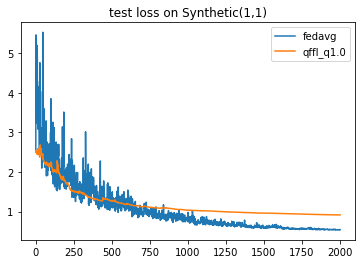

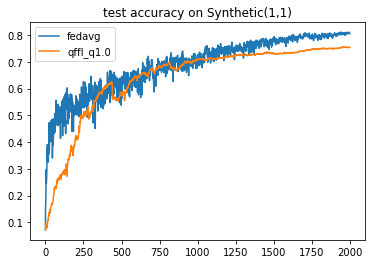

In [12]:
import flgo.experiment.analyzer
analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg','qffl_q1.0' ]
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'test_loss'}, 'fig_option':{'title':'test loss on Synthetic(1,1)'}},
            {'args':{'x': 'communication_round', 'y':'test_accuracy'},  'fig_option':{'title':'test accuracy on Synthetic(1,1)'}},
#             {'args':{'x': 'communication_round', 'y':'std_valid_loss'}, 'fig_option':{'title':'std_valid_loss on Synthetic(1,1)'}},
        ]
    }
}
flgo.experiment.analyzer.show(analysis_plan)

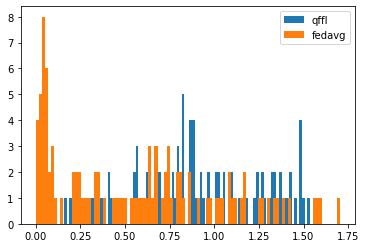

In [7]:
import matplotlib.pyplot as plt
import flgo.experiment.analyzer as al

s = al.Selector({'task':task, 'header':['qffl','fedavg']})
records = s.records[task]
for rec in records:
    plt.hist(rec.data['valid_loss_dist'], label=rec.data['option']['algorithm'], bins=len(rec.data['valid_loss_dist']))
plt.legend()
plt.show()

### 参数q的影响

In [10]:
qffl_runner_q50 = flgo.init(task, qffl, option={'algo_para':5.0,'num_rounds':2000, 'num_epochs':1, 'batch_size':10, 'learning_rate':0.1, 'gpu':0, 'proportion':0.1,'lr_scheduler':0})
qffl_runner_q05 = flgo.init(task, qffl, option={'algo_para':0.5,'num_rounds':2000, 'num_epochs':1, 'batch_size':10, 'learning_rate':0.1, 'gpu':0, 'proportion':0.1,'lr_scheduler':0})
qffl_runner_q01 = flgo.init(task, qffl, option={'algo_para':0.1,'num_rounds':2000, 'num_epochs':1, 'batch_size':10, 'learning_rate':0.1, 'gpu':0, 'proportion':0.1,'lr_scheduler':0})
runners = [qffl_runner_q50, qffl_runner_q05, qffl_runner_q01]
for r in runners: r.run()

2023-03-12 16:41:21,521 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.
2023-03-12 16:41:22,246 fflow.py init [line:384] INFO Use `<class 'flgo.system_simulator.default_simulator.Simulator'>` as the system simulator
2023-03-12 16:41:22,247 fflow.py init [line:392] INFO Ready to start.
2023-03-12 16:41:22,267 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.
2023-03-12 16:41:22,899 fflow.py init [line:384] INFO Use `<class 'flgo.system_simulator.default_simulator.Simulator'>` as the system simulator
2023-03-12 16:41:22,900 fflow.py init [line:392] INFO Ready to start.
2023-03-12 16:41:22,919 fedbase.py run [line:102] INFO --------------Initial Evaluation--------------
2023-03-12 16:41:22,920 simple_logger.py log_once [line:13] INFO Current_time:0
2023-03-12 16:41:22,986 simple_logger.py log_once [line:27] INFO test_accuracy                 0.0720
2023-03-12 16:41:22,986 simple_logger.py log_once [line:27] 

2023-03-12 16:41:24,534 fedbase.py run [line:112] INFO --------------Round 7--------------
2023-03-12 16:41:24,534 simple_logger.py log_once [line:13] INFO Current_time:7
2023-03-12 16:41:24,601 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1027
2023-03-12 16:41:24,601 simple_logger.py log_once [line:27] INFO test_loss                     2.4486
2023-03-12 16:41:24,602 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1065
2023-03-12 16:41:24,602 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1065
2023-03-12 16:41:24,602 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2205
2023-03-12 16:41:24,602 simple_logger.py log_once [line:27] INFO valid_loss                    2.4491
2023-03-12 16:41:24,603 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4491
2023-03-12 16:41:24,603 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6924
2023-03-12 16

2023-03-12 16:41:26,131 simple_logger.py log_once [line:27] INFO valid_loss                    2.6585
2023-03-12 16:41:26,131 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.6585
2023-03-12 16:41:26,131 simple_logger.py log_once [line:27] INFO std_valid_loss                1.3227
2023-03-12 16:41:26,132 fedbase.py run [line:117] INFO Eval Time Cost:               0.0704s
2023-03-12 16:41:26,278 fedbase.py run [line:112] INFO --------------Round 15--------------
2023-03-12 16:41:26,278 simple_logger.py log_once [line:13] INFO Current_time:15
2023-03-12 16:41:26,344 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1350
2023-03-12 16:41:26,345 simple_logger.py log_once [line:27] INFO test_loss                     2.6127
2023-03-12 16:41:26,345 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1329
2023-03-12 16:41:26,345 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1329
2023-03-12 16:41:26,

2023-03-12 16:41:27,869 simple_logger.py log_once [line:27] INFO test_loss                     2.4959
2023-03-12 16:41:27,870 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1597
2023-03-12 16:41:27,870 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1597
2023-03-12 16:41:27,870 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2825
2023-03-12 16:41:27,871 simple_logger.py log_once [line:27] INFO valid_loss                    2.5035
2023-03-12 16:41:27,871 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5035
2023-03-12 16:41:27,871 simple_logger.py log_once [line:27] INFO std_valid_loss                1.1580
2023-03-12 16:41:27,871 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:41:28,036 fedbase.py run [line:112] INFO --------------Round 23--------------
2023-03-12 16:41:28,037 simple_logger.py log_once [line:13] INFO Current_time:23
2023-03-12 16:41:28,

2023-03-12 16:41:29,501 fedbase.py run [line:117] INFO Eval Time Cost:               0.1371s
2023-03-12 16:41:29,663 fedbase.py run [line:112] INFO --------------Round 30--------------
2023-03-12 16:41:29,663 simple_logger.py log_once [line:13] INFO Current_time:30
2023-03-12 16:41:29,730 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1963
2023-03-12 16:41:29,730 simple_logger.py log_once [line:27] INFO test_loss                     2.2879
2023-03-12 16:41:29,731 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1985
2023-03-12 16:41:29,731 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1985
2023-03-12 16:41:29,731 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2936
2023-03-12 16:41:29,732 simple_logger.py log_once [line:27] INFO valid_loss                    2.2944
2023-03-12 16:41:29,732 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2944
2023-03-12 16:41:29,

2023-03-12 16:41:31,298 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2845
2023-03-12 16:41:31,298 simple_logger.py log_once [line:27] INFO valid_loss                    2.2265
2023-03-12 16:41:31,298 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2265
2023-03-12 16:41:31,298 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7784
2023-03-12 16:41:31,299 fedbase.py run [line:117] INFO Eval Time Cost:               0.0698s
2023-03-12 16:41:31,466 fedbase.py run [line:112] INFO --------------Round 38--------------
2023-03-12 16:41:31,466 simple_logger.py log_once [line:13] INFO Current_time:38
2023-03-12 16:41:31,532 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1938
2023-03-12 16:41:31,532 simple_logger.py log_once [line:27] INFO test_loss                     2.2134
2023-03-12 16:41:31,533 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1900
2023-03-12 16:41:31,

2023-03-12 16:41:33,074 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2282
2023-03-12 16:41:33,074 simple_logger.py log_once [line:27] INFO test_loss                     2.1033
2023-03-12 16:41:33,074 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2244
2023-03-12 16:41:33,075 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2244
2023-03-12 16:41:33,075 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2966
2023-03-12 16:41:33,075 simple_logger.py log_once [line:27] INFO valid_loss                    2.1049
2023-03-12 16:41:33,075 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1049
2023-03-12 16:41:33,076 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6769
2023-03-12 16:41:33,076 fedbase.py run [line:117] INFO Eval Time Cost:               0.0681s
2023-03-12 16:41:33,254 fedbase.py run [line:112] INFO --------------Round 46--------------

2023-03-12 16:41:34,720 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7615
2023-03-12 16:41:34,720 fedbase.py run [line:117] INFO Eval Time Cost:               0.1422s
2023-03-12 16:41:34,887 fedbase.py run [line:112] INFO --------------Round 53--------------
2023-03-12 16:41:34,887 simple_logger.py log_once [line:13] INFO Current_time:53
2023-03-12 16:41:34,953 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2378
2023-03-12 16:41:34,953 simple_logger.py log_once [line:27] INFO test_loss                     2.0613
2023-03-12 16:41:34,953 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2312
2023-03-12 16:41:34,954 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2312
2023-03-12 16:41:34,954 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3033
2023-03-12 16:41:34,954 simple_logger.py log_once [line:27] INFO valid_loss                    2.0648
2023-03-12 16:41:34,

2023-03-12 16:41:36,518 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2621
2023-03-12 16:41:36,518 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3240
2023-03-12 16:41:36,518 simple_logger.py log_once [line:27] INFO valid_loss                    2.0002
2023-03-12 16:41:36,519 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0002
2023-03-12 16:41:36,519 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6741
2023-03-12 16:41:36,519 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:41:36,673 fedbase.py run [line:112] INFO --------------Round 61--------------
2023-03-12 16:41:36,673 simple_logger.py log_once [line:13] INFO Current_time:61
2023-03-12 16:41:36,740 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2740
2023-03-12 16:41:36,740 simple_logger.py log_once [line:27] INFO test_loss                     2.0008
2023-03-12 16:41:36,

2023-03-12 16:41:38,270 simple_logger.py log_once [line:13] INFO Current_time:68
2023-03-12 16:41:38,337 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2980
2023-03-12 16:41:38,337 simple_logger.py log_once [line:27] INFO test_loss                     1.9628
2023-03-12 16:41:38,338 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2909
2023-03-12 16:41:38,338 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2909
2023-03-12 16:41:38,338 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3199
2023-03-12 16:41:38,338 simple_logger.py log_once [line:27] INFO valid_loss                    1.9643
2023-03-12 16:41:38,339 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9643
2023-03-12 16:41:38,339 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7135
2023-03-12 16:41:38,339 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12

2023-03-12 16:41:39,920 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8696
2023-03-12 16:41:39,920 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6984
2023-03-12 16:41:39,920 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:41:40,073 fedbase.py run [line:112] INFO --------------Round 76--------------
2023-03-12 16:41:40,073 simple_logger.py log_once [line:13] INFO Current_time:76
2023-03-12 16:41:40,215 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3777
2023-03-12 16:41:40,216 simple_logger.py log_once [line:27] INFO test_loss                     1.8546
2023-03-12 16:41:40,216 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3859
2023-03-12 16:41:40,216 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3859
2023-03-12 16:41:40,216 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3544
2023-03-12 16:41:40,

2023-03-12 16:41:41,811 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3694
2023-03-12 16:41:41,811 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3694
2023-03-12 16:41:41,811 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3558
2023-03-12 16:41:41,812 simple_logger.py log_once [line:27] INFO valid_loss                    1.8578
2023-03-12 16:41:41,812 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8578
2023-03-12 16:41:41,812 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7372
2023-03-12 16:41:41,812 fedbase.py run [line:117] INFO Eval Time Cost:               0.0718s
2023-03-12 16:41:41,967 fedbase.py run [line:112] INFO --------------Round 84--------------
2023-03-12 16:41:41,968 simple_logger.py log_once [line:13] INFO Current_time:84
2023-03-12 16:41:42,035 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3718
2023-03-12 16:41:42,

2023-03-12 16:41:43,480 fedbase.py run [line:112] INFO --------------Round 91--------------
2023-03-12 16:41:43,481 simple_logger.py log_once [line:13] INFO Current_time:91
2023-03-12 16:41:43,547 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3745
2023-03-12 16:41:43,548 simple_logger.py log_once [line:27] INFO test_loss                     1.8118
2023-03-12 16:41:43,548 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3741
2023-03-12 16:41:43,548 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3741
2023-03-12 16:41:43,549 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3537
2023-03-12 16:41:43,549 simple_logger.py log_once [line:27] INFO valid_loss                    1.8142
2023-03-12 16:41:43,549 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8142
2023-03-12 16:41:43,549 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7077
2023-03-12 

2023-03-12 16:41:45,109 simple_logger.py log_once [line:27] INFO valid_loss                    1.7519
2023-03-12 16:41:45,109 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7519
2023-03-12 16:41:45,109 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6584
2023-03-12 16:41:45,109 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:41:45,259 fedbase.py run [line:112] INFO --------------Round 99--------------
2023-03-12 16:41:45,260 simple_logger.py log_once [line:13] INFO Current_time:99
2023-03-12 16:41:45,327 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4023
2023-03-12 16:41:45,327 simple_logger.py log_once [line:27] INFO test_loss                     1.7285
2023-03-12 16:41:45,327 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4038
2023-03-12 16:41:45,328 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4038
2023-03-12 16:41:45,

2023-03-12 16:41:46,941 simple_logger.py log_once [line:27] INFO test_loss                     1.6875
2023-03-12 16:41:46,941 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4285
2023-03-12 16:41:46,942 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4285
2023-03-12 16:41:46,942 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3802
2023-03-12 16:41:46,942 simple_logger.py log_once [line:27] INFO valid_loss                    1.6921
2023-03-12 16:41:46,942 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6921
2023-03-12 16:41:46,943 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6457
2023-03-12 16:41:46,943 fedbase.py run [line:117] INFO Eval Time Cost:               0.0736s
2023-03-12 16:41:47,101 fedbase.py run [line:112] INFO --------------Round 107--------------
2023-03-12 16:41:47,102 simple_logger.py log_once [line:13] INFO Current_time:107
2023-03-12 16:41:4

2023-03-12 16:41:48,413 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5805
2023-03-12 16:41:48,413 fedbase.py run [line:117] INFO Eval Time Cost:               0.0685s
2023-03-12 16:41:48,578 fedbase.py run [line:112] INFO --------------Round 114--------------
2023-03-12 16:41:48,578 simple_logger.py log_once [line:13] INFO Current_time:114
2023-03-12 16:41:48,645 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4290
2023-03-12 16:41:48,646 simple_logger.py log_once [line:27] INFO test_loss                     1.6533
2023-03-12 16:41:48,646 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4232
2023-03-12 16:41:48,646 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4232
2023-03-12 16:41:48,647 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3635
2023-03-12 16:41:48,647 simple_logger.py log_once [line:27] INFO valid_loss                    1.6614
2023-03-12 16:41:4

2023-03-12 16:41:50,187 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4250
2023-03-12 16:41:50,187 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3646
2023-03-12 16:41:50,187 simple_logger.py log_once [line:27] INFO valid_loss                    1.6584
2023-03-12 16:41:50,187 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6584
2023-03-12 16:41:50,188 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6749
2023-03-12 16:41:50,188 fedbase.py run [line:117] INFO Eval Time Cost:               0.0683s
2023-03-12 16:41:50,344 fedbase.py run [line:112] INFO --------------Round 122--------------
2023-03-12 16:41:50,344 simple_logger.py log_once [line:13] INFO Current_time:122
2023-03-12 16:41:50,410 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4308
2023-03-12 16:41:50,411 simple_logger.py log_once [line:27] INFO test_loss                     1.6381
2023-03-12 16:41:5

2023-03-12 16:41:52,023 simple_logger.py log_once [line:13] INFO Current_time:129
2023-03-12 16:41:52,092 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4492
2023-03-12 16:41:52,093 simple_logger.py log_once [line:27] INFO test_loss                     1.6012
2023-03-12 16:41:52,093 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4532
2023-03-12 16:41:52,093 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4532
2023-03-12 16:41:52,093 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3547
2023-03-12 16:41:52,094 simple_logger.py log_once [line:27] INFO valid_loss                    1.6097
2023-03-12 16:41:52,094 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6097
2023-03-12 16:41:52,094 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5977
2023-03-12 16:41:52,094 fedbase.py run [line:117] INFO Eval Time Cost:               0.0717s
2023-03-1

2023-03-12 16:41:53,653 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5450
2023-03-12 16:41:53,653 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5509
2023-03-12 16:41:53,653 fedbase.py run [line:117] INFO Eval Time Cost:               0.0683s
2023-03-12 16:41:53,806 fedbase.py run [line:112] INFO --------------Round 137--------------
2023-03-12 16:41:53,807 simple_logger.py log_once [line:13] INFO Current_time:137
2023-03-12 16:41:53,873 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4870
2023-03-12 16:41:53,873 simple_logger.py log_once [line:27] INFO test_loss                     1.5419
2023-03-12 16:41:53,874 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4921
2023-03-12 16:41:53,874 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4921
2023-03-12 16:41:53,874 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3529
2023-03-12 16:41:5

2023-03-12 16:41:55,502 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5085
2023-03-12 16:41:55,502 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5085
2023-03-12 16:41:55,502 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3501
2023-03-12 16:41:55,502 simple_logger.py log_once [line:27] INFO valid_loss                    1.5249
2023-03-12 16:41:55,503 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5249
2023-03-12 16:41:55,503 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5819
2023-03-12 16:41:55,503 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:41:55,658 fedbase.py run [line:112] INFO --------------Round 145--------------
2023-03-12 16:41:55,658 simple_logger.py log_once [line:13] INFO Current_time:145
2023-03-12 16:41:55,726 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5155
2023-03-12 16:41:5

2023-03-12 16:41:57,210 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:41:57,352 fedbase.py run [line:112] INFO --------------Round 152--------------
2023-03-12 16:41:57,352 simple_logger.py log_once [line:13] INFO Current_time:152
2023-03-12 16:41:57,419 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5383
2023-03-12 16:41:57,420 simple_logger.py log_once [line:27] INFO test_loss                     1.4662
2023-03-12 16:41:57,420 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5332
2023-03-12 16:41:57,420 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5332
2023-03-12 16:41:57,421 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3484
2023-03-12 16:41:57,421 simple_logger.py log_once [line:27] INFO valid_loss                    1.4772
2023-03-12 16:41:57,421 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4772
2023-03-12 16:41:5

2023-03-12 16:41:59,013 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3477
2023-03-12 16:41:59,014 simple_logger.py log_once [line:27] INFO valid_loss                    1.4586
2023-03-12 16:41:59,014 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4586
2023-03-12 16:41:59,014 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5465
2023-03-12 16:41:59,014 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:41:59,175 fedbase.py run [line:112] INFO --------------Round 160--------------
2023-03-12 16:41:59,175 simple_logger.py log_once [line:13] INFO Current_time:160
2023-03-12 16:41:59,242 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5343
2023-03-12 16:41:59,243 simple_logger.py log_once [line:27] INFO test_loss                     1.4465
2023-03-12 16:41:59,243 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5350
2023-03-12 16:41:5

2023-03-12 16:42:00,826 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5347
2023-03-12 16:42:00,827 simple_logger.py log_once [line:27] INFO test_loss                     1.4347
2023-03-12 16:42:00,827 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5306
2023-03-12 16:42:00,827 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5306
2023-03-12 16:42:00,828 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3451
2023-03-12 16:42:00,828 simple_logger.py log_once [line:27] INFO valid_loss                    1.4450
2023-03-12 16:42:00,828 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4450
2023-03-12 16:42:00,828 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5624
2023-03-12 16:42:00,829 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:42:01,018 fedbase.py run [line:112] INFO --------------Round 168-------------

2023-03-12 16:42:02,627 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4344
2023-03-12 16:42:02,628 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5469
2023-03-12 16:42:02,628 fedbase.py run [line:117] INFO Eval Time Cost:               0.0683s
2023-03-12 16:42:02,789 fedbase.py run [line:112] INFO --------------Round 175--------------
2023-03-12 16:42:02,790 simple_logger.py log_once [line:13] INFO Current_time:175
2023-03-12 16:42:02,856 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5132
2023-03-12 16:42:02,856 simple_logger.py log_once [line:27] INFO test_loss                     1.4614
2023-03-12 16:42:02,856 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5103
2023-03-12 16:42:02,857 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5103
2023-03-12 16:42:02,857 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3546
2023-03-12 16:42:0

2023-03-12 16:42:04,444 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4950
2023-03-12 16:42:04,444 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4950
2023-03-12 16:42:04,444 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3468
2023-03-12 16:42:04,445 simple_logger.py log_once [line:27] INFO valid_loss                    1.4649
2023-03-12 16:42:04,445 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4649
2023-03-12 16:42:04,445 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5639
2023-03-12 16:42:04,445 fedbase.py run [line:117] INFO Eval Time Cost:               0.0685s
2023-03-12 16:42:04,608 fedbase.py run [line:112] INFO --------------Round 183--------------
2023-03-12 16:42:04,609 simple_logger.py log_once [line:13] INFO Current_time:183
2023-03-12 16:42:04,675 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5033
2023-03-12 16:42:0

2023-03-12 16:42:05,979 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:42:06,117 fedbase.py run [line:112] INFO --------------Round 190--------------
2023-03-12 16:42:06,118 simple_logger.py log_once [line:13] INFO Current_time:190
2023-03-12 16:42:06,186 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5082
2023-03-12 16:42:06,187 simple_logger.py log_once [line:27] INFO test_loss                     1.4389
2023-03-12 16:42:06,187 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5091
2023-03-12 16:42:06,187 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5091
2023-03-12 16:42:06,188 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3511
2023-03-12 16:42:06,188 simple_logger.py log_once [line:27] INFO valid_loss                    1.4525
2023-03-12 16:42:06,189 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4525
2023-03-12 16:42:0

2023-03-12 16:42:07,829 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3545
2023-03-12 16:42:07,830 simple_logger.py log_once [line:27] INFO valid_loss                    1.4756
2023-03-12 16:42:07,830 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4756
2023-03-12 16:42:07,830 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6031
2023-03-12 16:42:07,831 fedbase.py run [line:117] INFO Eval Time Cost:               0.0717s
2023-03-12 16:42:07,971 fedbase.py run [line:112] INFO --------------Round 198--------------
2023-03-12 16:42:07,971 simple_logger.py log_once [line:13] INFO Current_time:198
2023-03-12 16:42:08,039 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4960
2023-03-12 16:42:08,040 simple_logger.py log_once [line:27] INFO test_loss                     1.4590
2023-03-12 16:42:08,040 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4941
2023-03-12 16:42:0

2023-03-12 16:42:09,578 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5268
2023-03-12 16:42:09,579 simple_logger.py log_once [line:27] INFO test_loss                     1.4032
2023-03-12 16:42:09,579 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5241
2023-03-12 16:42:09,579 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5241
2023-03-12 16:42:09,580 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3423
2023-03-12 16:42:09,580 simple_logger.py log_once [line:27] INFO valid_loss                    1.4188
2023-03-12 16:42:09,580 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4188
2023-03-12 16:42:09,581 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5627
2023-03-12 16:42:09,581 fedbase.py run [line:117] INFO Eval Time Cost:               0.0702s
2023-03-12 16:42:09,721 fedbase.py run [line:112] INFO --------------Round 206-------------

2023-03-12 16:42:11,171 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4324
2023-03-12 16:42:11,171 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5781
2023-03-12 16:42:11,171 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:42:11,323 fedbase.py run [line:112] INFO --------------Round 213--------------
2023-03-12 16:42:11,323 simple_logger.py log_once [line:13] INFO Current_time:213
2023-03-12 16:42:11,393 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5280
2023-03-12 16:42:11,394 simple_logger.py log_once [line:27] INFO test_loss                     1.4094
2023-03-12 16:42:11,394 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5226
2023-03-12 16:42:11,394 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5226
2023-03-12 16:42:11,395 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3505
2023-03-12 16:42:1

2023-03-12 16:42:12,985 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5391
2023-03-12 16:42:12,985 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5391
2023-03-12 16:42:12,985 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3288
2023-03-12 16:42:12,986 simple_logger.py log_once [line:27] INFO valid_loss                    1.3989
2023-03-12 16:42:12,986 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3989
2023-03-12 16:42:12,986 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5704
2023-03-12 16:42:12,987 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:42:13,141 fedbase.py run [line:112] INFO --------------Round 221--------------
2023-03-12 16:42:13,141 simple_logger.py log_once [line:13] INFO Current_time:221
2023-03-12 16:42:13,208 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5498
2023-03-12 16:42:1

2023-03-12 16:42:14,586 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:42:14,725 fedbase.py run [line:112] INFO --------------Round 228--------------
2023-03-12 16:42:14,725 simple_logger.py log_once [line:13] INFO Current_time:228
2023-03-12 16:42:14,792 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5575
2023-03-12 16:42:14,793 simple_logger.py log_once [line:27] INFO test_loss                     1.3690
2023-03-12 16:42:14,793 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5579
2023-03-12 16:42:14,793 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5579
2023-03-12 16:42:14,794 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3166
2023-03-12 16:42:14,794 simple_logger.py log_once [line:27] INFO valid_loss                    1.3829
2023-03-12 16:42:14,794 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3829
2023-03-12 16:42:1

2023-03-12 16:42:16,285 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3232
2023-03-12 16:42:16,285 simple_logger.py log_once [line:27] INFO valid_loss                    1.3945
2023-03-12 16:42:16,286 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3945
2023-03-12 16:42:16,286 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6009
2023-03-12 16:42:16,286 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:42:16,438 fedbase.py run [line:112] INFO --------------Round 236--------------
2023-03-12 16:42:16,439 simple_logger.py log_once [line:13] INFO Current_time:236
2023-03-12 16:42:16,506 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5473
2023-03-12 16:42:16,507 simple_logger.py log_once [line:27] INFO test_loss                     1.3746
2023-03-12 16:42:16,507 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5468
2023-03-12 16:42:1

2023-03-12 16:42:18,163 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5392
2023-03-12 16:42:18,163 simple_logger.py log_once [line:27] INFO test_loss                     1.3774
2023-03-12 16:42:18,164 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5406
2023-03-12 16:42:18,164 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5406
2023-03-12 16:42:18,164 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3280
2023-03-12 16:42:18,165 simple_logger.py log_once [line:27] INFO valid_loss                    1.3904
2023-03-12 16:42:18,165 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3904
2023-03-12 16:42:18,165 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6141
2023-03-12 16:42:18,166 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:42:18,327 fedbase.py run [line:112] INFO --------------Round 244-------------

2023-03-12 16:42:19,718 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3557
2023-03-12 16:42:19,719 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5791
2023-03-12 16:42:19,719 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:42:19,856 fedbase.py run [line:112] INFO --------------Round 251--------------
2023-03-12 16:42:19,856 simple_logger.py log_once [line:13] INFO Current_time:251
2023-03-12 16:42:19,922 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5538
2023-03-12 16:42:19,923 simple_logger.py log_once [line:27] INFO test_loss                     1.3467
2023-03-12 16:42:19,923 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5538
2023-03-12 16:42:19,923 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5538
2023-03-12 16:42:19,924 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3256
2023-03-12 16:42:1

2023-03-12 16:42:21,480 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5659
2023-03-12 16:42:21,480 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5659
2023-03-12 16:42:21,480 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3260
2023-03-12 16:42:21,480 simple_logger.py log_once [line:27] INFO valid_loss                    1.3485
2023-03-12 16:42:21,481 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3485
2023-03-12 16:42:21,481 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6011
2023-03-12 16:42:21,481 fedbase.py run [line:117] INFO Eval Time Cost:               0.0683s
2023-03-12 16:42:21,635 fedbase.py run [line:112] INFO --------------Round 259--------------
2023-03-12 16:42:21,636 simple_logger.py log_once [line:13] INFO Current_time:259
2023-03-12 16:42:21,703 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5587
2023-03-12 16:42:2

2023-03-12 16:42:23,085 fedbase.py run [line:117] INFO Eval Time Cost:               0.0715s
2023-03-12 16:42:23,247 fedbase.py run [line:112] INFO --------------Round 266--------------
2023-03-12 16:42:23,247 simple_logger.py log_once [line:13] INFO Current_time:266
2023-03-12 16:42:23,314 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5657
2023-03-12 16:42:23,315 simple_logger.py log_once [line:27] INFO test_loss                     1.3113
2023-03-12 16:42:23,315 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5776
2023-03-12 16:42:23,315 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5776
2023-03-12 16:42:23,316 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3296
2023-03-12 16:42:23,316 simple_logger.py log_once [line:27] INFO valid_loss                    1.3244
2023-03-12 16:42:23,316 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3244
2023-03-12 16:42:2

2023-03-12 16:42:24,849 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3325
2023-03-12 16:42:24,849 simple_logger.py log_once [line:27] INFO valid_loss                    1.3142
2023-03-12 16:42:24,849 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3142
2023-03-12 16:42:24,849 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5339
2023-03-12 16:42:24,850 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:42:25,002 fedbase.py run [line:112] INFO --------------Round 274--------------
2023-03-12 16:42:25,002 simple_logger.py log_once [line:13] INFO Current_time:274
2023-03-12 16:42:25,069 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5697
2023-03-12 16:42:25,069 simple_logger.py log_once [line:27] INFO test_loss                     1.2986
2023-03-12 16:42:25,069 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5691
2023-03-12 16:42:2

2023-03-12 16:42:26,643 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5752
2023-03-12 16:42:26,643 simple_logger.py log_once [line:27] INFO test_loss                     1.2927
2023-03-12 16:42:26,643 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5715
2023-03-12 16:42:26,644 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5715
2023-03-12 16:42:26,644 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3229
2023-03-12 16:42:26,644 simple_logger.py log_once [line:27] INFO valid_loss                    1.3037
2023-03-12 16:42:26,644 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3037
2023-03-12 16:42:26,645 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5482
2023-03-12 16:42:26,645 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:42:26,787 fedbase.py run [line:112] INFO --------------Round 282-------------

2023-03-12 16:42:28,207 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2955
2023-03-12 16:42:28,207 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5388
2023-03-12 16:42:28,208 fedbase.py run [line:117] INFO Eval Time Cost:               0.1377s
2023-03-12 16:42:28,385 fedbase.py run [line:112] INFO --------------Round 289--------------
2023-03-12 16:42:28,386 simple_logger.py log_once [line:13] INFO Current_time:289
2023-03-12 16:42:28,453 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5650
2023-03-12 16:42:28,453 simple_logger.py log_once [line:27] INFO test_loss                     1.2819
2023-03-12 16:42:28,453 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5700
2023-03-12 16:42:28,454 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5700
2023-03-12 16:42:28,454 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3262
2023-03-12 16:42:2

2023-03-12 16:42:29,989 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5691
2023-03-12 16:42:29,989 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5691
2023-03-12 16:42:29,989 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3288
2023-03-12 16:42:29,989 simple_logger.py log_once [line:27] INFO valid_loss                    1.2796
2023-03-12 16:42:29,990 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2796
2023-03-12 16:42:29,990 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5139
2023-03-12 16:42:29,990 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:42:30,155 fedbase.py run [line:112] INFO --------------Round 297--------------
2023-03-12 16:42:30,155 simple_logger.py log_once [line:13] INFO Current_time:297
2023-03-12 16:42:30,243 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5732
2023-03-12 16:42:3

2023-03-12 16:42:31,567 fedbase.py run [line:117] INFO Eval Time Cost:               0.0692s
2023-03-12 16:42:31,711 fedbase.py run [line:112] INFO --------------Round 304--------------
2023-03-12 16:42:31,712 simple_logger.py log_once [line:13] INFO Current_time:304
2023-03-12 16:42:31,779 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5833
2023-03-12 16:42:31,779 simple_logger.py log_once [line:27] INFO test_loss                     1.2536
2023-03-12 16:42:31,779 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5821
2023-03-12 16:42:31,780 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5821
2023-03-12 16:42:31,780 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3203
2023-03-12 16:42:31,780 simple_logger.py log_once [line:27] INFO valid_loss                    1.2664
2023-03-12 16:42:31,780 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2664
2023-03-12 16:42:3

2023-03-12 16:42:33,442 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3249
2023-03-12 16:42:33,442 simple_logger.py log_once [line:27] INFO valid_loss                    1.2597
2023-03-12 16:42:33,442 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2597
2023-03-12 16:42:33,442 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5556
2023-03-12 16:42:33,443 fedbase.py run [line:117] INFO Eval Time Cost:               0.1485s
2023-03-12 16:42:33,595 fedbase.py run [line:112] INFO --------------Round 312--------------
2023-03-12 16:42:33,595 simple_logger.py log_once [line:13] INFO Current_time:312
2023-03-12 16:42:33,661 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5828
2023-03-12 16:42:33,661 simple_logger.py log_once [line:27] INFO test_loss                     1.2450
2023-03-12 16:42:33,662 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5759
2023-03-12 16:42:3

2023-03-12 16:42:35,141 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5720
2023-03-12 16:42:35,142 simple_logger.py log_once [line:27] INFO test_loss                     1.2491
2023-03-12 16:42:35,142 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5738
2023-03-12 16:42:35,142 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5738
2023-03-12 16:42:35,142 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3213
2023-03-12 16:42:35,143 simple_logger.py log_once [line:27] INFO valid_loss                    1.2642
2023-03-12 16:42:35,143 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2642
2023-03-12 16:42:35,143 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5703
2023-03-12 16:42:35,143 fedbase.py run [line:117] INFO Eval Time Cost:               0.0679s
2023-03-12 16:42:35,264 fedbase.py run [line:112] INFO --------------Round 320-------------

2023-03-12 16:42:36,625 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2712
2023-03-12 16:42:36,625 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6020
2023-03-12 16:42:36,625 fedbase.py run [line:117] INFO Eval Time Cost:               0.0680s
2023-03-12 16:42:36,762 fedbase.py run [line:112] INFO --------------Round 327--------------
2023-03-12 16:42:36,762 simple_logger.py log_once [line:13] INFO Current_time:327
2023-03-12 16:42:36,828 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5867
2023-03-12 16:42:36,828 simple_logger.py log_once [line:27] INFO test_loss                     1.2261
2023-03-12 16:42:36,828 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5871
2023-03-12 16:42:36,829 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5871
2023-03-12 16:42:36,829 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3183
2023-03-12 16:42:3

2023-03-12 16:42:38,406 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5912
2023-03-12 16:42:38,407 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5912
2023-03-12 16:42:38,407 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3087
2023-03-12 16:42:38,407 simple_logger.py log_once [line:27] INFO valid_loss                    1.2383
2023-03-12 16:42:38,407 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2383
2023-03-12 16:42:38,408 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5373
2023-03-12 16:42:38,408 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:42:38,585 fedbase.py run [line:112] INFO --------------Round 335--------------
2023-03-12 16:42:38,586 simple_logger.py log_once [line:13] INFO Current_time:335
2023-03-12 16:42:38,656 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5977
2023-03-12 16:42:3

2023-03-12 16:42:39,986 fedbase.py run [line:117] INFO Eval Time Cost:               0.0692s
2023-03-12 16:42:40,129 fedbase.py run [line:112] INFO --------------Round 342--------------
2023-03-12 16:42:40,129 simple_logger.py log_once [line:13] INFO Current_time:342
2023-03-12 16:42:40,196 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5897
2023-03-12 16:42:40,196 simple_logger.py log_once [line:27] INFO test_loss                     1.2256
2023-03-12 16:42:40,197 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5874
2023-03-12 16:42:40,197 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5874
2023-03-12 16:42:40,197 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3085
2023-03-12 16:42:40,198 simple_logger.py log_once [line:27] INFO valid_loss                    1.2422
2023-03-12 16:42:40,198 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2422
2023-03-12 16:42:4

2023-03-12 16:42:41,681 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3034
2023-03-12 16:42:41,682 simple_logger.py log_once [line:27] INFO valid_loss                    1.2179
2023-03-12 16:42:41,682 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2179
2023-03-12 16:42:41,682 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5735
2023-03-12 16:42:41,682 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:42:41,849 fedbase.py run [line:112] INFO --------------Round 350--------------
2023-03-12 16:42:41,849 simple_logger.py log_once [line:13] INFO Current_time:350
2023-03-12 16:42:41,916 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6015
2023-03-12 16:42:41,917 simple_logger.py log_once [line:27] INFO test_loss                     1.2047
2023-03-12 16:42:41,917 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6029
2023-03-12 16:42:4

2023-03-12 16:42:43,617 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6112
2023-03-12 16:42:43,617 simple_logger.py log_once [line:27] INFO test_loss                     1.2004
2023-03-12 16:42:43,618 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6071
2023-03-12 16:42:43,618 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6071
2023-03-12 16:42:43,618 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3153
2023-03-12 16:42:43,619 simple_logger.py log_once [line:27] INFO valid_loss                    1.2119
2023-03-12 16:42:43,619 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2119
2023-03-12 16:42:43,619 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5895
2023-03-12 16:42:43,619 fedbase.py run [line:117] INFO Eval Time Cost:               0.0684s
2023-03-12 16:42:43,784 fedbase.py run [line:112] INFO --------------Round 358-------------

2023-03-12 16:42:45,193 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1974
2023-03-12 16:42:45,193 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5631
2023-03-12 16:42:45,193 fedbase.py run [line:117] INFO Eval Time Cost:               0.0684s
2023-03-12 16:42:45,335 fedbase.py run [line:112] INFO --------------Round 365--------------
2023-03-12 16:42:45,336 simple_logger.py log_once [line:13] INFO Current_time:365
2023-03-12 16:42:45,402 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6155
2023-03-12 16:42:45,402 simple_logger.py log_once [line:27] INFO test_loss                     1.1862
2023-03-12 16:42:45,403 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6147
2023-03-12 16:42:45,403 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6147
2023-03-12 16:42:45,403 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3039
2023-03-12 16:42:4

2023-03-12 16:42:46,949 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6141
2023-03-12 16:42:46,949 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6141
2023-03-12 16:42:46,950 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3122
2023-03-12 16:42:46,950 simple_logger.py log_once [line:27] INFO valid_loss                    1.2177
2023-03-12 16:42:46,950 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2177
2023-03-12 16:42:46,950 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5885
2023-03-12 16:42:46,951 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:42:47,104 fedbase.py run [line:112] INFO --------------Round 373--------------
2023-03-12 16:42:47,105 simple_logger.py log_once [line:13] INFO Current_time:373
2023-03-12 16:42:47,171 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6197
2023-03-12 16:42:4

2023-03-12 16:42:48,543 fedbase.py run [line:117] INFO Eval Time Cost:               0.1444s
2023-03-12 16:42:48,696 fedbase.py run [line:112] INFO --------------Round 380--------------
2023-03-12 16:42:48,697 simple_logger.py log_once [line:13] INFO Current_time:380
2023-03-12 16:42:48,764 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6077
2023-03-12 16:42:48,764 simple_logger.py log_once [line:27] INFO test_loss                     1.2117
2023-03-12 16:42:48,765 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6071
2023-03-12 16:42:48,765 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6071
2023-03-12 16:42:48,765 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3201
2023-03-12 16:42:48,765 simple_logger.py log_once [line:27] INFO valid_loss                    1.2275
2023-03-12 16:42:48,766 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2275
2023-03-12 16:42:4

2023-03-12 16:42:50,314 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3146
2023-03-12 16:42:50,314 simple_logger.py log_once [line:27] INFO valid_loss                    1.2183
2023-03-12 16:42:50,314 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2183
2023-03-12 16:42:50,314 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6114
2023-03-12 16:42:50,315 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:42:50,469 fedbase.py run [line:112] INFO --------------Round 388--------------
2023-03-12 16:42:50,469 simple_logger.py log_once [line:13] INFO Current_time:388
2023-03-12 16:42:50,535 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6152
2023-03-12 16:42:50,536 simple_logger.py log_once [line:27] INFO test_loss                     1.2004
2023-03-12 16:42:50,536 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6115
2023-03-12 16:42:5

2023-03-12 16:42:52,083 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6132
2023-03-12 16:42:52,083 simple_logger.py log_once [line:27] INFO test_loss                     1.2214
2023-03-12 16:42:52,084 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6103
2023-03-12 16:42:52,084 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6103
2023-03-12 16:42:52,084 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3206
2023-03-12 16:42:52,084 simple_logger.py log_once [line:27] INFO valid_loss                    1.2375
2023-03-12 16:42:52,085 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2375
2023-03-12 16:42:52,085 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6532
2023-03-12 16:42:52,085 fedbase.py run [line:117] INFO Eval Time Cost:               0.0679s
2023-03-12 16:42:52,227 fedbase.py run [line:112] INFO --------------Round 396-------------

2023-03-12 16:42:53,699 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2030
2023-03-12 16:42:53,700 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5774
2023-03-12 16:42:53,700 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:42:53,927 fedbase.py run [line:112] INFO --------------Round 403--------------
2023-03-12 16:42:53,928 simple_logger.py log_once [line:13] INFO Current_time:403
2023-03-12 16:42:53,994 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6185
2023-03-12 16:42:53,995 simple_logger.py log_once [line:27] INFO test_loss                     1.1805
2023-03-12 16:42:53,995 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6124
2023-03-12 16:42:53,995 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6124
2023-03-12 16:42:53,996 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3139
2023-03-12 16:42:5

2023-03-12 16:42:55,582 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6138
2023-03-12 16:42:55,582 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6138
2023-03-12 16:42:55,583 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3113
2023-03-12 16:42:55,583 simple_logger.py log_once [line:27] INFO valid_loss                    1.1941
2023-03-12 16:42:55,583 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1941
2023-03-12 16:42:55,583 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5701
2023-03-12 16:42:55,584 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:42:55,751 fedbase.py run [line:112] INFO --------------Round 411--------------
2023-03-12 16:42:55,751 simple_logger.py log_once [line:13] INFO Current_time:411
2023-03-12 16:42:55,818 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6143
2023-03-12 16:42:5

2023-03-12 16:42:57,177 fedbase.py run [line:117] INFO Eval Time Cost:               0.0681s
2023-03-12 16:42:57,334 fedbase.py run [line:112] INFO --------------Round 418--------------
2023-03-12 16:42:57,334 simple_logger.py log_once [line:13] INFO Current_time:418
2023-03-12 16:42:57,401 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6265
2023-03-12 16:42:57,402 simple_logger.py log_once [line:27] INFO test_loss                     1.1840
2023-03-12 16:42:57,402 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6250
2023-03-12 16:42:57,402 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6250
2023-03-12 16:42:57,402 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3068
2023-03-12 16:42:57,403 simple_logger.py log_once [line:27] INFO valid_loss                    1.1985
2023-03-12 16:42:57,403 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1985
2023-03-12 16:42:5

2023-03-12 16:42:59,027 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3066
2023-03-12 16:42:59,027 simple_logger.py log_once [line:27] INFO valid_loss                    1.1873
2023-03-12 16:42:59,027 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1873
2023-03-12 16:42:59,027 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6077
2023-03-12 16:42:59,027 fedbase.py run [line:117] INFO Eval Time Cost:               0.1384s
2023-03-12 16:42:59,166 fedbase.py run [line:112] INFO --------------Round 426--------------
2023-03-12 16:42:59,167 simple_logger.py log_once [line:13] INFO Current_time:426
2023-03-12 16:42:59,234 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6385
2023-03-12 16:42:59,234 simple_logger.py log_once [line:27] INFO test_loss                     1.1651
2023-03-12 16:42:59,235 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6341
2023-03-12 16:42:5

2023-03-12 16:43:00,863 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6360
2023-03-12 16:43:00,863 simple_logger.py log_once [line:27] INFO test_loss                     1.1577
2023-03-12 16:43:00,863 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6394
2023-03-12 16:43:00,864 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6394
2023-03-12 16:43:00,864 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2994
2023-03-12 16:43:00,864 simple_logger.py log_once [line:27] INFO valid_loss                    1.1718
2023-03-12 16:43:00,865 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1718
2023-03-12 16:43:00,865 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5923
2023-03-12 16:43:00,865 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:43:01,017 fedbase.py run [line:112] INFO --------------Round 434-------------

2023-03-12 16:43:02,348 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1580
2023-03-12 16:43:02,348 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5730
2023-03-12 16:43:02,348 fedbase.py run [line:117] INFO Eval Time Cost:               0.0683s
2023-03-12 16:43:02,502 fedbase.py run [line:112] INFO --------------Round 441--------------
2023-03-12 16:43:02,503 simple_logger.py log_once [line:13] INFO Current_time:441
2023-03-12 16:43:02,569 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6498
2023-03-12 16:43:02,570 simple_logger.py log_once [line:27] INFO test_loss                     1.1391
2023-03-12 16:43:02,570 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6465
2023-03-12 16:43:02,570 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6465
2023-03-12 16:43:02,570 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2934
2023-03-12 16:43:0

2023-03-12 16:43:04,193 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6162
2023-03-12 16:43:04,193 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6162
2023-03-12 16:43:04,193 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3055
2023-03-12 16:43:04,194 simple_logger.py log_once [line:27] INFO valid_loss                    1.1699
2023-03-12 16:43:04,194 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1699
2023-03-12 16:43:04,194 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5727
2023-03-12 16:43:04,194 fedbase.py run [line:117] INFO Eval Time Cost:               0.0683s
2023-03-12 16:43:04,375 fedbase.py run [line:112] INFO --------------Round 449--------------
2023-03-12 16:43:04,376 simple_logger.py log_once [line:13] INFO Current_time:449
2023-03-12 16:43:04,447 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6207
2023-03-12 16:43:0

2023-03-12 16:43:05,816 fedbase.py run [line:117] INFO Eval Time Cost:               0.0684s
2023-03-12 16:43:05,985 fedbase.py run [line:112] INFO --------------Round 456--------------
2023-03-12 16:43:05,985 simple_logger.py log_once [line:13] INFO Current_time:456
2023-03-12 16:43:06,066 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6282
2023-03-12 16:43:06,066 simple_logger.py log_once [line:27] INFO test_loss                     1.1395
2023-03-12 16:43:06,067 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6194
2023-03-12 16:43:06,067 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6194
2023-03-12 16:43:06,067 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3020
2023-03-12 16:43:06,068 simple_logger.py log_once [line:27] INFO valid_loss                    1.1554
2023-03-12 16:43:06,068 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1554
2023-03-12 16:43:0

2023-03-12 16:43:07,657 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2985
2023-03-12 16:43:07,657 simple_logger.py log_once [line:27] INFO valid_loss                    1.1523
2023-03-12 16:43:07,657 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1523
2023-03-12 16:43:07,657 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5445
2023-03-12 16:43:07,658 fedbase.py run [line:117] INFO Eval Time Cost:               0.0692s
2023-03-12 16:43:07,797 fedbase.py run [line:112] INFO --------------Round 464--------------
2023-03-12 16:43:07,797 simple_logger.py log_once [line:13] INFO Current_time:464
2023-03-12 16:43:07,865 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6258
2023-03-12 16:43:07,865 simple_logger.py log_once [line:27] INFO test_loss                     1.1381
2023-03-12 16:43:07,865 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6188
2023-03-12 16:43:0

2023-03-12 16:43:09,471 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6443
2023-03-12 16:43:09,472 simple_logger.py log_once [line:27] INFO test_loss                     1.1185
2023-03-12 16:43:09,472 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6341
2023-03-12 16:43:09,472 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6341
2023-03-12 16:43:09,472 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3008
2023-03-12 16:43:09,473 simple_logger.py log_once [line:27] INFO valid_loss                    1.1319
2023-03-12 16:43:09,473 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1319
2023-03-12 16:43:09,473 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5503
2023-03-12 16:43:09,473 fedbase.py run [line:117] INFO Eval Time Cost:               0.0684s
2023-03-12 16:43:09,597 fedbase.py run [line:112] INFO --------------Round 472-------------

2023-03-12 16:43:11,012 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1299
2023-03-12 16:43:11,012 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5554
2023-03-12 16:43:11,013 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 16:43:11,137 fedbase.py run [line:112] INFO --------------Round 479--------------
2023-03-12 16:43:11,137 simple_logger.py log_once [line:13] INFO Current_time:479
2023-03-12 16:43:11,204 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6502
2023-03-12 16:43:11,204 simple_logger.py log_once [line:27] INFO test_loss                     1.1164
2023-03-12 16:43:11,204 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6441
2023-03-12 16:43:11,205 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6441
2023-03-12 16:43:11,205 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2958
2023-03-12 16:43:1

2023-03-12 16:43:12,759 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6412
2023-03-12 16:43:12,759 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6412
2023-03-12 16:43:12,759 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2996
2023-03-12 16:43:12,759 simple_logger.py log_once [line:27] INFO valid_loss                    1.1304
2023-03-12 16:43:12,760 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1304
2023-03-12 16:43:12,760 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5641
2023-03-12 16:43:12,760 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:43:12,915 fedbase.py run [line:112] INFO --------------Round 487--------------
2023-03-12 16:43:12,916 simple_logger.py log_once [line:13] INFO Current_time:487
2023-03-12 16:43:12,982 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6498
2023-03-12 16:43:1

2023-03-12 16:43:14,357 fedbase.py run [line:117] INFO Eval Time Cost:               0.1370s
2023-03-12 16:43:14,512 fedbase.py run [line:112] INFO --------------Round 494--------------
2023-03-12 16:43:14,512 simple_logger.py log_once [line:13] INFO Current_time:494
2023-03-12 16:43:14,579 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6497
2023-03-12 16:43:14,580 simple_logger.py log_once [line:27] INFO test_loss                     1.1122
2023-03-12 16:43:14,580 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6447
2023-03-12 16:43:14,580 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6447
2023-03-12 16:43:14,581 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2939
2023-03-12 16:43:14,581 simple_logger.py log_once [line:27] INFO valid_loss                    1.1269
2023-03-12 16:43:14,581 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1269
2023-03-12 16:43:1

2023-03-12 16:43:16,200 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2969
2023-03-12 16:43:16,200 simple_logger.py log_once [line:27] INFO valid_loss                    1.1227
2023-03-12 16:43:16,201 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1227
2023-03-12 16:43:16,201 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5454
2023-03-12 16:43:16,201 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:43:16,360 fedbase.py run [line:112] INFO --------------Round 502--------------
2023-03-12 16:43:16,360 simple_logger.py log_once [line:13] INFO Current_time:502
2023-03-12 16:43:16,427 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6440
2023-03-12 16:43:16,427 simple_logger.py log_once [line:27] INFO test_loss                     1.1076
2023-03-12 16:43:16,428 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6376
2023-03-12 16:43:1

2023-03-12 16:43:17,952 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6498
2023-03-12 16:43:17,952 simple_logger.py log_once [line:27] INFO test_loss                     1.1093
2023-03-12 16:43:17,953 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6450
2023-03-12 16:43:17,953 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6450
2023-03-12 16:43:17,953 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2927
2023-03-12 16:43:17,954 simple_logger.py log_once [line:27] INFO valid_loss                    1.1242
2023-03-12 16:43:17,954 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1242
2023-03-12 16:43:17,954 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5506
2023-03-12 16:43:17,954 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:43:18,133 fedbase.py run [line:112] INFO --------------Round 510-------------

2023-03-12 16:43:19,504 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1379
2023-03-12 16:43:19,504 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5927
2023-03-12 16:43:19,504 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:43:19,735 fedbase.py run [line:112] INFO --------------Round 517--------------
2023-03-12 16:43:19,735 simple_logger.py log_once [line:13] INFO Current_time:517
2023-03-12 16:43:19,802 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6435
2023-03-12 16:43:19,802 simple_logger.py log_once [line:27] INFO test_loss                     1.1226
2023-03-12 16:43:19,803 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6356
2023-03-12 16:43:19,803 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6356
2023-03-12 16:43:19,803 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3048
2023-03-12 16:43:1

2023-03-12 16:43:21,298 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6371
2023-03-12 16:43:21,298 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6371
2023-03-12 16:43:21,298 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3062
2023-03-12 16:43:21,299 simple_logger.py log_once [line:27] INFO valid_loss                    1.1422
2023-03-12 16:43:21,299 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1422
2023-03-12 16:43:21,299 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6002
2023-03-12 16:43:21,299 fedbase.py run [line:117] INFO Eval Time Cost:               0.0712s
2023-03-12 16:43:21,449 fedbase.py run [line:112] INFO --------------Round 525--------------
2023-03-12 16:43:21,450 simple_logger.py log_once [line:13] INFO Current_time:525
2023-03-12 16:43:21,525 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6458
2023-03-12 16:43:2

2023-03-12 16:43:22,858 fedbase.py run [line:117] INFO Eval Time Cost:               0.0679s
2023-03-12 16:43:22,995 fedbase.py run [line:112] INFO --------------Round 532--------------
2023-03-12 16:43:22,995 simple_logger.py log_once [line:13] INFO Current_time:532
2023-03-12 16:43:23,061 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6520
2023-03-12 16:43:23,061 simple_logger.py log_once [line:27] INFO test_loss                     1.1066
2023-03-12 16:43:23,062 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6409
2023-03-12 16:43:23,062 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6409
2023-03-12 16:43:23,062 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3008
2023-03-12 16:43:23,063 simple_logger.py log_once [line:27] INFO valid_loss                    1.1242
2023-03-12 16:43:23,063 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1242
2023-03-12 16:43:2

2023-03-12 16:43:24,656 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3095
2023-03-12 16:43:24,656 simple_logger.py log_once [line:27] INFO valid_loss                    1.1294
2023-03-12 16:43:24,656 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1294
2023-03-12 16:43:24,657 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5664
2023-03-12 16:43:24,657 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:43:24,884 fedbase.py run [line:112] INFO --------------Round 540--------------
2023-03-12 16:43:24,884 simple_logger.py log_once [line:13] INFO Current_time:540
2023-03-12 16:43:24,950 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6453
2023-03-12 16:43:24,951 simple_logger.py log_once [line:27] INFO test_loss                     1.1033
2023-03-12 16:43:24,951 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6409
2023-03-12 16:43:2

2023-03-12 16:43:26,566 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6388
2023-03-12 16:43:26,567 simple_logger.py log_once [line:27] INFO test_loss                     1.1016
2023-03-12 16:43:26,567 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6374
2023-03-12 16:43:26,567 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6374
2023-03-12 16:43:26,567 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3124
2023-03-12 16:43:26,568 simple_logger.py log_once [line:27] INFO valid_loss                    1.1193
2023-03-12 16:43:26,568 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1193
2023-03-12 16:43:26,568 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5498
2023-03-12 16:43:26,568 fedbase.py run [line:117] INFO Eval Time Cost:               0.0683s
2023-03-12 16:43:26,702 fedbase.py run [line:112] INFO --------------Round 548-------------

2023-03-12 16:43:28,137 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1037
2023-03-12 16:43:28,138 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5351
2023-03-12 16:43:28,138 fedbase.py run [line:117] INFO Eval Time Cost:               0.0698s
2023-03-12 16:43:28,311 fedbase.py run [line:112] INFO --------------Round 555--------------
2023-03-12 16:43:28,312 simple_logger.py log_once [line:13] INFO Current_time:555
2023-03-12 16:43:28,378 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6470
2023-03-12 16:43:28,379 simple_logger.py log_once [line:27] INFO test_loss                     1.0856
2023-03-12 16:43:28,379 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6500
2023-03-12 16:43:28,380 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6500
2023-03-12 16:43:28,380 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2998
2023-03-12 16:43:2

2023-03-12 16:43:29,963 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6474
2023-03-12 16:43:29,964 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6474
2023-03-12 16:43:29,964 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3058
2023-03-12 16:43:29,964 simple_logger.py log_once [line:27] INFO valid_loss                    1.1122
2023-03-12 16:43:29,965 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1122
2023-03-12 16:43:29,965 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5656
2023-03-12 16:43:29,965 fedbase.py run [line:117] INFO Eval Time Cost:               0.0704s
2023-03-12 16:43:30,200 fedbase.py run [line:112] INFO --------------Round 563--------------
2023-03-12 16:43:30,200 simple_logger.py log_once [line:13] INFO Current_time:563
2023-03-12 16:43:30,267 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6515
2023-03-12 16:43:3

2023-03-12 16:43:31,546 fedbase.py run [line:117] INFO Eval Time Cost:               0.0698s
2023-03-12 16:43:31,704 fedbase.py run [line:112] INFO --------------Round 570--------------
2023-03-12 16:43:31,704 simple_logger.py log_once [line:13] INFO Current_time:570
2023-03-12 16:43:31,772 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6545
2023-03-12 16:43:31,772 simple_logger.py log_once [line:27] INFO test_loss                     1.0735
2023-03-12 16:43:31,773 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6568
2023-03-12 16:43:31,773 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6568
2023-03-12 16:43:31,773 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2950
2023-03-12 16:43:31,774 simple_logger.py log_once [line:27] INFO valid_loss                    1.0894
2023-03-12 16:43:31,774 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0894
2023-03-12 16:43:3

2023-03-12 16:43:33,305 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2886
2023-03-12 16:43:33,305 simple_logger.py log_once [line:27] INFO valid_loss                    1.0793
2023-03-12 16:43:33,305 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0793
2023-03-12 16:43:33,305 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5259
2023-03-12 16:43:33,306 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:43:33,446 fedbase.py run [line:112] INFO --------------Round 578--------------
2023-03-12 16:43:33,447 simple_logger.py log_once [line:13] INFO Current_time:578
2023-03-12 16:43:33,514 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6595
2023-03-12 16:43:33,514 simple_logger.py log_once [line:27] INFO test_loss                     1.0615
2023-03-12 16:43:33,515 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6603
2023-03-12 16:43:3

2023-03-12 16:43:35,099 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6540
2023-03-12 16:43:35,100 simple_logger.py log_once [line:27] INFO test_loss                     1.0620
2023-03-12 16:43:35,100 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6574
2023-03-12 16:43:35,100 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6574
2023-03-12 16:43:35,101 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2960
2023-03-12 16:43:35,101 simple_logger.py log_once [line:27] INFO valid_loss                    1.0791
2023-03-12 16:43:35,101 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0791
2023-03-12 16:43:35,101 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5234
2023-03-12 16:43:35,102 fedbase.py run [line:117] INFO Eval Time Cost:               0.1364s
2023-03-12 16:43:35,251 fedbase.py run [line:112] INFO --------------Round 586-------------

2023-03-12 16:43:36,649 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0808
2023-03-12 16:43:36,649 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5334
2023-03-12 16:43:36,649 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:43:36,825 fedbase.py run [line:112] INFO --------------Round 593--------------
2023-03-12 16:43:36,826 simple_logger.py log_once [line:13] INFO Current_time:593
2023-03-12 16:43:36,895 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6565
2023-03-12 16:43:36,896 simple_logger.py log_once [line:27] INFO test_loss                     1.0627
2023-03-12 16:43:36,896 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6512
2023-03-12 16:43:36,896 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6512
2023-03-12 16:43:36,896 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3040
2023-03-12 16:43:3

2023-03-12 16:43:38,442 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6621
2023-03-12 16:43:38,442 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6621
2023-03-12 16:43:38,442 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2891
2023-03-12 16:43:38,442 simple_logger.py log_once [line:27] INFO valid_loss                    1.0663
2023-03-12 16:43:38,443 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0663
2023-03-12 16:43:38,443 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5093
2023-03-12 16:43:38,443 fedbase.py run [line:117] INFO Eval Time Cost:               0.0681s
2023-03-12 16:43:38,596 fedbase.py run [line:112] INFO --------------Round 601--------------
2023-03-12 16:43:38,596 simple_logger.py log_once [line:13] INFO Current_time:601
2023-03-12 16:43:38,663 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6658
2023-03-12 16:43:3

2023-03-12 16:43:39,936 fedbase.py run [line:117] INFO Eval Time Cost:               0.0676s
2023-03-12 16:43:40,071 fedbase.py run [line:112] INFO --------------Round 608--------------
2023-03-12 16:43:40,071 simple_logger.py log_once [line:13] INFO Current_time:608
2023-03-12 16:43:40,137 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6753
2023-03-12 16:43:40,137 simple_logger.py log_once [line:27] INFO test_loss                     1.0332
2023-03-12 16:43:40,138 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6729
2023-03-12 16:43:40,138 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6729
2023-03-12 16:43:40,139 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2845
2023-03-12 16:43:40,139 simple_logger.py log_once [line:27] INFO valid_loss                    1.0495
2023-03-12 16:43:40,139 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0495
2023-03-12 16:43:4

2023-03-12 16:43:41,772 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2793
2023-03-12 16:43:41,772 simple_logger.py log_once [line:27] INFO valid_loss                    1.0437
2023-03-12 16:43:41,772 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0437
2023-03-12 16:43:41,773 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4931
2023-03-12 16:43:41,773 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:43:41,945 fedbase.py run [line:112] INFO --------------Round 616--------------
2023-03-12 16:43:41,945 simple_logger.py log_once [line:13] INFO Current_time:616
2023-03-12 16:43:42,011 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6782
2023-03-12 16:43:42,012 simple_logger.py log_once [line:27] INFO test_loss                     1.0259
2023-03-12 16:43:42,012 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6768
2023-03-12 16:43:4

2023-03-12 16:43:43,570 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6905
2023-03-12 16:43:43,570 simple_logger.py log_once [line:27] INFO test_loss                     1.0167
2023-03-12 16:43:43,571 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6882
2023-03-12 16:43:43,571 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6882
2023-03-12 16:43:43,571 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2624
2023-03-12 16:43:43,571 simple_logger.py log_once [line:27] INFO valid_loss                    1.0332
2023-03-12 16:43:43,572 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0332
2023-03-12 16:43:43,572 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4882
2023-03-12 16:43:43,572 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:43:43,728 fedbase.py run [line:112] INFO --------------Round 624-------------

2023-03-12 16:43:45,201 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0318
2023-03-12 16:43:45,201 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4858
2023-03-12 16:43:45,201 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:43:45,350 fedbase.py run [line:112] INFO --------------Round 631--------------
2023-03-12 16:43:45,351 simple_logger.py log_once [line:13] INFO Current_time:631
2023-03-12 16:43:45,417 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6858
2023-03-12 16:43:45,418 simple_logger.py log_once [line:27] INFO test_loss                     1.0156
2023-03-12 16:43:45,418 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6818
2023-03-12 16:43:45,418 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6818
2023-03-12 16:43:45,419 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2825
2023-03-12 16:43:4

2023-03-12 16:43:47,038 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6744
2023-03-12 16:43:47,039 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6744
2023-03-12 16:43:47,039 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2793
2023-03-12 16:43:47,039 simple_logger.py log_once [line:27] INFO valid_loss                    1.0319
2023-03-12 16:43:47,040 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0319
2023-03-12 16:43:47,040 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4585
2023-03-12 16:43:47,040 fedbase.py run [line:117] INFO Eval Time Cost:               0.0831s
2023-03-12 16:43:47,208 fedbase.py run [line:112] INFO --------------Round 639--------------
2023-03-12 16:43:47,209 simple_logger.py log_once [line:13] INFO Current_time:639
2023-03-12 16:43:47,275 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6753
2023-03-12 16:43:4

2023-03-12 16:43:48,623 fedbase.py run [line:117] INFO Eval Time Cost:               0.0679s
2023-03-12 16:43:48,797 fedbase.py run [line:112] INFO --------------Round 646--------------
2023-03-12 16:43:48,798 simple_logger.py log_once [line:13] INFO Current_time:646
2023-03-12 16:43:48,864 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6700
2023-03-12 16:43:48,865 simple_logger.py log_once [line:27] INFO test_loss                     1.0166
2023-03-12 16:43:48,865 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6668
2023-03-12 16:43:48,865 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6668
2023-03-12 16:43:48,866 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2879
2023-03-12 16:43:48,866 simple_logger.py log_once [line:27] INFO valid_loss                    1.0342
2023-03-12 16:43:48,866 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0342
2023-03-12 16:43:4

2023-03-12 16:43:50,416 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3022
2023-03-12 16:43:50,417 simple_logger.py log_once [line:27] INFO valid_loss                    1.0381
2023-03-12 16:43:50,417 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0381
2023-03-12 16:43:50,417 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4743
2023-03-12 16:43:50,417 fedbase.py run [line:117] INFO Eval Time Cost:               0.0692s
2023-03-12 16:43:50,573 fedbase.py run [line:112] INFO --------------Round 654--------------
2023-03-12 16:43:50,574 simple_logger.py log_once [line:13] INFO Current_time:654
2023-03-12 16:43:50,641 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6673
2023-03-12 16:43:50,641 simple_logger.py log_once [line:27] INFO test_loss                     1.0187
2023-03-12 16:43:50,641 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6685
2023-03-12 16:43:5

2023-03-12 16:43:52,303 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6648
2023-03-12 16:43:52,303 simple_logger.py log_once [line:27] INFO test_loss                     1.0207
2023-03-12 16:43:52,304 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6621
2023-03-12 16:43:52,304 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6621
2023-03-12 16:43:52,304 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2965
2023-03-12 16:43:52,304 simple_logger.py log_once [line:27] INFO valid_loss                    1.0377
2023-03-12 16:43:52,305 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0377
2023-03-12 16:43:52,305 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4750
2023-03-12 16:43:52,305 fedbase.py run [line:117] INFO Eval Time Cost:               0.0820s
2023-03-12 16:43:52,461 fedbase.py run [line:112] INFO --------------Round 662-------------

2023-03-12 16:43:53,968 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0287
2023-03-12 16:43:53,968 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4823
2023-03-12 16:43:53,969 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:43:54,127 fedbase.py run [line:112] INFO --------------Round 669--------------
2023-03-12 16:43:54,128 simple_logger.py log_once [line:13] INFO Current_time:669
2023-03-12 16:43:54,195 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6695
2023-03-12 16:43:54,196 simple_logger.py log_once [line:27] INFO test_loss                     1.0124
2023-03-12 16:43:54,196 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6679
2023-03-12 16:43:54,196 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6679
2023-03-12 16:43:54,197 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2888
2023-03-12 16:43:5

2023-03-12 16:43:55,776 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6747
2023-03-12 16:43:55,777 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6747
2023-03-12 16:43:55,777 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2869
2023-03-12 16:43:55,777 simple_logger.py log_once [line:27] INFO valid_loss                    1.0234
2023-03-12 16:43:55,777 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0234
2023-03-12 16:43:55,777 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4977
2023-03-12 16:43:55,778 fedbase.py run [line:117] INFO Eval Time Cost:               0.0677s
2023-03-12 16:43:55,930 fedbase.py run [line:112] INFO --------------Round 677--------------
2023-03-12 16:43:55,930 simple_logger.py log_once [line:13] INFO Current_time:677
2023-03-12 16:43:55,996 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6805
2023-03-12 16:43:5

2023-03-12 16:43:57,352 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 16:43:57,492 fedbase.py run [line:112] INFO --------------Round 684--------------
2023-03-12 16:43:57,493 simple_logger.py log_once [line:13] INFO Current_time:684
2023-03-12 16:43:57,560 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6768
2023-03-12 16:43:57,561 simple_logger.py log_once [line:27] INFO test_loss                     1.0007
2023-03-12 16:43:57,561 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6750
2023-03-12 16:43:57,561 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6750
2023-03-12 16:43:57,561 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2844
2023-03-12 16:43:57,562 simple_logger.py log_once [line:27] INFO valid_loss                    1.0161
2023-03-12 16:43:57,562 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0161
2023-03-12 16:43:5

2023-03-12 16:43:59,149 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2776
2023-03-12 16:43:59,149 simple_logger.py log_once [line:27] INFO valid_loss                    1.0132
2023-03-12 16:43:59,149 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0132
2023-03-12 16:43:59,149 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5071
2023-03-12 16:43:59,150 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:43:59,306 fedbase.py run [line:112] INFO --------------Round 692--------------
2023-03-12 16:43:59,307 simple_logger.py log_once [line:13] INFO Current_time:692
2023-03-12 16:43:59,374 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6837
2023-03-12 16:43:59,374 simple_logger.py log_once [line:27] INFO test_loss                     0.9991
2023-03-12 16:43:59,375 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6835
2023-03-12 16:43:5

2023-03-12 16:44:00,992 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6883
2023-03-12 16:44:00,993 simple_logger.py log_once [line:27] INFO test_loss                     0.9958
2023-03-12 16:44:00,993 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6874
2023-03-12 16:44:00,993 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6874
2023-03-12 16:44:00,993 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2753
2023-03-12 16:44:00,994 simple_logger.py log_once [line:27] INFO valid_loss                    1.0111
2023-03-12 16:44:00,994 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0111
2023-03-12 16:44:00,994 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4995
2023-03-12 16:44:00,995 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:44:01,157 fedbase.py run [line:112] INFO --------------Round 700-------------

2023-03-12 16:44:02,619 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0161
2023-03-12 16:44:02,619 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4903
2023-03-12 16:44:02,620 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:44:02,770 fedbase.py run [line:112] INFO --------------Round 707--------------
2023-03-12 16:44:02,770 simple_logger.py log_once [line:13] INFO Current_time:707
2023-03-12 16:44:02,837 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6888
2023-03-12 16:44:02,838 simple_logger.py log_once [line:27] INFO test_loss                     0.9967
2023-03-12 16:44:02,838 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6874
2023-03-12 16:44:02,838 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6874
2023-03-12 16:44:02,839 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2709
2023-03-12 16:44:0

2023-03-12 16:44:04,375 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6882
2023-03-12 16:44:04,375 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6882
2023-03-12 16:44:04,376 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2759
2023-03-12 16:44:04,376 simple_logger.py log_once [line:27] INFO valid_loss                    1.0070
2023-03-12 16:44:04,376 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0070
2023-03-12 16:44:04,376 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4713
2023-03-12 16:44:04,377 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:44:04,538 fedbase.py run [line:112] INFO --------------Round 715--------------
2023-03-12 16:44:04,539 simple_logger.py log_once [line:13] INFO Current_time:715
2023-03-12 16:44:04,606 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6897
2023-03-12 16:44:0

2023-03-12 16:44:06,026 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:44:06,167 fedbase.py run [line:112] INFO --------------Round 722--------------
2023-03-12 16:44:06,167 simple_logger.py log_once [line:13] INFO Current_time:722
2023-03-12 16:44:06,235 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6838
2023-03-12 16:44:06,235 simple_logger.py log_once [line:27] INFO test_loss                     0.9915
2023-03-12 16:44:06,235 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6794
2023-03-12 16:44:06,236 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6794
2023-03-12 16:44:06,236 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2766
2023-03-12 16:44:06,236 simple_logger.py log_once [line:27] INFO valid_loss                    1.0092
2023-03-12 16:44:06,236 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0092
2023-03-12 16:44:0

2023-03-12 16:44:07,940 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2751
2023-03-12 16:44:07,940 simple_logger.py log_once [line:27] INFO valid_loss                    1.0057
2023-03-12 16:44:07,941 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0057
2023-03-12 16:44:07,941 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4818
2023-03-12 16:44:07,941 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:44:08,102 fedbase.py run [line:112] INFO --------------Round 730--------------
2023-03-12 16:44:08,103 simple_logger.py log_once [line:13] INFO Current_time:730
2023-03-12 16:44:08,170 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6862
2023-03-12 16:44:08,170 simple_logger.py log_once [line:27] INFO test_loss                     0.9901
2023-03-12 16:44:08,170 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6847
2023-03-12 16:44:0

2023-03-12 16:44:09,764 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6872
2023-03-12 16:44:09,765 simple_logger.py log_once [line:27] INFO test_loss                     0.9916
2023-03-12 16:44:09,765 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6824
2023-03-12 16:44:09,766 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6824
2023-03-12 16:44:09,766 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2724
2023-03-12 16:44:09,766 simple_logger.py log_once [line:27] INFO valid_loss                    1.0077
2023-03-12 16:44:09,767 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0077
2023-03-12 16:44:09,767 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4959
2023-03-12 16:44:09,767 fedbase.py run [line:117] INFO Eval Time Cost:               0.0700s
2023-03-12 16:44:09,946 fedbase.py run [line:112] INFO --------------Round 738-------------

2023-03-12 16:44:11,379 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0008
2023-03-12 16:44:11,380 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4871
2023-03-12 16:44:11,380 fedbase.py run [line:117] INFO Eval Time Cost:               0.0682s
2023-03-12 16:44:11,536 fedbase.py run [line:112] INFO --------------Round 745--------------
2023-03-12 16:44:11,537 simple_logger.py log_once [line:13] INFO Current_time:745
2023-03-12 16:44:11,602 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6945
2023-03-12 16:44:11,603 simple_logger.py log_once [line:27] INFO test_loss                     0.9827
2023-03-12 16:44:11,603 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6921
2023-03-12 16:44:11,603 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6921
2023-03-12 16:44:11,604 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2695
2023-03-12 16:44:1

2023-03-12 16:44:13,189 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6800
2023-03-12 16:44:13,189 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6800
2023-03-12 16:44:13,190 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2799
2023-03-12 16:44:13,190 simple_logger.py log_once [line:27] INFO valid_loss                    1.0081
2023-03-12 16:44:13,190 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0081
2023-03-12 16:44:13,190 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5185
2023-03-12 16:44:13,191 fedbase.py run [line:117] INFO Eval Time Cost:               0.0703s
2023-03-12 16:44:13,341 fedbase.py run [line:112] INFO --------------Round 753--------------
2023-03-12 16:44:13,342 simple_logger.py log_once [line:13] INFO Current_time:753
2023-03-12 16:44:13,409 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6840
2023-03-12 16:44:1

2023-03-12 16:44:14,754 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:44:14,918 fedbase.py run [line:112] INFO --------------Round 760--------------
2023-03-12 16:44:14,918 simple_logger.py log_once [line:13] INFO Current_time:760
2023-03-12 16:44:14,985 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6812
2023-03-12 16:44:14,985 simple_logger.py log_once [line:27] INFO test_loss                     0.9950
2023-03-12 16:44:14,985 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6759
2023-03-12 16:44:14,986 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6759
2023-03-12 16:44:14,986 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2839
2023-03-12 16:44:14,986 simple_logger.py log_once [line:27] INFO valid_loss                    1.0094
2023-03-12 16:44:14,987 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0094
2023-03-12 16:44:1

2023-03-12 16:44:16,558 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2862
2023-03-12 16:44:16,558 simple_logger.py log_once [line:27] INFO valid_loss                    1.0025
2023-03-12 16:44:16,558 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0025
2023-03-12 16:44:16,558 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4927
2023-03-12 16:44:16,559 fedbase.py run [line:117] INFO Eval Time Cost:               0.0681s
2023-03-12 16:44:16,704 fedbase.py run [line:112] INFO --------------Round 768--------------
2023-03-12 16:44:16,704 simple_logger.py log_once [line:13] INFO Current_time:768
2023-03-12 16:44:16,770 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6830
2023-03-12 16:44:16,770 simple_logger.py log_once [line:27] INFO test_loss                     0.9880
2023-03-12 16:44:16,771 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6791
2023-03-12 16:44:1

2023-03-12 16:44:18,431 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6843
2023-03-12 16:44:18,431 simple_logger.py log_once [line:27] INFO test_loss                     0.9905
2023-03-12 16:44:18,432 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6782
2023-03-12 16:44:18,432 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6782
2023-03-12 16:44:18,432 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2842
2023-03-12 16:44:18,432 simple_logger.py log_once [line:27] INFO valid_loss                    1.0044
2023-03-12 16:44:18,433 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0044
2023-03-12 16:44:18,433 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5136
2023-03-12 16:44:18,433 fedbase.py run [line:117] INFO Eval Time Cost:               0.0682s
2023-03-12 16:44:18,580 fedbase.py run [line:112] INFO --------------Round 776-------------

2023-03-12 16:44:20,022 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0040
2023-03-12 16:44:20,023 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5163
2023-03-12 16:44:20,023 fedbase.py run [line:117] INFO Eval Time Cost:               0.0682s
2023-03-12 16:44:20,147 fedbase.py run [line:112] INFO --------------Round 783--------------
2023-03-12 16:44:20,148 simple_logger.py log_once [line:13] INFO Current_time:783
2023-03-12 16:44:20,213 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6808
2023-03-12 16:44:20,214 simple_logger.py log_once [line:27] INFO test_loss                     0.9885
2023-03-12 16:44:20,214 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6759
2023-03-12 16:44:20,214 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6759
2023-03-12 16:44:20,215 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2899
2023-03-12 16:44:2

2023-03-12 16:44:21,861 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6762
2023-03-12 16:44:21,862 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6762
2023-03-12 16:44:21,862 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2901
2023-03-12 16:44:21,862 simple_logger.py log_once [line:27] INFO valid_loss                    1.0012
2023-03-12 16:44:21,862 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0012
2023-03-12 16:44:21,863 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5269
2023-03-12 16:44:21,863 fedbase.py run [line:117] INFO Eval Time Cost:               0.0692s
2023-03-12 16:44:21,995 fedbase.py run [line:112] INFO --------------Round 791--------------
2023-03-12 16:44:21,995 simple_logger.py log_once [line:13] INFO Current_time:791
2023-03-12 16:44:22,063 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6805
2023-03-12 16:44:2

2023-03-12 16:44:23,514 fedbase.py run [line:117] INFO Eval Time Cost:               0.0704s
2023-03-12 16:44:23,666 fedbase.py run [line:112] INFO --------------Round 798--------------
2023-03-12 16:44:23,666 simple_logger.py log_once [line:13] INFO Current_time:798
2023-03-12 16:44:23,733 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6883
2023-03-12 16:44:23,734 simple_logger.py log_once [line:27] INFO test_loss                     0.9795
2023-03-12 16:44:23,734 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6853
2023-03-12 16:44:23,735 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6853
2023-03-12 16:44:23,735 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2854
2023-03-12 16:44:23,735 simple_logger.py log_once [line:27] INFO valid_loss                    0.9934
2023-03-12 16:44:23,735 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9934
2023-03-12 16:44:2

2023-03-12 16:44:25,329 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2972
2023-03-12 16:44:25,329 simple_logger.py log_once [line:27] INFO valid_loss                    0.9940
2023-03-12 16:44:25,330 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9940
2023-03-12 16:44:25,330 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5006
2023-03-12 16:44:25,330 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:44:25,482 fedbase.py run [line:112] INFO --------------Round 806--------------
2023-03-12 16:44:25,482 simple_logger.py log_once [line:13] INFO Current_time:806
2023-03-12 16:44:25,548 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6833
2023-03-12 16:44:25,549 simple_logger.py log_once [line:27] INFO test_loss                     0.9758
2023-03-12 16:44:25,549 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6776
2023-03-12 16:44:2

2023-03-12 16:44:27,147 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6860
2023-03-12 16:44:27,147 simple_logger.py log_once [line:27] INFO test_loss                     0.9735
2023-03-12 16:44:27,148 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6779
2023-03-12 16:44:27,148 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6779
2023-03-12 16:44:27,148 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2961
2023-03-12 16:44:27,148 simple_logger.py log_once [line:27] INFO valid_loss                    0.9903
2023-03-12 16:44:27,149 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9903
2023-03-12 16:44:27,149 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4824
2023-03-12 16:44:27,149 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:44:27,310 fedbase.py run [line:112] INFO --------------Round 814-------------

2023-03-12 16:44:28,849 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9831
2023-03-12 16:44:28,849 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4685
2023-03-12 16:44:28,849 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:44:28,987 fedbase.py run [line:112] INFO --------------Round 821--------------
2023-03-12 16:44:28,987 simple_logger.py log_once [line:13] INFO Current_time:821
2023-03-12 16:44:29,053 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6812
2023-03-12 16:44:29,054 simple_logger.py log_once [line:27] INFO test_loss                     0.9712
2023-03-12 16:44:29,054 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6721
2023-03-12 16:44:29,054 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6721
2023-03-12 16:44:29,055 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3016
2023-03-12 16:44:2

2023-03-12 16:44:30,664 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6700
2023-03-12 16:44:30,665 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6700
2023-03-12 16:44:30,665 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3001
2023-03-12 16:44:30,665 simple_logger.py log_once [line:27] INFO valid_loss                    0.9830
2023-03-12 16:44:30,666 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9830
2023-03-12 16:44:30,666 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4736
2023-03-12 16:44:30,666 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:44:30,824 fedbase.py run [line:112] INFO --------------Round 829--------------
2023-03-12 16:44:30,824 simple_logger.py log_once [line:13] INFO Current_time:829
2023-03-12 16:44:30,892 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6835
2023-03-12 16:44:3

2023-03-12 16:44:32,242 fedbase.py run [line:117] INFO Eval Time Cost:               0.0705s
2023-03-12 16:44:32,381 fedbase.py run [line:112] INFO --------------Round 836--------------
2023-03-12 16:44:32,381 simple_logger.py log_once [line:13] INFO Current_time:836
2023-03-12 16:44:32,451 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6843
2023-03-12 16:44:32,452 simple_logger.py log_once [line:27] INFO test_loss                     0.9678
2023-03-12 16:44:32,452 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6712
2023-03-12 16:44:32,452 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6712
2023-03-12 16:44:32,453 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2938
2023-03-12 16:44:32,453 simple_logger.py log_once [line:27] INFO valid_loss                    0.9841
2023-03-12 16:44:32,453 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9841
2023-03-12 16:44:3

2023-03-12 16:44:34,141 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3013
2023-03-12 16:44:34,141 simple_logger.py log_once [line:27] INFO valid_loss                    0.9947
2023-03-12 16:44:34,142 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9947
2023-03-12 16:44:34,142 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4671
2023-03-12 16:44:34,142 fedbase.py run [line:117] INFO Eval Time Cost:               0.0711s
2023-03-12 16:44:34,319 fedbase.py run [line:112] INFO --------------Round 844--------------
2023-03-12 16:44:34,320 simple_logger.py log_once [line:13] INFO Current_time:844
2023-03-12 16:44:34,387 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6750
2023-03-12 16:44:34,388 simple_logger.py log_once [line:27] INFO test_loss                     0.9743
2023-03-12 16:44:34,388 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6665
2023-03-12 16:44:3

2023-03-12 16:44:35,973 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6762
2023-03-12 16:44:35,974 simple_logger.py log_once [line:27] INFO test_loss                     0.9715
2023-03-12 16:44:35,974 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6635
2023-03-12 16:44:35,975 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6635
2023-03-12 16:44:35,975 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3002
2023-03-12 16:44:35,975 simple_logger.py log_once [line:27] INFO valid_loss                    0.9883
2023-03-12 16:44:35,976 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9883
2023-03-12 16:44:35,976 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4627
2023-03-12 16:44:35,976 fedbase.py run [line:117] INFO Eval Time Cost:               0.0710s
2023-03-12 16:44:36,150 fedbase.py run [line:112] INFO --------------Round 852-------------

2023-03-12 16:44:37,598 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9895
2023-03-12 16:44:37,598 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4743
2023-03-12 16:44:37,598 fedbase.py run [line:117] INFO Eval Time Cost:               0.0683s
2023-03-12 16:44:37,757 fedbase.py run [line:112] INFO --------------Round 859--------------
2023-03-12 16:44:37,757 simple_logger.py log_once [line:13] INFO Current_time:859
2023-03-12 16:44:37,823 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6728
2023-03-12 16:44:37,824 simple_logger.py log_once [line:27] INFO test_loss                     0.9729
2023-03-12 16:44:37,824 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6644
2023-03-12 16:44:37,824 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6644
2023-03-12 16:44:37,824 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2984
2023-03-12 16:44:3

2023-03-12 16:44:39,429 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6703
2023-03-12 16:44:39,429 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6703
2023-03-12 16:44:39,429 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2949
2023-03-12 16:44:39,430 simple_logger.py log_once [line:27] INFO valid_loss                    0.9806
2023-03-12 16:44:39,430 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9806
2023-03-12 16:44:39,430 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4721
2023-03-12 16:44:39,430 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:44:39,590 fedbase.py run [line:112] INFO --------------Round 867--------------
2023-03-12 16:44:39,591 simple_logger.py log_once [line:13] INFO Current_time:867
2023-03-12 16:44:39,657 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6778
2023-03-12 16:44:3

2023-03-12 16:44:41,009 fedbase.py run [line:117] INFO Eval Time Cost:               0.0679s
2023-03-12 16:44:41,149 fedbase.py run [line:112] INFO --------------Round 874--------------
2023-03-12 16:44:41,149 simple_logger.py log_once [line:13] INFO Current_time:874
2023-03-12 16:44:41,215 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6762
2023-03-12 16:44:41,215 simple_logger.py log_once [line:27] INFO test_loss                     0.9660
2023-03-12 16:44:41,215 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6709
2023-03-12 16:44:41,216 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6709
2023-03-12 16:44:41,216 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3005
2023-03-12 16:44:41,216 simple_logger.py log_once [line:27] INFO valid_loss                    0.9825
2023-03-12 16:44:41,216 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9825
2023-03-12 16:44:4

2023-03-12 16:44:42,821 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2922
2023-03-12 16:44:42,821 simple_logger.py log_once [line:27] INFO valid_loss                    0.9782
2023-03-12 16:44:42,821 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9782
2023-03-12 16:44:42,821 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4803
2023-03-12 16:44:42,822 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:44:42,980 fedbase.py run [line:112] INFO --------------Round 882--------------
2023-03-12 16:44:42,980 simple_logger.py log_once [line:13] INFO Current_time:882
2023-03-12 16:44:43,048 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6837
2023-03-12 16:44:43,048 simple_logger.py log_once [line:27] INFO test_loss                     0.9604
2023-03-12 16:44:43,048 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6768
2023-03-12 16:44:4

2023-03-12 16:44:44,660 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6948
2023-03-12 16:44:44,660 simple_logger.py log_once [line:27] INFO test_loss                     0.9472
2023-03-12 16:44:44,660 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6909
2023-03-12 16:44:44,661 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6909
2023-03-12 16:44:44,661 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2710
2023-03-12 16:44:44,661 simple_logger.py log_once [line:27] INFO valid_loss                    0.9633
2023-03-12 16:44:44,661 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9633
2023-03-12 16:44:44,662 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4744
2023-03-12 16:44:44,662 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:44:44,815 fedbase.py run [line:112] INFO --------------Round 890-------------

2023-03-12 16:44:46,260 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9530
2023-03-12 16:44:46,260 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4571
2023-03-12 16:44:46,261 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:44:46,381 fedbase.py run [line:112] INFO --------------Round 897--------------
2023-03-12 16:44:46,382 simple_logger.py log_once [line:13] INFO Current_time:897
2023-03-12 16:44:46,448 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7017
2023-03-12 16:44:46,448 simple_logger.py log_once [line:27] INFO test_loss                     0.9376
2023-03-12 16:44:46,448 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6985
2023-03-12 16:44:46,449 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6985
2023-03-12 16:44:46,449 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2668
2023-03-12 16:44:4

2023-03-12 16:44:47,980 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7056
2023-03-12 16:44:47,980 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7056
2023-03-12 16:44:47,981 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2655
2023-03-12 16:44:47,981 simple_logger.py log_once [line:27] INFO valid_loss                    0.9495
2023-03-12 16:44:47,982 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9495
2023-03-12 16:44:47,982 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4523
2023-03-12 16:44:47,982 fedbase.py run [line:117] INFO Eval Time Cost:               0.0746s
2023-03-12 16:44:48,153 fedbase.py run [line:112] INFO --------------Round 905--------------
2023-03-12 16:44:48,154 simple_logger.py log_once [line:13] INFO Current_time:905
2023-03-12 16:44:48,220 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7070
2023-03-12 16:44:4

2023-03-12 16:44:49,710 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 16:44:49,850 fedbase.py run [line:112] INFO --------------Round 912--------------
2023-03-12 16:44:49,850 simple_logger.py log_once [line:13] INFO Current_time:912
2023-03-12 16:44:49,917 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7123
2023-03-12 16:44:49,917 simple_logger.py log_once [line:27] INFO test_loss                     0.9285
2023-03-12 16:44:49,917 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7068
2023-03-12 16:44:49,918 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7068
2023-03-12 16:44:49,918 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2628
2023-03-12 16:44:49,918 simple_logger.py log_once [line:27] INFO valid_loss                    0.9448
2023-03-12 16:44:49,919 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9448
2023-03-12 16:44:4

2023-03-12 16:44:51,497 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2649
2023-03-12 16:44:51,497 simple_logger.py log_once [line:27] INFO valid_loss                    0.9462
2023-03-12 16:44:51,498 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9462
2023-03-12 16:44:51,498 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4462
2023-03-12 16:44:51,498 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:44:51,655 fedbase.py run [line:112] INFO --------------Round 920--------------
2023-03-12 16:44:51,656 simple_logger.py log_once [line:13] INFO Current_time:920
2023-03-12 16:44:51,722 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7102
2023-03-12 16:44:51,722 simple_logger.py log_once [line:27] INFO test_loss                     0.9282
2023-03-12 16:44:51,723 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7062
2023-03-12 16:44:5

2023-03-12 16:44:53,369 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7070
2023-03-12 16:44:53,369 simple_logger.py log_once [line:27] INFO test_loss                     0.9291
2023-03-12 16:44:53,370 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7038
2023-03-12 16:44:53,370 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7038
2023-03-12 16:44:53,370 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2648
2023-03-12 16:44:53,370 simple_logger.py log_once [line:27] INFO valid_loss                    0.9456
2023-03-12 16:44:53,371 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9456
2023-03-12 16:44:53,371 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4512
2023-03-12 16:44:53,371 fedbase.py run [line:117] INFO Eval Time Cost:               0.0679s
2023-03-12 16:44:53,506 fedbase.py run [line:112] INFO --------------Round 928-------------

2023-03-12 16:44:54,971 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9461
2023-03-12 16:44:54,972 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4570
2023-03-12 16:44:54,972 fedbase.py run [line:117] INFO Eval Time Cost:               0.0702s
2023-03-12 16:44:55,150 fedbase.py run [line:112] INFO --------------Round 935--------------
2023-03-12 16:44:55,151 simple_logger.py log_once [line:13] INFO Current_time:935
2023-03-12 16:44:55,218 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7065
2023-03-12 16:44:55,218 simple_logger.py log_once [line:27] INFO test_loss                     0.9295
2023-03-12 16:44:55,218 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7035
2023-03-12 16:44:55,219 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7035
2023-03-12 16:44:55,219 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2618
2023-03-12 16:44:5

2023-03-12 16:44:56,813 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6979
2023-03-12 16:44:56,813 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6979
2023-03-12 16:44:56,814 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2716
2023-03-12 16:44:56,814 simple_logger.py log_once [line:27] INFO valid_loss                    0.9485
2023-03-12 16:44:56,814 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9485
2023-03-12 16:44:56,814 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4541
2023-03-12 16:44:56,814 fedbase.py run [line:117] INFO Eval Time Cost:               0.0692s
2023-03-12 16:44:56,953 fedbase.py run [line:112] INFO --------------Round 943--------------
2023-03-12 16:44:56,953 simple_logger.py log_once [line:13] INFO Current_time:943
2023-03-12 16:44:57,021 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7080
2023-03-12 16:44:5

2023-03-12 16:44:58,391 fedbase.py run [line:117] INFO Eval Time Cost:               0.0868s
2023-03-12 16:44:58,537 fedbase.py run [line:112] INFO --------------Round 950--------------
2023-03-12 16:44:58,538 simple_logger.py log_once [line:13] INFO Current_time:950
2023-03-12 16:44:58,621 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7055
2023-03-12 16:44:58,622 simple_logger.py log_once [line:27] INFO test_loss                     0.9315
2023-03-12 16:44:58,622 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7012
2023-03-12 16:44:58,622 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7012
2023-03-12 16:44:58,622 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2801
2023-03-12 16:44:58,623 simple_logger.py log_once [line:27] INFO valid_loss                    0.9503
2023-03-12 16:44:58,623 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9503
2023-03-12 16:44:5

2023-03-12 16:45:00,247 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2726
2023-03-12 16:45:00,247 simple_logger.py log_once [line:27] INFO valid_loss                    0.9438
2023-03-12 16:45:00,248 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9438
2023-03-12 16:45:00,248 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4475
2023-03-12 16:45:00,248 fedbase.py run [line:117] INFO Eval Time Cost:               0.1380s
2023-03-12 16:45:00,393 fedbase.py run [line:112] INFO --------------Round 958--------------
2023-03-12 16:45:00,394 simple_logger.py log_once [line:13] INFO Current_time:958
2023-03-12 16:45:00,460 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7125
2023-03-12 16:45:00,460 simple_logger.py log_once [line:27] INFO test_loss                     0.9252
2023-03-12 16:45:00,461 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7074
2023-03-12 16:45:0

2023-03-12 16:45:02,098 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7135
2023-03-12 16:45:02,099 simple_logger.py log_once [line:27] INFO test_loss                     0.9210
2023-03-12 16:45:02,099 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7065
2023-03-12 16:45:02,099 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7065
2023-03-12 16:45:02,100 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2696
2023-03-12 16:45:02,100 simple_logger.py log_once [line:27] INFO valid_loss                    0.9399
2023-03-12 16:45:02,100 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9399
2023-03-12 16:45:02,100 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4444
2023-03-12 16:45:02,101 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 16:45:02,271 fedbase.py run [line:112] INFO --------------Round 966-------------

2023-03-12 16:45:03,656 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9358
2023-03-12 16:45:03,657 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4459
2023-03-12 16:45:03,657 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:45:03,812 fedbase.py run [line:112] INFO --------------Round 973--------------
2023-03-12 16:45:03,813 simple_logger.py log_once [line:13] INFO Current_time:973
2023-03-12 16:45:03,880 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7177
2023-03-12 16:45:03,881 simple_logger.py log_once [line:27] INFO test_loss                     0.9174
2023-03-12 16:45:03,881 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7103
2023-03-12 16:45:03,881 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7103
2023-03-12 16:45:03,881 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2680
2023-03-12 16:45:0

2023-03-12 16:45:05,555 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7106
2023-03-12 16:45:05,555 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7106
2023-03-12 16:45:05,556 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2657
2023-03-12 16:45:05,556 simple_logger.py log_once [line:27] INFO valid_loss                    0.9334
2023-03-12 16:45:05,556 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9334
2023-03-12 16:45:05,557 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4522
2023-03-12 16:45:05,557 fedbase.py run [line:117] INFO Eval Time Cost:               0.1402s
2023-03-12 16:45:05,735 fedbase.py run [line:112] INFO --------------Round 981--------------
2023-03-12 16:45:05,735 simple_logger.py log_once [line:13] INFO Current_time:981
2023-03-12 16:45:05,802 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7180
2023-03-12 16:45:0

2023-03-12 16:45:07,181 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:45:07,321 fedbase.py run [line:112] INFO --------------Round 988--------------
2023-03-12 16:45:07,321 simple_logger.py log_once [line:13] INFO Current_time:988
2023-03-12 16:45:07,388 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7230
2023-03-12 16:45:07,389 simple_logger.py log_once [line:27] INFO test_loss                     0.9119
2023-03-12 16:45:07,389 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7165
2023-03-12 16:45:07,389 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7165
2023-03-12 16:45:07,390 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2591
2023-03-12 16:45:07,390 simple_logger.py log_once [line:27] INFO valid_loss                    0.9293
2023-03-12 16:45:07,390 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9293
2023-03-12 16:45:0

2023-03-12 16:45:08,999 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2646
2023-03-12 16:45:09,000 simple_logger.py log_once [line:27] INFO valid_loss                    0.9303
2023-03-12 16:45:09,000 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9303
2023-03-12 16:45:09,001 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4591
2023-03-12 16:45:09,001 fedbase.py run [line:117] INFO Eval Time Cost:               0.0712s
2023-03-12 16:45:09,139 fedbase.py run [line:112] INFO --------------Round 996--------------
2023-03-12 16:45:09,139 simple_logger.py log_once [line:13] INFO Current_time:996
2023-03-12 16:45:09,205 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7190
2023-03-12 16:45:09,205 simple_logger.py log_once [line:27] INFO test_loss                     0.9124
2023-03-12 16:45:09,206 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7132
2023-03-12 16:45:0

2023-03-12 16:45:10,767 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7200
2023-03-12 16:45:10,767 simple_logger.py log_once [line:27] INFO test_loss                     0.9094
2023-03-12 16:45:10,768 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7141
2023-03-12 16:45:10,768 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7141
2023-03-12 16:45:10,769 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2658
2023-03-12 16:45:10,769 simple_logger.py log_once [line:27] INFO valid_loss                    0.9277
2023-03-12 16:45:10,769 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9277
2023-03-12 16:45:10,770 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4491
2023-03-12 16:45:10,770 fedbase.py run [line:117] INFO Eval Time Cost:               0.0711s
2023-03-12 16:45:10,924 fedbase.py run [line:112] INFO --------------Round 1004------------

2023-03-12 16:45:12,409 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9265
2023-03-12 16:45:12,409 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4452
2023-03-12 16:45:12,410 fedbase.py run [line:117] INFO Eval Time Cost:               0.0707s
2023-03-12 16:45:12,566 fedbase.py run [line:112] INFO --------------Round 1011--------------
2023-03-12 16:45:12,567 simple_logger.py log_once [line:13] INFO Current_time:1011
2023-03-12 16:45:12,634 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7182
2023-03-12 16:45:12,635 simple_logger.py log_once [line:27] INFO test_loss                     0.9081
2023-03-12 16:45:12,635 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7129
2023-03-12 16:45:12,636 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7129
2023-03-12 16:45:12,636 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2676
2023-03-12 16:45

2023-03-12 16:45:14,307 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7097
2023-03-12 16:45:14,308 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7097
2023-03-12 16:45:14,308 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2679
2023-03-12 16:45:14,309 simple_logger.py log_once [line:27] INFO valid_loss                    0.9271
2023-03-12 16:45:14,309 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9271
2023-03-12 16:45:14,309 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4536
2023-03-12 16:45:14,310 fedbase.py run [line:117] INFO Eval Time Cost:               0.0705s
2023-03-12 16:45:14,461 fedbase.py run [line:112] INFO --------------Round 1019--------------
2023-03-12 16:45:14,462 simple_logger.py log_once [line:13] INFO Current_time:1019
2023-03-12 16:45:14,529 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7175
2023-03-12 16:45

2023-03-12 16:45:15,872 fedbase.py run [line:117] INFO Eval Time Cost:               0.0711s
2023-03-12 16:45:16,025 fedbase.py run [line:112] INFO --------------Round 1026--------------
2023-03-12 16:45:16,025 simple_logger.py log_once [line:13] INFO Current_time:1026
2023-03-12 16:45:16,093 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7103
2023-03-12 16:45:16,093 simple_logger.py log_once [line:27] INFO test_loss                     0.9126
2023-03-12 16:45:16,093 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7053
2023-03-12 16:45:16,094 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7053
2023-03-12 16:45:16,094 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2748
2023-03-12 16:45:16,094 simple_logger.py log_once [line:27] INFO valid_loss                    0.9310
2023-03-12 16:45:16,095 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9310
2023-03-12 16:45

2023-03-12 16:45:17,819 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2825
2023-03-12 16:45:17,819 simple_logger.py log_once [line:27] INFO valid_loss                    0.9396
2023-03-12 16:45:17,820 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9396
2023-03-12 16:45:17,820 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4576
2023-03-12 16:45:17,820 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 16:45:17,986 fedbase.py run [line:112] INFO --------------Round 1034--------------
2023-03-12 16:45:17,986 simple_logger.py log_once [line:13] INFO Current_time:1034
2023-03-12 16:45:18,053 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7033
2023-03-12 16:45:18,053 simple_logger.py log_once [line:27] INFO test_loss                     0.9199
2023-03-12 16:45:18,054 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6956
2023-03-12 16:45

2023-03-12 16:45:19,603 simple_logger.py log_once [line:13] INFO Current_time:1041
2023-03-12 16:45:19,670 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7108
2023-03-12 16:45:19,671 simple_logger.py log_once [line:27] INFO test_loss                     0.9084
2023-03-12 16:45:19,671 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7024
2023-03-12 16:45:19,671 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7024
2023-03-12 16:45:19,672 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2741
2023-03-12 16:45:19,672 simple_logger.py log_once [line:27] INFO valid_loss                    0.9276
2023-03-12 16:45:19,672 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9276
2023-03-12 16:45:19,673 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4398
2023-03-12 16:45:19,673 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-

2023-03-12 16:45:21,298 simple_logger.py log_once [line:27] INFO valid_loss                    0.9287
2023-03-12 16:45:21,298 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9287
2023-03-12 16:45:21,298 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4393
2023-03-12 16:45:21,299 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:45:21,452 fedbase.py run [line:112] INFO --------------Round 1049--------------
2023-03-12 16:45:21,453 simple_logger.py log_once [line:13] INFO Current_time:1049
2023-03-12 16:45:21,519 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7033
2023-03-12 16:45:21,519 simple_logger.py log_once [line:27] INFO test_loss                     0.9094
2023-03-12 16:45:21,520 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6968
2023-03-12 16:45:21,520 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6968
2023-03-12 16:45

2023-03-12 16:45:23,184 simple_logger.py log_once [line:27] INFO test_loss                     0.9045
2023-03-12 16:45:23,185 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7018
2023-03-12 16:45:23,185 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7018
2023-03-12 16:45:23,185 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2637
2023-03-12 16:45:23,186 simple_logger.py log_once [line:27] INFO valid_loss                    0.9226
2023-03-12 16:45:23,186 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9226
2023-03-12 16:45:23,186 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4422
2023-03-12 16:45:23,187 fedbase.py run [line:117] INFO Eval Time Cost:               0.0714s
2023-03-12 16:45:23,336 fedbase.py run [line:112] INFO --------------Round 1057--------------
2023-03-12 16:45:23,337 simple_logger.py log_once [line:13] INFO Current_time:1057
2023-03-12 16:45

2023-03-12 16:45:24,743 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4301
2023-03-12 16:45:24,744 fedbase.py run [line:117] INFO Eval Time Cost:               0.0712s
2023-03-12 16:45:24,907 fedbase.py run [line:112] INFO --------------Round 1064--------------
2023-03-12 16:45:24,908 simple_logger.py log_once [line:13] INFO Current_time:1064
2023-03-12 16:45:24,975 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7082
2023-03-12 16:45:24,976 simple_logger.py log_once [line:27] INFO test_loss                     0.9010
2023-03-12 16:45:24,976 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7009
2023-03-12 16:45:24,977 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7009
2023-03-12 16:45:24,977 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2678
2023-03-12 16:45:24,978 simple_logger.py log_once [line:27] INFO valid_loss                    0.9201
2023-03-12 16:45

2023-03-12 16:45:26,561 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7144
2023-03-12 16:45:26,561 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2575
2023-03-12 16:45:26,562 simple_logger.py log_once [line:27] INFO valid_loss                    0.9126
2023-03-12 16:45:26,562 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9126
2023-03-12 16:45:26,562 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4183
2023-03-12 16:45:26,563 fedbase.py run [line:117] INFO Eval Time Cost:               0.0705s
2023-03-12 16:45:26,738 fedbase.py run [line:112] INFO --------------Round 1072--------------
2023-03-12 16:45:26,739 simple_logger.py log_once [line:13] INFO Current_time:1072
2023-03-12 16:45:26,880 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7178
2023-03-12 16:45:26,881 simple_logger.py log_once [line:27] INFO test_loss                     0.8935
2023-03-12 16:45

2023-03-12 16:45:28,444 fedbase.py run [line:112] INFO --------------Round 1079--------------
2023-03-12 16:45:28,444 simple_logger.py log_once [line:13] INFO Current_time:1079
2023-03-12 16:45:28,512 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7165
2023-03-12 16:45:28,513 simple_logger.py log_once [line:27] INFO test_loss                     0.8937
2023-03-12 16:45:28,513 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7153
2023-03-12 16:45:28,514 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7153
2023-03-12 16:45:28,514 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2578
2023-03-12 16:45:28,515 simple_logger.py log_once [line:27] INFO valid_loss                    0.9119
2023-03-12 16:45:28,515 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9119
2023-03-12 16:45:28,515 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4156
2023-03

2023-03-12 16:45:30,166 simple_logger.py log_once [line:27] INFO valid_loss                    0.9114
2023-03-12 16:45:30,167 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9114
2023-03-12 16:45:30,167 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4219
2023-03-12 16:45:30,167 fedbase.py run [line:117] INFO Eval Time Cost:               0.0704s
2023-03-12 16:45:30,311 fedbase.py run [line:112] INFO --------------Round 1087--------------
2023-03-12 16:45:30,312 simple_logger.py log_once [line:13] INFO Current_time:1087
2023-03-12 16:45:30,379 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7137
2023-03-12 16:45:30,380 simple_logger.py log_once [line:27] INFO test_loss                     0.8940
2023-03-12 16:45:30,380 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7044
2023-03-12 16:45:30,380 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7044
2023-03-12 16:45

2023-03-12 16:45:32,023 simple_logger.py log_once [line:27] INFO test_loss                     0.8935
2023-03-12 16:45:32,023 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7085
2023-03-12 16:45:32,024 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7085
2023-03-12 16:45:32,024 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2592
2023-03-12 16:45:32,024 simple_logger.py log_once [line:27] INFO valid_loss                    0.9117
2023-03-12 16:45:32,025 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9117
2023-03-12 16:45:32,025 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4173
2023-03-12 16:45:32,025 fedbase.py run [line:117] INFO Eval Time Cost:               0.1418s
2023-03-12 16:45:32,194 fedbase.py run [line:112] INFO --------------Round 1095--------------
2023-03-12 16:45:32,194 simple_logger.py log_once [line:13] INFO Current_time:1095
2023-03-12 16:45

2023-03-12 16:45:33,650 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4148
2023-03-12 16:45:33,651 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:45:33,814 fedbase.py run [line:112] INFO --------------Round 1102--------------
2023-03-12 16:45:33,815 simple_logger.py log_once [line:13] INFO Current_time:1102
2023-03-12 16:45:33,881 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7077
2023-03-12 16:45:33,881 simple_logger.py log_once [line:27] INFO test_loss                     0.8940
2023-03-12 16:45:33,881 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7018
2023-03-12 16:45:33,882 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7018
2023-03-12 16:45:33,882 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2633
2023-03-12 16:45:33,882 simple_logger.py log_once [line:27] INFO valid_loss                    0.9122
2023-03-12 16:45

2023-03-12 16:45:35,514 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7050
2023-03-12 16:45:35,514 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2627
2023-03-12 16:45:35,514 simple_logger.py log_once [line:27] INFO valid_loss                    0.9097
2023-03-12 16:45:35,515 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9097
2023-03-12 16:45:35,515 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4171
2023-03-12 16:45:35,515 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:45:35,689 fedbase.py run [line:112] INFO --------------Round 1110--------------
2023-03-12 16:45:35,689 simple_logger.py log_once [line:13] INFO Current_time:1110
2023-03-12 16:45:35,756 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7133
2023-03-12 16:45:35,756 simple_logger.py log_once [line:27] INFO test_loss                     0.8909
2023-03-12 16:45

2023-03-12 16:45:37,214 fedbase.py run [line:112] INFO --------------Round 1117--------------
2023-03-12 16:45:37,215 simple_logger.py log_once [line:13] INFO Current_time:1117
2023-03-12 16:45:37,355 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7145
2023-03-12 16:45:37,355 simple_logger.py log_once [line:27] INFO test_loss                     0.8898
2023-03-12 16:45:37,355 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7065
2023-03-12 16:45:37,356 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7065
2023-03-12 16:45:37,356 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2612
2023-03-12 16:45:37,356 simple_logger.py log_once [line:27] INFO valid_loss                    0.9079
2023-03-12 16:45:37,356 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9079
2023-03-12 16:45:37,357 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4170
2023-03

2023-03-12 16:45:38,881 simple_logger.py log_once [line:27] INFO valid_loss                    0.9123
2023-03-12 16:45:38,881 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9123
2023-03-12 16:45:38,882 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4168
2023-03-12 16:45:38,882 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:45:39,041 fedbase.py run [line:112] INFO --------------Round 1125--------------
2023-03-12 16:45:39,041 simple_logger.py log_once [line:13] INFO Current_time:1125
2023-03-12 16:45:39,109 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7075
2023-03-12 16:45:39,109 simple_logger.py log_once [line:27] INFO test_loss                     0.8940
2023-03-12 16:45:39,109 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6985
2023-03-12 16:45:39,110 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6985
2023-03-12 16:45

2023-03-12 16:45:40,731 simple_logger.py log_once [line:27] INFO test_loss                     0.8929
2023-03-12 16:45:40,731 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6971
2023-03-12 16:45:40,732 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6971
2023-03-12 16:45:40,732 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2701
2023-03-12 16:45:40,732 simple_logger.py log_once [line:27] INFO valid_loss                    0.9108
2023-03-12 16:45:40,733 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9108
2023-03-12 16:45:40,733 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4229
2023-03-12 16:45:40,733 fedbase.py run [line:117] INFO Eval Time Cost:               0.0704s
2023-03-12 16:45:40,888 fedbase.py run [line:112] INFO --------------Round 1133--------------
2023-03-12 16:45:40,889 simple_logger.py log_once [line:13] INFO Current_time:1133
2023-03-12 16:45

2023-03-12 16:45:42,308 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4212
2023-03-12 16:45:42,309 fedbase.py run [line:117] INFO Eval Time Cost:               0.0714s
2023-03-12 16:45:42,470 fedbase.py run [line:112] INFO --------------Round 1140--------------
2023-03-12 16:45:42,470 simple_logger.py log_once [line:13] INFO Current_time:1140
2023-03-12 16:45:42,626 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7118
2023-03-12 16:45:42,627 simple_logger.py log_once [line:27] INFO test_loss                     0.8888
2023-03-12 16:45:42,627 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7003
2023-03-12 16:45:42,628 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7003
2023-03-12 16:45:42,628 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2667
2023-03-12 16:45:42,628 simple_logger.py log_once [line:27] INFO valid_loss                    0.9069
2023-03-12 16:45

2023-03-12 16:45:44,292 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6985
2023-03-12 16:45:44,292 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2669
2023-03-12 16:45:44,293 simple_logger.py log_once [line:27] INFO valid_loss                    0.9054
2023-03-12 16:45:44,293 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9054
2023-03-12 16:45:44,293 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4223
2023-03-12 16:45:44,294 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:45:44,447 fedbase.py run [line:112] INFO --------------Round 1148--------------
2023-03-12 16:45:44,448 simple_logger.py log_once [line:13] INFO Current_time:1148
2023-03-12 16:45:44,514 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7117
2023-03-12 16:45:44,515 simple_logger.py log_once [line:27] INFO test_loss                     0.8873
2023-03-12 16:45

2023-03-12 16:45:46,071 fedbase.py run [line:112] INFO --------------Round 1155--------------
2023-03-12 16:45:46,071 simple_logger.py log_once [line:13] INFO Current_time:1155
2023-03-12 16:45:46,139 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7153
2023-03-12 16:45:46,139 simple_logger.py log_once [line:27] INFO test_loss                     0.8841
2023-03-12 16:45:46,140 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7035
2023-03-12 16:45:46,140 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7035
2023-03-12 16:45:46,140 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2634
2023-03-12 16:45:46,141 simple_logger.py log_once [line:27] INFO valid_loss                    0.9015
2023-03-12 16:45:46,141 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9015
2023-03-12 16:45:46,141 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4255
2023-03

2023-03-12 16:45:47,668 simple_logger.py log_once [line:27] INFO valid_loss                    0.8982
2023-03-12 16:45:47,668 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8982
2023-03-12 16:45:47,668 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4198
2023-03-12 16:45:47,669 fedbase.py run [line:117] INFO Eval Time Cost:               0.0700s
2023-03-12 16:45:47,907 fedbase.py run [line:112] INFO --------------Round 1163--------------
2023-03-12 16:45:47,908 simple_logger.py log_once [line:13] INFO Current_time:1163
2023-03-12 16:45:47,977 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7185
2023-03-12 16:45:47,977 simple_logger.py log_once [line:27] INFO test_loss                     0.8806
2023-03-12 16:45:47,978 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7074
2023-03-12 16:45:47,978 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7074
2023-03-12 16:45

2023-03-12 16:45:49,541 simple_logger.py log_once [line:27] INFO test_loss                     0.8807
2023-03-12 16:45:49,541 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7129
2023-03-12 16:45:49,542 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7129
2023-03-12 16:45:49,542 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2531
2023-03-12 16:45:49,542 simple_logger.py log_once [line:27] INFO valid_loss                    0.8965
2023-03-12 16:45:49,543 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8965
2023-03-12 16:45:49,543 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4259
2023-03-12 16:45:49,543 fedbase.py run [line:117] INFO Eval Time Cost:               0.0702s
2023-03-12 16:45:49,700 fedbase.py run [line:112] INFO --------------Round 1171--------------
2023-03-12 16:45:49,701 simple_logger.py log_once [line:13] INFO Current_time:1171
2023-03-12 16:45

2023-03-12 16:45:51,118 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4311
2023-03-12 16:45:51,118 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:45:51,270 fedbase.py run [line:112] INFO --------------Round 1178--------------
2023-03-12 16:45:51,271 simple_logger.py log_once [line:13] INFO Current_time:1178
2023-03-12 16:45:51,337 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7185
2023-03-12 16:45:51,337 simple_logger.py log_once [line:27] INFO test_loss                     0.8826
2023-03-12 16:45:51,338 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7071
2023-03-12 16:45:51,338 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7071
2023-03-12 16:45:51,338 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2595
2023-03-12 16:45:51,339 simple_logger.py log_once [line:27] INFO valid_loss                    0.8984
2023-03-12 16:45

2023-03-12 16:45:52,925 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7135
2023-03-12 16:45:52,926 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2575
2023-03-12 16:45:52,926 simple_logger.py log_once [line:27] INFO valid_loss                    0.8965
2023-03-12 16:45:52,927 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8965
2023-03-12 16:45:52,927 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4319
2023-03-12 16:45:52,927 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:45:53,080 fedbase.py run [line:112] INFO --------------Round 1186--------------
2023-03-12 16:45:53,080 simple_logger.py log_once [line:13] INFO Current_time:1186
2023-03-12 16:45:53,225 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7223
2023-03-12 16:45:53,225 simple_logger.py log_once [line:27] INFO test_loss                     0.8811
2023-03-12 16:45

2023-03-12 16:45:54,696 fedbase.py run [line:112] INFO --------------Round 1193--------------
2023-03-12 16:45:54,696 simple_logger.py log_once [line:13] INFO Current_time:1193
2023-03-12 16:45:54,764 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7217
2023-03-12 16:45:54,765 simple_logger.py log_once [line:27] INFO test_loss                     0.8804
2023-03-12 16:45:54,765 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7100
2023-03-12 16:45:54,766 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7100
2023-03-12 16:45:54,766 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2635
2023-03-12 16:45:54,767 simple_logger.py log_once [line:27] INFO valid_loss                    0.8967
2023-03-12 16:45:54,767 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8967
2023-03-12 16:45:54,767 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4260
2023-03

2023-03-12 16:45:56,299 simple_logger.py log_once [line:27] INFO valid_loss                    0.8977
2023-03-12 16:45:56,300 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8977
2023-03-12 16:45:56,300 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4296
2023-03-12 16:45:56,300 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:45:56,458 fedbase.py run [line:112] INFO --------------Round 1201--------------
2023-03-12 16:45:56,459 simple_logger.py log_once [line:13] INFO Current_time:1201
2023-03-12 16:45:56,527 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7212
2023-03-12 16:45:56,527 simple_logger.py log_once [line:27] INFO test_loss                     0.8810
2023-03-12 16:45:56,528 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7088
2023-03-12 16:45:56,528 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7088
2023-03-12 16:45

2023-03-12 16:45:58,153 simple_logger.py log_once [line:27] INFO test_loss                     0.8804
2023-03-12 16:45:58,153 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7062
2023-03-12 16:45:58,154 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7062
2023-03-12 16:45:58,154 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2662
2023-03-12 16:45:58,154 simple_logger.py log_once [line:27] INFO valid_loss                    0.8968
2023-03-12 16:45:58,155 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8968
2023-03-12 16:45:58,155 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4266
2023-03-12 16:45:58,155 fedbase.py run [line:117] INFO Eval Time Cost:               0.0751s
2023-03-12 16:45:58,303 fedbase.py run [line:112] INFO --------------Round 1209--------------
2023-03-12 16:45:58,304 simple_logger.py log_once [line:13] INFO Current_time:1209
2023-03-12 16:45

2023-03-12 16:45:59,840 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4357
2023-03-12 16:45:59,841 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:45:59,984 fedbase.py run [line:112] INFO --------------Round 1216--------------
2023-03-12 16:45:59,985 simple_logger.py log_once [line:13] INFO Current_time:1216
2023-03-12 16:46:00,051 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7173
2023-03-12 16:46:00,052 simple_logger.py log_once [line:27] INFO test_loss                     0.8799
2023-03-12 16:46:00,052 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7038
2023-03-12 16:46:00,053 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7038
2023-03-12 16:46:00,053 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2695
2023-03-12 16:46:00,053 simple_logger.py log_once [line:27] INFO valid_loss                    0.8960
2023-03-12 16:46

2023-03-12 16:46:01,617 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7112
2023-03-12 16:46:01,618 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2639
2023-03-12 16:46:01,618 simple_logger.py log_once [line:27] INFO valid_loss                    0.8927
2023-03-12 16:46:01,618 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8927
2023-03-12 16:46:01,619 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4298
2023-03-12 16:46:01,619 fedbase.py run [line:117] INFO Eval Time Cost:               0.0718s
2023-03-12 16:46:01,775 fedbase.py run [line:112] INFO --------------Round 1224--------------
2023-03-12 16:46:01,775 simple_logger.py log_once [line:13] INFO Current_time:1224
2023-03-12 16:46:01,842 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7232
2023-03-12 16:46:01,843 simple_logger.py log_once [line:27] INFO test_loss                     0.8773
2023-03-12 16:46

2023-03-12 16:46:03,334 fedbase.py run [line:112] INFO --------------Round 1231--------------
2023-03-12 16:46:03,335 simple_logger.py log_once [line:13] INFO Current_time:1231
2023-03-12 16:46:03,401 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7248
2023-03-12 16:46:03,401 simple_logger.py log_once [line:27] INFO test_loss                     0.8741
2023-03-12 16:46:03,401 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7150
2023-03-12 16:46:03,402 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7150
2023-03-12 16:46:03,402 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2607
2023-03-12 16:46:03,402 simple_logger.py log_once [line:27] INFO valid_loss                    0.8902
2023-03-12 16:46:03,402 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8902
2023-03-12 16:46:03,403 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4256
2023-03

2023-03-12 16:46:05,076 simple_logger.py log_once [line:27] INFO valid_loss                    0.8898
2023-03-12 16:46:05,076 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8898
2023-03-12 16:46:05,076 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4269
2023-03-12 16:46:05,076 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:46:05,217 fedbase.py run [line:112] INFO --------------Round 1239--------------
2023-03-12 16:46:05,217 simple_logger.py log_once [line:13] INFO Current_time:1239
2023-03-12 16:46:05,284 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7223
2023-03-12 16:46:05,285 simple_logger.py log_once [line:27] INFO test_loss                     0.8735
2023-03-12 16:46:05,285 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7150
2023-03-12 16:46:05,285 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7150
2023-03-12 16:46

2023-03-12 16:46:06,909 simple_logger.py log_once [line:27] INFO test_loss                     0.8694
2023-03-12 16:46:06,909 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7168
2023-03-12 16:46:06,909 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7168
2023-03-12 16:46:06,910 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2585
2023-03-12 16:46:06,910 simple_logger.py log_once [line:27] INFO valid_loss                    0.8858
2023-03-12 16:46:06,911 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8858
2023-03-12 16:46:06,911 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4228
2023-03-12 16:46:06,911 fedbase.py run [line:117] INFO Eval Time Cost:               0.0709s
2023-03-12 16:46:07,064 fedbase.py run [line:112] INFO --------------Round 1247--------------
2023-03-12 16:46:07,065 simple_logger.py log_once [line:13] INFO Current_time:1247
2023-03-12 16:46

2023-03-12 16:46:08,437 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4278
2023-03-12 16:46:08,437 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:46:08,581 fedbase.py run [line:112] INFO --------------Round 1254--------------
2023-03-12 16:46:08,582 simple_logger.py log_once [line:13] INFO Current_time:1254
2023-03-12 16:46:08,650 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7230
2023-03-12 16:46:08,650 simple_logger.py log_once [line:27] INFO test_loss                     0.8709
2023-03-12 16:46:08,651 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7165
2023-03-12 16:46:08,651 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7165
2023-03-12 16:46:08,651 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2622
2023-03-12 16:46:08,652 simple_logger.py log_once [line:27] INFO valid_loss                    0.8874
2023-03-12 16:46

2023-03-12 16:46:10,306 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7138
2023-03-12 16:46:10,307 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2624
2023-03-12 16:46:10,307 simple_logger.py log_once [line:27] INFO valid_loss                    0.8862
2023-03-12 16:46:10,307 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8862
2023-03-12 16:46:10,308 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4246
2023-03-12 16:46:10,308 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:46:10,463 fedbase.py run [line:112] INFO --------------Round 1262--------------
2023-03-12 16:46:10,463 simple_logger.py log_once [line:13] INFO Current_time:1262
2023-03-12 16:46:10,531 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7238
2023-03-12 16:46:10,532 simple_logger.py log_once [line:27] INFO test_loss                     0.8689
2023-03-12 16:46

2023-03-12 16:46:12,076 fedbase.py run [line:112] INFO --------------Round 1269--------------
2023-03-12 16:46:12,076 simple_logger.py log_once [line:13] INFO Current_time:1269
2023-03-12 16:46:12,143 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7235
2023-03-12 16:46:12,143 simple_logger.py log_once [line:27] INFO test_loss                     0.8665
2023-03-12 16:46:12,144 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7153
2023-03-12 16:46:12,144 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7153
2023-03-12 16:46:12,144 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2600
2023-03-12 16:46:12,144 simple_logger.py log_once [line:27] INFO valid_loss                    0.8831
2023-03-12 16:46:12,145 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8831
2023-03-12 16:46:12,145 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4274
2023-03

2023-03-12 16:46:13,722 simple_logger.py log_once [line:27] INFO valid_loss                    0.8816
2023-03-12 16:46:13,722 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8816
2023-03-12 16:46:13,722 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4304
2023-03-12 16:46:13,723 fedbase.py run [line:117] INFO Eval Time Cost:               0.0803s
2023-03-12 16:46:13,891 fedbase.py run [line:112] INFO --------------Round 1277--------------
2023-03-12 16:46:13,891 simple_logger.py log_once [line:13] INFO Current_time:1277
2023-03-12 16:46:13,959 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7253
2023-03-12 16:46:13,959 simple_logger.py log_once [line:27] INFO test_loss                     0.8649
2023-03-12 16:46:13,959 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7209
2023-03-12 16:46:13,960 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7209
2023-03-12 16:46

2023-03-12 16:46:15,623 simple_logger.py log_once [line:27] INFO test_loss                     0.8613
2023-03-12 16:46:15,623 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7241
2023-03-12 16:46:15,623 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7241
2023-03-12 16:46:15,623 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2500
2023-03-12 16:46:15,624 simple_logger.py log_once [line:27] INFO valid_loss                    0.8778
2023-03-12 16:46:15,624 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8778
2023-03-12 16:46:15,624 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4267
2023-03-12 16:46:15,624 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:46:15,768 fedbase.py run [line:112] INFO --------------Round 1285--------------
2023-03-12 16:46:15,768 simple_logger.py log_once [line:13] INFO Current_time:1285
2023-03-12 16:46

2023-03-12 16:46:17,247 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4271
2023-03-12 16:46:17,248 fedbase.py run [line:117] INFO Eval Time Cost:               0.0702s
2023-03-12 16:46:17,388 fedbase.py run [line:112] INFO --------------Round 1292--------------
2023-03-12 16:46:17,389 simple_logger.py log_once [line:13] INFO Current_time:1292
2023-03-12 16:46:17,456 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7325
2023-03-12 16:46:17,456 simple_logger.py log_once [line:27] INFO test_loss                     0.8592
2023-03-12 16:46:17,457 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7259
2023-03-12 16:46:17,457 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7259
2023-03-12 16:46:17,457 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2449
2023-03-12 16:46:17,457 simple_logger.py log_once [line:27] INFO valid_loss                    0.8755
2023-03-12 16:46

2023-03-12 16:46:19,036 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7250
2023-03-12 16:46:19,036 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2483
2023-03-12 16:46:19,037 simple_logger.py log_once [line:27] INFO valid_loss                    0.8760
2023-03-12 16:46:19,037 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8760
2023-03-12 16:46:19,037 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4272
2023-03-12 16:46:19,038 fedbase.py run [line:117] INFO Eval Time Cost:               0.0707s
2023-03-12 16:46:19,204 fedbase.py run [line:112] INFO --------------Round 1300--------------
2023-03-12 16:46:19,204 simple_logger.py log_once [line:13] INFO Current_time:1300
2023-03-12 16:46:19,271 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7315
2023-03-12 16:46:19,271 simple_logger.py log_once [line:27] INFO test_loss                     0.8594
2023-03-12 16:46

2023-03-12 16:46:20,805 fedbase.py run [line:112] INFO --------------Round 1307--------------
2023-03-12 16:46:20,805 simple_logger.py log_once [line:13] INFO Current_time:1307
2023-03-12 16:46:20,872 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7305
2023-03-12 16:46:20,872 simple_logger.py log_once [line:27] INFO test_loss                     0.8579
2023-03-12 16:46:20,873 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7271
2023-03-12 16:46:20,873 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7271
2023-03-12 16:46:20,873 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2448
2023-03-12 16:46:20,873 simple_logger.py log_once [line:27] INFO valid_loss                    0.8748
2023-03-12 16:46:20,874 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8748
2023-03-12 16:46:20,874 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4176
2023-03

2023-03-12 16:46:22,455 simple_logger.py log_once [line:27] INFO valid_loss                    0.8743
2023-03-12 16:46:22,456 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8743
2023-03-12 16:46:22,456 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4177
2023-03-12 16:46:22,456 fedbase.py run [line:117] INFO Eval Time Cost:               0.0700s
2023-03-12 16:46:22,611 fedbase.py run [line:112] INFO --------------Round 1315--------------
2023-03-12 16:46:22,612 simple_logger.py log_once [line:13] INFO Current_time:1315
2023-03-12 16:46:22,679 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7278
2023-03-12 16:46:22,680 simple_logger.py log_once [line:27] INFO test_loss                     0.8582
2023-03-12 16:46:22,680 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7221
2023-03-12 16:46:22,680 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7221
2023-03-12 16:46

2023-03-12 16:46:24,260 simple_logger.py log_once [line:27] INFO test_loss                     0.8581
2023-03-12 16:46:24,260 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7250
2023-03-12 16:46:24,261 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7250
2023-03-12 16:46:24,261 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2471
2023-03-12 16:46:24,261 simple_logger.py log_once [line:27] INFO valid_loss                    0.8750
2023-03-12 16:46:24,262 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8750
2023-03-12 16:46:24,262 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4196
2023-03-12 16:46:24,262 fedbase.py run [line:117] INFO Eval Time Cost:               0.0707s
2023-03-12 16:46:24,404 fedbase.py run [line:112] INFO --------------Round 1323--------------
2023-03-12 16:46:24,405 simple_logger.py log_once [line:13] INFO Current_time:1323
2023-03-12 16:46

2023-03-12 16:46:25,921 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4236
2023-03-12 16:46:25,921 fedbase.py run [line:117] INFO Eval Time Cost:               0.0710s
2023-03-12 16:46:26,062 fedbase.py run [line:112] INFO --------------Round 1330--------------
2023-03-12 16:46:26,063 simple_logger.py log_once [line:13] INFO Current_time:1330
2023-03-12 16:46:26,131 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7317
2023-03-12 16:46:26,132 simple_logger.py log_once [line:27] INFO test_loss                     0.8584
2023-03-12 16:46:26,132 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7262
2023-03-12 16:46:26,132 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7262
2023-03-12 16:46:26,133 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2461
2023-03-12 16:46:26,133 simple_logger.py log_once [line:27] INFO valid_loss                    0.8753
2023-03-12 16:46

2023-03-12 16:46:27,686 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7212
2023-03-12 16:46:27,686 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2492
2023-03-12 16:46:27,686 simple_logger.py log_once [line:27] INFO valid_loss                    0.8764
2023-03-12 16:46:27,687 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8764
2023-03-12 16:46:27,687 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4213
2023-03-12 16:46:27,687 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:46:27,830 fedbase.py run [line:112] INFO --------------Round 1338--------------
2023-03-12 16:46:27,831 simple_logger.py log_once [line:13] INFO Current_time:1338
2023-03-12 16:46:27,898 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7272
2023-03-12 16:46:27,899 simple_logger.py log_once [line:27] INFO test_loss                     0.8593
2023-03-12 16:46

2023-03-12 16:46:29,404 fedbase.py run [line:112] INFO --------------Round 1345--------------
2023-03-12 16:46:29,405 simple_logger.py log_once [line:13] INFO Current_time:1345
2023-03-12 16:46:29,473 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7330
2023-03-12 16:46:29,474 simple_logger.py log_once [line:27] INFO test_loss                     0.8573
2023-03-12 16:46:29,474 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7256
2023-03-12 16:46:29,474 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7256
2023-03-12 16:46:29,475 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2460
2023-03-12 16:46:29,475 simple_logger.py log_once [line:27] INFO valid_loss                    0.8738
2023-03-12 16:46:29,476 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8738
2023-03-12 16:46:29,476 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4252
2023-03

2023-03-12 16:46:31,141 simple_logger.py log_once [line:27] INFO valid_loss                    0.8728
2023-03-12 16:46:31,141 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8728
2023-03-12 16:46:31,142 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4218
2023-03-12 16:46:31,142 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:46:31,278 fedbase.py run [line:112] INFO --------------Round 1353--------------
2023-03-12 16:46:31,279 simple_logger.py log_once [line:13] INFO Current_time:1353
2023-03-12 16:46:31,345 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7360
2023-03-12 16:46:31,345 simple_logger.py log_once [line:27] INFO test_loss                     0.8558
2023-03-12 16:46:31,346 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7309
2023-03-12 16:46:31,346 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7309
2023-03-12 16:46

2023-03-12 16:46:32,858 simple_logger.py log_once [line:27] INFO test_loss                     0.8548
2023-03-12 16:46:32,858 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7318
2023-03-12 16:46:32,859 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7318
2023-03-12 16:46:32,859 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2446
2023-03-12 16:46:32,859 simple_logger.py log_once [line:27] INFO valid_loss                    0.8704
2023-03-12 16:46:32,859 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8704
2023-03-12 16:46:32,860 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4334
2023-03-12 16:46:32,860 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:46:33,014 fedbase.py run [line:112] INFO --------------Round 1361--------------
2023-03-12 16:46:33,015 simple_logger.py log_once [line:13] INFO Current_time:1361
2023-03-12 16:46

2023-03-12 16:46:34,507 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4293
2023-03-12 16:46:34,507 fedbase.py run [line:117] INFO Eval Time Cost:               0.0703s
2023-03-12 16:46:34,664 fedbase.py run [line:112] INFO --------------Round 1368--------------
2023-03-12 16:46:34,664 simple_logger.py log_once [line:13] INFO Current_time:1368
2023-03-12 16:46:34,731 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7412
2023-03-12 16:46:34,732 simple_logger.py log_once [line:27] INFO test_loss                     0.8528
2023-03-12 16:46:34,732 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7341
2023-03-12 16:46:34,733 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7341
2023-03-12 16:46:34,733 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2415
2023-03-12 16:46:34,733 simple_logger.py log_once [line:27] INFO valid_loss                    0.8688
2023-03-12 16:46

2023-03-12 16:46:36,422 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7315
2023-03-12 16:46:36,422 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2413
2023-03-12 16:46:36,422 simple_logger.py log_once [line:27] INFO valid_loss                    0.8671
2023-03-12 16:46:36,423 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8671
2023-03-12 16:46:36,423 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4165
2023-03-12 16:46:36,423 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:46:36,599 fedbase.py run [line:112] INFO --------------Round 1376--------------
2023-03-12 16:46:36,599 simple_logger.py log_once [line:13] INFO Current_time:1376
2023-03-12 16:46:36,666 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7393
2023-03-12 16:46:36,666 simple_logger.py log_once [line:27] INFO test_loss                     0.8500
2023-03-12 16:46

2023-03-12 16:46:38,130 fedbase.py run [line:112] INFO --------------Round 1383--------------
2023-03-12 16:46:38,130 simple_logger.py log_once [line:13] INFO Current_time:1383
2023-03-12 16:46:38,198 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7387
2023-03-12 16:46:38,198 simple_logger.py log_once [line:27] INFO test_loss                     0.8494
2023-03-12 16:46:38,198 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7332
2023-03-12 16:46:38,199 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7332
2023-03-12 16:46:38,199 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2415
2023-03-12 16:46:38,199 simple_logger.py log_once [line:27] INFO valid_loss                    0.8663
2023-03-12 16:46:38,199 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8663
2023-03-12 16:46:38,200 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4208
2023-03

2023-03-12 16:46:39,846 simple_logger.py log_once [line:27] INFO valid_loss                    0.8654
2023-03-12 16:46:39,847 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8654
2023-03-12 16:46:39,847 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4161
2023-03-12 16:46:39,847 fedbase.py run [line:117] INFO Eval Time Cost:               0.0708s
2023-03-12 16:46:39,988 fedbase.py run [line:112] INFO --------------Round 1391--------------
2023-03-12 16:46:39,988 simple_logger.py log_once [line:13] INFO Current_time:1391
2023-03-12 16:46:40,125 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7410
2023-03-12 16:46:40,126 simple_logger.py log_once [line:27] INFO test_loss                     0.8482
2023-03-12 16:46:40,126 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7341
2023-03-12 16:46:40,126 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7341
2023-03-12 16:46

2023-03-12 16:46:41,624 simple_logger.py log_once [line:27] INFO test_loss                     0.8448
2023-03-12 16:46:41,624 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7397
2023-03-12 16:46:41,625 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7397
2023-03-12 16:46:41,625 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2377
2023-03-12 16:46:41,625 simple_logger.py log_once [line:27] INFO valid_loss                    0.8617
2023-03-12 16:46:41,625 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8617
2023-03-12 16:46:41,626 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4142
2023-03-12 16:46:41,626 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:46:41,778 fedbase.py run [line:112] INFO --------------Round 1399--------------
2023-03-12 16:46:41,779 simple_logger.py log_once [line:13] INFO Current_time:1399
2023-03-12 16:46

2023-03-12 16:46:43,187 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4127
2023-03-12 16:46:43,187 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:46:43,335 fedbase.py run [line:112] INFO --------------Round 1406--------------
2023-03-12 16:46:43,336 simple_logger.py log_once [line:13] INFO Current_time:1406
2023-03-12 16:46:43,402 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7423
2023-03-12 16:46:43,402 simple_logger.py log_once [line:27] INFO test_loss                     0.8441
2023-03-12 16:46:43,403 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7335
2023-03-12 16:46:43,403 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7335
2023-03-12 16:46:43,403 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2446
2023-03-12 16:46:43,403 simple_logger.py log_once [line:27] INFO valid_loss                    0.8616
2023-03-12 16:46

2023-03-12 16:46:44,979 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7368
2023-03-12 16:46:44,979 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2408
2023-03-12 16:46:44,979 simple_logger.py log_once [line:27] INFO valid_loss                    0.8601
2023-03-12 16:46:44,979 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8601
2023-03-12 16:46:44,979 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4083
2023-03-12 16:46:44,980 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:46:45,139 fedbase.py run [line:112] INFO --------------Round 1414--------------
2023-03-12 16:46:45,140 simple_logger.py log_once [line:13] INFO Current_time:1414
2023-03-12 16:46:45,207 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7412
2023-03-12 16:46:45,208 simple_logger.py log_once [line:27] INFO test_loss                     0.8429
2023-03-12 16:46

2023-03-12 16:46:46,847 fedbase.py run [line:112] INFO --------------Round 1421--------------
2023-03-12 16:46:46,847 simple_logger.py log_once [line:13] INFO Current_time:1421
2023-03-12 16:46:46,914 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7447
2023-03-12 16:46:46,914 simple_logger.py log_once [line:27] INFO test_loss                     0.8417
2023-03-12 16:46:46,915 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7347
2023-03-12 16:46:46,915 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7347
2023-03-12 16:46:46,915 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2452
2023-03-12 16:46:46,915 simple_logger.py log_once [line:27] INFO valid_loss                    0.8594
2023-03-12 16:46:46,916 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8594
2023-03-12 16:46:46,916 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4114
2023-03

2023-03-12 16:46:48,501 simple_logger.py log_once [line:27] INFO valid_loss                    0.8571
2023-03-12 16:46:48,502 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8571
2023-03-12 16:46:48,502 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4111
2023-03-12 16:46:48,502 fedbase.py run [line:117] INFO Eval Time Cost:               0.0692s
2023-03-12 16:46:48,642 fedbase.py run [line:112] INFO --------------Round 1429--------------
2023-03-12 16:46:48,643 simple_logger.py log_once [line:13] INFO Current_time:1429
2023-03-12 16:46:48,709 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7457
2023-03-12 16:46:48,710 simple_logger.py log_once [line:27] INFO test_loss                     0.8391
2023-03-12 16:46:48,710 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7394
2023-03-12 16:46:48,710 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7394
2023-03-12 16:46

2023-03-12 16:46:50,235 simple_logger.py log_once [line:27] INFO test_loss                     0.8383
2023-03-12 16:46:50,235 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7409
2023-03-12 16:46:50,235 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7409
2023-03-12 16:46:50,236 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2444
2023-03-12 16:46:50,236 simple_logger.py log_once [line:27] INFO valid_loss                    0.8556
2023-03-12 16:46:50,236 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8556
2023-03-12 16:46:50,236 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4137
2023-03-12 16:46:50,237 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:46:50,396 fedbase.py run [line:112] INFO --------------Round 1437--------------
2023-03-12 16:46:50,396 simple_logger.py log_once [line:13] INFO Current_time:1437
2023-03-12 16:46

2023-03-12 16:46:51,898 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4178
2023-03-12 16:46:51,898 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:46:52,062 fedbase.py run [line:112] INFO --------------Round 1444--------------
2023-03-12 16:46:52,062 simple_logger.py log_once [line:13] INFO Current_time:1444
2023-03-12 16:46:52,130 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7457
2023-03-12 16:46:52,130 simple_logger.py log_once [line:27] INFO test_loss                     0.8381
2023-03-12 16:46:52,130 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7418
2023-03-12 16:46:52,131 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7418
2023-03-12 16:46:52,131 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2418
2023-03-12 16:46:52,131 simple_logger.py log_once [line:27] INFO valid_loss                    0.8555
2023-03-12 16:46

2023-03-12 16:46:53,752 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7424
2023-03-12 16:46:53,752 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2416
2023-03-12 16:46:53,752 simple_logger.py log_once [line:27] INFO valid_loss                    0.8550
2023-03-12 16:46:53,753 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8550
2023-03-12 16:46:53,753 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4224
2023-03-12 16:46:53,753 fedbase.py run [line:117] INFO Eval Time Cost:               0.0684s
2023-03-12 16:46:53,925 fedbase.py run [line:112] INFO --------------Round 1452--------------
2023-03-12 16:46:53,926 simple_logger.py log_once [line:13] INFO Current_time:1452
2023-03-12 16:46:53,993 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7478
2023-03-12 16:46:53,993 simple_logger.py log_once [line:27] INFO test_loss                     0.8375
2023-03-12 16:46

2023-03-12 16:46:55,457 fedbase.py run [line:112] INFO --------------Round 1459--------------
2023-03-12 16:46:55,457 simple_logger.py log_once [line:13] INFO Current_time:1459
2023-03-12 16:46:55,525 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7463
2023-03-12 16:46:55,525 simple_logger.py log_once [line:27] INFO test_loss                     0.8372
2023-03-12 16:46:55,525 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7432
2023-03-12 16:46:55,526 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7432
2023-03-12 16:46:55,526 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2403
2023-03-12 16:46:55,526 simple_logger.py log_once [line:27] INFO valid_loss                    0.8539
2023-03-12 16:46:55,527 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8539
2023-03-12 16:46:55,527 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4176
2023-03

2023-03-12 16:46:57,183 simple_logger.py log_once [line:27] INFO valid_loss                    0.8527
2023-03-12 16:46:57,183 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8527
2023-03-12 16:46:57,184 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4078
2023-03-12 16:46:57,184 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:46:57,344 fedbase.py run [line:112] INFO --------------Round 1467--------------
2023-03-12 16:46:57,345 simple_logger.py log_once [line:13] INFO Current_time:1467
2023-03-12 16:46:57,412 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7458
2023-03-12 16:46:57,412 simple_logger.py log_once [line:27] INFO test_loss                     0.8358
2023-03-12 16:46:57,412 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7400
2023-03-12 16:46:57,413 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7400
2023-03-12 16:46

2023-03-12 16:46:59,010 simple_logger.py log_once [line:27] INFO test_loss                     0.8356
2023-03-12 16:46:59,011 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7418
2023-03-12 16:46:59,011 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7418
2023-03-12 16:46:59,011 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2389
2023-03-12 16:46:59,011 simple_logger.py log_once [line:27] INFO valid_loss                    0.8522
2023-03-12 16:46:59,012 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8522
2023-03-12 16:46:59,012 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4157
2023-03-12 16:46:59,012 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:46:59,175 fedbase.py run [line:112] INFO --------------Round 1475--------------
2023-03-12 16:46:59,175 simple_logger.py log_once [line:13] INFO Current_time:1475
2023-03-12 16:46

2023-03-12 16:47:00,594 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4193
2023-03-12 16:47:00,595 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:47:00,752 fedbase.py run [line:112] INFO --------------Round 1482--------------
2023-03-12 16:47:00,752 simple_logger.py log_once [line:13] INFO Current_time:1482
2023-03-12 16:47:00,820 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7508
2023-03-12 16:47:00,820 simple_logger.py log_once [line:27] INFO test_loss                     0.8342
2023-03-12 16:47:00,820 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7441
2023-03-12 16:47:00,821 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7441
2023-03-12 16:47:00,821 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2405
2023-03-12 16:47:00,821 simple_logger.py log_once [line:27] INFO valid_loss                    0.8506
2023-03-12 16:47

2023-03-12 16:47:02,369 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7418
2023-03-12 16:47:02,370 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2382
2023-03-12 16:47:02,370 simple_logger.py log_once [line:27] INFO valid_loss                    0.8518
2023-03-12 16:47:02,370 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8518
2023-03-12 16:47:02,371 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4276
2023-03-12 16:47:02,371 fedbase.py run [line:117] INFO Eval Time Cost:               0.1416s
2023-03-12 16:47:02,523 fedbase.py run [line:112] INFO --------------Round 1490--------------
2023-03-12 16:47:02,523 simple_logger.py log_once [line:13] INFO Current_time:1490
2023-03-12 16:47:02,590 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7473
2023-03-12 16:47:02,590 simple_logger.py log_once [line:27] INFO test_loss                     0.8354
2023-03-12 16:47

2023-03-12 16:47:04,146 fedbase.py run [line:112] INFO --------------Round 1497--------------
2023-03-12 16:47:04,146 simple_logger.py log_once [line:13] INFO Current_time:1497
2023-03-12 16:47:04,213 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7495
2023-03-12 16:47:04,214 simple_logger.py log_once [line:27] INFO test_loss                     0.8323
2023-03-12 16:47:04,214 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7471
2023-03-12 16:47:04,214 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7471
2023-03-12 16:47:04,215 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2363
2023-03-12 16:47:04,215 simple_logger.py log_once [line:27] INFO valid_loss                    0.8492
2023-03-12 16:47:04,215 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8492
2023-03-12 16:47:04,215 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4218
2023-03

2023-03-12 16:47:05,740 simple_logger.py log_once [line:27] INFO valid_loss                    0.8488
2023-03-12 16:47:05,740 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8488
2023-03-12 16:47:05,741 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4222
2023-03-12 16:47:05,741 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:47:05,882 fedbase.py run [line:112] INFO --------------Round 1505--------------
2023-03-12 16:47:05,883 simple_logger.py log_once [line:13] INFO Current_time:1505
2023-03-12 16:47:05,949 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7507
2023-03-12 16:47:05,950 simple_logger.py log_once [line:27] INFO test_loss                     0.8318
2023-03-12 16:47:05,950 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7459
2023-03-12 16:47:05,950 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7459
2023-03-12 16:47

2023-03-12 16:47:07,445 simple_logger.py log_once [line:27] INFO test_loss                     0.8306
2023-03-12 16:47:07,446 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7468
2023-03-12 16:47:07,446 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7468
2023-03-12 16:47:07,446 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2361
2023-03-12 16:47:07,446 simple_logger.py log_once [line:27] INFO valid_loss                    0.8478
2023-03-12 16:47:07,447 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8478
2023-03-12 16:47:07,447 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4222
2023-03-12 16:47:07,447 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:47:07,582 fedbase.py run [line:112] INFO --------------Round 1513--------------
2023-03-12 16:47:07,582 simple_logger.py log_once [line:13] INFO Current_time:1513
2023-03-12 16:47

2023-03-12 16:47:09,058 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4128
2023-03-12 16:47:09,058 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:47:09,213 fedbase.py run [line:112] INFO --------------Round 1520--------------
2023-03-12 16:47:09,214 simple_logger.py log_once [line:13] INFO Current_time:1520
2023-03-12 16:47:09,281 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7513
2023-03-12 16:47:09,282 simple_logger.py log_once [line:27] INFO test_loss                     0.8283
2023-03-12 16:47:09,282 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7450
2023-03-12 16:47:09,282 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7450
2023-03-12 16:47:09,283 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2360
2023-03-12 16:47:09,283 simple_logger.py log_once [line:27] INFO valid_loss                    0.8460
2023-03-12 16:47

2023-03-12 16:47:10,953 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7426
2023-03-12 16:47:10,953 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2390
2023-03-12 16:47:10,954 simple_logger.py log_once [line:27] INFO valid_loss                    0.8461
2023-03-12 16:47:10,954 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8461
2023-03-12 16:47:10,954 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4124
2023-03-12 16:47:10,954 fedbase.py run [line:117] INFO Eval Time Cost:               0.0700s
2023-03-12 16:47:11,114 fedbase.py run [line:112] INFO --------------Round 1528--------------
2023-03-12 16:47:11,114 simple_logger.py log_once [line:13] INFO Current_time:1528
2023-03-12 16:47:11,182 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7482
2023-03-12 16:47:11,182 simple_logger.py log_once [line:27] INFO test_loss                     0.8284
2023-03-12 16:47

2023-03-12 16:47:12,690 fedbase.py run [line:112] INFO --------------Round 1535--------------
2023-03-12 16:47:12,690 simple_logger.py log_once [line:13] INFO Current_time:1535
2023-03-12 16:47:12,757 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7522
2023-03-12 16:47:12,758 simple_logger.py log_once [line:27] INFO test_loss                     0.8269
2023-03-12 16:47:12,758 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7453
2023-03-12 16:47:12,758 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7453
2023-03-12 16:47:12,759 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2380
2023-03-12 16:47:12,759 simple_logger.py log_once [line:27] INFO valid_loss                    0.8444
2023-03-12 16:47:12,759 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8444
2023-03-12 16:47:12,760 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4168
2023-03

2023-03-12 16:47:14,451 simple_logger.py log_once [line:27] INFO valid_loss                    0.8442
2023-03-12 16:47:14,451 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8442
2023-03-12 16:47:14,451 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4202
2023-03-12 16:47:14,452 fedbase.py run [line:117] INFO Eval Time Cost:               0.0715s
2023-03-12 16:47:14,676 fedbase.py run [line:112] INFO --------------Round 1543--------------
2023-03-12 16:47:14,677 simple_logger.py log_once [line:13] INFO Current_time:1543
2023-03-12 16:47:14,745 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7518
2023-03-12 16:47:14,745 simple_logger.py log_once [line:27] INFO test_loss                     0.8266
2023-03-12 16:47:14,746 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7479
2023-03-12 16:47:14,746 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7479
2023-03-12 16:47

2023-03-12 16:47:16,266 simple_logger.py log_once [line:27] INFO test_loss                     0.8260
2023-03-12 16:47:16,266 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7450
2023-03-12 16:47:16,267 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7450
2023-03-12 16:47:16,267 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2386
2023-03-12 16:47:16,267 simple_logger.py log_once [line:27] INFO valid_loss                    0.8437
2023-03-12 16:47:16,268 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8437
2023-03-12 16:47:16,268 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4197
2023-03-12 16:47:16,268 fedbase.py run [line:117] INFO Eval Time Cost:               0.0702s
2023-03-12 16:47:16,423 fedbase.py run [line:112] INFO --------------Round 1551--------------
2023-03-12 16:47:16,423 simple_logger.py log_once [line:13] INFO Current_time:1551
2023-03-12 16:47

2023-03-12 16:47:17,875 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4223
2023-03-12 16:47:17,876 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:47:18,022 fedbase.py run [line:112] INFO --------------Round 1558--------------
2023-03-12 16:47:18,022 simple_logger.py log_once [line:13] INFO Current_time:1558
2023-03-12 16:47:18,089 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7567
2023-03-12 16:47:18,090 simple_logger.py log_once [line:27] INFO test_loss                     0.8248
2023-03-12 16:47:18,090 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7547
2023-03-12 16:47:18,090 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7547
2023-03-12 16:47:18,090 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2337
2023-03-12 16:47:18,091 simple_logger.py log_once [line:27] INFO valid_loss                    0.8415
2023-03-12 16:47

2023-03-12 16:47:19,720 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7550
2023-03-12 16:47:19,720 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2352
2023-03-12 16:47:19,720 simple_logger.py log_once [line:27] INFO valid_loss                    0.8408
2023-03-12 16:47:19,721 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8408
2023-03-12 16:47:19,721 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4293
2023-03-12 16:47:19,721 fedbase.py run [line:117] INFO Eval Time Cost:               0.0709s
2023-03-12 16:47:19,885 fedbase.py run [line:112] INFO --------------Round 1566--------------
2023-03-12 16:47:19,885 simple_logger.py log_once [line:13] INFO Current_time:1566
2023-03-12 16:47:19,954 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7575
2023-03-12 16:47:19,954 simple_logger.py log_once [line:27] INFO test_loss                     0.8238
2023-03-12 16:47

2023-03-12 16:47:21,402 fedbase.py run [line:112] INFO --------------Round 1573--------------
2023-03-12 16:47:21,403 simple_logger.py log_once [line:13] INFO Current_time:1573
2023-03-12 16:47:21,469 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7587
2023-03-12 16:47:21,470 simple_logger.py log_once [line:27] INFO test_loss                     0.8239
2023-03-12 16:47:21,470 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7544
2023-03-12 16:47:21,470 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7544
2023-03-12 16:47:21,471 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2367
2023-03-12 16:47:21,471 simple_logger.py log_once [line:27] INFO valid_loss                    0.8402
2023-03-12 16:47:21,471 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8402
2023-03-12 16:47:21,471 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4308
2023-03

2023-03-12 16:47:23,055 simple_logger.py log_once [line:27] INFO valid_loss                    0.8405
2023-03-12 16:47:23,055 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8405
2023-03-12 16:47:23,056 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4316
2023-03-12 16:47:23,056 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:47:23,208 fedbase.py run [line:112] INFO --------------Round 1581--------------
2023-03-12 16:47:23,208 simple_logger.py log_once [line:13] INFO Current_time:1581
2023-03-12 16:47:23,278 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7585
2023-03-12 16:47:23,278 simple_logger.py log_once [line:27] INFO test_loss                     0.8240
2023-03-12 16:47:23,278 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7553
2023-03-12 16:47:23,279 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7553
2023-03-12 16:47

2023-03-12 16:47:24,807 simple_logger.py log_once [line:27] INFO test_loss                     0.8237
2023-03-12 16:47:24,807 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7521
2023-03-12 16:47:24,807 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7521
2023-03-12 16:47:24,808 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2352
2023-03-12 16:47:24,808 simple_logger.py log_once [line:27] INFO valid_loss                    0.8401
2023-03-12 16:47:24,808 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8401
2023-03-12 16:47:24,808 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4288
2023-03-12 16:47:24,809 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:47:24,965 fedbase.py run [line:112] INFO --------------Round 1589--------------
2023-03-12 16:47:24,965 simple_logger.py log_once [line:13] INFO Current_time:1589
2023-03-12 16:47

2023-03-12 16:47:26,325 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4299
2023-03-12 16:47:26,325 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:47:26,462 fedbase.py run [line:112] INFO --------------Round 1596--------------
2023-03-12 16:47:26,462 simple_logger.py log_once [line:13] INFO Current_time:1596
2023-03-12 16:47:26,529 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7563
2023-03-12 16:47:26,529 simple_logger.py log_once [line:27] INFO test_loss                     0.8231
2023-03-12 16:47:26,530 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7535
2023-03-12 16:47:26,530 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7535
2023-03-12 16:47:26,530 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2346
2023-03-12 16:47:26,531 simple_logger.py log_once [line:27] INFO valid_loss                    0.8394
2023-03-12 16:47

2023-03-12 16:47:28,083 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7538
2023-03-12 16:47:28,084 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2342
2023-03-12 16:47:28,084 simple_logger.py log_once [line:27] INFO valid_loss                    0.8387
2023-03-12 16:47:28,084 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8387
2023-03-12 16:47:28,084 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4306
2023-03-12 16:47:28,085 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:47:28,256 fedbase.py run [line:112] INFO --------------Round 1604--------------
2023-03-12 16:47:28,256 simple_logger.py log_once [line:13] INFO Current_time:1604
2023-03-12 16:47:28,324 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7570
2023-03-12 16:47:28,324 simple_logger.py log_once [line:27] INFO test_loss                     0.8217
2023-03-12 16:47

2023-03-12 16:47:29,920 fedbase.py run [line:112] INFO --------------Round 1611--------------
2023-03-12 16:47:29,920 simple_logger.py log_once [line:13] INFO Current_time:1611
2023-03-12 16:47:29,988 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7575
2023-03-12 16:47:29,988 simple_logger.py log_once [line:27] INFO test_loss                     0.8218
2023-03-12 16:47:29,989 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7529
2023-03-12 16:47:29,989 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7529
2023-03-12 16:47:29,989 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2340
2023-03-12 16:47:29,989 simple_logger.py log_once [line:27] INFO valid_loss                    0.8384
2023-03-12 16:47:29,990 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8384
2023-03-12 16:47:29,990 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4331
2023-03

2023-03-12 16:47:31,566 simple_logger.py log_once [line:27] INFO valid_loss                    0.8353
2023-03-12 16:47:31,566 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8353
2023-03-12 16:47:31,567 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4183
2023-03-12 16:47:31,567 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:47:31,714 fedbase.py run [line:112] INFO --------------Round 1619--------------
2023-03-12 16:47:31,714 simple_logger.py log_once [line:13] INFO Current_time:1619
2023-03-12 16:47:31,786 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7587
2023-03-12 16:47:31,786 simple_logger.py log_once [line:27] INFO test_loss                     0.8180
2023-03-12 16:47:31,786 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7544
2023-03-12 16:47:31,787 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7544
2023-03-12 16:47

2023-03-12 16:47:33,388 simple_logger.py log_once [line:27] INFO test_loss                     0.8174
2023-03-12 16:47:33,388 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7559
2023-03-12 16:47:33,389 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7559
2023-03-12 16:47:33,389 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2346
2023-03-12 16:47:33,390 simple_logger.py log_once [line:27] INFO valid_loss                    0.8344
2023-03-12 16:47:33,390 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8344
2023-03-12 16:47:33,390 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4201
2023-03-12 16:47:33,391 fedbase.py run [line:117] INFO Eval Time Cost:               0.0715s
2023-03-12 16:47:33,546 fedbase.py run [line:112] INFO --------------Round 1627--------------
2023-03-12 16:47:33,546 simple_logger.py log_once [line:13] INFO Current_time:1627
2023-03-12 16:47

2023-03-12 16:47:35,031 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4135
2023-03-12 16:47:35,032 fedbase.py run [line:117] INFO Eval Time Cost:               0.0913s
2023-03-12 16:47:35,181 fedbase.py run [line:112] INFO --------------Round 1634--------------
2023-03-12 16:47:35,182 simple_logger.py log_once [line:13] INFO Current_time:1634
2023-03-12 16:47:35,250 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7578
2023-03-12 16:47:35,250 simple_logger.py log_once [line:27] INFO test_loss                     0.8169
2023-03-12 16:47:35,251 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7532
2023-03-12 16:47:35,251 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7532
2023-03-12 16:47:35,251 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2355
2023-03-12 16:47:35,251 simple_logger.py log_once [line:27] INFO valid_loss                    0.8342
2023-03-12 16:47

2023-03-12 16:47:36,781 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7524
2023-03-12 16:47:36,781 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2349
2023-03-12 16:47:36,781 simple_logger.py log_once [line:27] INFO valid_loss                    0.8339
2023-03-12 16:47:36,781 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8339
2023-03-12 16:47:36,782 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4079
2023-03-12 16:47:36,782 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:47:36,934 fedbase.py run [line:112] INFO --------------Round 1642--------------
2023-03-12 16:47:36,935 simple_logger.py log_once [line:13] INFO Current_time:1642
2023-03-12 16:47:37,002 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7550
2023-03-12 16:47:37,002 simple_logger.py log_once [line:27] INFO test_loss                     0.8159
2023-03-12 16:47

2023-03-12 16:47:38,483 fedbase.py run [line:112] INFO --------------Round 1649--------------
2023-03-12 16:47:38,484 simple_logger.py log_once [line:13] INFO Current_time:1649
2023-03-12 16:47:38,552 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7582
2023-03-12 16:47:38,552 simple_logger.py log_once [line:27] INFO test_loss                     0.8144
2023-03-12 16:47:38,552 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7529
2023-03-12 16:47:38,552 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7529
2023-03-12 16:47:38,553 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2360
2023-03-12 16:47:38,553 simple_logger.py log_once [line:27] INFO valid_loss                    0.8319
2023-03-12 16:47:38,553 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8319
2023-03-12 16:47:38,553 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4058
2023-03

2023-03-12 16:47:40,159 simple_logger.py log_once [line:27] INFO valid_loss                    0.8323
2023-03-12 16:47:40,160 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8323
2023-03-12 16:47:40,160 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4020
2023-03-12 16:47:40,160 fedbase.py run [line:117] INFO Eval Time Cost:               0.0711s
2023-03-12 16:47:40,318 fedbase.py run [line:112] INFO --------------Round 1657--------------
2023-03-12 16:47:40,318 simple_logger.py log_once [line:13] INFO Current_time:1657
2023-03-12 16:47:40,384 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7557
2023-03-12 16:47:40,385 simple_logger.py log_once [line:27] INFO test_loss                     0.8145
2023-03-12 16:47:40,385 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7509
2023-03-12 16:47:40,385 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7509
2023-03-12 16:47

2023-03-12 16:47:41,968 simple_logger.py log_once [line:27] INFO test_loss                     0.8133
2023-03-12 16:47:41,969 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7518
2023-03-12 16:47:41,969 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7518
2023-03-12 16:47:41,969 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2328
2023-03-12 16:47:41,969 simple_logger.py log_once [line:27] INFO valid_loss                    0.8309
2023-03-12 16:47:41,970 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8309
2023-03-12 16:47:41,970 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4030
2023-03-12 16:47:41,970 fedbase.py run [line:117] INFO Eval Time Cost:               0.0705s
2023-03-12 16:47:42,093 fedbase.py run [line:112] INFO --------------Round 1665--------------
2023-03-12 16:47:42,094 simple_logger.py log_once [line:13] INFO Current_time:1665
2023-03-12 16:47

2023-03-12 16:47:43,488 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4046
2023-03-12 16:47:43,488 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:47:43,629 fedbase.py run [line:112] INFO --------------Round 1672--------------
2023-03-12 16:47:43,629 simple_logger.py log_once [line:13] INFO Current_time:1672
2023-03-12 16:47:43,696 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7572
2023-03-12 16:47:43,696 simple_logger.py log_once [line:27] INFO test_loss                     0.8131
2023-03-12 16:47:43,697 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7541
2023-03-12 16:47:43,697 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7541
2023-03-12 16:47:43,697 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2310
2023-03-12 16:47:43,697 simple_logger.py log_once [line:27] INFO valid_loss                    0.8305
2023-03-12 16:47

2023-03-12 16:47:45,364 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7562
2023-03-12 16:47:45,364 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2306
2023-03-12 16:47:45,365 simple_logger.py log_once [line:27] INFO valid_loss                    0.8294
2023-03-12 16:47:45,365 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8294
2023-03-12 16:47:45,365 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4060
2023-03-12 16:47:45,365 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:47:45,518 fedbase.py run [line:112] INFO --------------Round 1680--------------
2023-03-12 16:47:45,519 simple_logger.py log_once [line:13] INFO Current_time:1680
2023-03-12 16:47:45,586 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7603
2023-03-12 16:47:45,586 simple_logger.py log_once [line:27] INFO test_loss                     0.8115
2023-03-12 16:47

2023-03-12 16:47:47,077 fedbase.py run [line:112] INFO --------------Round 1687--------------
2023-03-12 16:47:47,078 simple_logger.py log_once [line:13] INFO Current_time:1687
2023-03-12 16:47:47,145 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7597
2023-03-12 16:47:47,146 simple_logger.py log_once [line:27] INFO test_loss                     0.8106
2023-03-12 16:47:47,146 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7574
2023-03-12 16:47:47,146 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7574
2023-03-12 16:47:47,147 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2298
2023-03-12 16:47:47,147 simple_logger.py log_once [line:27] INFO valid_loss                    0.8282
2023-03-12 16:47:47,147 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8282
2023-03-12 16:47:47,147 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4023
2023-03

2023-03-12 16:47:48,699 simple_logger.py log_once [line:27] INFO valid_loss                    0.8268
2023-03-12 16:47:48,699 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8268
2023-03-12 16:47:48,700 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3992
2023-03-12 16:47:48,700 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:47:48,848 fedbase.py run [line:112] INFO --------------Round 1695--------------
2023-03-12 16:47:48,849 simple_logger.py log_once [line:13] INFO Current_time:1695
2023-03-12 16:47:48,915 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7597
2023-03-12 16:47:48,915 simple_logger.py log_once [line:27] INFO test_loss                     0.8094
2023-03-12 16:47:48,916 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7565
2023-03-12 16:47:48,916 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7565
2023-03-12 16:47

2023-03-12 16:47:50,465 simple_logger.py log_once [line:27] INFO test_loss                     0.8075
2023-03-12 16:47:50,466 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7621
2023-03-12 16:47:50,466 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7621
2023-03-12 16:47:50,466 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2289
2023-03-12 16:47:50,466 simple_logger.py log_once [line:27] INFO valid_loss                    0.8248
2023-03-12 16:47:50,467 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8248
2023-03-12 16:47:50,467 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3933
2023-03-12 16:47:50,468 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:47:50,612 fedbase.py run [line:112] INFO --------------Round 1703--------------
2023-03-12 16:47:50,612 simple_logger.py log_once [line:13] INFO Current_time:1703
2023-03-12 16:47

2023-03-12 16:47:52,025 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3969
2023-03-12 16:47:52,025 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:47:52,176 fedbase.py run [line:112] INFO --------------Round 1710--------------
2023-03-12 16:47:52,176 simple_logger.py log_once [line:13] INFO Current_time:1710
2023-03-12 16:47:52,243 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7635
2023-03-12 16:47:52,243 simple_logger.py log_once [line:27] INFO test_loss                     0.8071
2023-03-12 16:47:52,243 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7615
2023-03-12 16:47:52,244 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7615
2023-03-12 16:47:52,244 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2280
2023-03-12 16:47:52,244 simple_logger.py log_once [line:27] INFO valid_loss                    0.8241
2023-03-12 16:47

2023-03-12 16:47:53,866 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7609
2023-03-12 16:47:53,866 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2311
2023-03-12 16:47:53,866 simple_logger.py log_once [line:27] INFO valid_loss                    0.8238
2023-03-12 16:47:53,866 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8238
2023-03-12 16:47:53,867 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4022
2023-03-12 16:47:53,867 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:47:54,021 fedbase.py run [line:112] INFO --------------Round 1718--------------
2023-03-12 16:47:54,022 simple_logger.py log_once [line:13] INFO Current_time:1718
2023-03-12 16:47:54,089 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7663
2023-03-12 16:47:54,089 simple_logger.py log_once [line:27] INFO test_loss                     0.8070
2023-03-12 16:47

2023-03-12 16:47:55,688 fedbase.py run [line:112] INFO --------------Round 1725--------------
2023-03-12 16:47:55,688 simple_logger.py log_once [line:13] INFO Current_time:1725
2023-03-12 16:47:55,755 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7632
2023-03-12 16:47:55,756 simple_logger.py log_once [line:27] INFO test_loss                     0.8068
2023-03-12 16:47:55,756 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7594
2023-03-12 16:47:55,756 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7594
2023-03-12 16:47:55,756 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2329
2023-03-12 16:47:55,757 simple_logger.py log_once [line:27] INFO valid_loss                    0.8234
2023-03-12 16:47:55,757 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8234
2023-03-12 16:47:55,757 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3971
2023-03

2023-03-12 16:47:57,378 simple_logger.py log_once [line:27] INFO valid_loss                    0.8230
2023-03-12 16:47:57,378 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8230
2023-03-12 16:47:57,378 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3977
2023-03-12 16:47:57,379 fedbase.py run [line:117] INFO Eval Time Cost:               0.0705s
2023-03-12 16:47:57,539 fedbase.py run [line:112] INFO --------------Round 1733--------------
2023-03-12 16:47:57,539 simple_logger.py log_once [line:13] INFO Current_time:1733
2023-03-12 16:47:57,606 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7637
2023-03-12 16:47:57,606 simple_logger.py log_once [line:27] INFO test_loss                     0.8059
2023-03-12 16:47:57,606 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7597
2023-03-12 16:47:57,607 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7597
2023-03-12 16:47

2023-03-12 16:47:59,188 simple_logger.py log_once [line:27] INFO test_loss                     0.8051
2023-03-12 16:47:59,188 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7571
2023-03-12 16:47:59,189 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7571
2023-03-12 16:47:59,189 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2294
2023-03-12 16:47:59,189 simple_logger.py log_once [line:27] INFO valid_loss                    0.8222
2023-03-12 16:47:59,189 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8222
2023-03-12 16:47:59,189 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3944
2023-03-12 16:47:59,190 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:47:59,355 fedbase.py run [line:112] INFO --------------Round 1741--------------
2023-03-12 16:47:59,356 simple_logger.py log_once [line:13] INFO Current_time:1741
2023-03-12 16:47

2023-03-12 16:48:00,799 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3849
2023-03-12 16:48:00,800 fedbase.py run [line:117] INFO Eval Time Cost:               0.1425s
2023-03-12 16:48:00,952 fedbase.py run [line:112] INFO --------------Round 1748--------------
2023-03-12 16:48:00,952 simple_logger.py log_once [line:13] INFO Current_time:1748
2023-03-12 16:48:01,020 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7617
2023-03-12 16:48:01,021 simple_logger.py log_once [line:27] INFO test_loss                     0.8046
2023-03-12 16:48:01,021 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7550
2023-03-12 16:48:01,021 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7550
2023-03-12 16:48:01,021 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2287
2023-03-12 16:48:01,022 simple_logger.py log_once [line:27] INFO valid_loss                    0.8220
2023-03-12 16:48

2023-03-12 16:48:02,684 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7562
2023-03-12 16:48:02,685 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2284
2023-03-12 16:48:02,685 simple_logger.py log_once [line:27] INFO valid_loss                    0.8210
2023-03-12 16:48:02,685 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8210
2023-03-12 16:48:02,686 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3871
2023-03-12 16:48:02,686 fedbase.py run [line:117] INFO Eval Time Cost:               0.0710s
2023-03-12 16:48:02,850 fedbase.py run [line:112] INFO --------------Round 1756--------------
2023-03-12 16:48:02,851 simple_logger.py log_once [line:13] INFO Current_time:1756
2023-03-12 16:48:02,918 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7617
2023-03-12 16:48:02,919 simple_logger.py log_once [line:27] INFO test_loss                     0.8036
2023-03-12 16:48

2023-03-12 16:48:04,417 fedbase.py run [line:112] INFO --------------Round 1763--------------
2023-03-12 16:48:04,417 simple_logger.py log_once [line:13] INFO Current_time:1763
2023-03-12 16:48:04,485 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7618
2023-03-12 16:48:04,485 simple_logger.py log_once [line:27] INFO test_loss                     0.8033
2023-03-12 16:48:04,486 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7574
2023-03-12 16:48:04,486 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7574
2023-03-12 16:48:04,486 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2281
2023-03-12 16:48:04,487 simple_logger.py log_once [line:27] INFO valid_loss                    0.8205
2023-03-12 16:48:04,487 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8205
2023-03-12 16:48:04,488 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3897
2023-03

2023-03-12 16:48:06,112 simple_logger.py log_once [line:27] INFO valid_loss                    0.8195
2023-03-12 16:48:06,112 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8195
2023-03-12 16:48:06,113 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3926
2023-03-12 16:48:06,113 fedbase.py run [line:117] INFO Eval Time Cost:               0.1427s
2023-03-12 16:48:06,251 fedbase.py run [line:112] INFO --------------Round 1771--------------
2023-03-12 16:48:06,251 simple_logger.py log_once [line:13] INFO Current_time:1771
2023-03-12 16:48:06,318 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7630
2023-03-12 16:48:06,319 simple_logger.py log_once [line:27] INFO test_loss                     0.8022
2023-03-12 16:48:06,319 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7588
2023-03-12 16:48:06,320 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7588
2023-03-12 16:48

2023-03-12 16:48:07,951 simple_logger.py log_once [line:27] INFO test_loss                     0.8024
2023-03-12 16:48:07,952 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7579
2023-03-12 16:48:07,952 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7579
2023-03-12 16:48:07,952 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2275
2023-03-12 16:48:07,953 simple_logger.py log_once [line:27] INFO valid_loss                    0.8198
2023-03-12 16:48:07,953 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8198
2023-03-12 16:48:07,953 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3946
2023-03-12 16:48:07,954 fedbase.py run [line:117] INFO Eval Time Cost:               0.0703s
2023-03-12 16:48:08,097 fedbase.py run [line:112] INFO --------------Round 1779--------------
2023-03-12 16:48:08,098 simple_logger.py log_once [line:13] INFO Current_time:1779
2023-03-12 16:48

2023-03-12 16:48:09,541 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3993
2023-03-12 16:48:09,541 fedbase.py run [line:117] INFO Eval Time Cost:               0.0698s
2023-03-12 16:48:09,698 fedbase.py run [line:112] INFO --------------Round 1786--------------
2023-03-12 16:48:09,698 simple_logger.py log_once [line:13] INFO Current_time:1786
2023-03-12 16:48:09,766 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7653
2023-03-12 16:48:09,766 simple_logger.py log_once [line:27] INFO test_loss                     0.8021
2023-03-12 16:48:09,766 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7594
2023-03-12 16:48:09,767 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7594
2023-03-12 16:48:09,767 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2283
2023-03-12 16:48:09,767 simple_logger.py log_once [line:27] INFO valid_loss                    0.8194
2023-03-12 16:48

2023-03-12 16:48:11,336 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7618
2023-03-12 16:48:11,336 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2298
2023-03-12 16:48:11,337 simple_logger.py log_once [line:27] INFO valid_loss                    0.8189
2023-03-12 16:48:11,338 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8189
2023-03-12 16:48:11,338 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4038
2023-03-12 16:48:11,338 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:48:11,475 fedbase.py run [line:112] INFO --------------Round 1794--------------
2023-03-12 16:48:11,475 simple_logger.py log_once [line:13] INFO Current_time:1794
2023-03-12 16:48:11,542 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7677
2023-03-12 16:48:11,543 simple_logger.py log_once [line:27] INFO test_loss                     0.8022
2023-03-12 16:48

2023-03-12 16:48:13,162 fedbase.py run [line:112] INFO --------------Round 1801--------------
2023-03-12 16:48:13,162 simple_logger.py log_once [line:13] INFO Current_time:1801
2023-03-12 16:48:13,231 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7690
2023-03-12 16:48:13,232 simple_logger.py log_once [line:27] INFO test_loss                     0.8020
2023-03-12 16:48:13,232 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7647
2023-03-12 16:48:13,232 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7647
2023-03-12 16:48:13,232 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2287
2023-03-12 16:48:13,233 simple_logger.py log_once [line:27] INFO valid_loss                    0.8187
2023-03-12 16:48:13,233 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8187
2023-03-12 16:48:13,233 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4095
2023-03

2023-03-12 16:48:14,889 simple_logger.py log_once [line:27] INFO valid_loss                    0.8178
2023-03-12 16:48:14,889 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8178
2023-03-12 16:48:14,889 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4097
2023-03-12 16:48:14,890 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:48:15,040 fedbase.py run [line:112] INFO --------------Round 1809--------------
2023-03-12 16:48:15,041 simple_logger.py log_once [line:13] INFO Current_time:1809
2023-03-12 16:48:15,107 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7683
2023-03-12 16:48:15,107 simple_logger.py log_once [line:27] INFO test_loss                     0.8011
2023-03-12 16:48:15,108 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7641
2023-03-12 16:48:15,108 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7641
2023-03-12 16:48

2023-03-12 16:48:16,631 simple_logger.py log_once [line:27] INFO test_loss                     0.7998
2023-03-12 16:48:16,632 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7644
2023-03-12 16:48:16,632 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7644
2023-03-12 16:48:16,632 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2294
2023-03-12 16:48:16,633 simple_logger.py log_once [line:27] INFO valid_loss                    0.8166
2023-03-12 16:48:16,633 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8166
2023-03-12 16:48:16,633 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4026
2023-03-12 16:48:16,633 fedbase.py run [line:117] INFO Eval Time Cost:               0.0705s
2023-03-12 16:48:16,798 fedbase.py run [line:112] INFO --------------Round 1817--------------
2023-03-12 16:48:16,799 simple_logger.py log_once [line:13] INFO Current_time:1817
2023-03-12 16:48

2023-03-12 16:48:18,309 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4041
2023-03-12 16:48:18,310 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:48:18,465 fedbase.py run [line:112] INFO --------------Round 1824--------------
2023-03-12 16:48:18,465 simple_logger.py log_once [line:13] INFO Current_time:1824
2023-03-12 16:48:18,532 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7675
2023-03-12 16:48:18,533 simple_logger.py log_once [line:27] INFO test_loss                     0.7990
2023-03-12 16:48:18,533 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7659
2023-03-12 16:48:18,533 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7659
2023-03-12 16:48:18,534 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2280
2023-03-12 16:48:18,534 simple_logger.py log_once [line:27] INFO valid_loss                    0.8159
2023-03-12 16:48

2023-03-12 16:48:20,095 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7650
2023-03-12 16:48:20,095 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2289
2023-03-12 16:48:20,095 simple_logger.py log_once [line:27] INFO valid_loss                    0.8157
2023-03-12 16:48:20,095 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8157
2023-03-12 16:48:20,096 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4030
2023-03-12 16:48:20,096 fedbase.py run [line:117] INFO Eval Time Cost:               0.0702s
2023-03-12 16:48:20,248 fedbase.py run [line:112] INFO --------------Round 1832--------------
2023-03-12 16:48:20,249 simple_logger.py log_once [line:13] INFO Current_time:1832
2023-03-12 16:48:20,317 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7675
2023-03-12 16:48:20,318 simple_logger.py log_once [line:27] INFO test_loss                     0.7986
2023-03-12 16:48

2023-03-12 16:48:21,881 fedbase.py run [line:112] INFO --------------Round 1839--------------
2023-03-12 16:48:21,881 simple_logger.py log_once [line:13] INFO Current_time:1839
2023-03-12 16:48:21,971 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7670
2023-03-12 16:48:21,972 simple_logger.py log_once [line:27] INFO test_loss                     0.7976
2023-03-12 16:48:21,972 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7621
2023-03-12 16:48:21,972 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7621
2023-03-12 16:48:21,973 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2299
2023-03-12 16:48:21,973 simple_logger.py log_once [line:27] INFO valid_loss                    0.8148
2023-03-12 16:48:21,973 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8148
2023-03-12 16:48:21,974 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3950
2023-03

2023-03-12 16:48:23,652 simple_logger.py log_once [line:27] INFO valid_loss                    0.8141
2023-03-12 16:48:23,653 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8141
2023-03-12 16:48:23,653 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3895
2023-03-12 16:48:23,653 fedbase.py run [line:117] INFO Eval Time Cost:               0.0700s
2023-03-12 16:48:23,820 fedbase.py run [line:112] INFO --------------Round 1847--------------
2023-03-12 16:48:23,820 simple_logger.py log_once [line:13] INFO Current_time:1847
2023-03-12 16:48:23,888 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7650
2023-03-12 16:48:23,889 simple_logger.py log_once [line:27] INFO test_loss                     0.7961
2023-03-12 16:48:23,889 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7612
2023-03-12 16:48:23,890 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7612
2023-03-12 16:48

2023-03-12 16:48:25,417 simple_logger.py log_once [line:27] INFO test_loss                     0.7959
2023-03-12 16:48:25,417 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7603
2023-03-12 16:48:25,417 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7603
2023-03-12 16:48:25,418 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2283
2023-03-12 16:48:25,418 simple_logger.py log_once [line:27] INFO valid_loss                    0.8137
2023-03-12 16:48:25,418 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8137
2023-03-12 16:48:25,419 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3878
2023-03-12 16:48:25,419 fedbase.py run [line:117] INFO Eval Time Cost:               0.0710s
2023-03-12 16:48:25,575 fedbase.py run [line:112] INFO --------------Round 1855--------------
2023-03-12 16:48:25,576 simple_logger.py log_once [line:13] INFO Current_time:1855
2023-03-12 16:48

2023-03-12 16:48:27,023 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3843
2023-03-12 16:48:27,024 fedbase.py run [line:117] INFO Eval Time Cost:               0.0712s
2023-03-12 16:48:27,146 fedbase.py run [line:112] INFO --------------Round 1862--------------
2023-03-12 16:48:27,147 simple_logger.py log_once [line:13] INFO Current_time:1862
2023-03-12 16:48:27,215 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7645
2023-03-12 16:48:27,215 simple_logger.py log_once [line:27] INFO test_loss                     0.7947
2023-03-12 16:48:27,215 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7644
2023-03-12 16:48:27,216 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7644
2023-03-12 16:48:27,216 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2225
2023-03-12 16:48:27,217 simple_logger.py log_once [line:27] INFO valid_loss                    0.8129
2023-03-12 16:48

2023-03-12 16:48:28,903 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7632
2023-03-12 16:48:28,903 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2235
2023-03-12 16:48:28,904 simple_logger.py log_once [line:27] INFO valid_loss                    0.8129
2023-03-12 16:48:28,904 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8129
2023-03-12 16:48:28,904 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3840
2023-03-12 16:48:28,904 fedbase.py run [line:117] INFO Eval Time Cost:               0.0681s
2023-03-12 16:48:29,050 fedbase.py run [line:112] INFO --------------Round 1870--------------
2023-03-12 16:48:29,050 simple_logger.py log_once [line:13] INFO Current_time:1870
2023-03-12 16:48:29,117 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7652
2023-03-12 16:48:29,117 simple_logger.py log_once [line:27] INFO test_loss                     0.7943
2023-03-12 16:48

2023-03-12 16:48:30,573 fedbase.py run [line:112] INFO --------------Round 1877--------------
2023-03-12 16:48:30,574 simple_logger.py log_once [line:13] INFO Current_time:1877
2023-03-12 16:48:30,642 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7670
2023-03-12 16:48:30,643 simple_logger.py log_once [line:27] INFO test_loss                     0.7943
2023-03-12 16:48:30,643 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7612
2023-03-12 16:48:30,643 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7612
2023-03-12 16:48:30,643 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2235
2023-03-12 16:48:30,644 simple_logger.py log_once [line:27] INFO valid_loss                    0.8129
2023-03-12 16:48:30,644 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8129
2023-03-12 16:48:30,644 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3831
2023-03

2023-03-12 16:48:32,254 simple_logger.py log_once [line:27] INFO valid_loss                    0.8118
2023-03-12 16:48:32,255 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8118
2023-03-12 16:48:32,255 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3835
2023-03-12 16:48:32,255 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:48:32,398 fedbase.py run [line:112] INFO --------------Round 1885--------------
2023-03-12 16:48:32,399 simple_logger.py log_once [line:13] INFO Current_time:1885
2023-03-12 16:48:32,472 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7652
2023-03-12 16:48:32,472 simple_logger.py log_once [line:27] INFO test_loss                     0.7932
2023-03-12 16:48:32,472 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7647
2023-03-12 16:48:32,473 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7647
2023-03-12 16:48

2023-03-12 16:48:34,146 simple_logger.py log_once [line:27] INFO test_loss                     0.7921
2023-03-12 16:48:34,146 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7656
2023-03-12 16:48:34,147 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7656
2023-03-12 16:48:34,147 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2201
2023-03-12 16:48:34,147 simple_logger.py log_once [line:27] INFO valid_loss                    0.8104
2023-03-12 16:48:34,148 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8104
2023-03-12 16:48:34,148 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3832
2023-03-12 16:48:34,148 fedbase.py run [line:117] INFO Eval Time Cost:               0.0712s
2023-03-12 16:48:34,306 fedbase.py run [line:112] INFO --------------Round 1893--------------
2023-03-12 16:48:34,307 simple_logger.py log_once [line:13] INFO Current_time:1893
2023-03-12 16:48

2023-03-12 16:48:35,780 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3857
2023-03-12 16:48:35,781 fedbase.py run [line:117] INFO Eval Time Cost:               0.0702s
2023-03-12 16:48:35,946 fedbase.py run [line:112] INFO --------------Round 1900--------------
2023-03-12 16:48:35,946 simple_logger.py log_once [line:13] INFO Current_time:1900
2023-03-12 16:48:36,014 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7653
2023-03-12 16:48:36,014 simple_logger.py log_once [line:27] INFO test_loss                     0.7915
2023-03-12 16:48:36,015 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7656
2023-03-12 16:48:36,015 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7656
2023-03-12 16:48:36,015 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2228
2023-03-12 16:48:36,015 simple_logger.py log_once [line:27] INFO valid_loss                    0.8097
2023-03-12 16:48

2023-03-12 16:48:37,613 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7638
2023-03-12 16:48:37,613 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2248
2023-03-12 16:48:37,614 simple_logger.py log_once [line:27] INFO valid_loss                    0.8100
2023-03-12 16:48:37,614 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8100
2023-03-12 16:48:37,614 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3885
2023-03-12 16:48:37,614 fedbase.py run [line:117] INFO Eval Time Cost:               0.0685s
2023-03-12 16:48:37,785 fedbase.py run [line:112] INFO --------------Round 1908--------------
2023-03-12 16:48:37,786 simple_logger.py log_once [line:13] INFO Current_time:1908
2023-03-12 16:48:37,854 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7665
2023-03-12 16:48:37,855 simple_logger.py log_once [line:27] INFO test_loss                     0.7917
2023-03-12 16:48

2023-03-12 16:48:39,403 fedbase.py run [line:112] INFO --------------Round 1915--------------
2023-03-12 16:48:39,404 simple_logger.py log_once [line:13] INFO Current_time:1915
2023-03-12 16:48:39,479 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7672
2023-03-12 16:48:39,480 simple_logger.py log_once [line:27] INFO test_loss                     0.7912
2023-03-12 16:48:39,480 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7647
2023-03-12 16:48:39,480 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7647
2023-03-12 16:48:39,481 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2255
2023-03-12 16:48:39,481 simple_logger.py log_once [line:27] INFO valid_loss                    0.8093
2023-03-12 16:48:39,481 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8093
2023-03-12 16:48:39,481 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3917
2023-03

2023-03-12 16:48:40,987 simple_logger.py log_once [line:27] INFO valid_loss                    0.8077
2023-03-12 16:48:40,987 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8077
2023-03-12 16:48:40,988 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3872
2023-03-12 16:48:40,988 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:48:41,142 fedbase.py run [line:112] INFO --------------Round 1923--------------
2023-03-12 16:48:41,143 simple_logger.py log_once [line:13] INFO Current_time:1923
2023-03-12 16:48:41,210 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7682
2023-03-12 16:48:41,211 simple_logger.py log_once [line:27] INFO test_loss                     0.7892
2023-03-12 16:48:41,211 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7665
2023-03-12 16:48:41,211 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7665
2023-03-12 16:48

2023-03-12 16:48:42,833 simple_logger.py log_once [line:27] INFO test_loss                     0.7887
2023-03-12 16:48:42,834 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7665
2023-03-12 16:48:42,834 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7665
2023-03-12 16:48:42,834 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2252
2023-03-12 16:48:42,834 simple_logger.py log_once [line:27] INFO valid_loss                    0.8069
2023-03-12 16:48:42,835 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8069
2023-03-12 16:48:42,835 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3900
2023-03-12 16:48:42,835 fedbase.py run [line:117] INFO Eval Time Cost:               0.0716s
2023-03-12 16:48:42,996 fedbase.py run [line:112] INFO --------------Round 1931--------------
2023-03-12 16:48:42,996 simple_logger.py log_once [line:13] INFO Current_time:1931
2023-03-12 16:48

2023-03-12 16:48:44,583 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3903
2023-03-12 16:48:44,584 fedbase.py run [line:117] INFO Eval Time Cost:               0.0704s
2023-03-12 16:48:44,752 fedbase.py run [line:112] INFO --------------Round 1938--------------
2023-03-12 16:48:44,752 simple_logger.py log_once [line:13] INFO Current_time:1938
2023-03-12 16:48:44,820 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7702
2023-03-12 16:48:44,820 simple_logger.py log_once [line:27] INFO test_loss                     0.7880
2023-03-12 16:48:44,820 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7671
2023-03-12 16:48:44,821 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7671
2023-03-12 16:48:44,821 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2256
2023-03-12 16:48:44,821 simple_logger.py log_once [line:27] INFO valid_loss                    0.8060
2023-03-12 16:48

2023-03-12 16:48:46,387 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7679
2023-03-12 16:48:46,387 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2250
2023-03-12 16:48:46,387 simple_logger.py log_once [line:27] INFO valid_loss                    0.8051
2023-03-12 16:48:46,388 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8051
2023-03-12 16:48:46,388 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3877
2023-03-12 16:48:46,389 fedbase.py run [line:117] INFO Eval Time Cost:               0.0704s
2023-03-12 16:48:46,528 fedbase.py run [line:112] INFO --------------Round 1946--------------
2023-03-12 16:48:46,529 simple_logger.py log_once [line:13] INFO Current_time:1946
2023-03-12 16:48:46,618 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7713
2023-03-12 16:48:46,618 simple_logger.py log_once [line:27] INFO test_loss                     0.7868
2023-03-12 16:48

2023-03-12 16:48:48,147 fedbase.py run [line:112] INFO --------------Round 1953--------------
2023-03-12 16:48:48,147 simple_logger.py log_once [line:13] INFO Current_time:1953
2023-03-12 16:48:48,214 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7727
2023-03-12 16:48:48,214 simple_logger.py log_once [line:27] INFO test_loss                     0.7866
2023-03-12 16:48:48,215 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7697
2023-03-12 16:48:48,215 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7697
2023-03-12 16:48:48,215 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2253
2023-03-12 16:48:48,215 simple_logger.py log_once [line:27] INFO valid_loss                    0.8047
2023-03-12 16:48:48,216 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8047
2023-03-12 16:48:48,216 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3892
2023-03

2023-03-12 16:48:49,799 simple_logger.py log_once [line:27] INFO valid_loss                    0.8049
2023-03-12 16:48:49,799 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8049
2023-03-12 16:48:49,800 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3904
2023-03-12 16:48:49,801 fedbase.py run [line:117] INFO Eval Time Cost:               0.1461s
2023-03-12 16:48:49,956 fedbase.py run [line:112] INFO --------------Round 1961--------------
2023-03-12 16:48:49,956 simple_logger.py log_once [line:13] INFO Current_time:1961
2023-03-12 16:48:50,024 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7728
2023-03-12 16:48:50,025 simple_logger.py log_once [line:27] INFO test_loss                     0.7866
2023-03-12 16:48:50,025 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7706
2023-03-12 16:48:50,025 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7706
2023-03-12 16:48

2023-03-12 16:48:51,587 simple_logger.py log_once [line:27] INFO test_loss                     0.7859
2023-03-12 16:48:51,588 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7691
2023-03-12 16:48:51,588 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7691
2023-03-12 16:48:51,588 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2249
2023-03-12 16:48:51,589 simple_logger.py log_once [line:27] INFO valid_loss                    0.8041
2023-03-12 16:48:51,589 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8041
2023-03-12 16:48:51,589 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3866
2023-03-12 16:48:51,590 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:48:51,724 fedbase.py run [line:112] INFO --------------Round 1969--------------
2023-03-12 16:48:51,725 simple_logger.py log_once [line:13] INFO Current_time:1969
2023-03-12 16:48

2023-03-12 16:48:53,135 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3860
2023-03-12 16:48:53,136 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:48:53,293 fedbase.py run [line:112] INFO --------------Round 1976--------------
2023-03-12 16:48:53,294 simple_logger.py log_once [line:13] INFO Current_time:1976
2023-03-12 16:48:53,362 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7725
2023-03-12 16:48:53,363 simple_logger.py log_once [line:27] INFO test_loss                     0.7852
2023-03-12 16:48:53,363 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7676
2023-03-12 16:48:53,363 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7676
2023-03-12 16:48:53,364 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2241
2023-03-12 16:48:53,364 simple_logger.py log_once [line:27] INFO valid_loss                    0.8034
2023-03-12 16:48

2023-03-12 16:48:54,864 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7671
2023-03-12 16:48:54,865 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2232
2023-03-12 16:48:54,865 simple_logger.py log_once [line:27] INFO valid_loss                    0.8028
2023-03-12 16:48:54,865 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8028
2023-03-12 16:48:54,866 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3845
2023-03-12 16:48:54,866 fedbase.py run [line:117] INFO Eval Time Cost:               0.0705s
2023-03-12 16:48:55,099 fedbase.py run [line:112] INFO --------------Round 1984--------------
2023-03-12 16:48:55,099 simple_logger.py log_once [line:13] INFO Current_time:1984
2023-03-12 16:48:55,167 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7723
2023-03-12 16:48:55,168 simple_logger.py log_once [line:27] INFO test_loss                     0.7847
2023-03-12 16:48

2023-03-12 16:48:56,671 fedbase.py run [line:112] INFO --------------Round 1991--------------
2023-03-12 16:48:56,671 simple_logger.py log_once [line:13] INFO Current_time:1991
2023-03-12 16:48:56,739 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7720
2023-03-12 16:48:56,739 simple_logger.py log_once [line:27] INFO test_loss                     0.7847
2023-03-12 16:48:56,740 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7682
2023-03-12 16:48:56,740 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7682
2023-03-12 16:48:56,740 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2221
2023-03-12 16:48:56,740 simple_logger.py log_once [line:27] INFO valid_loss                    0.8029
2023-03-12 16:48:56,740 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8029
2023-03-12 16:48:56,741 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3856
2023-03

2023-03-12 16:48:58,329 simple_logger.py log_once [line:27] INFO valid_loss                    0.8022
2023-03-12 16:48:58,330 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8022
2023-03-12 16:48:58,330 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3870
2023-03-12 16:48:58,330 fedbase.py run [line:117] INFO Eval Time Cost:               0.0857s
2023-03-12 16:48:58,489 fedbase.py run [line:112] INFO --------------Round 1999--------------
2023-03-12 16:48:58,489 simple_logger.py log_once [line:13] INFO Current_time:1999
2023-03-12 16:48:58,558 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7740
2023-03-12 16:48:58,559 simple_logger.py log_once [line:27] INFO test_loss                     0.7841
2023-03-12 16:48:58,559 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7676
2023-03-12 16:48:58,559 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7676
2023-03-12 16:48

2023-03-12 16:48:59,842 simple_logger.py log_once [line:13] INFO Current_time:5
2023-03-12 16:48:59,909 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1263
2023-03-12 16:48:59,910 simple_logger.py log_once [line:27] INFO test_loss                     2.3704
2023-03-12 16:48:59,910 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1303
2023-03-12 16:48:59,910 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1303
2023-03-12 16:48:59,911 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2566
2023-03-12 16:48:59,911 simple_logger.py log_once [line:27] INFO valid_loss                    2.3623
2023-03-12 16:48:59,911 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3623
2023-03-12 16:48:59,911 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6515
2023-03-12 16:48:59,912 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 

2023-03-12 16:49:01,473 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3357
2023-03-12 16:49:01,474 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8211
2023-03-12 16:49:01,474 fedbase.py run [line:117] INFO Eval Time Cost:               0.0672s
2023-03-12 16:49:01,622 fedbase.py run [line:112] INFO --------------Round 13--------------
2023-03-12 16:49:01,622 simple_logger.py log_once [line:13] INFO Current_time:13
2023-03-12 16:49:01,687 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2138
2023-03-12 16:49:01,688 simple_logger.py log_once [line:27] INFO test_loss                     2.3112
2023-03-12 16:49:01,688 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2085
2023-03-12 16:49:01,688 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2085
2023-03-12 16:49:01,688 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2997
2023-03-12 16:49:01,

2023-03-12 16:49:03,218 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2362
2023-03-12 16:49:03,219 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2362
2023-03-12 16:49:03,219 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3228
2023-03-12 16:49:03,219 simple_logger.py log_once [line:27] INFO valid_loss                    2.1972
2023-03-12 16:49:03,219 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1972
2023-03-12 16:49:03,220 simple_logger.py log_once [line:27] INFO std_valid_loss                0.9121
2023-03-12 16:49:03,220 fedbase.py run [line:117] INFO Eval Time Cost:               0.0673s
2023-03-12 16:49:03,390 fedbase.py run [line:112] INFO --------------Round 21--------------
2023-03-12 16:49:03,391 simple_logger.py log_once [line:13] INFO Current_time:21
2023-03-12 16:49:03,471 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2518
2023-03-12 16:49:03,

2023-03-12 16:49:05,037 fedbase.py run [line:112] INFO --------------Round 28--------------
2023-03-12 16:49:05,037 simple_logger.py log_once [line:13] INFO Current_time:28
2023-03-12 16:49:05,103 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2862
2023-03-12 16:49:05,104 simple_logger.py log_once [line:27] INFO test_loss                     2.1599
2023-03-12 16:49:05,104 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2744
2023-03-12 16:49:05,104 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2744
2023-03-12 16:49:05,105 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3436
2023-03-12 16:49:05,105 simple_logger.py log_once [line:27] INFO valid_loss                    2.1603
2023-03-12 16:49:05,105 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1603
2023-03-12 16:49:05,105 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0535
2023-03-12 

2023-03-12 16:49:06,754 simple_logger.py log_once [line:27] INFO valid_loss                    1.9150
2023-03-12 16:49:06,755 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9150
2023-03-12 16:49:06,755 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8847
2023-03-12 16:49:06,755 fedbase.py run [line:117] INFO Eval Time Cost:               0.0679s
2023-03-12 16:49:06,905 fedbase.py run [line:112] INFO --------------Round 36--------------
2023-03-12 16:49:06,905 simple_logger.py log_once [line:13] INFO Current_time:36
2023-03-12 16:49:06,970 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3665
2023-03-12 16:49:06,971 simple_logger.py log_once [line:27] INFO test_loss                     1.9131
2023-03-12 16:49:06,971 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3629
2023-03-12 16:49:06,971 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3629
2023-03-12 16:49:06,

2023-03-12 16:49:08,506 simple_logger.py log_once [line:27] INFO test_loss                     1.8205
2023-03-12 16:49:08,507 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3785
2023-03-12 16:49:08,507 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3785
2023-03-12 16:49:08,507 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3636
2023-03-12 16:49:08,507 simple_logger.py log_once [line:27] INFO valid_loss                    1.8247
2023-03-12 16:49:08,508 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8247
2023-03-12 16:49:08,508 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8197
2023-03-12 16:49:08,508 fedbase.py run [line:117] INFO Eval Time Cost:               0.0678s
2023-03-12 16:49:08,642 fedbase.py run [line:112] INFO --------------Round 44--------------
2023-03-12 16:49:08,643 simple_logger.py log_once [line:13] INFO Current_time:44
2023-03-12 16:49:08,

2023-03-12 16:49:10,055 fedbase.py run [line:117] INFO Eval Time Cost:               0.0676s
2023-03-12 16:49:10,219 fedbase.py run [line:112] INFO --------------Round 51--------------
2023-03-12 16:49:10,219 simple_logger.py log_once [line:13] INFO Current_time:51
2023-03-12 16:49:10,286 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4162
2023-03-12 16:49:10,286 simple_logger.py log_once [line:27] INFO test_loss                     1.7227
2023-03-12 16:49:10,287 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3991
2023-03-12 16:49:10,287 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3991
2023-03-12 16:49:10,287 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3634
2023-03-12 16:49:10,288 simple_logger.py log_once [line:27] INFO valid_loss                    1.7278
2023-03-12 16:49:10,288 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7278
2023-03-12 16:49:10,

2023-03-12 16:49:11,825 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3746
2023-03-12 16:49:11,825 simple_logger.py log_once [line:27] INFO valid_loss                    1.7109
2023-03-12 16:49:11,825 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7109
2023-03-12 16:49:11,825 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8598
2023-03-12 16:49:11,826 fedbase.py run [line:117] INFO Eval Time Cost:               0.0682s
2023-03-12 16:49:11,985 fedbase.py run [line:112] INFO --------------Round 59--------------
2023-03-12 16:49:11,985 simple_logger.py log_once [line:13] INFO Current_time:59
2023-03-12 16:49:12,053 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4410
2023-03-12 16:49:12,053 simple_logger.py log_once [line:27] INFO test_loss                     1.6935
2023-03-12 16:49:12,053 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4321
2023-03-12 16:49:12,

2023-03-12 16:49:13,646 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4555
2023-03-12 16:49:13,646 simple_logger.py log_once [line:27] INFO test_loss                     1.6238
2023-03-12 16:49:13,647 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4541
2023-03-12 16:49:13,647 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4541
2023-03-12 16:49:13,647 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3719
2023-03-12 16:49:13,647 simple_logger.py log_once [line:27] INFO valid_loss                    1.6338
2023-03-12 16:49:13,648 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6338
2023-03-12 16:49:13,648 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8168
2023-03-12 16:49:13,648 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:49:13,799 fedbase.py run [line:112] INFO --------------Round 67--------------

2023-03-12 16:49:15,277 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8115
2023-03-12 16:49:15,278 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 16:49:15,418 fedbase.py run [line:112] INFO --------------Round 74--------------
2023-03-12 16:49:15,418 simple_logger.py log_once [line:13] INFO Current_time:74
2023-03-12 16:49:15,483 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4665
2023-03-12 16:49:15,484 simple_logger.py log_once [line:27] INFO test_loss                     1.6061
2023-03-12 16:49:15,484 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4632
2023-03-12 16:49:15,484 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4632
2023-03-12 16:49:15,485 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3684
2023-03-12 16:49:15,485 simple_logger.py log_once [line:27] INFO valid_loss                    1.6156
2023-03-12 16:49:15,

2023-03-12 16:49:17,128 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4632
2023-03-12 16:49:17,129 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3610
2023-03-12 16:49:17,129 simple_logger.py log_once [line:27] INFO valid_loss                    1.5545
2023-03-12 16:49:17,129 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5545
2023-03-12 16:49:17,129 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7802
2023-03-12 16:49:17,130 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:49:17,287 fedbase.py run [line:112] INFO --------------Round 82--------------
2023-03-12 16:49:17,288 simple_logger.py log_once [line:13] INFO Current_time:82
2023-03-12 16:49:17,355 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4823
2023-03-12 16:49:17,355 simple_logger.py log_once [line:27] INFO test_loss                     1.5364
2023-03-12 16:49:17,

2023-03-12 16:49:18,805 simple_logger.py log_once [line:13] INFO Current_time:89
2023-03-12 16:49:18,872 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4600
2023-03-12 16:49:18,872 simple_logger.py log_once [line:27] INFO test_loss                     1.5793
2023-03-12 16:49:18,873 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4644
2023-03-12 16:49:18,873 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4644
2023-03-12 16:49:18,873 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3719
2023-03-12 16:49:18,874 simple_logger.py log_once [line:27] INFO valid_loss                    1.5907
2023-03-12 16:49:18,874 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5907
2023-03-12 16:49:18,874 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8393
2023-03-12 16:49:18,874 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12

2023-03-12 16:49:20,385 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5140
2023-03-12 16:49:20,385 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8231
2023-03-12 16:49:20,385 fedbase.py run [line:117] INFO Eval Time Cost:               0.0680s
2023-03-12 16:49:20,534 fedbase.py run [line:112] INFO --------------Round 97--------------
2023-03-12 16:49:20,534 simple_logger.py log_once [line:13] INFO Current_time:97
2023-03-12 16:49:20,600 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4722
2023-03-12 16:49:20,601 simple_logger.py log_once [line:27] INFO test_loss                     1.5557
2023-03-12 16:49:20,601 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4647
2023-03-12 16:49:20,601 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4647
2023-03-12 16:49:20,602 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3686
2023-03-12 16:49:20,

2023-03-12 16:49:22,159 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4865
2023-03-12 16:49:22,159 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4865
2023-03-12 16:49:22,159 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3695
2023-03-12 16:49:22,159 simple_logger.py log_once [line:27] INFO valid_loss                    1.5256
2023-03-12 16:49:22,160 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5256
2023-03-12 16:49:22,160 simple_logger.py log_once [line:27] INFO std_valid_loss                0.9281
2023-03-12 16:49:22,160 fedbase.py run [line:117] INFO Eval Time Cost:               0.0672s
2023-03-12 16:49:22,309 fedbase.py run [line:112] INFO --------------Round 105--------------
2023-03-12 16:49:22,310 simple_logger.py log_once [line:13] INFO Current_time:105
2023-03-12 16:49:22,375 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4920
2023-03-12 16:49:2

2023-03-12 16:49:23,714 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:49:23,858 fedbase.py run [line:112] INFO --------------Round 112--------------
2023-03-12 16:49:23,858 simple_logger.py log_once [line:13] INFO Current_time:112
2023-03-12 16:49:23,926 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4852
2023-03-12 16:49:23,926 simple_logger.py log_once [line:27] INFO test_loss                     1.4357
2023-03-12 16:49:23,927 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4865
2023-03-12 16:49:23,927 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4865
2023-03-12 16:49:23,927 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3564
2023-03-12 16:49:23,927 simple_logger.py log_once [line:27] INFO valid_loss                    1.4535
2023-03-12 16:49:23,928 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4535
2023-03-12 16:49:2

2023-03-12 16:49:25,525 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3570
2023-03-12 16:49:25,526 simple_logger.py log_once [line:27] INFO valid_loss                    1.4844
2023-03-12 16:49:25,526 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4844
2023-03-12 16:49:25,526 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8598
2023-03-12 16:49:25,526 fedbase.py run [line:117] INFO Eval Time Cost:               0.0782s
2023-03-12 16:49:25,671 fedbase.py run [line:112] INFO --------------Round 120--------------
2023-03-12 16:49:25,671 simple_logger.py log_once [line:13] INFO Current_time:120
2023-03-12 16:49:25,744 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4717
2023-03-12 16:49:25,744 simple_logger.py log_once [line:27] INFO test_loss                     1.4970
2023-03-12 16:49:25,745 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4644
2023-03-12 16:49:2

2023-03-12 16:49:27,384 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5168
2023-03-12 16:49:27,385 simple_logger.py log_once [line:27] INFO test_loss                     1.3835
2023-03-12 16:49:27,385 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4974
2023-03-12 16:49:27,385 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4974
2023-03-12 16:49:27,386 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3642
2023-03-12 16:49:27,386 simple_logger.py log_once [line:27] INFO valid_loss                    1.4018
2023-03-12 16:49:27,386 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4018
2023-03-12 16:49:27,386 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7699
2023-03-12 16:49:27,387 fedbase.py run [line:117] INFO Eval Time Cost:               0.0675s
2023-03-12 16:49:27,537 fedbase.py run [line:112] INFO --------------Round 128-------------

2023-03-12 16:49:28,957 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3622
2023-03-12 16:49:28,958 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7514
2023-03-12 16:49:28,958 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:49:29,095 fedbase.py run [line:112] INFO --------------Round 135--------------
2023-03-12 16:49:29,095 simple_logger.py log_once [line:13] INFO Current_time:135
2023-03-12 16:49:29,162 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5375
2023-03-12 16:49:29,162 simple_logger.py log_once [line:27] INFO test_loss                     1.3419
2023-03-12 16:49:29,162 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5282
2023-03-12 16:49:29,163 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5282
2023-03-12 16:49:29,163 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3486
2023-03-12 16:49:2

2023-03-12 16:49:30,672 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5203
2023-03-12 16:49:30,672 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5203
2023-03-12 16:49:30,673 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3604
2023-03-12 16:49:30,673 simple_logger.py log_once [line:27] INFO valid_loss                    1.4260
2023-03-12 16:49:30,673 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4260
2023-03-12 16:49:30,674 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8523
2023-03-12 16:49:30,674 fedbase.py run [line:117] INFO Eval Time Cost:               0.0708s
2023-03-12 16:49:30,860 fedbase.py run [line:112] INFO --------------Round 143--------------
2023-03-12 16:49:30,861 simple_logger.py log_once [line:13] INFO Current_time:143
2023-03-12 16:49:30,926 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5327
2023-03-12 16:49:3

2023-03-12 16:49:32,343 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 16:49:32,548 fedbase.py run [line:112] INFO --------------Round 150--------------
2023-03-12 16:49:32,548 simple_logger.py log_once [line:13] INFO Current_time:150
2023-03-12 16:49:32,629 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5840
2023-03-12 16:49:32,629 simple_logger.py log_once [line:27] INFO test_loss                     1.2974
2023-03-12 16:49:32,629 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5779
2023-03-12 16:49:32,630 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5779
2023-03-12 16:49:32,630 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3441
2023-03-12 16:49:32,630 simple_logger.py log_once [line:27] INFO valid_loss                    1.3079
2023-03-12 16:49:32,630 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3079
2023-03-12 16:49:3

2023-03-12 16:49:34,227 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3296
2023-03-12 16:49:34,228 simple_logger.py log_once [line:27] INFO valid_loss                    1.2901
2023-03-12 16:49:34,228 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2901
2023-03-12 16:49:34,228 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7855
2023-03-12 16:49:34,228 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:49:34,375 fedbase.py run [line:112] INFO --------------Round 158--------------
2023-03-12 16:49:34,375 simple_logger.py log_once [line:13] INFO Current_time:158
2023-03-12 16:49:34,443 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5943
2023-03-12 16:49:34,443 simple_logger.py log_once [line:27] INFO test_loss                     1.2855
2023-03-12 16:49:34,443 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5897
2023-03-12 16:49:3

2023-03-12 16:49:36,076 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6068
2023-03-12 16:49:36,077 simple_logger.py log_once [line:27] INFO test_loss                     1.2247
2023-03-12 16:49:36,077 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5968
2023-03-12 16:49:36,078 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5968
2023-03-12 16:49:36,078 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3327
2023-03-12 16:49:36,078 simple_logger.py log_once [line:27] INFO valid_loss                    1.2355
2023-03-12 16:49:36,079 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2355
2023-03-12 16:49:36,079 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7479
2023-03-12 16:49:36,079 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 16:49:36,231 fedbase.py run [line:112] INFO --------------Round 166-------------

2023-03-12 16:49:37,717 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2245
2023-03-12 16:49:37,718 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7515
2023-03-12 16:49:37,718 fedbase.py run [line:117] INFO Eval Time Cost:               0.0682s
2023-03-12 16:49:37,869 fedbase.py run [line:112] INFO --------------Round 173--------------
2023-03-12 16:49:37,869 simple_logger.py log_once [line:13] INFO Current_time:173
2023-03-12 16:49:37,936 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6015
2023-03-12 16:49:37,936 simple_logger.py log_once [line:27] INFO test_loss                     1.2149
2023-03-12 16:49:37,937 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5932
2023-03-12 16:49:37,937 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5932
2023-03-12 16:49:37,937 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3402
2023-03-12 16:49:3

2023-03-12 16:49:39,438 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5938
2023-03-12 16:49:39,438 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5938
2023-03-12 16:49:39,439 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3382
2023-03-12 16:49:39,439 simple_logger.py log_once [line:27] INFO valid_loss                    1.2219
2023-03-12 16:49:39,439 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.2219
2023-03-12 16:49:39,440 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7286
2023-03-12 16:49:39,440 fedbase.py run [line:117] INFO Eval Time Cost:               0.0704s
2023-03-12 16:49:39,566 fedbase.py run [line:112] INFO --------------Round 181--------------
2023-03-12 16:49:39,566 simple_logger.py log_once [line:13] INFO Current_time:181
2023-03-12 16:49:39,634 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5960
2023-03-12 16:49:3

2023-03-12 16:49:40,934 fedbase.py run [line:117] INFO Eval Time Cost:               0.0678s
2023-03-12 16:49:41,089 fedbase.py run [line:112] INFO --------------Round 188--------------
2023-03-12 16:49:41,089 simple_logger.py log_once [line:13] INFO Current_time:188
2023-03-12 16:49:41,160 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6058
2023-03-12 16:49:41,160 simple_logger.py log_once [line:27] INFO test_loss                     1.1751
2023-03-12 16:49:41,161 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6000
2023-03-12 16:49:41,161 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6000
2023-03-12 16:49:41,161 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3364
2023-03-12 16:49:41,162 simple_logger.py log_once [line:27] INFO valid_loss                    1.1883
2023-03-12 16:49:41,162 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1883
2023-03-12 16:49:4

2023-03-12 16:49:42,812 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3354
2023-03-12 16:49:42,813 simple_logger.py log_once [line:27] INFO valid_loss                    1.1518
2023-03-12 16:49:42,813 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1518
2023-03-12 16:49:42,813 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6758
2023-03-12 16:49:42,813 fedbase.py run [line:117] INFO Eval Time Cost:               0.0685s
2023-03-12 16:49:42,965 fedbase.py run [line:112] INFO --------------Round 196--------------
2023-03-12 16:49:42,966 simple_logger.py log_once [line:13] INFO Current_time:196
2023-03-12 16:49:43,032 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6260
2023-03-12 16:49:43,032 simple_logger.py log_once [line:27] INFO test_loss                     1.1323
2023-03-12 16:49:43,033 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6212
2023-03-12 16:49:4

2023-03-12 16:49:44,532 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6258
2023-03-12 16:49:44,532 simple_logger.py log_once [line:27] INFO test_loss                     1.1483
2023-03-12 16:49:44,533 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6209
2023-03-12 16:49:44,533 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6209
2023-03-12 16:49:44,533 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3404
2023-03-12 16:49:44,533 simple_logger.py log_once [line:27] INFO valid_loss                    1.1679
2023-03-12 16:49:44,534 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1679
2023-03-12 16:49:44,534 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6970
2023-03-12 16:49:44,534 fedbase.py run [line:117] INFO Eval Time Cost:               0.0684s
2023-03-12 16:49:44,656 fedbase.py run [line:112] INFO --------------Round 204-------------

2023-03-12 16:49:46,101 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1359
2023-03-12 16:49:46,102 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6452
2023-03-12 16:49:46,102 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:49:46,293 fedbase.py run [line:112] INFO --------------Round 211--------------
2023-03-12 16:49:46,294 simple_logger.py log_once [line:13] INFO Current_time:211
2023-03-12 16:49:46,360 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6185
2023-03-12 16:49:46,361 simple_logger.py log_once [line:27] INFO test_loss                     1.1171
2023-03-12 16:49:46,361 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6135
2023-03-12 16:49:46,361 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6135
2023-03-12 16:49:46,362 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3336
2023-03-12 16:49:4

2023-03-12 16:49:48,059 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6141
2023-03-12 16:49:48,059 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6141
2023-03-12 16:49:48,059 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3355
2023-03-12 16:49:48,060 simple_logger.py log_once [line:27] INFO valid_loss                    1.1486
2023-03-12 16:49:48,060 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1486
2023-03-12 16:49:48,061 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6714
2023-03-12 16:49:48,061 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:49:48,204 fedbase.py run [line:112] INFO --------------Round 219--------------
2023-03-12 16:49:48,205 simple_logger.py log_once [line:13] INFO Current_time:219
2023-03-12 16:49:48,271 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6212
2023-03-12 16:49:4

2023-03-12 16:49:49,556 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:49:49,711 fedbase.py run [line:112] INFO --------------Round 226--------------
2023-03-12 16:49:49,712 simple_logger.py log_once [line:13] INFO Current_time:226
2023-03-12 16:49:49,779 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6252
2023-03-12 16:49:49,779 simple_logger.py log_once [line:27] INFO test_loss                     1.1308
2023-03-12 16:49:49,780 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6091
2023-03-12 16:49:49,780 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6091
2023-03-12 16:49:49,780 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3357
2023-03-12 16:49:49,780 simple_logger.py log_once [line:27] INFO valid_loss                    1.1509
2023-03-12 16:49:49,781 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1509
2023-03-12 16:49:4

2023-03-12 16:49:51,377 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3346
2023-03-12 16:49:51,377 simple_logger.py log_once [line:27] INFO valid_loss                    1.1497
2023-03-12 16:49:51,378 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1497
2023-03-12 16:49:51,378 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7347
2023-03-12 16:49:51,378 fedbase.py run [line:117] INFO Eval Time Cost:               0.0711s
2023-03-12 16:49:51,536 fedbase.py run [line:112] INFO --------------Round 234--------------
2023-03-12 16:49:51,536 simple_logger.py log_once [line:13] INFO Current_time:234
2023-03-12 16:49:51,603 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6200
2023-03-12 16:49:51,603 simple_logger.py log_once [line:27] INFO test_loss                     1.1100
2023-03-12 16:49:51,604 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6138
2023-03-12 16:49:5

2023-03-12 16:49:53,245 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6378
2023-03-12 16:49:53,245 simple_logger.py log_once [line:27] INFO test_loss                     1.0677
2023-03-12 16:49:53,246 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6291
2023-03-12 16:49:53,246 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6291
2023-03-12 16:49:53,246 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3269
2023-03-12 16:49:53,247 simple_logger.py log_once [line:27] INFO valid_loss                    1.0872
2023-03-12 16:49:53,247 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0872
2023-03-12 16:49:53,247 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6497
2023-03-12 16:49:53,247 fedbase.py run [line:117] INFO Eval Time Cost:               0.0682s
2023-03-12 16:49:53,406 fedbase.py run [line:112] INFO --------------Round 242-------------

2023-03-12 16:49:54,805 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0910
2023-03-12 16:49:54,805 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6721
2023-03-12 16:49:54,805 fedbase.py run [line:117] INFO Eval Time Cost:               0.0962s
2023-03-12 16:49:54,941 fedbase.py run [line:112] INFO --------------Round 249--------------
2023-03-12 16:49:54,941 simple_logger.py log_once [line:13] INFO Current_time:249
2023-03-12 16:49:55,007 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6398
2023-03-12 16:49:55,007 simple_logger.py log_once [line:27] INFO test_loss                     1.0714
2023-03-12 16:49:55,008 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6335
2023-03-12 16:49:55,008 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6335
2023-03-12 16:49:55,008 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3317
2023-03-12 16:49:5

2023-03-12 16:49:56,645 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6403
2023-03-12 16:49:56,645 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6403
2023-03-12 16:49:56,645 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3245
2023-03-12 16:49:56,646 simple_logger.py log_once [line:27] INFO valid_loss                    1.0798
2023-03-12 16:49:56,646 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0798
2023-03-12 16:49:56,646 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6476
2023-03-12 16:49:56,647 fedbase.py run [line:117] INFO Eval Time Cost:               0.1036s
2023-03-12 16:49:56,802 fedbase.py run [line:112] INFO --------------Round 257--------------
2023-03-12 16:49:56,803 simple_logger.py log_once [line:13] INFO Current_time:257
2023-03-12 16:49:56,870 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6493
2023-03-12 16:49:5

2023-03-12 16:49:58,309 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:49:58,459 fedbase.py run [line:112] INFO --------------Round 264--------------
2023-03-12 16:49:58,459 simple_logger.py log_once [line:13] INFO Current_time:264
2023-03-12 16:49:58,526 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6545
2023-03-12 16:49:58,527 simple_logger.py log_once [line:27] INFO test_loss                     1.0571
2023-03-12 16:49:58,527 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6456
2023-03-12 16:49:58,527 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6456
2023-03-12 16:49:58,528 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3149
2023-03-12 16:49:58,528 simple_logger.py log_once [line:27] INFO valid_loss                    1.0774
2023-03-12 16:49:58,528 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0774
2023-03-12 16:49:5

2023-03-12 16:50:00,123 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3168
2023-03-12 16:50:00,124 simple_logger.py log_once [line:27] INFO valid_loss                    1.0656
2023-03-12 16:50:00,124 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0656
2023-03-12 16:50:00,125 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6177
2023-03-12 16:50:00,125 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:50:00,270 fedbase.py run [line:112] INFO --------------Round 272--------------
2023-03-12 16:50:00,271 simple_logger.py log_once [line:13] INFO Current_time:272
2023-03-12 16:50:00,337 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6637
2023-03-12 16:50:00,337 simple_logger.py log_once [line:27] INFO test_loss                     1.0428
2023-03-12 16:50:00,338 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6535
2023-03-12 16:50:0

2023-03-12 16:50:01,995 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6620
2023-03-12 16:50:01,995 simple_logger.py log_once [line:27] INFO test_loss                     1.0389
2023-03-12 16:50:01,996 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6500
2023-03-12 16:50:01,996 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6500
2023-03-12 16:50:01,996 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3130
2023-03-12 16:50:01,997 simple_logger.py log_once [line:27] INFO valid_loss                    1.0598
2023-03-12 16:50:01,997 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0598
2023-03-12 16:50:01,997 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6304
2023-03-12 16:50:01,998 fedbase.py run [line:117] INFO Eval Time Cost:               0.0785s
2023-03-12 16:50:02,138 fedbase.py run [line:112] INFO --------------Round 280-------------

2023-03-12 16:50:03,623 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0429
2023-03-12 16:50:03,623 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5974
2023-03-12 16:50:03,623 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:50:03,776 fedbase.py run [line:112] INFO --------------Round 287--------------
2023-03-12 16:50:03,776 simple_logger.py log_once [line:13] INFO Current_time:287
2023-03-12 16:50:03,842 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6577
2023-03-12 16:50:03,842 simple_logger.py log_once [line:27] INFO test_loss                     1.0199
2023-03-12 16:50:03,843 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6450
2023-03-12 16:50:03,843 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6450
2023-03-12 16:50:03,844 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3086
2023-03-12 16:50:0

2023-03-12 16:50:05,379 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6488
2023-03-12 16:50:05,380 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6488
2023-03-12 16:50:05,380 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2999
2023-03-12 16:50:05,380 simple_logger.py log_once [line:27] INFO valid_loss                    1.0340
2023-03-12 16:50:05,381 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0340
2023-03-12 16:50:05,381 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5791
2023-03-12 16:50:05,381 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:50:05,545 fedbase.py run [line:112] INFO --------------Round 295--------------
2023-03-12 16:50:05,545 simple_logger.py log_once [line:13] INFO Current_time:295
2023-03-12 16:50:05,628 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6547
2023-03-12 16:50:0

2023-03-12 16:50:06,998 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:50:07,140 fedbase.py run [line:112] INFO --------------Round 302--------------
2023-03-12 16:50:07,140 simple_logger.py log_once [line:13] INFO Current_time:302
2023-03-12 16:50:07,207 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6503
2023-03-12 16:50:07,207 simple_logger.py log_once [line:27] INFO test_loss                     1.0206
2023-03-12 16:50:07,207 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6415
2023-03-12 16:50:07,208 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6415
2023-03-12 16:50:07,208 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3124
2023-03-12 16:50:07,208 simple_logger.py log_once [line:27] INFO valid_loss                    1.0413
2023-03-12 16:50:07,208 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0413
2023-03-12 16:50:0

2023-03-12 16:50:08,840 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3090
2023-03-12 16:50:08,841 simple_logger.py log_once [line:27] INFO valid_loss                    1.0333
2023-03-12 16:50:08,841 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0333
2023-03-12 16:50:08,841 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6095
2023-03-12 16:50:08,842 fedbase.py run [line:117] INFO Eval Time Cost:               0.0685s
2023-03-12 16:50:08,992 fedbase.py run [line:112] INFO --------------Round 310--------------
2023-03-12 16:50:08,992 simple_logger.py log_once [line:13] INFO Current_time:310
2023-03-12 16:50:09,058 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6573
2023-03-12 16:50:09,058 simple_logger.py log_once [line:27] INFO test_loss                     1.0160
2023-03-12 16:50:09,059 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6494
2023-03-12 16:50:0

2023-03-12 16:50:10,573 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6647
2023-03-12 16:50:10,574 simple_logger.py log_once [line:27] INFO test_loss                     1.0128
2023-03-12 16:50:10,574 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6629
2023-03-12 16:50:10,574 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6629
2023-03-12 16:50:10,575 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3106
2023-03-12 16:50:10,575 simple_logger.py log_once [line:27] INFO valid_loss                    1.0297
2023-03-12 16:50:10,575 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0297
2023-03-12 16:50:10,575 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6323
2023-03-12 16:50:10,576 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:50:10,757 fedbase.py run [line:112] INFO --------------Round 318-------------

2023-03-12 16:50:12,209 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0353
2023-03-12 16:50:12,209 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6760
2023-03-12 16:50:12,209 fedbase.py run [line:117] INFO Eval Time Cost:               0.0692s
2023-03-12 16:50:12,351 fedbase.py run [line:112] INFO --------------Round 325--------------
2023-03-12 16:50:12,352 simple_logger.py log_once [line:13] INFO Current_time:325
2023-03-12 16:50:12,419 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6547
2023-03-12 16:50:12,419 simple_logger.py log_once [line:27] INFO test_loss                     1.0223
2023-03-12 16:50:12,420 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6579
2023-03-12 16:50:12,420 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6579
2023-03-12 16:50:12,420 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3074
2023-03-12 16:50:1

2023-03-12 16:50:14,038 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6682
2023-03-12 16:50:14,038 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6682
2023-03-12 16:50:14,039 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3019
2023-03-12 16:50:14,039 simple_logger.py log_once [line:27] INFO valid_loss                    1.0298
2023-03-12 16:50:14,039 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0298
2023-03-12 16:50:14,039 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6681
2023-03-12 16:50:14,040 fedbase.py run [line:117] INFO Eval Time Cost:               0.0674s
2023-03-12 16:50:14,190 fedbase.py run [line:112] INFO --------------Round 333--------------
2023-03-12 16:50:14,190 simple_logger.py log_once [line:13] INFO Current_time:333
2023-03-12 16:50:14,256 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6610
2023-03-12 16:50:1

2023-03-12 16:50:15,547 fedbase.py run [line:117] INFO Eval Time Cost:               0.0685s
2023-03-12 16:50:15,688 fedbase.py run [line:112] INFO --------------Round 340--------------
2023-03-12 16:50:15,689 simple_logger.py log_once [line:13] INFO Current_time:340
2023-03-12 16:50:15,755 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6750
2023-03-12 16:50:15,755 simple_logger.py log_once [line:27] INFO test_loss                     0.9814
2023-03-12 16:50:15,755 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6753
2023-03-12 16:50:15,756 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6753
2023-03-12 16:50:15,756 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3066
2023-03-12 16:50:15,756 simple_logger.py log_once [line:27] INFO valid_loss                    0.9990
2023-03-12 16:50:15,756 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9990
2023-03-12 16:50:1

2023-03-12 16:50:17,327 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2996
2023-03-12 16:50:17,328 simple_logger.py log_once [line:27] INFO valid_loss                    0.9875
2023-03-12 16:50:17,328 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9875
2023-03-12 16:50:17,328 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5930
2023-03-12 16:50:17,329 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:50:17,488 fedbase.py run [line:112] INFO --------------Round 348--------------
2023-03-12 16:50:17,489 simple_logger.py log_once [line:13] INFO Current_time:348
2023-03-12 16:50:17,554 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6833
2023-03-12 16:50:17,555 simple_logger.py log_once [line:27] INFO test_loss                     0.9673
2023-03-12 16:50:17,555 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6815
2023-03-12 16:50:1

2023-03-12 16:50:19,260 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6712
2023-03-12 16:50:19,260 simple_logger.py log_once [line:27] INFO test_loss                     0.9845
2023-03-12 16:50:19,261 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6635
2023-03-12 16:50:19,261 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6635
2023-03-12 16:50:19,261 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3113
2023-03-12 16:50:19,261 simple_logger.py log_once [line:27] INFO valid_loss                    1.0009
2023-03-12 16:50:19,262 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0009
2023-03-12 16:50:19,262 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6171
2023-03-12 16:50:19,262 fedbase.py run [line:117] INFO Eval Time Cost:               0.0679s
2023-03-12 16:50:19,417 fedbase.py run [line:112] INFO --------------Round 356-------------

2023-03-12 16:50:20,824 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0118
2023-03-12 16:50:20,824 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6421
2023-03-12 16:50:20,824 fedbase.py run [line:117] INFO Eval Time Cost:               0.0683s
2023-03-12 16:50:20,960 fedbase.py run [line:112] INFO --------------Round 363--------------
2023-03-12 16:50:20,961 simple_logger.py log_once [line:13] INFO Current_time:363
2023-03-12 16:50:21,027 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6713
2023-03-12 16:50:21,027 simple_logger.py log_once [line:27] INFO test_loss                     0.9720
2023-03-12 16:50:21,027 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6641
2023-03-12 16:50:21,028 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6641
2023-03-12 16:50:21,028 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3162
2023-03-12 16:50:2

2023-03-12 16:50:22,565 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6776
2023-03-12 16:50:22,565 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6776
2023-03-12 16:50:22,566 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2851
2023-03-12 16:50:22,566 simple_logger.py log_once [line:27] INFO valid_loss                    0.9682
2023-03-12 16:50:22,566 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9682
2023-03-12 16:50:22,567 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5888
2023-03-12 16:50:22,567 fedbase.py run [line:117] INFO Eval Time Cost:               0.0700s
2023-03-12 16:50:22,730 fedbase.py run [line:112] INFO --------------Round 371--------------
2023-03-12 16:50:22,730 simple_logger.py log_once [line:13] INFO Current_time:371
2023-03-12 16:50:22,797 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6833
2023-03-12 16:50:2

2023-03-12 16:50:24,177 fedbase.py run [line:117] INFO Eval Time Cost:               0.0673s
2023-03-12 16:50:24,319 fedbase.py run [line:112] INFO --------------Round 378--------------
2023-03-12 16:50:24,319 simple_logger.py log_once [line:13] INFO Current_time:378
2023-03-12 16:50:24,386 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6823
2023-03-12 16:50:24,386 simple_logger.py log_once [line:27] INFO test_loss                     0.9598
2023-03-12 16:50:24,387 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6668
2023-03-12 16:50:24,387 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6668
2023-03-12 16:50:24,387 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3088
2023-03-12 16:50:24,388 simple_logger.py log_once [line:27] INFO valid_loss                    0.9793
2023-03-12 16:50:24,388 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9793
2023-03-12 16:50:2

2023-03-12 16:50:25,816 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2945
2023-03-12 16:50:25,816 simple_logger.py log_once [line:27] INFO valid_loss                    0.9772
2023-03-12 16:50:25,817 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9772
2023-03-12 16:50:25,817 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6247
2023-03-12 16:50:25,817 fedbase.py run [line:117] INFO Eval Time Cost:               0.0675s
2023-03-12 16:50:25,951 fedbase.py run [line:112] INFO --------------Round 386--------------
2023-03-12 16:50:25,952 simple_logger.py log_once [line:13] INFO Current_time:386
2023-03-12 16:50:26,017 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6783
2023-03-12 16:50:26,017 simple_logger.py log_once [line:27] INFO test_loss                     0.9630
2023-03-12 16:50:26,018 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6726
2023-03-12 16:50:2

2023-03-12 16:50:27,544 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6828
2023-03-12 16:50:27,544 simple_logger.py log_once [line:27] INFO test_loss                     0.9576
2023-03-12 16:50:27,545 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6724
2023-03-12 16:50:27,545 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6724
2023-03-12 16:50:27,545 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2944
2023-03-12 16:50:27,545 simple_logger.py log_once [line:27] INFO valid_loss                    0.9780
2023-03-12 16:50:27,546 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9780
2023-03-12 16:50:27,546 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6259
2023-03-12 16:50:27,546 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:50:27,700 fedbase.py run [line:112] INFO --------------Round 394-------------

2023-03-12 16:50:29,178 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9853
2023-03-12 16:50:29,178 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6175
2023-03-12 16:50:29,178 fedbase.py run [line:117] INFO Eval Time Cost:               0.0769s
2023-03-12 16:50:29,326 fedbase.py run [line:112] INFO --------------Round 401--------------
2023-03-12 16:50:29,327 simple_logger.py log_once [line:13] INFO Current_time:401
2023-03-12 16:50:29,392 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6700
2023-03-12 16:50:29,392 simple_logger.py log_once [line:27] INFO test_loss                     0.9651
2023-03-12 16:50:29,392 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6635
2023-03-12 16:50:29,393 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6635
2023-03-12 16:50:29,393 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2839
2023-03-12 16:50:2

2023-03-12 16:50:30,927 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6641
2023-03-12 16:50:30,927 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6641
2023-03-12 16:50:30,928 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3028
2023-03-12 16:50:30,928 simple_logger.py log_once [line:27] INFO valid_loss                    0.9802
2023-03-12 16:50:30,928 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9802
2023-03-12 16:50:30,928 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6107
2023-03-12 16:50:30,928 fedbase.py run [line:117] INFO Eval Time Cost:               0.0674s
2023-03-12 16:50:31,089 fedbase.py run [line:112] INFO --------------Round 409--------------
2023-03-12 16:50:31,090 simple_logger.py log_once [line:13] INFO Current_time:409
2023-03-12 16:50:31,155 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6632
2023-03-12 16:50:3

2023-03-12 16:50:32,464 fedbase.py run [line:117] INFO Eval Time Cost:               0.0720s
2023-03-12 16:50:32,611 fedbase.py run [line:112] INFO --------------Round 416--------------
2023-03-12 16:50:32,612 simple_logger.py log_once [line:13] INFO Current_time:416
2023-03-12 16:50:32,679 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6800
2023-03-12 16:50:32,679 simple_logger.py log_once [line:27] INFO test_loss                     0.9416
2023-03-12 16:50:32,680 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6768
2023-03-12 16:50:32,680 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6768
2023-03-12 16:50:32,680 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2891
2023-03-12 16:50:32,680 simple_logger.py log_once [line:27] INFO valid_loss                    0.9557
2023-03-12 16:50:32,681 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9557
2023-03-12 16:50:3

2023-03-12 16:50:34,415 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3011
2023-03-12 16:50:34,416 simple_logger.py log_once [line:27] INFO valid_loss                    0.9520
2023-03-12 16:50:34,416 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9520
2023-03-12 16:50:34,416 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5741
2023-03-12 16:50:34,417 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:50:34,551 fedbase.py run [line:112] INFO --------------Round 424--------------
2023-03-12 16:50:34,552 simple_logger.py log_once [line:13] INFO Current_time:424
2023-03-12 16:50:34,617 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6888
2023-03-12 16:50:34,617 simple_logger.py log_once [line:27] INFO test_loss                     0.9356
2023-03-12 16:50:34,618 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6871
2023-03-12 16:50:3

2023-03-12 16:50:36,200 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6937
2023-03-12 16:50:36,201 simple_logger.py log_once [line:27] INFO test_loss                     0.9397
2023-03-12 16:50:36,201 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6959
2023-03-12 16:50:36,202 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6959
2023-03-12 16:50:36,202 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2908
2023-03-12 16:50:36,202 simple_logger.py log_once [line:27] INFO valid_loss                    0.9540
2023-03-12 16:50:36,203 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9540
2023-03-12 16:50:36,203 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5980
2023-03-12 16:50:36,203 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:50:36,345 fedbase.py run [line:112] INFO --------------Round 432-------------

2023-03-12 16:50:37,768 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9653
2023-03-12 16:50:37,769 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5931
2023-03-12 16:50:37,769 fedbase.py run [line:117] INFO Eval Time Cost:               0.0711s
2023-03-12 16:50:37,969 fedbase.py run [line:112] INFO --------------Round 439--------------
2023-03-12 16:50:37,970 simple_logger.py log_once [line:13] INFO Current_time:439
2023-03-12 16:50:38,038 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6765
2023-03-12 16:50:38,038 simple_logger.py log_once [line:27] INFO test_loss                     0.9566
2023-03-12 16:50:38,039 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6721
2023-03-12 16:50:38,039 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6721
2023-03-12 16:50:38,039 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2975
2023-03-12 16:50:3

2023-03-12 16:50:39,634 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6600
2023-03-12 16:50:39,634 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6600
2023-03-12 16:50:39,635 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3033
2023-03-12 16:50:39,635 simple_logger.py log_once [line:27] INFO valid_loss                    0.9938
2023-03-12 16:50:39,635 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9938
2023-03-12 16:50:39,636 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6204
2023-03-12 16:50:39,636 fedbase.py run [line:117] INFO Eval Time Cost:               0.1375s
2023-03-12 16:50:39,786 fedbase.py run [line:112] INFO --------------Round 447--------------
2023-03-12 16:50:39,787 simple_logger.py log_once [line:13] INFO Current_time:447
2023-03-12 16:50:39,853 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6667
2023-03-12 16:50:3

2023-03-12 16:50:41,255 fedbase.py run [line:117] INFO Eval Time Cost:               0.0700s
2023-03-12 16:50:41,420 fedbase.py run [line:112] INFO --------------Round 454--------------
2023-03-12 16:50:41,420 simple_logger.py log_once [line:13] INFO Current_time:454
2023-03-12 16:50:41,487 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6617
2023-03-12 16:50:41,488 simple_logger.py log_once [line:27] INFO test_loss                     0.9658
2023-03-12 16:50:41,488 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6524
2023-03-12 16:50:41,488 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6524
2023-03-12 16:50:41,489 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3094
2023-03-12 16:50:41,489 simple_logger.py log_once [line:27] INFO valid_loss                    0.9843
2023-03-12 16:50:41,489 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9843
2023-03-12 16:50:4

2023-03-12 16:50:42,997 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3042
2023-03-12 16:50:42,997 simple_logger.py log_once [line:27] INFO valid_loss                    0.9684
2023-03-12 16:50:42,997 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9684
2023-03-12 16:50:42,997 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5857
2023-03-12 16:50:42,998 fedbase.py run [line:117] INFO Eval Time Cost:               0.0685s
2023-03-12 16:50:43,142 fedbase.py run [line:112] INFO --------------Round 462--------------
2023-03-12 16:50:43,143 simple_logger.py log_once [line:13] INFO Current_time:462
2023-03-12 16:50:43,209 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6622
2023-03-12 16:50:43,209 simple_logger.py log_once [line:27] INFO test_loss                     0.9556
2023-03-12 16:50:43,209 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6565
2023-03-12 16:50:4

2023-03-12 16:50:44,834 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6517
2023-03-12 16:50:44,834 simple_logger.py log_once [line:27] INFO test_loss                     0.9691
2023-03-12 16:50:44,834 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6524
2023-03-12 16:50:44,835 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6524
2023-03-12 16:50:44,835 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3109
2023-03-12 16:50:44,835 simple_logger.py log_once [line:27] INFO valid_loss                    0.9846
2023-03-12 16:50:44,835 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9846
2023-03-12 16:50:44,836 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6140
2023-03-12 16:50:44,836 fedbase.py run [line:117] INFO Eval Time Cost:               0.1371s
2023-03-12 16:50:44,990 fedbase.py run [line:112] INFO --------------Round 470-------------

2023-03-12 16:50:46,422 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9639
2023-03-12 16:50:46,423 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6049
2023-03-12 16:50:46,423 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:50:46,577 fedbase.py run [line:112] INFO --------------Round 477--------------
2023-03-12 16:50:46,578 simple_logger.py log_once [line:13] INFO Current_time:477
2023-03-12 16:50:46,645 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6560
2023-03-12 16:50:46,645 simple_logger.py log_once [line:27] INFO test_loss                     0.9547
2023-03-12 16:50:46,645 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6568
2023-03-12 16:50:46,646 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6568
2023-03-12 16:50:46,646 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3092
2023-03-12 16:50:4

2023-03-12 16:50:48,340 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6665
2023-03-12 16:50:48,340 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6665
2023-03-12 16:50:48,341 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3045
2023-03-12 16:50:48,342 simple_logger.py log_once [line:27] INFO valid_loss                    0.9655
2023-03-12 16:50:48,342 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9655
2023-03-12 16:50:48,342 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6225
2023-03-12 16:50:48,343 fedbase.py run [line:117] INFO Eval Time Cost:               0.0904s
2023-03-12 16:50:48,501 fedbase.py run [line:112] INFO --------------Round 485--------------
2023-03-12 16:50:48,502 simple_logger.py log_once [line:13] INFO Current_time:485
2023-03-12 16:50:48,569 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6705
2023-03-12 16:50:4

2023-03-12 16:50:49,956 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:50:50,112 fedbase.py run [line:112] INFO --------------Round 492--------------
2023-03-12 16:50:50,112 simple_logger.py log_once [line:13] INFO Current_time:492
2023-03-12 16:50:50,248 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6712
2023-03-12 16:50:50,249 simple_logger.py log_once [line:27] INFO test_loss                     0.9329
2023-03-12 16:50:50,249 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6712
2023-03-12 16:50:50,249 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6712
2023-03-12 16:50:50,250 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2905
2023-03-12 16:50:50,250 simple_logger.py log_once [line:27] INFO valid_loss                    0.9501
2023-03-12 16:50:50,250 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9501
2023-03-12 16:50:5

2023-03-12 16:50:51,780 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3020
2023-03-12 16:50:51,780 simple_logger.py log_once [line:27] INFO valid_loss                    0.9421
2023-03-12 16:50:51,780 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9421
2023-03-12 16:50:51,781 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5828
2023-03-12 16:50:51,781 fedbase.py run [line:117] INFO Eval Time Cost:               0.0677s
2023-03-12 16:50:51,902 fedbase.py run [line:112] INFO --------------Round 500--------------
2023-03-12 16:50:51,902 simple_logger.py log_once [line:13] INFO Current_time:500
2023-03-12 16:50:51,967 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6777
2023-03-12 16:50:51,968 simple_logger.py log_once [line:27] INFO test_loss                     0.9171
2023-03-12 16:50:51,968 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6794
2023-03-12 16:50:5

2023-03-12 16:50:53,496 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6778
2023-03-12 16:50:53,496 simple_logger.py log_once [line:27] INFO test_loss                     0.9088
2023-03-12 16:50:53,496 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6674
2023-03-12 16:50:53,497 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6674
2023-03-12 16:50:53,497 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3004
2023-03-12 16:50:53,497 simple_logger.py log_once [line:27] INFO valid_loss                    0.9290
2023-03-12 16:50:53,498 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9290
2023-03-12 16:50:53,498 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5592
2023-03-12 16:50:53,498 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:50:53,654 fedbase.py run [line:112] INFO --------------Round 508-------------

2023-03-12 16:50:55,028 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9247
2023-03-12 16:50:55,028 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5640
2023-03-12 16:50:55,028 fedbase.py run [line:117] INFO Eval Time Cost:               0.0758s
2023-03-12 16:50:55,170 fedbase.py run [line:112] INFO --------------Round 515--------------
2023-03-12 16:50:55,171 simple_logger.py log_once [line:13] INFO Current_time:515
2023-03-12 16:50:55,237 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6758
2023-03-12 16:50:55,238 simple_logger.py log_once [line:27] INFO test_loss                     0.9046
2023-03-12 16:50:55,238 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6691
2023-03-12 16:50:55,238 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6691
2023-03-12 16:50:55,238 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2998
2023-03-12 16:50:5

2023-03-12 16:50:56,819 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6559
2023-03-12 16:50:56,819 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6559
2023-03-12 16:50:56,820 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3162
2023-03-12 16:50:56,820 simple_logger.py log_once [line:27] INFO valid_loss                    0.9407
2023-03-12 16:50:56,820 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9407
2023-03-12 16:50:56,820 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5613
2023-03-12 16:50:56,821 fedbase.py run [line:117] INFO Eval Time Cost:               0.0683s
2023-03-12 16:50:56,953 fedbase.py run [line:112] INFO --------------Round 523--------------
2023-03-12 16:50:56,953 simple_logger.py log_once [line:13] INFO Current_time:523
2023-03-12 16:50:57,019 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6665
2023-03-12 16:50:5

2023-03-12 16:50:58,308 fedbase.py run [line:117] INFO Eval Time Cost:               0.0684s
2023-03-12 16:50:58,457 fedbase.py run [line:112] INFO --------------Round 530--------------
2023-03-12 16:50:58,457 simple_logger.py log_once [line:13] INFO Current_time:530
2023-03-12 16:50:58,523 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6748
2023-03-12 16:50:58,524 simple_logger.py log_once [line:27] INFO test_loss                     0.9116
2023-03-12 16:50:58,524 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6729
2023-03-12 16:50:58,524 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6729
2023-03-12 16:50:58,525 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2893
2023-03-12 16:50:58,525 simple_logger.py log_once [line:27] INFO valid_loss                    0.9304
2023-03-12 16:50:58,525 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9304
2023-03-12 16:50:5

2023-03-12 16:51:00,102 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2892
2023-03-12 16:51:00,103 simple_logger.py log_once [line:27] INFO valid_loss                    0.9227
2023-03-12 16:51:00,103 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9227
2023-03-12 16:51:00,103 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6130
2023-03-12 16:51:00,103 fedbase.py run [line:117] INFO Eval Time Cost:               0.0784s
2023-03-12 16:51:00,266 fedbase.py run [line:112] INFO --------------Round 538--------------
2023-03-12 16:51:00,266 simple_logger.py log_once [line:13] INFO Current_time:538
2023-03-12 16:51:00,332 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6830
2023-03-12 16:51:00,332 simple_logger.py log_once [line:27] INFO test_loss                     0.8985
2023-03-12 16:51:00,332 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6768
2023-03-12 16:51:0

2023-03-12 16:51:01,955 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6845
2023-03-12 16:51:01,955 simple_logger.py log_once [line:27] INFO test_loss                     0.8983
2023-03-12 16:51:01,956 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6726
2023-03-12 16:51:01,956 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6726
2023-03-12 16:51:01,956 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2892
2023-03-12 16:51:01,957 simple_logger.py log_once [line:27] INFO valid_loss                    0.9234
2023-03-12 16:51:01,957 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9234
2023-03-12 16:51:01,958 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5774
2023-03-12 16:51:01,958 fedbase.py run [line:117] INFO Eval Time Cost:               0.0698s
2023-03-12 16:51:02,107 fedbase.py run [line:112] INFO --------------Round 546-------------

2023-03-12 16:51:03,539 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9168
2023-03-12 16:51:03,539 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5579
2023-03-12 16:51:03,539 fedbase.py run [line:117] INFO Eval Time Cost:               0.0682s
2023-03-12 16:51:03,691 fedbase.py run [line:112] INFO --------------Round 553--------------
2023-03-12 16:51:03,691 simple_logger.py log_once [line:13] INFO Current_time:553
2023-03-12 16:51:03,758 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6742
2023-03-12 16:51:03,758 simple_logger.py log_once [line:27] INFO test_loss                     0.8937
2023-03-12 16:51:03,758 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6653
2023-03-12 16:51:03,759 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6653
2023-03-12 16:51:03,759 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3042
2023-03-12 16:51:0

2023-03-12 16:51:05,242 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6597
2023-03-12 16:51:05,243 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6597
2023-03-12 16:51:05,243 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3058
2023-03-12 16:51:05,243 simple_logger.py log_once [line:27] INFO valid_loss                    0.9214
2023-03-12 16:51:05,244 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9214
2023-03-12 16:51:05,244 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5621
2023-03-12 16:51:05,244 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:51:05,371 fedbase.py run [line:112] INFO --------------Round 561--------------
2023-03-12 16:51:05,371 simple_logger.py log_once [line:13] INFO Current_time:561
2023-03-12 16:51:05,439 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6733
2023-03-12 16:51:0

2023-03-12 16:51:06,843 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:51:07,006 fedbase.py run [line:112] INFO --------------Round 568--------------
2023-03-12 16:51:07,006 simple_logger.py log_once [line:13] INFO Current_time:568
2023-03-12 16:51:07,073 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6842
2023-03-12 16:51:07,074 simple_logger.py log_once [line:27] INFO test_loss                     0.8858
2023-03-12 16:51:07,074 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6809
2023-03-12 16:51:07,074 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6809
2023-03-12 16:51:07,075 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2939
2023-03-12 16:51:07,075 simple_logger.py log_once [line:27] INFO valid_loss                    0.9095
2023-03-12 16:51:07,075 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9095
2023-03-12 16:51:0

2023-03-12 16:51:08,699 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2865
2023-03-12 16:51:08,699 simple_logger.py log_once [line:27] INFO valid_loss                    0.9005
2023-03-12 16:51:08,700 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9005
2023-03-12 16:51:08,700 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5823
2023-03-12 16:51:08,700 fedbase.py run [line:117] INFO Eval Time Cost:               0.0678s
2023-03-12 16:51:08,851 fedbase.py run [line:112] INFO --------------Round 576--------------
2023-03-12 16:51:08,851 simple_logger.py log_once [line:13] INFO Current_time:576
2023-03-12 16:51:08,917 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6948
2023-03-12 16:51:08,917 simple_logger.py log_once [line:27] INFO test_loss                     0.8759
2023-03-12 16:51:08,917 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6900
2023-03-12 16:51:0

2023-03-12 16:51:10,516 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6895
2023-03-12 16:51:10,516 simple_logger.py log_once [line:27] INFO test_loss                     0.8688
2023-03-12 16:51:10,516 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6868
2023-03-12 16:51:10,517 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6868
2023-03-12 16:51:10,517 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2920
2023-03-12 16:51:10,517 simple_logger.py log_once [line:27] INFO valid_loss                    0.8913
2023-03-12 16:51:10,518 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8913
2023-03-12 16:51:10,518 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5673
2023-03-12 16:51:10,518 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:51:10,643 fedbase.py run [line:112] INFO --------------Round 584-------------

2023-03-12 16:51:12,092 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9014
2023-03-12 16:51:12,093 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5446
2023-03-12 16:51:12,093 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:51:12,252 fedbase.py run [line:112] INFO --------------Round 591--------------
2023-03-12 16:51:12,253 simple_logger.py log_once [line:13] INFO Current_time:591
2023-03-12 16:51:12,320 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6767
2023-03-12 16:51:12,320 simple_logger.py log_once [line:27] INFO test_loss                     0.8775
2023-03-12 16:51:12,321 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6726
2023-03-12 16:51:12,321 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6726
2023-03-12 16:51:12,321 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2934
2023-03-12 16:51:1

2023-03-12 16:51:13,927 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6635
2023-03-12 16:51:13,927 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6635
2023-03-12 16:51:13,928 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3083
2023-03-12 16:51:13,928 simple_logger.py log_once [line:27] INFO valid_loss                    0.9155
2023-03-12 16:51:13,928 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9155
2023-03-12 16:51:13,928 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5607
2023-03-12 16:51:13,929 fedbase.py run [line:117] INFO Eval Time Cost:               0.0676s
2023-03-12 16:51:14,082 fedbase.py run [line:112] INFO --------------Round 599--------------
2023-03-12 16:51:14,083 simple_logger.py log_once [line:13] INFO Current_time:599
2023-03-12 16:51:14,149 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6647
2023-03-12 16:51:1

2023-03-12 16:51:15,490 fedbase.py run [line:117] INFO Eval Time Cost:               0.0707s
2023-03-12 16:51:15,663 fedbase.py run [line:112] INFO --------------Round 606--------------
2023-03-12 16:51:15,664 simple_logger.py log_once [line:13] INFO Current_time:606
2023-03-12 16:51:15,731 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6677
2023-03-12 16:51:15,731 simple_logger.py log_once [line:27] INFO test_loss                     0.9128
2023-03-12 16:51:15,732 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6606
2023-03-12 16:51:15,732 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6606
2023-03-12 16:51:15,732 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3057
2023-03-12 16:51:15,733 simple_logger.py log_once [line:27] INFO valid_loss                    0.9400
2023-03-12 16:51:15,733 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9400
2023-03-12 16:51:1

2023-03-12 16:51:17,366 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2988
2023-03-12 16:51:17,367 simple_logger.py log_once [line:27] INFO valid_loss                    0.9099
2023-03-12 16:51:17,367 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.9099
2023-03-12 16:51:17,367 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5645
2023-03-12 16:51:17,368 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:51:17,526 fedbase.py run [line:112] INFO --------------Round 614--------------
2023-03-12 16:51:17,526 simple_logger.py log_once [line:13] INFO Current_time:614
2023-03-12 16:51:17,593 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6777
2023-03-12 16:51:17,593 simple_logger.py log_once [line:27] INFO test_loss                     0.8817
2023-03-12 16:51:17,593 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6744
2023-03-12 16:51:1

2023-03-12 16:51:19,129 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6810
2023-03-12 16:51:19,129 simple_logger.py log_once [line:27] INFO test_loss                     0.8681
2023-03-12 16:51:19,130 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6779
2023-03-12 16:51:19,130 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6779
2023-03-12 16:51:19,130 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2898
2023-03-12 16:51:19,131 simple_logger.py log_once [line:27] INFO valid_loss                    0.8928
2023-03-12 16:51:19,131 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8928
2023-03-12 16:51:19,131 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5433
2023-03-12 16:51:19,132 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:51:19,271 fedbase.py run [line:112] INFO --------------Round 622-------------

2023-03-12 16:51:20,711 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8837
2023-03-12 16:51:20,712 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5372
2023-03-12 16:51:20,712 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:51:20,871 fedbase.py run [line:112] INFO --------------Round 629--------------
2023-03-12 16:51:20,872 simple_logger.py log_once [line:13] INFO Current_time:629
2023-03-12 16:51:20,939 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6963
2023-03-12 16:51:20,940 simple_logger.py log_once [line:27] INFO test_loss                     0.8520
2023-03-12 16:51:20,940 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6918
2023-03-12 16:51:20,941 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6918
2023-03-12 16:51:20,941 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2797
2023-03-12 16:51:2

2023-03-12 16:51:22,553 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6915
2023-03-12 16:51:22,554 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6915
2023-03-12 16:51:22,554 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2817
2023-03-12 16:51:22,555 simple_logger.py log_once [line:27] INFO valid_loss                    0.8696
2023-03-12 16:51:22,555 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8696
2023-03-12 16:51:22,555 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5381
2023-03-12 16:51:22,556 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:51:22,709 fedbase.py run [line:112] INFO --------------Round 637--------------
2023-03-12 16:51:22,709 simple_logger.py log_once [line:13] INFO Current_time:637
2023-03-12 16:51:22,776 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6973
2023-03-12 16:51:2

2023-03-12 16:51:24,145 fedbase.py run [line:117] INFO Eval Time Cost:               0.0692s
2023-03-12 16:51:24,290 fedbase.py run [line:112] INFO --------------Round 644--------------
2023-03-12 16:51:24,291 simple_logger.py log_once [line:13] INFO Current_time:644
2023-03-12 16:51:24,357 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7060
2023-03-12 16:51:24,358 simple_logger.py log_once [line:27] INFO test_loss                     0.8462
2023-03-12 16:51:24,358 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7026
2023-03-12 16:51:24,358 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7026
2023-03-12 16:51:24,359 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2778
2023-03-12 16:51:24,359 simple_logger.py log_once [line:27] INFO valid_loss                    0.8691
2023-03-12 16:51:24,360 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8691
2023-03-12 16:51:2

2023-03-12 16:51:25,888 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2736
2023-03-12 16:51:25,888 simple_logger.py log_once [line:27] INFO valid_loss                    0.8687
2023-03-12 16:51:25,889 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8687
2023-03-12 16:51:25,889 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5369
2023-03-12 16:51:25,889 fedbase.py run [line:117] INFO Eval Time Cost:               0.0803s
2023-03-12 16:51:26,043 fedbase.py run [line:112] INFO --------------Round 652--------------
2023-03-12 16:51:26,043 simple_logger.py log_once [line:13] INFO Current_time:652
2023-03-12 16:51:26,119 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7008
2023-03-12 16:51:26,120 simple_logger.py log_once [line:27] INFO test_loss                     0.8490
2023-03-12 16:51:26,120 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6968
2023-03-12 16:51:2

2023-03-12 16:51:27,830 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6990
2023-03-12 16:51:27,831 simple_logger.py log_once [line:27] INFO test_loss                     0.8484
2023-03-12 16:51:27,831 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6909
2023-03-12 16:51:27,831 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6909
2023-03-12 16:51:27,832 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2705
2023-03-12 16:51:27,832 simple_logger.py log_once [line:27] INFO valid_loss                    0.8705
2023-03-12 16:51:27,832 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8705
2023-03-12 16:51:27,833 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5206
2023-03-12 16:51:27,833 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:51:27,986 fedbase.py run [line:112] INFO --------------Round 660-------------

2023-03-12 16:51:29,426 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8698
2023-03-12 16:51:29,427 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5151
2023-03-12 16:51:29,428 fedbase.py run [line:117] INFO Eval Time Cost:               0.0703s
2023-03-12 16:51:29,564 fedbase.py run [line:112] INFO --------------Round 667--------------
2023-03-12 16:51:29,564 simple_logger.py log_once [line:13] INFO Current_time:667
2023-03-12 16:51:29,631 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6798
2023-03-12 16:51:29,631 simple_logger.py log_once [line:27] INFO test_loss                     0.8608
2023-03-12 16:51:29,632 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6771
2023-03-12 16:51:29,632 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6771
2023-03-12 16:51:29,632 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2852
2023-03-12 16:51:2

2023-03-12 16:51:31,279 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6726
2023-03-12 16:51:31,280 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6726
2023-03-12 16:51:31,280 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2976
2023-03-12 16:51:31,280 simple_logger.py log_once [line:27] INFO valid_loss                    0.8965
2023-03-12 16:51:31,281 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8965
2023-03-12 16:51:31,281 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5458
2023-03-12 16:51:31,281 fedbase.py run [line:117] INFO Eval Time Cost:               0.0703s
2023-03-12 16:51:31,446 fedbase.py run [line:112] INFO --------------Round 675--------------
2023-03-12 16:51:31,446 simple_logger.py log_once [line:13] INFO Current_time:675
2023-03-12 16:51:31,513 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6758
2023-03-12 16:51:3

2023-03-12 16:51:32,900 fedbase.py run [line:117] INFO Eval Time Cost:               0.1390s
2023-03-12 16:51:33,055 fedbase.py run [line:112] INFO --------------Round 682--------------
2023-03-12 16:51:33,056 simple_logger.py log_once [line:13] INFO Current_time:682
2023-03-12 16:51:33,123 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6843
2023-03-12 16:51:33,124 simple_logger.py log_once [line:27] INFO test_loss                     0.8598
2023-03-12 16:51:33,124 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6803
2023-03-12 16:51:33,124 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6803
2023-03-12 16:51:33,125 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2888
2023-03-12 16:51:33,125 simple_logger.py log_once [line:27] INFO valid_loss                    0.8802
2023-03-12 16:51:33,125 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8802
2023-03-12 16:51:3

2023-03-12 16:51:34,668 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2876
2023-03-12 16:51:34,668 simple_logger.py log_once [line:27] INFO valid_loss                    0.8607
2023-03-12 16:51:34,668 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8607
2023-03-12 16:51:34,669 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5499
2023-03-12 16:51:34,669 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:51:34,816 fedbase.py run [line:112] INFO --------------Round 690--------------
2023-03-12 16:51:34,816 simple_logger.py log_once [line:13] INFO Current_time:690
2023-03-12 16:51:34,902 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6958
2023-03-12 16:51:34,903 simple_logger.py log_once [line:27] INFO test_loss                     0.8453
2023-03-12 16:51:34,903 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6888
2023-03-12 16:51:3

2023-03-12 16:51:36,481 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6892
2023-03-12 16:51:36,482 simple_logger.py log_once [line:27] INFO test_loss                     0.8503
2023-03-12 16:51:36,482 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6862
2023-03-12 16:51:36,483 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6862
2023-03-12 16:51:36,483 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2910
2023-03-12 16:51:36,483 simple_logger.py log_once [line:27] INFO valid_loss                    0.8689
2023-03-12 16:51:36,484 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8689
2023-03-12 16:51:36,484 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5485
2023-03-12 16:51:36,484 fedbase.py run [line:117] INFO Eval Time Cost:               0.0708s
2023-03-12 16:51:36,623 fedbase.py run [line:112] INFO --------------Round 698-------------

2023-03-12 16:51:38,009 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8623
2023-03-12 16:51:38,010 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5738
2023-03-12 16:51:38,010 fedbase.py run [line:117] INFO Eval Time Cost:               0.0677s
2023-03-12 16:51:38,129 fedbase.py run [line:112] INFO --------------Round 705--------------
2023-03-12 16:51:38,130 simple_logger.py log_once [line:13] INFO Current_time:705
2023-03-12 16:51:38,195 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7062
2023-03-12 16:51:38,196 simple_logger.py log_once [line:27] INFO test_loss                     0.8433
2023-03-12 16:51:38,196 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7024
2023-03-12 16:51:38,196 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7024
2023-03-12 16:51:38,197 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2830
2023-03-12 16:51:3

2023-03-12 16:51:39,760 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6826
2023-03-12 16:51:39,760 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6826
2023-03-12 16:51:39,761 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2957
2023-03-12 16:51:39,761 simple_logger.py log_once [line:27] INFO valid_loss                    0.8724
2023-03-12 16:51:39,761 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8724
2023-03-12 16:51:39,762 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5776
2023-03-12 16:51:39,762 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:51:39,917 fedbase.py run [line:112] INFO --------------Round 713--------------
2023-03-12 16:51:39,918 simple_logger.py log_once [line:13] INFO Current_time:713
2023-03-12 16:51:39,985 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6897
2023-03-12 16:51:3

2023-03-12 16:51:41,324 fedbase.py run [line:117] INFO Eval Time Cost:               0.0674s
2023-03-12 16:51:41,496 fedbase.py run [line:112] INFO --------------Round 720--------------
2023-03-12 16:51:41,496 simple_logger.py log_once [line:13] INFO Current_time:720
2023-03-12 16:51:41,563 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6910
2023-03-12 16:51:41,564 simple_logger.py log_once [line:27] INFO test_loss                     0.8543
2023-03-12 16:51:41,564 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6841
2023-03-12 16:51:41,564 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6841
2023-03-12 16:51:41,565 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2917
2023-03-12 16:51:41,565 simple_logger.py log_once [line:27] INFO valid_loss                    0.8713
2023-03-12 16:51:41,565 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8713
2023-03-12 16:51:4

2023-03-12 16:51:43,127 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2711
2023-03-12 16:51:43,128 simple_logger.py log_once [line:27] INFO valid_loss                    0.8552
2023-03-12 16:51:43,128 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8552
2023-03-12 16:51:43,128 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5941
2023-03-12 16:51:43,128 fedbase.py run [line:117] INFO Eval Time Cost:               0.0692s
2023-03-12 16:51:43,343 fedbase.py run [line:112] INFO --------------Round 728--------------
2023-03-12 16:51:43,343 simple_logger.py log_once [line:13] INFO Current_time:728
2023-03-12 16:51:43,409 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7100
2023-03-12 16:51:43,410 simple_logger.py log_once [line:27] INFO test_loss                     0.8378
2023-03-12 16:51:43,410 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7074
2023-03-12 16:51:4

2023-03-12 16:51:44,938 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6998
2023-03-12 16:51:44,938 simple_logger.py log_once [line:27] INFO test_loss                     0.8386
2023-03-12 16:51:44,938 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6994
2023-03-12 16:51:44,939 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6994
2023-03-12 16:51:44,939 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2749
2023-03-12 16:51:44,939 simple_logger.py log_once [line:27] INFO valid_loss                    0.8537
2023-03-12 16:51:44,939 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8537
2023-03-12 16:51:44,940 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5954
2023-03-12 16:51:44,940 fedbase.py run [line:117] INFO Eval Time Cost:               0.0681s
2023-03-12 16:51:45,090 fedbase.py run [line:112] INFO --------------Round 736-------------

2023-03-12 16:51:46,525 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8560
2023-03-12 16:51:46,526 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5936
2023-03-12 16:51:46,526 fedbase.py run [line:117] INFO Eval Time Cost:               0.0700s
2023-03-12 16:51:46,664 fedbase.py run [line:112] INFO --------------Round 743--------------
2023-03-12 16:51:46,665 simple_logger.py log_once [line:13] INFO Current_time:743
2023-03-12 16:51:46,731 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7000
2023-03-12 16:51:46,731 simple_logger.py log_once [line:27] INFO test_loss                     0.8381
2023-03-12 16:51:46,731 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7006
2023-03-12 16:51:46,732 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7006
2023-03-12 16:51:46,732 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2766
2023-03-12 16:51:4

2023-03-12 16:51:48,290 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7079
2023-03-12 16:51:48,290 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7079
2023-03-12 16:51:48,291 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2706
2023-03-12 16:51:48,291 simple_logger.py log_once [line:27] INFO valid_loss                    0.8361
2023-03-12 16:51:48,292 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8361
2023-03-12 16:51:48,292 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5335
2023-03-12 16:51:48,292 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:51:48,526 fedbase.py run [line:112] INFO --------------Round 751--------------
2023-03-12 16:51:48,527 simple_logger.py log_once [line:13] INFO Current_time:751
2023-03-12 16:51:48,593 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7098
2023-03-12 16:51:4

2023-03-12 16:51:50,046 fedbase.py run [line:117] INFO Eval Time Cost:               0.0692s
2023-03-12 16:51:50,202 fedbase.py run [line:112] INFO --------------Round 758--------------
2023-03-12 16:51:50,203 simple_logger.py log_once [line:13] INFO Current_time:758
2023-03-12 16:51:50,270 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7050
2023-03-12 16:51:50,271 simple_logger.py log_once [line:27] INFO test_loss                     0.8296
2023-03-12 16:51:50,271 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7012
2023-03-12 16:51:50,271 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7012
2023-03-12 16:51:50,272 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2818
2023-03-12 16:51:50,272 simple_logger.py log_once [line:27] INFO valid_loss                    0.8479
2023-03-12 16:51:50,272 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8479
2023-03-12 16:51:5

2023-03-12 16:51:51,867 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2857
2023-03-12 16:51:51,868 simple_logger.py log_once [line:27] INFO valid_loss                    0.8510
2023-03-12 16:51:51,868 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8510
2023-03-12 16:51:51,868 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5461
2023-03-12 16:51:51,869 fedbase.py run [line:117] INFO Eval Time Cost:               0.0705s
2023-03-12 16:51:52,022 fedbase.py run [line:112] INFO --------------Round 766--------------
2023-03-12 16:51:52,023 simple_logger.py log_once [line:13] INFO Current_time:766
2023-03-12 16:51:52,096 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7022
2023-03-12 16:51:52,097 simple_logger.py log_once [line:27] INFO test_loss                     0.8302
2023-03-12 16:51:52,097 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6971
2023-03-12 16:51:5

2023-03-12 16:51:53,613 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7133
2023-03-12 16:51:53,613 simple_logger.py log_once [line:27] INFO test_loss                     0.8183
2023-03-12 16:51:53,614 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7121
2023-03-12 16:51:53,614 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7121
2023-03-12 16:51:53,614 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2693
2023-03-12 16:51:53,615 simple_logger.py log_once [line:27] INFO valid_loss                    0.8379
2023-03-12 16:51:53,615 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8379
2023-03-12 16:51:53,615 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5440
2023-03-12 16:51:53,615 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:51:53,758 fedbase.py run [line:112] INFO --------------Round 774-------------

2023-03-12 16:51:55,323 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8369
2023-03-12 16:51:55,324 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5592
2023-03-12 16:51:55,324 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:51:55,488 fedbase.py run [line:112] INFO --------------Round 781--------------
2023-03-12 16:51:55,488 simple_logger.py log_once [line:13] INFO Current_time:781
2023-03-12 16:51:55,554 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7183
2023-03-12 16:51:55,555 simple_logger.py log_once [line:27] INFO test_loss                     0.8180
2023-03-12 16:51:55,555 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7153
2023-03-12 16:51:55,555 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7153
2023-03-12 16:51:55,555 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2654
2023-03-12 16:51:5

2023-03-12 16:51:57,177 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7141
2023-03-12 16:51:57,177 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7141
2023-03-12 16:51:57,177 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2687
2023-03-12 16:51:57,177 simple_logger.py log_once [line:27] INFO valid_loss                    0.8345
2023-03-12 16:51:57,178 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8345
2023-03-12 16:51:57,178 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5509
2023-03-12 16:51:57,178 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:51:57,352 fedbase.py run [line:112] INFO --------------Round 789--------------
2023-03-12 16:51:57,353 simple_logger.py log_once [line:13] INFO Current_time:789
2023-03-12 16:51:57,419 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7150
2023-03-12 16:51:5

2023-03-12 16:51:58,770 fedbase.py run [line:117] INFO Eval Time Cost:               0.0685s
2023-03-12 16:51:58,922 fedbase.py run [line:112] INFO --------------Round 796--------------
2023-03-12 16:51:58,922 simple_logger.py log_once [line:13] INFO Current_time:796
2023-03-12 16:51:58,988 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7283
2023-03-12 16:51:58,988 simple_logger.py log_once [line:27] INFO test_loss                     0.8126
2023-03-12 16:51:58,988 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7250
2023-03-12 16:51:58,989 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7250
2023-03-12 16:51:58,989 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2608
2023-03-12 16:51:58,989 simple_logger.py log_once [line:27] INFO valid_loss                    0.8294
2023-03-12 16:51:58,990 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8294
2023-03-12 16:51:5

2023-03-12 16:52:00,605 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2609
2023-03-12 16:52:00,605 simple_logger.py log_once [line:27] INFO valid_loss                    0.8312
2023-03-12 16:52:00,606 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8312
2023-03-12 16:52:00,606 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5560
2023-03-12 16:52:00,606 fedbase.py run [line:117] INFO Eval Time Cost:               0.0707s
2023-03-12 16:52:00,764 fedbase.py run [line:112] INFO --------------Round 804--------------
2023-03-12 16:52:00,764 simple_logger.py log_once [line:13] INFO Current_time:804
2023-03-12 16:52:00,832 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7298
2023-03-12 16:52:00,833 simple_logger.py log_once [line:27] INFO test_loss                     0.8119
2023-03-12 16:52:00,833 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7226
2023-03-12 16:52:0

2023-03-12 16:52:02,300 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7273
2023-03-12 16:52:02,300 simple_logger.py log_once [line:27] INFO test_loss                     0.8099
2023-03-12 16:52:02,301 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7209
2023-03-12 16:52:02,301 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7209
2023-03-12 16:52:02,301 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2616
2023-03-12 16:52:02,302 simple_logger.py log_once [line:27] INFO valid_loss                    0.8291
2023-03-12 16:52:02,302 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8291
2023-03-12 16:52:02,302 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5351
2023-03-12 16:52:02,302 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:52:02,442 fedbase.py run [line:112] INFO --------------Round 812-------------

2023-03-12 16:52:03,868 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8265
2023-03-12 16:52:03,868 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5378
2023-03-12 16:52:03,868 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:52:04,032 fedbase.py run [line:112] INFO --------------Round 819--------------
2023-03-12 16:52:04,032 simple_logger.py log_once [line:13] INFO Current_time:819
2023-03-12 16:52:04,099 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7242
2023-03-12 16:52:04,099 simple_logger.py log_once [line:27] INFO test_loss                     0.8074
2023-03-12 16:52:04,099 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7144
2023-03-12 16:52:04,100 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7144
2023-03-12 16:52:04,100 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2620
2023-03-12 16:52:0

2023-03-12 16:52:05,826 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7024
2023-03-12 16:52:05,826 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7024
2023-03-12 16:52:05,826 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2877
2023-03-12 16:52:05,827 simple_logger.py log_once [line:27] INFO valid_loss                    0.8405
2023-03-12 16:52:05,827 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8405
2023-03-12 16:52:05,827 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5465
2023-03-12 16:52:05,827 fedbase.py run [line:117] INFO Eval Time Cost:               0.0677s
2023-03-12 16:52:05,987 fedbase.py run [line:112] INFO --------------Round 827--------------
2023-03-12 16:52:05,987 simple_logger.py log_once [line:13] INFO Current_time:827
2023-03-12 16:52:06,057 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7212
2023-03-12 16:52:0

2023-03-12 16:52:07,447 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:52:07,588 fedbase.py run [line:112] INFO --------------Round 834--------------
2023-03-12 16:52:07,589 simple_logger.py log_once [line:13] INFO Current_time:834
2023-03-12 16:52:07,655 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7208
2023-03-12 16:52:07,655 simple_logger.py log_once [line:27] INFO test_loss                     0.8062
2023-03-12 16:52:07,656 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7088
2023-03-12 16:52:07,656 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7088
2023-03-12 16:52:07,656 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2688
2023-03-12 16:52:07,657 simple_logger.py log_once [line:27] INFO valid_loss                    0.8285
2023-03-12 16:52:07,657 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8285
2023-03-12 16:52:0

2023-03-12 16:52:09,169 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2841
2023-03-12 16:52:09,170 simple_logger.py log_once [line:27] INFO valid_loss                    0.8343
2023-03-12 16:52:09,170 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8343
2023-03-12 16:52:09,170 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5545
2023-03-12 16:52:09,170 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:52:09,325 fedbase.py run [line:112] INFO --------------Round 842--------------
2023-03-12 16:52:09,325 simple_logger.py log_once [line:13] INFO Current_time:842
2023-03-12 16:52:09,393 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7207
2023-03-12 16:52:09,393 simple_logger.py log_once [line:27] INFO test_loss                     0.8066
2023-03-12 16:52:09,394 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7091
2023-03-12 16:52:0

2023-03-12 16:52:11,071 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7358
2023-03-12 16:52:11,072 simple_logger.py log_once [line:27] INFO test_loss                     0.7900
2023-03-12 16:52:11,072 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7318
2023-03-12 16:52:11,072 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7318
2023-03-12 16:52:11,073 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2577
2023-03-12 16:52:11,073 simple_logger.py log_once [line:27] INFO valid_loss                    0.8116
2023-03-12 16:52:11,073 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8116
2023-03-12 16:52:11,073 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5487
2023-03-12 16:52:11,074 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:52:11,243 fedbase.py run [line:112] INFO --------------Round 850-------------

2023-03-12 16:52:12,635 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8143
2023-03-12 16:52:12,635 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5394
2023-03-12 16:52:12,635 fedbase.py run [line:117] INFO Eval Time Cost:               0.0700s
2023-03-12 16:52:12,768 fedbase.py run [line:112] INFO --------------Round 857--------------
2023-03-12 16:52:12,769 simple_logger.py log_once [line:13] INFO Current_time:857
2023-03-12 16:52:12,835 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7283
2023-03-12 16:52:12,836 simple_logger.py log_once [line:27] INFO test_loss                     0.7943
2023-03-12 16:52:12,836 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7162
2023-03-12 16:52:12,836 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7162
2023-03-12 16:52:12,836 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2688
2023-03-12 16:52:1

2023-03-12 16:52:14,466 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7400
2023-03-12 16:52:14,466 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7400
2023-03-12 16:52:14,467 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2542
2023-03-12 16:52:14,467 simple_logger.py log_once [line:27] INFO valid_loss                    0.8027
2023-03-12 16:52:14,467 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8027
2023-03-12 16:52:14,467 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5572
2023-03-12 16:52:14,468 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:52:14,624 fedbase.py run [line:112] INFO --------------Round 865--------------
2023-03-12 16:52:14,624 simple_logger.py log_once [line:13] INFO Current_time:865
2023-03-12 16:52:14,690 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7385
2023-03-12 16:52:1

2023-03-12 16:52:16,133 fedbase.py run [line:117] INFO Eval Time Cost:               0.0791s
2023-03-12 16:52:16,315 fedbase.py run [line:112] INFO --------------Round 872--------------
2023-03-12 16:52:16,315 simple_logger.py log_once [line:13] INFO Current_time:872
2023-03-12 16:52:16,394 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7428
2023-03-12 16:52:16,394 simple_logger.py log_once [line:27] INFO test_loss                     0.7785
2023-03-12 16:52:16,394 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7371
2023-03-12 16:52:16,395 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7371
2023-03-12 16:52:16,395 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2534
2023-03-12 16:52:16,395 simple_logger.py log_once [line:27] INFO valid_loss                    0.7982
2023-03-12 16:52:16,395 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7982
2023-03-12 16:52:1

2023-03-12 16:52:17,960 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2528
2023-03-12 16:52:17,960 simple_logger.py log_once [line:27] INFO valid_loss                    0.8019
2023-03-12 16:52:17,960 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8019
2023-03-12 16:52:17,960 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5357
2023-03-12 16:52:17,961 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:52:18,127 fedbase.py run [line:112] INFO --------------Round 880--------------
2023-03-12 16:52:18,128 simple_logger.py log_once [line:13] INFO Current_time:880
2023-03-12 16:52:18,195 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7380
2023-03-12 16:52:18,196 simple_logger.py log_once [line:27] INFO test_loss                     0.7833
2023-03-12 16:52:18,196 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7326
2023-03-12 16:52:1

2023-03-12 16:52:19,814 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7447
2023-03-12 16:52:19,815 simple_logger.py log_once [line:27] INFO test_loss                     0.7839
2023-03-12 16:52:19,815 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7459
2023-03-12 16:52:19,815 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7459
2023-03-12 16:52:19,816 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2503
2023-03-12 16:52:19,816 simple_logger.py log_once [line:27] INFO valid_loss                    0.8036
2023-03-12 16:52:19,816 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8036
2023-03-12 16:52:19,816 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5487
2023-03-12 16:52:19,816 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:52:19,947 fedbase.py run [line:112] INFO --------------Round 888-------------

2023-03-12 16:52:21,468 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8033
2023-03-12 16:52:21,469 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5545
2023-03-12 16:52:21,469 fedbase.py run [line:117] INFO Eval Time Cost:               0.0704s
2023-03-12 16:52:21,630 fedbase.py run [line:112] INFO --------------Round 895--------------
2023-03-12 16:52:21,630 simple_logger.py log_once [line:13] INFO Current_time:895
2023-03-12 16:52:21,696 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7435
2023-03-12 16:52:21,697 simple_logger.py log_once [line:27] INFO test_loss                     0.7833
2023-03-12 16:52:21,697 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7432
2023-03-12 16:52:21,697 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7432
2023-03-12 16:52:21,697 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2471
2023-03-12 16:52:2

2023-03-12 16:52:23,225 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7409
2023-03-12 16:52:23,226 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7409
2023-03-12 16:52:23,226 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2569
2023-03-12 16:52:23,226 simple_logger.py log_once [line:27] INFO valid_loss                    0.8005
2023-03-12 16:52:23,226 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8005
2023-03-12 16:52:23,227 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5530
2023-03-12 16:52:23,227 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:52:23,369 fedbase.py run [line:112] INFO --------------Round 903--------------
2023-03-12 16:52:23,369 simple_logger.py log_once [line:13] INFO Current_time:903
2023-03-12 16:52:23,435 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7427
2023-03-12 16:52:2

2023-03-12 16:52:24,773 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:52:24,936 fedbase.py run [line:112] INFO --------------Round 910--------------
2023-03-12 16:52:24,936 simple_logger.py log_once [line:13] INFO Current_time:910
2023-03-12 16:52:25,004 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7480
2023-03-12 16:52:25,005 simple_logger.py log_once [line:27] INFO test_loss                     0.7671
2023-03-12 16:52:25,005 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7368
2023-03-12 16:52:25,005 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7368
2023-03-12 16:52:25,005 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2566
2023-03-12 16:52:25,006 simple_logger.py log_once [line:27] INFO valid_loss                    0.7901
2023-03-12 16:52:25,006 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7901
2023-03-12 16:52:2

2023-03-12 16:52:26,609 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2568
2023-03-12 16:52:26,609 simple_logger.py log_once [line:27] INFO valid_loss                    0.7912
2023-03-12 16:52:26,609 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7912
2023-03-12 16:52:26,609 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5087
2023-03-12 16:52:26,610 fedbase.py run [line:117] INFO Eval Time Cost:               0.0675s
2023-03-12 16:52:26,788 fedbase.py run [line:112] INFO --------------Round 918--------------
2023-03-12 16:52:26,788 simple_logger.py log_once [line:13] INFO Current_time:918
2023-03-12 16:52:26,856 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7505
2023-03-12 16:52:26,856 simple_logger.py log_once [line:27] INFO test_loss                     0.7676
2023-03-12 16:52:26,856 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7409
2023-03-12 16:52:2

2023-03-12 16:52:28,438 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7418
2023-03-12 16:52:28,439 simple_logger.py log_once [line:27] INFO test_loss                     0.7726
2023-03-12 16:52:28,439 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7338
2023-03-12 16:52:28,439 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7338
2023-03-12 16:52:28,440 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2491
2023-03-12 16:52:28,440 simple_logger.py log_once [line:27] INFO valid_loss                    0.7976
2023-03-12 16:52:28,440 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7976
2023-03-12 16:52:28,440 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5101
2023-03-12 16:52:28,440 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:52:28,576 fedbase.py run [line:112] INFO --------------Round 926-------------

2023-03-12 16:52:30,020 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7888
2023-03-12 16:52:30,020 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5247
2023-03-12 16:52:30,020 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:52:30,171 fedbase.py run [line:112] INFO --------------Round 933--------------
2023-03-12 16:52:30,171 simple_logger.py log_once [line:13] INFO Current_time:933
2023-03-12 16:52:30,239 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7498
2023-03-12 16:52:30,239 simple_logger.py log_once [line:27] INFO test_loss                     0.7665
2023-03-12 16:52:30,240 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7424
2023-03-12 16:52:30,240 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7424
2023-03-12 16:52:30,240 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2545
2023-03-12 16:52:3

2023-03-12 16:52:31,947 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7409
2023-03-12 16:52:31,948 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7409
2023-03-12 16:52:31,948 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2505
2023-03-12 16:52:31,948 simple_logger.py log_once [line:27] INFO valid_loss                    0.7898
2023-03-12 16:52:31,948 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7898
2023-03-12 16:52:31,949 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5282
2023-03-12 16:52:31,949 fedbase.py run [line:117] INFO Eval Time Cost:               0.0679s
2023-03-12 16:52:32,103 fedbase.py run [line:112] INFO --------------Round 941--------------
2023-03-12 16:52:32,103 simple_logger.py log_once [line:13] INFO Current_time:941
2023-03-12 16:52:32,169 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7507
2023-03-12 16:52:3

2023-03-12 16:52:33,479 fedbase.py run [line:117] INFO Eval Time Cost:               0.0679s
2023-03-12 16:52:33,615 fedbase.py run [line:112] INFO --------------Round 948--------------
2023-03-12 16:52:33,615 simple_logger.py log_once [line:13] INFO Current_time:948
2023-03-12 16:52:33,682 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7440
2023-03-12 16:52:33,682 simple_logger.py log_once [line:27] INFO test_loss                     0.7753
2023-03-12 16:52:33,683 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7303
2023-03-12 16:52:33,683 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7303
2023-03-12 16:52:33,683 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2535
2023-03-12 16:52:33,683 simple_logger.py log_once [line:27] INFO valid_loss                    0.7983
2023-03-12 16:52:33,684 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7983
2023-03-12 16:52:3

2023-03-12 16:52:35,293 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2739
2023-03-12 16:52:35,293 simple_logger.py log_once [line:27] INFO valid_loss                    0.8085
2023-03-12 16:52:35,294 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.8085
2023-03-12 16:52:35,294 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5795
2023-03-12 16:52:35,294 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:52:35,433 fedbase.py run [line:112] INFO --------------Round 956--------------
2023-03-12 16:52:35,433 simple_logger.py log_once [line:13] INFO Current_time:956
2023-03-12 16:52:35,500 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7387
2023-03-12 16:52:35,500 simple_logger.py log_once [line:27] INFO test_loss                     0.7770
2023-03-12 16:52:35,501 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7241
2023-03-12 16:52:3

2023-03-12 16:52:37,171 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7457
2023-03-12 16:52:37,172 simple_logger.py log_once [line:27] INFO test_loss                     0.7687
2023-03-12 16:52:37,172 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7359
2023-03-12 16:52:37,173 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7359
2023-03-12 16:52:37,173 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2553
2023-03-12 16:52:37,173 simple_logger.py log_once [line:27] INFO valid_loss                    0.7927
2023-03-12 16:52:37,173 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7927
2023-03-12 16:52:37,174 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5414
2023-03-12 16:52:37,174 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:52:37,316 fedbase.py run [line:112] INFO --------------Round 964-------------

2023-03-12 16:52:38,723 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7876
2023-03-12 16:52:38,723 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5316
2023-03-12 16:52:38,724 fedbase.py run [line:117] INFO Eval Time Cost:               0.0680s
2023-03-12 16:52:38,861 fedbase.py run [line:112] INFO --------------Round 971--------------
2023-03-12 16:52:38,861 simple_logger.py log_once [line:13] INFO Current_time:971
2023-03-12 16:52:38,927 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7472
2023-03-12 16:52:38,927 simple_logger.py log_once [line:27] INFO test_loss                     0.7578
2023-03-12 16:52:38,927 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7362
2023-03-12 16:52:38,928 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7362
2023-03-12 16:52:38,928 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2564
2023-03-12 16:52:3

2023-03-12 16:52:40,523 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7315
2023-03-12 16:52:40,524 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7315
2023-03-12 16:52:40,524 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2563
2023-03-12 16:52:40,524 simple_logger.py log_once [line:27] INFO valid_loss                    0.7860
2023-03-12 16:52:40,524 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7860
2023-03-12 16:52:40,525 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5007
2023-03-12 16:52:40,525 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:52:40,666 fedbase.py run [line:112] INFO --------------Round 979--------------
2023-03-12 16:52:40,666 simple_logger.py log_once [line:13] INFO Current_time:979
2023-03-12 16:52:40,734 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7405
2023-03-12 16:52:4

2023-03-12 16:52:42,105 fedbase.py run [line:117] INFO Eval Time Cost:               0.0698s
2023-03-12 16:52:42,283 fedbase.py run [line:112] INFO --------------Round 986--------------
2023-03-12 16:52:42,283 simple_logger.py log_once [line:13] INFO Current_time:986
2023-03-12 16:52:42,354 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7460
2023-03-12 16:52:42,354 simple_logger.py log_once [line:27] INFO test_loss                     0.7552
2023-03-12 16:52:42,354 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7385
2023-03-12 16:52:42,355 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7385
2023-03-12 16:52:42,355 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2449
2023-03-12 16:52:42,355 simple_logger.py log_once [line:27] INFO valid_loss                    0.7806
2023-03-12 16:52:42,355 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7806
2023-03-12 16:52:4

2023-03-12 16:52:43,883 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2467
2023-03-12 16:52:43,883 simple_logger.py log_once [line:27] INFO valid_loss                    0.7795
2023-03-12 16:52:43,883 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7795
2023-03-12 16:52:43,883 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4921
2023-03-12 16:52:43,883 fedbase.py run [line:117] INFO Eval Time Cost:               0.0698s
2023-03-12 16:52:44,038 fedbase.py run [line:112] INFO --------------Round 994--------------
2023-03-12 16:52:44,039 simple_logger.py log_once [line:13] INFO Current_time:994
2023-03-12 16:52:44,107 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7457
2023-03-12 16:52:44,107 simple_logger.py log_once [line:27] INFO test_loss                     0.7544
2023-03-12 16:52:44,107 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7379
2023-03-12 16:52:4

2023-03-12 16:52:45,683 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7470
2023-03-12 16:52:45,683 simple_logger.py log_once [line:27] INFO test_loss                     0.7568
2023-03-12 16:52:45,683 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7391
2023-03-12 16:52:45,684 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7391
2023-03-12 16:52:45,684 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2465
2023-03-12 16:52:45,684 simple_logger.py log_once [line:27] INFO valid_loss                    0.7806
2023-03-12 16:52:45,684 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7806
2023-03-12 16:52:45,684 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5223
2023-03-12 16:52:45,685 fedbase.py run [line:117] INFO Eval Time Cost:               0.0676s
2023-03-12 16:52:45,839 fedbase.py run [line:112] INFO --------------Round 1002------------

2023-03-12 16:52:47,396 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7833
2023-03-12 16:52:47,396 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5300
2023-03-12 16:52:47,397 fedbase.py run [line:117] INFO Eval Time Cost:               0.0752s
2023-03-12 16:52:47,560 fedbase.py run [line:112] INFO --------------Round 1009--------------
2023-03-12 16:52:47,560 simple_logger.py log_once [line:13] INFO Current_time:1009
2023-03-12 16:52:47,634 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7388
2023-03-12 16:52:47,635 simple_logger.py log_once [line:27] INFO test_loss                     0.7625
2023-03-12 16:52:47,635 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7356
2023-03-12 16:52:47,635 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7356
2023-03-12 16:52:47,635 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2491
2023-03-12 16:52

2023-03-12 16:52:49,150 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7388
2023-03-12 16:52:49,150 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7388
2023-03-12 16:52:49,151 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2447
2023-03-12 16:52:49,151 simple_logger.py log_once [line:27] INFO valid_loss                    0.7782
2023-03-12 16:52:49,151 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7782
2023-03-12 16:52:49,151 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4957
2023-03-12 16:52:49,152 fedbase.py run [line:117] INFO Eval Time Cost:               0.0685s
2023-03-12 16:52:49,317 fedbase.py run [line:112] INFO --------------Round 1017--------------
2023-03-12 16:52:49,317 simple_logger.py log_once [line:13] INFO Current_time:1017
2023-03-12 16:52:49,383 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7427
2023-03-12 16:52

2023-03-12 16:52:50,720 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:52:50,866 fedbase.py run [line:112] INFO --------------Round 1024--------------
2023-03-12 16:52:50,866 simple_logger.py log_once [line:13] INFO Current_time:1024
2023-03-12 16:52:50,934 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7475
2023-03-12 16:52:50,934 simple_logger.py log_once [line:27] INFO test_loss                     0.7512
2023-03-12 16:52:50,934 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7368
2023-03-12 16:52:50,935 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7368
2023-03-12 16:52:50,935 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2446
2023-03-12 16:52:50,935 simple_logger.py log_once [line:27] INFO valid_loss                    0.7763
2023-03-12 16:52:50,936 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7763
2023-03-12 16:52

2023-03-12 16:52:52,606 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2423
2023-03-12 16:52:52,607 simple_logger.py log_once [line:27] INFO valid_loss                    0.7747
2023-03-12 16:52:52,607 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7747
2023-03-12 16:52:52,607 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4916
2023-03-12 16:52:52,608 fedbase.py run [line:117] INFO Eval Time Cost:               0.1446s
2023-03-12 16:52:52,778 fedbase.py run [line:112] INFO --------------Round 1032--------------
2023-03-12 16:52:52,778 simple_logger.py log_once [line:13] INFO Current_time:1032
2023-03-12 16:52:52,844 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7537
2023-03-12 16:52:52,844 simple_logger.py log_once [line:27] INFO test_loss                     0.7502
2023-03-12 16:52:52,845 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7424
2023-03-12 16:52

2023-03-12 16:52:54,365 simple_logger.py log_once [line:13] INFO Current_time:1039
2023-03-12 16:52:54,430 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7527
2023-03-12 16:52:54,431 simple_logger.py log_once [line:27] INFO test_loss                     0.7525
2023-03-12 16:52:54,431 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7465
2023-03-12 16:52:54,431 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7465
2023-03-12 16:52:54,432 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2434
2023-03-12 16:52:54,432 simple_logger.py log_once [line:27] INFO valid_loss                    0.7751
2023-03-12 16:52:54,432 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7751
2023-03-12 16:52:54,432 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5155
2023-03-12 16:52:54,432 fedbase.py run [line:117] INFO Eval Time Cost:               0.0677s
2023-03-

2023-03-12 16:52:55,944 simple_logger.py log_once [line:27] INFO valid_loss                    0.7837
2023-03-12 16:52:55,944 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7837
2023-03-12 16:52:55,944 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4971
2023-03-12 16:52:55,944 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:52:56,094 fedbase.py run [line:112] INFO --------------Round 1047--------------
2023-03-12 16:52:56,095 simple_logger.py log_once [line:13] INFO Current_time:1047
2023-03-12 16:52:56,162 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7363
2023-03-12 16:52:56,163 simple_logger.py log_once [line:27] INFO test_loss                     0.7594
2023-03-12 16:52:56,163 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7206
2023-03-12 16:52:56,163 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7206
2023-03-12 16:52

2023-03-12 16:52:57,787 simple_logger.py log_once [line:27] INFO test_loss                     0.7479
2023-03-12 16:52:57,787 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7447
2023-03-12 16:52:57,787 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7447
2023-03-12 16:52:57,787 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2390
2023-03-12 16:52:57,788 simple_logger.py log_once [line:27] INFO valid_loss                    0.7694
2023-03-12 16:52:57,788 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7694
2023-03-12 16:52:57,788 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5119
2023-03-12 16:52:57,788 fedbase.py run [line:117] INFO Eval Time Cost:               0.0686s
2023-03-12 16:52:57,928 fedbase.py run [line:112] INFO --------------Round 1055--------------
2023-03-12 16:52:57,929 simple_logger.py log_once [line:13] INFO Current_time:1055
2023-03-12 16:52

2023-03-12 16:52:59,344 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5018
2023-03-12 16:52:59,345 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:52:59,528 fedbase.py run [line:112] INFO --------------Round 1062--------------
2023-03-12 16:52:59,529 simple_logger.py log_once [line:13] INFO Current_time:1062
2023-03-12 16:52:59,594 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7568
2023-03-12 16:52:59,595 simple_logger.py log_once [line:27] INFO test_loss                     0.7442
2023-03-12 16:52:59,595 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7485
2023-03-12 16:52:59,595 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7485
2023-03-12 16:52:59,596 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2371
2023-03-12 16:52:59,596 simple_logger.py log_once [line:27] INFO valid_loss                    0.7657
2023-03-12 16:52

2023-03-12 16:53:01,172 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7465
2023-03-12 16:53:01,172 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2368
2023-03-12 16:53:01,172 simple_logger.py log_once [line:27] INFO valid_loss                    0.7694
2023-03-12 16:53:01,172 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7694
2023-03-12 16:53:01,173 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5173
2023-03-12 16:53:01,173 fedbase.py run [line:117] INFO Eval Time Cost:               0.0698s
2023-03-12 16:53:01,322 fedbase.py run [line:112] INFO --------------Round 1070--------------
2023-03-12 16:53:01,322 simple_logger.py log_once [line:13] INFO Current_time:1070
2023-03-12 16:53:01,390 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7512
2023-03-12 16:53:01,391 simple_logger.py log_once [line:27] INFO test_loss                     0.7500
2023-03-12 16:53

2023-03-12 16:53:02,979 fedbase.py run [line:112] INFO --------------Round 1077--------------
2023-03-12 16:53:02,979 simple_logger.py log_once [line:13] INFO Current_time:1077
2023-03-12 16:53:03,046 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7538
2023-03-12 16:53:03,047 simple_logger.py log_once [line:27] INFO test_loss                     0.7459
2023-03-12 16:53:03,048 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7459
2023-03-12 16:53:03,048 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7459
2023-03-12 16:53:03,048 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2414
2023-03-12 16:53:03,049 simple_logger.py log_once [line:27] INFO valid_loss                    0.7680
2023-03-12 16:53:03,049 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7680
2023-03-12 16:53:03,049 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5072
2023-03

2023-03-12 16:53:04,682 simple_logger.py log_once [line:27] INFO valid_loss                    0.7683
2023-03-12 16:53:04,682 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7683
2023-03-12 16:53:04,683 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5078
2023-03-12 16:53:04,683 fedbase.py run [line:117] INFO Eval Time Cost:               0.0733s
2023-03-12 16:53:04,854 fedbase.py run [line:112] INFO --------------Round 1085--------------
2023-03-12 16:53:04,855 simple_logger.py log_once [line:13] INFO Current_time:1085
2023-03-12 16:53:04,924 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7508
2023-03-12 16:53:04,925 simple_logger.py log_once [line:27] INFO test_loss                     0.7428
2023-03-12 16:53:04,925 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7426
2023-03-12 16:53:04,926 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7426
2023-03-12 16:53

2023-03-12 16:53:06,573 simple_logger.py log_once [line:27] INFO test_loss                     0.7496
2023-03-12 16:53:06,574 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7338
2023-03-12 16:53:06,574 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7338
2023-03-12 16:53:06,575 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2426
2023-03-12 16:53:06,575 simple_logger.py log_once [line:27] INFO valid_loss                    0.7724
2023-03-12 16:53:06,576 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7724
2023-03-12 16:53:06,576 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4875
2023-03-12 16:53:06,576 fedbase.py run [line:117] INFO Eval Time Cost:               0.0712s
2023-03-12 16:53:06,738 fedbase.py run [line:112] INFO --------------Round 1093--------------
2023-03-12 16:53:06,739 simple_logger.py log_once [line:13] INFO Current_time:1093
2023-03-12 16:53

2023-03-12 16:53:08,403 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5030
2023-03-12 16:53:08,403 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:53:08,558 fedbase.py run [line:112] INFO --------------Round 1100--------------
2023-03-12 16:53:08,558 simple_logger.py log_once [line:13] INFO Current_time:1100
2023-03-12 16:53:08,624 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7457
2023-03-12 16:53:08,624 simple_logger.py log_once [line:27] INFO test_loss                     0.7461
2023-03-12 16:53:08,625 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7368
2023-03-12 16:53:08,625 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7368
2023-03-12 16:53:08,625 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2424
2023-03-12 16:53:08,625 simple_logger.py log_once [line:27] INFO valid_loss                    0.7683
2023-03-12 16:53

2023-03-12 16:53:10,200 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7444
2023-03-12 16:53:10,200 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2411
2023-03-12 16:53:10,201 simple_logger.py log_once [line:27] INFO valid_loss                    0.7632
2023-03-12 16:53:10,201 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7632
2023-03-12 16:53:10,201 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4812
2023-03-12 16:53:10,201 fedbase.py run [line:117] INFO Eval Time Cost:               0.0698s
2023-03-12 16:53:10,342 fedbase.py run [line:112] INFO --------------Round 1108--------------
2023-03-12 16:53:10,343 simple_logger.py log_once [line:13] INFO Current_time:1108
2023-03-12 16:53:10,410 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7443
2023-03-12 16:53:10,411 simple_logger.py log_once [line:27] INFO test_loss                     0.7435
2023-03-12 16:53

2023-03-12 16:53:11,950 fedbase.py run [line:112] INFO --------------Round 1115--------------
2023-03-12 16:53:11,951 simple_logger.py log_once [line:13] INFO Current_time:1115
2023-03-12 16:53:12,017 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7467
2023-03-12 16:53:12,018 simple_logger.py log_once [line:27] INFO test_loss                     0.7415
2023-03-12 16:53:12,018 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7412
2023-03-12 16:53:12,018 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7412
2023-03-12 16:53:12,019 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2448
2023-03-12 16:53:12,019 simple_logger.py log_once [line:27] INFO valid_loss                    0.7649
2023-03-12 16:53:12,020 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7649
2023-03-12 16:53:12,020 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4903
2023-03

2023-03-12 16:53:13,682 simple_logger.py log_once [line:27] INFO valid_loss                    0.7639
2023-03-12 16:53:13,683 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7639
2023-03-12 16:53:13,683 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4923
2023-03-12 16:53:13,683 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:53:13,825 fedbase.py run [line:112] INFO --------------Round 1123--------------
2023-03-12 16:53:13,825 simple_logger.py log_once [line:13] INFO Current_time:1123
2023-03-12 16:53:13,892 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7502
2023-03-12 16:53:13,892 simple_logger.py log_once [line:27] INFO test_loss                     0.7363
2023-03-12 16:53:13,893 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7397
2023-03-12 16:53:13,893 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7397
2023-03-12 16:53

2023-03-12 16:53:15,501 simple_logger.py log_once [line:27] INFO test_loss                     0.7410
2023-03-12 16:53:15,501 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7385
2023-03-12 16:53:15,501 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7385
2023-03-12 16:53:15,502 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2420
2023-03-12 16:53:15,502 simple_logger.py log_once [line:27] INFO valid_loss                    0.7656
2023-03-12 16:53:15,502 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7656
2023-03-12 16:53:15,502 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5005
2023-03-12 16:53:15,502 fedbase.py run [line:117] INFO Eval Time Cost:               0.0680s
2023-03-12 16:53:15,653 fedbase.py run [line:112] INFO --------------Round 1131--------------
2023-03-12 16:53:15,654 simple_logger.py log_once [line:13] INFO Current_time:1131
2023-03-12 16:53

2023-03-12 16:53:17,066 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5100
2023-03-12 16:53:17,066 fedbase.py run [line:117] INFO Eval Time Cost:               0.0718s
2023-03-12 16:53:17,209 fedbase.py run [line:112] INFO --------------Round 1138--------------
2023-03-12 16:53:17,210 simple_logger.py log_once [line:13] INFO Current_time:1138
2023-03-12 16:53:17,278 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7448
2023-03-12 16:53:17,279 simple_logger.py log_once [line:27] INFO test_loss                     0.7453
2023-03-12 16:53:17,279 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7318
2023-03-12 16:53:17,280 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7318
2023-03-12 16:53:17,280 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2537
2023-03-12 16:53:17,280 simple_logger.py log_once [line:27] INFO valid_loss                    0.7706
2023-03-12 16:53

2023-03-12 16:53:18,866 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7197
2023-03-12 16:53:18,866 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2674
2023-03-12 16:53:18,867 simple_logger.py log_once [line:27] INFO valid_loss                    0.7793
2023-03-12 16:53:18,867 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7793
2023-03-12 16:53:18,867 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5367
2023-03-12 16:53:18,868 fedbase.py run [line:117] INFO Eval Time Cost:               0.0707s
2023-03-12 16:53:18,993 fedbase.py run [line:112] INFO --------------Round 1146--------------
2023-03-12 16:53:18,994 simple_logger.py log_once [line:13] INFO Current_time:1146
2023-03-12 16:53:19,061 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7347
2023-03-12 16:53:19,061 simple_logger.py log_once [line:27] INFO test_loss                     0.7576
2023-03-12 16:53

2023-03-12 16:53:20,538 fedbase.py run [line:112] INFO --------------Round 1153--------------
2023-03-12 16:53:20,539 simple_logger.py log_once [line:13] INFO Current_time:1153
2023-03-12 16:53:20,607 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7365
2023-03-12 16:53:20,607 simple_logger.py log_once [line:27] INFO test_loss                     0.7563
2023-03-12 16:53:20,608 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7235
2023-03-12 16:53:20,608 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7235
2023-03-12 16:53:20,608 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2705
2023-03-12 16:53:20,609 simple_logger.py log_once [line:27] INFO valid_loss                    0.7818
2023-03-12 16:53:20,609 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7818
2023-03-12 16:53:20,609 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5433
2023-03

2023-03-12 16:53:22,199 simple_logger.py log_once [line:27] INFO valid_loss                    0.7766
2023-03-12 16:53:22,199 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7766
2023-03-12 16:53:22,199 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5450
2023-03-12 16:53:22,200 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:53:22,359 fedbase.py run [line:112] INFO --------------Round 1161--------------
2023-03-12 16:53:22,359 simple_logger.py log_once [line:13] INFO Current_time:1161
2023-03-12 16:53:22,427 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7402
2023-03-12 16:53:22,428 simple_logger.py log_once [line:27] INFO test_loss                     0.7495
2023-03-12 16:53:22,428 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7300
2023-03-12 16:53:22,429 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7300
2023-03-12 16:53

2023-03-12 16:53:24,111 simple_logger.py log_once [line:27] INFO test_loss                     0.7512
2023-03-12 16:53:24,111 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7309
2023-03-12 16:53:24,112 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7309
2023-03-12 16:53:24,112 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2652
2023-03-12 16:53:24,112 simple_logger.py log_once [line:27] INFO valid_loss                    0.7754
2023-03-12 16:53:24,113 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7754
2023-03-12 16:53:24,113 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5547
2023-03-12 16:53:24,113 fedbase.py run [line:117] INFO Eval Time Cost:               0.0705s
2023-03-12 16:53:24,255 fedbase.py run [line:112] INFO --------------Round 1169--------------
2023-03-12 16:53:24,255 simple_logger.py log_once [line:13] INFO Current_time:1169
2023-03-12 16:53

2023-03-12 16:53:25,677 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4914
2023-03-12 16:53:25,677 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 16:53:25,814 fedbase.py run [line:112] INFO --------------Round 1176--------------
2023-03-12 16:53:25,814 simple_logger.py log_once [line:13] INFO Current_time:1176
2023-03-12 16:53:25,881 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7412
2023-03-12 16:53:25,882 simple_logger.py log_once [line:27] INFO test_loss                     0.7377
2023-03-12 16:53:25,882 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7294
2023-03-12 16:53:25,882 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7294
2023-03-12 16:53:25,882 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2639
2023-03-12 16:53:25,883 simple_logger.py log_once [line:27] INFO valid_loss                    0.7629
2023-03-12 16:53

2023-03-12 16:53:27,384 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7341
2023-03-12 16:53:27,384 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2698
2023-03-12 16:53:27,384 simple_logger.py log_once [line:27] INFO valid_loss                    0.7578
2023-03-12 16:53:27,384 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7578
2023-03-12 16:53:27,385 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4818
2023-03-12 16:53:27,385 fedbase.py run [line:117] INFO Eval Time Cost:               0.0685s
2023-03-12 16:53:27,538 fedbase.py run [line:112] INFO --------------Round 1184--------------
2023-03-12 16:53:27,538 simple_logger.py log_once [line:13] INFO Current_time:1184
2023-03-12 16:53:27,606 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7433
2023-03-12 16:53:27,606 simple_logger.py log_once [line:27] INFO test_loss                     0.7324
2023-03-12 16:53

2023-03-12 16:53:29,073 fedbase.py run [line:112] INFO --------------Round 1191--------------
2023-03-12 16:53:29,074 simple_logger.py log_once [line:13] INFO Current_time:1191
2023-03-12 16:53:29,211 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7442
2023-03-12 16:53:29,212 simple_logger.py log_once [line:27] INFO test_loss                     0.7329
2023-03-12 16:53:29,212 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7347
2023-03-12 16:53:29,212 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7347
2023-03-12 16:53:29,213 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2659
2023-03-12 16:53:29,213 simple_logger.py log_once [line:27] INFO valid_loss                    0.7583
2023-03-12 16:53:29,214 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7583
2023-03-12 16:53:29,214 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4805
2023-03

2023-03-12 16:53:30,809 simple_logger.py log_once [line:27] INFO valid_loss                    0.7520
2023-03-12 16:53:30,809 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7520
2023-03-12 16:53:30,809 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4805
2023-03-12 16:53:30,809 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:53:30,985 fedbase.py run [line:112] INFO --------------Round 1199--------------
2023-03-12 16:53:30,985 simple_logger.py log_once [line:13] INFO Current_time:1199
2023-03-12 16:53:31,054 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7562
2023-03-12 16:53:31,054 simple_logger.py log_once [line:27] INFO test_loss                     0.7257
2023-03-12 16:53:31,054 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7471
2023-03-12 16:53:31,055 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7471
2023-03-12 16:53

2023-03-12 16:53:32,604 simple_logger.py log_once [line:27] INFO test_loss                     0.7228
2023-03-12 16:53:32,604 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7503
2023-03-12 16:53:32,605 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7503
2023-03-12 16:53:32,605 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2481
2023-03-12 16:53:32,605 simple_logger.py log_once [line:27] INFO valid_loss                    0.7461
2023-03-12 16:53:32,606 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7461
2023-03-12 16:53:32,606 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4688
2023-03-12 16:53:32,606 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:53:32,763 fedbase.py run [line:112] INFO --------------Round 1207--------------
2023-03-12 16:53:32,764 simple_logger.py log_once [line:13] INFO Current_time:1207
2023-03-12 16:53

2023-03-12 16:53:34,194 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4940
2023-03-12 16:53:34,194 fedbase.py run [line:117] INFO Eval Time Cost:               0.0712s
2023-03-12 16:53:34,364 fedbase.py run [line:112] INFO --------------Round 1214--------------
2023-03-12 16:53:34,365 simple_logger.py log_once [line:13] INFO Current_time:1214
2023-03-12 16:53:34,433 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7630
2023-03-12 16:53:34,434 simple_logger.py log_once [line:27] INFO test_loss                     0.7211
2023-03-12 16:53:34,434 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7550
2023-03-12 16:53:34,434 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7550
2023-03-12 16:53:34,435 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2452
2023-03-12 16:53:34,435 simple_logger.py log_once [line:27] INFO valid_loss                    0.7432
2023-03-12 16:53

2023-03-12 16:53:36,250 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7529
2023-03-12 16:53:36,250 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2459
2023-03-12 16:53:36,251 simple_logger.py log_once [line:27] INFO valid_loss                    0.7410
2023-03-12 16:53:36,251 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7410
2023-03-12 16:53:36,251 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4896
2023-03-12 16:53:36,252 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:53:36,387 fedbase.py run [line:112] INFO --------------Round 1222--------------
2023-03-12 16:53:36,388 simple_logger.py log_once [line:13] INFO Current_time:1222
2023-03-12 16:53:36,456 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7615
2023-03-12 16:53:36,456 simple_logger.py log_once [line:27] INFO test_loss                     0.7180
2023-03-12 16:53

2023-03-12 16:53:38,036 fedbase.py run [line:112] INFO --------------Round 1229--------------
2023-03-12 16:53:38,037 simple_logger.py log_once [line:13] INFO Current_time:1229
2023-03-12 16:53:38,126 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7590
2023-03-12 16:53:38,126 simple_logger.py log_once [line:27] INFO test_loss                     0.7172
2023-03-12 16:53:38,126 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7500
2023-03-12 16:53:38,127 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7500
2023-03-12 16:53:38,127 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2438
2023-03-12 16:53:38,128 simple_logger.py log_once [line:27] INFO valid_loss                    0.7398
2023-03-12 16:53:38,128 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7398
2023-03-12 16:53:38,128 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4704
2023-03

2023-03-12 16:53:39,658 simple_logger.py log_once [line:27] INFO valid_loss                    0.7367
2023-03-12 16:53:39,658 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7367
2023-03-12 16:53:39,659 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4770
2023-03-12 16:53:39,659 fedbase.py run [line:117] INFO Eval Time Cost:               0.0707s
2023-03-12 16:53:39,805 fedbase.py run [line:112] INFO --------------Round 1237--------------
2023-03-12 16:53:39,805 simple_logger.py log_once [line:13] INFO Current_time:1237
2023-03-12 16:53:39,871 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7615
2023-03-12 16:53:39,872 simple_logger.py log_once [line:27] INFO test_loss                     0.7151
2023-03-12 16:53:39,872 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7559
2023-03-12 16:53:39,872 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7559
2023-03-12 16:53

2023-03-12 16:53:41,410 simple_logger.py log_once [line:27] INFO test_loss                     0.7135
2023-03-12 16:53:41,410 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7538
2023-03-12 16:53:41,410 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7538
2023-03-12 16:53:41,411 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2424
2023-03-12 16:53:41,411 simple_logger.py log_once [line:27] INFO valid_loss                    0.7355
2023-03-12 16:53:41,411 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7355
2023-03-12 16:53:41,412 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4740
2023-03-12 16:53:41,412 fedbase.py run [line:117] INFO Eval Time Cost:               0.0702s
2023-03-12 16:53:41,576 fedbase.py run [line:112] INFO --------------Round 1245--------------
2023-03-12 16:53:41,577 simple_logger.py log_once [line:13] INFO Current_time:1245
2023-03-12 16:53

2023-03-12 16:53:43,003 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4644
2023-03-12 16:53:43,003 fedbase.py run [line:117] INFO Eval Time Cost:               0.0868s
2023-03-12 16:53:43,169 fedbase.py run [line:112] INFO --------------Round 1252--------------
2023-03-12 16:53:43,170 simple_logger.py log_once [line:13] INFO Current_time:1252
2023-03-12 16:53:43,243 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7578
2023-03-12 16:53:43,244 simple_logger.py log_once [line:27] INFO test_loss                     0.7132
2023-03-12 16:53:43,244 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7550
2023-03-12 16:53:43,244 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7550
2023-03-12 16:53:43,244 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2397
2023-03-12 16:53:43,244 simple_logger.py log_once [line:27] INFO valid_loss                    0.7355
2023-03-12 16:53

2023-03-12 16:53:44,861 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7562
2023-03-12 16:53:44,861 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2405
2023-03-12 16:53:44,861 simple_logger.py log_once [line:27] INFO valid_loss                    0.7344
2023-03-12 16:53:44,861 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7344
2023-03-12 16:53:44,862 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4788
2023-03-12 16:53:44,862 fedbase.py run [line:117] INFO Eval Time Cost:               0.0702s
2023-03-12 16:53:45,020 fedbase.py run [line:112] INFO --------------Round 1260--------------
2023-03-12 16:53:45,020 simple_logger.py log_once [line:13] INFO Current_time:1260
2023-03-12 16:53:45,088 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7650
2023-03-12 16:53:45,089 simple_logger.py log_once [line:27] INFO test_loss                     0.7126
2023-03-12 16:53

2023-03-12 16:53:46,646 fedbase.py run [line:112] INFO --------------Round 1267--------------
2023-03-12 16:53:46,646 simple_logger.py log_once [line:13] INFO Current_time:1267
2023-03-12 16:53:46,714 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7667
2023-03-12 16:53:46,715 simple_logger.py log_once [line:27] INFO test_loss                     0.7129
2023-03-12 16:53:46,715 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7618
2023-03-12 16:53:46,715 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7618
2023-03-12 16:53:46,716 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2389
2023-03-12 16:53:46,716 simple_logger.py log_once [line:27] INFO valid_loss                    0.7333
2023-03-12 16:53:46,716 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7333
2023-03-12 16:53:46,716 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5007
2023-03

2023-03-12 16:53:48,308 simple_logger.py log_once [line:27] INFO valid_loss                    0.7302
2023-03-12 16:53:48,309 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7302
2023-03-12 16:53:48,309 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4754
2023-03-12 16:53:48,309 fedbase.py run [line:117] INFO Eval Time Cost:               0.0702s
2023-03-12 16:53:48,472 fedbase.py run [line:112] INFO --------------Round 1275--------------
2023-03-12 16:53:48,473 simple_logger.py log_once [line:13] INFO Current_time:1275
2023-03-12 16:53:48,540 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7620
2023-03-12 16:53:48,540 simple_logger.py log_once [line:27] INFO test_loss                     0.7085
2023-03-12 16:53:48,541 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7594
2023-03-12 16:53:48,541 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7594
2023-03-12 16:53

2023-03-12 16:53:50,151 simple_logger.py log_once [line:27] INFO test_loss                     0.7086
2023-03-12 16:53:50,151 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7524
2023-03-12 16:53:50,151 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7524
2023-03-12 16:53:50,152 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2425
2023-03-12 16:53:50,152 simple_logger.py log_once [line:27] INFO valid_loss                    0.7299
2023-03-12 16:53:50,152 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7299
2023-03-12 16:53:50,152 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4796
2023-03-12 16:53:50,153 fedbase.py run [line:117] INFO Eval Time Cost:               0.0688s
2023-03-12 16:53:50,316 fedbase.py run [line:112] INFO --------------Round 1283--------------
2023-03-12 16:53:50,316 simple_logger.py log_once [line:13] INFO Current_time:1283
2023-03-12 16:53

2023-03-12 16:53:51,791 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4748
2023-03-12 16:53:51,791 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:53:51,929 fedbase.py run [line:112] INFO --------------Round 1290--------------
2023-03-12 16:53:51,929 simple_logger.py log_once [line:13] INFO Current_time:1290
2023-03-12 16:53:51,997 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7593
2023-03-12 16:53:51,998 simple_logger.py log_once [line:27] INFO test_loss                     0.7104
2023-03-12 16:53:51,998 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7491
2023-03-12 16:53:51,998 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7491
2023-03-12 16:53:51,999 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2406
2023-03-12 16:53:51,999 simple_logger.py log_once [line:27] INFO valid_loss                    0.7311
2023-03-12 16:53

2023-03-12 16:53:53,605 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7538
2023-03-12 16:53:53,605 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2405
2023-03-12 16:53:53,605 simple_logger.py log_once [line:27] INFO valid_loss                    0.7251
2023-03-12 16:53:53,605 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7251
2023-03-12 16:53:53,606 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4529
2023-03-12 16:53:53,606 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:53:53,733 fedbase.py run [line:112] INFO --------------Round 1298--------------
2023-03-12 16:53:53,733 simple_logger.py log_once [line:13] INFO Current_time:1298
2023-03-12 16:53:53,801 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7603
2023-03-12 16:53:53,801 simple_logger.py log_once [line:27] INFO test_loss                     0.7037
2023-03-12 16:53

2023-03-12 16:53:55,270 fedbase.py run [line:112] INFO --------------Round 1305--------------
2023-03-12 16:53:55,270 simple_logger.py log_once [line:13] INFO Current_time:1305
2023-03-12 16:53:55,337 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7628
2023-03-12 16:53:55,338 simple_logger.py log_once [line:27] INFO test_loss                     0.7017
2023-03-12 16:53:55,338 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7600
2023-03-12 16:53:55,338 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7600
2023-03-12 16:53:55,339 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2372
2023-03-12 16:53:55,339 simple_logger.py log_once [line:27] INFO valid_loss                    0.7215
2023-03-12 16:53:55,339 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7215
2023-03-12 16:53:55,339 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4642
2023-03

2023-03-12 16:53:56,966 simple_logger.py log_once [line:27] INFO valid_loss                    0.7193
2023-03-12 16:53:56,966 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7193
2023-03-12 16:53:56,967 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4520
2023-03-12 16:53:56,967 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:53:57,121 fedbase.py run [line:112] INFO --------------Round 1313--------------
2023-03-12 16:53:57,122 simple_logger.py log_once [line:13] INFO Current_time:1313
2023-03-12 16:53:57,195 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7635
2023-03-12 16:53:57,195 simple_logger.py log_once [line:27] INFO test_loss                     0.7018
2023-03-12 16:53:57,195 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7621
2023-03-12 16:53:57,196 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7621
2023-03-12 16:53

2023-03-12 16:53:58,712 simple_logger.py log_once [line:27] INFO test_loss                     0.7004
2023-03-12 16:53:58,712 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7615
2023-03-12 16:53:58,712 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7615
2023-03-12 16:53:58,713 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2360
2023-03-12 16:53:58,713 simple_logger.py log_once [line:27] INFO valid_loss                    0.7199
2023-03-12 16:53:58,713 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7199
2023-03-12 16:53:58,713 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4590
2023-03-12 16:53:58,713 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:53:58,853 fedbase.py run [line:112] INFO --------------Round 1321--------------
2023-03-12 16:53:58,853 simple_logger.py log_once [line:13] INFO Current_time:1321
2023-03-12 16:53

2023-03-12 16:54:00,281 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4552
2023-03-12 16:54:00,281 fedbase.py run [line:117] INFO Eval Time Cost:               0.0702s
2023-03-12 16:54:00,443 fedbase.py run [line:112] INFO --------------Round 1328--------------
2023-03-12 16:54:00,443 simple_logger.py log_once [line:13] INFO Current_time:1328
2023-03-12 16:54:00,509 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7655
2023-03-12 16:54:00,510 simple_logger.py log_once [line:27] INFO test_loss                     0.6979
2023-03-12 16:54:00,510 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7624
2023-03-12 16:54:00,510 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7624
2023-03-12 16:54:00,510 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2353
2023-03-12 16:54:00,511 simple_logger.py log_once [line:27] INFO valid_loss                    0.7178
2023-03-12 16:54

2023-03-12 16:54:02,188 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7582
2023-03-12 16:54:02,188 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2357
2023-03-12 16:54:02,188 simple_logger.py log_once [line:27] INFO valid_loss                    0.7195
2023-03-12 16:54:02,188 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7195
2023-03-12 16:54:02,189 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4545
2023-03-12 16:54:02,189 fedbase.py run [line:117] INFO Eval Time Cost:               0.0697s
2023-03-12 16:54:02,380 fedbase.py run [line:112] INFO --------------Round 1336--------------
2023-03-12 16:54:02,381 simple_logger.py log_once [line:13] INFO Current_time:1336
2023-03-12 16:54:02,453 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7633
2023-03-12 16:54:02,453 simple_logger.py log_once [line:27] INFO test_loss                     0.6994
2023-03-12 16:54

2023-03-12 16:54:03,935 fedbase.py run [line:112] INFO --------------Round 1343--------------
2023-03-12 16:54:03,936 simple_logger.py log_once [line:13] INFO Current_time:1343
2023-03-12 16:54:04,003 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7670
2023-03-12 16:54:04,003 simple_logger.py log_once [line:27] INFO test_loss                     0.6956
2023-03-12 16:54:04,004 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7641
2023-03-12 16:54:04,004 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7641
2023-03-12 16:54:04,004 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2322
2023-03-12 16:54:04,005 simple_logger.py log_once [line:27] INFO valid_loss                    0.7159
2023-03-12 16:54:04,005 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7159
2023-03-12 16:54:04,005 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4518
2023-03

2023-03-12 16:54:05,614 simple_logger.py log_once [line:27] INFO valid_loss                    0.7177
2023-03-12 16:54:05,614 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7177
2023-03-12 16:54:05,614 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4602
2023-03-12 16:54:05,615 fedbase.py run [line:117] INFO Eval Time Cost:               0.0685s
2023-03-12 16:54:05,773 fedbase.py run [line:112] INFO --------------Round 1351--------------
2023-03-12 16:54:05,774 simple_logger.py log_once [line:13] INFO Current_time:1351
2023-03-12 16:54:05,841 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7647
2023-03-12 16:54:05,841 simple_logger.py log_once [line:27] INFO test_loss                     0.6987
2023-03-12 16:54:05,842 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7603
2023-03-12 16:54:05,842 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7603
2023-03-12 16:54

2023-03-12 16:54:07,564 simple_logger.py log_once [line:27] INFO test_loss                     0.6901
2023-03-12 16:54:07,565 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7668
2023-03-12 16:54:07,565 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7668
2023-03-12 16:54:07,565 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2331
2023-03-12 16:54:07,566 simple_logger.py log_once [line:27] INFO valid_loss                    0.7115
2023-03-12 16:54:07,566 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7115
2023-03-12 16:54:07,566 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4523
2023-03-12 16:54:07,567 fedbase.py run [line:117] INFO Eval Time Cost:               0.0853s
2023-03-12 16:54:07,721 fedbase.py run [line:112] INFO --------------Round 1359--------------
2023-03-12 16:54:07,721 simple_logger.py log_once [line:13] INFO Current_time:1359
2023-03-12 16:54

2023-03-12 16:54:09,128 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4577
2023-03-12 16:54:09,128 fedbase.py run [line:117] INFO Eval Time Cost:               0.0712s
2023-03-12 16:54:09,286 fedbase.py run [line:112] INFO --------------Round 1366--------------
2023-03-12 16:54:09,286 simple_logger.py log_once [line:13] INFO Current_time:1366
2023-03-12 16:54:09,355 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7728
2023-03-12 16:54:09,355 simple_logger.py log_once [line:27] INFO test_loss                     0.6903
2023-03-12 16:54:09,356 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7697
2023-03-12 16:54:09,356 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7697
2023-03-12 16:54:09,356 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2325
2023-03-12 16:54:09,357 simple_logger.py log_once [line:27] INFO valid_loss                    0.7110
2023-03-12 16:54

2023-03-12 16:54:10,912 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7632
2023-03-12 16:54:10,913 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2348
2023-03-12 16:54:10,913 simple_logger.py log_once [line:27] INFO valid_loss                    0.7126
2023-03-12 16:54:10,913 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7126
2023-03-12 16:54:10,913 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4545
2023-03-12 16:54:10,914 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:54:11,037 fedbase.py run [line:112] INFO --------------Round 1374--------------
2023-03-12 16:54:11,037 simple_logger.py log_once [line:13] INFO Current_time:1374
2023-03-12 16:54:11,104 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7682
2023-03-12 16:54:11,105 simple_logger.py log_once [line:27] INFO test_loss                     0.6922
2023-03-12 16:54

2023-03-12 16:54:12,689 fedbase.py run [line:112] INFO --------------Round 1381--------------
2023-03-12 16:54:12,689 simple_logger.py log_once [line:13] INFO Current_time:1381
2023-03-12 16:54:12,758 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7673
2023-03-12 16:54:12,758 simple_logger.py log_once [line:27] INFO test_loss                     0.6909
2023-03-12 16:54:12,759 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7647
2023-03-12 16:54:12,759 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7647
2023-03-12 16:54:12,759 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2326
2023-03-12 16:54:12,760 simple_logger.py log_once [line:27] INFO valid_loss                    0.7128
2023-03-12 16:54:12,760 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7128
2023-03-12 16:54:12,760 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4526
2023-03

2023-03-12 16:54:14,385 simple_logger.py log_once [line:27] INFO valid_loss                    0.7100
2023-03-12 16:54:14,386 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7100
2023-03-12 16:54:14,386 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4582
2023-03-12 16:54:14,386 fedbase.py run [line:117] INFO Eval Time Cost:               0.0704s
2023-03-12 16:54:14,548 fedbase.py run [line:112] INFO --------------Round 1389--------------
2023-03-12 16:54:14,549 simple_logger.py log_once [line:13] INFO Current_time:1389
2023-03-12 16:54:14,616 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7723
2023-03-12 16:54:14,616 simple_logger.py log_once [line:27] INFO test_loss                     0.6887
2023-03-12 16:54:14,616 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7671
2023-03-12 16:54:14,617 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7671
2023-03-12 16:54

2023-03-12 16:54:16,176 simple_logger.py log_once [line:27] INFO test_loss                     0.6880
2023-03-12 16:54:16,176 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7715
2023-03-12 16:54:16,176 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7715
2023-03-12 16:54:16,177 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2317
2023-03-12 16:54:16,177 simple_logger.py log_once [line:27] INFO valid_loss                    0.7103
2023-03-12 16:54:16,177 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7103
2023-03-12 16:54:16,177 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4578
2023-03-12 16:54:16,178 fedbase.py run [line:117] INFO Eval Time Cost:               0.0702s
2023-03-12 16:54:16,303 fedbase.py run [line:112] INFO --------------Round 1397--------------
2023-03-12 16:54:16,303 simple_logger.py log_once [line:13] INFO Current_time:1397
2023-03-12 16:54

2023-03-12 16:54:17,852 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4463
2023-03-12 16:54:17,852 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:54:18,020 fedbase.py run [line:112] INFO --------------Round 1404--------------
2023-03-12 16:54:18,021 simple_logger.py log_once [line:13] INFO Current_time:1404
2023-03-12 16:54:18,090 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7720
2023-03-12 16:54:18,090 simple_logger.py log_once [line:27] INFO test_loss                     0.6889
2023-03-12 16:54:18,091 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7694
2023-03-12 16:54:18,091 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7694
2023-03-12 16:54:18,091 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2314
2023-03-12 16:54:18,091 simple_logger.py log_once [line:27] INFO valid_loss                    0.7117
2023-03-12 16:54

2023-03-12 16:54:19,614 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7676
2023-03-12 16:54:19,614 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2343
2023-03-12 16:54:19,615 simple_logger.py log_once [line:27] INFO valid_loss                    0.7102
2023-03-12 16:54:19,615 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7102
2023-03-12 16:54:19,615 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4563
2023-03-12 16:54:19,615 fedbase.py run [line:117] INFO Eval Time Cost:               0.0678s
2023-03-12 16:54:19,750 fedbase.py run [line:112] INFO --------------Round 1412--------------
2023-03-12 16:54:19,751 simple_logger.py log_once [line:13] INFO Current_time:1412
2023-03-12 16:54:19,817 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7708
2023-03-12 16:54:19,817 simple_logger.py log_once [line:27] INFO test_loss                     0.6896
2023-03-12 16:54

2023-03-12 16:54:21,341 fedbase.py run [line:112] INFO --------------Round 1419--------------
2023-03-12 16:54:21,342 simple_logger.py log_once [line:13] INFO Current_time:1419
2023-03-12 16:54:21,410 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7688
2023-03-12 16:54:21,411 simple_logger.py log_once [line:27] INFO test_loss                     0.6914
2023-03-12 16:54:21,411 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7615
2023-03-12 16:54:21,411 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7615
2023-03-12 16:54:21,412 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2409
2023-03-12 16:54:21,412 simple_logger.py log_once [line:27] INFO valid_loss                    0.7139
2023-03-12 16:54:21,412 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7139
2023-03-12 16:54:21,413 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4597
2023-03

2023-03-12 16:54:23,016 simple_logger.py log_once [line:27] INFO valid_loss                    0.7138
2023-03-12 16:54:23,017 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7138
2023-03-12 16:54:23,017 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4531
2023-03-12 16:54:23,017 fedbase.py run [line:117] INFO Eval Time Cost:               0.0711s
2023-03-12 16:54:23,162 fedbase.py run [line:112] INFO --------------Round 1427--------------
2023-03-12 16:54:23,162 simple_logger.py log_once [line:13] INFO Current_time:1427
2023-03-12 16:54:23,231 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7693
2023-03-12 16:54:23,232 simple_logger.py log_once [line:27] INFO test_loss                     0.6900
2023-03-12 16:54:23,232 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7635
2023-03-12 16:54:23,232 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7635
2023-03-12 16:54

2023-03-12 16:54:24,828 simple_logger.py log_once [line:27] INFO test_loss                     0.6873
2023-03-12 16:54:24,828 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7665
2023-03-12 16:54:24,828 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7665
2023-03-12 16:54:24,829 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2363
2023-03-12 16:54:24,829 simple_logger.py log_once [line:27] INFO valid_loss                    0.7094
2023-03-12 16:54:24,829 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7094
2023-03-12 16:54:24,829 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4566
2023-03-12 16:54:24,830 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:54:24,984 fedbase.py run [line:112] INFO --------------Round 1435--------------
2023-03-12 16:54:24,984 simple_logger.py log_once [line:13] INFO Current_time:1435
2023-03-12 16:54

2023-03-12 16:54:26,384 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4597
2023-03-12 16:54:26,384 fedbase.py run [line:117] INFO Eval Time Cost:               0.0690s
2023-03-12 16:54:26,538 fedbase.py run [line:112] INFO --------------Round 1442--------------
2023-03-12 16:54:26,538 simple_logger.py log_once [line:13] INFO Current_time:1442
2023-03-12 16:54:26,606 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7755
2023-03-12 16:54:26,606 simple_logger.py log_once [line:27] INFO test_loss                     0.6830
2023-03-12 16:54:26,607 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7706
2023-03-12 16:54:26,607 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7706
2023-03-12 16:54:26,607 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2342
2023-03-12 16:54:26,607 simple_logger.py log_once [line:27] INFO valid_loss                    0.7034
2023-03-12 16:54

2023-03-12 16:54:28,212 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7682
2023-03-12 16:54:28,212 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2345
2023-03-12 16:54:28,213 simple_logger.py log_once [line:27] INFO valid_loss                    0.7051
2023-03-12 16:54:28,213 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7051
2023-03-12 16:54:28,213 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4564
2023-03-12 16:54:28,213 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:54:28,364 fedbase.py run [line:112] INFO --------------Round 1450--------------
2023-03-12 16:54:28,364 simple_logger.py log_once [line:13] INFO Current_time:1450
2023-03-12 16:54:28,431 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7737
2023-03-12 16:54:28,431 simple_logger.py log_once [line:27] INFO test_loss                     0.6829
2023-03-12 16:54

2023-03-12 16:54:29,921 fedbase.py run [line:112] INFO --------------Round 1457--------------
2023-03-12 16:54:29,922 simple_logger.py log_once [line:13] INFO Current_time:1457
2023-03-12 16:54:29,988 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7740
2023-03-12 16:54:29,989 simple_logger.py log_once [line:27] INFO test_loss                     0.6816
2023-03-12 16:54:29,989 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7706
2023-03-12 16:54:29,989 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7706
2023-03-12 16:54:29,989 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2351
2023-03-12 16:54:29,990 simple_logger.py log_once [line:27] INFO valid_loss                    0.7038
2023-03-12 16:54:29,991 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7038
2023-03-12 16:54:29,991 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4562
2023-03

2023-03-12 16:54:31,573 simple_logger.py log_once [line:27] INFO valid_loss                    0.7037
2023-03-12 16:54:31,573 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7037
2023-03-12 16:54:31,573 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4600
2023-03-12 16:54:31,574 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:54:31,740 fedbase.py run [line:112] INFO --------------Round 1465--------------
2023-03-12 16:54:31,741 simple_logger.py log_once [line:13] INFO Current_time:1465
2023-03-12 16:54:31,807 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7732
2023-03-12 16:54:31,808 simple_logger.py log_once [line:27] INFO test_loss                     0.6819
2023-03-12 16:54:31,808 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7706
2023-03-12 16:54:31,808 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7706
2023-03-12 16:54

2023-03-12 16:54:33,489 simple_logger.py log_once [line:27] INFO test_loss                     0.6810
2023-03-12 16:54:33,489 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7712
2023-03-12 16:54:33,489 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7712
2023-03-12 16:54:33,489 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2343
2023-03-12 16:54:33,490 simple_logger.py log_once [line:27] INFO valid_loss                    0.7028
2023-03-12 16:54:33,490 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7028
2023-03-12 16:54:33,490 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4654
2023-03-12 16:54:33,490 fedbase.py run [line:117] INFO Eval Time Cost:               0.0721s
2023-03-12 16:54:33,641 fedbase.py run [line:112] INFO --------------Round 1473--------------
2023-03-12 16:54:33,641 simple_logger.py log_once [line:13] INFO Current_time:1473
2023-03-12 16:54

2023-03-12 16:54:35,023 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4535
2023-03-12 16:54:35,024 fedbase.py run [line:117] INFO Eval Time Cost:               0.0729s
2023-03-12 16:54:35,177 fedbase.py run [line:112] INFO --------------Round 1480--------------
2023-03-12 16:54:35,178 simple_logger.py log_once [line:13] INFO Current_time:1480
2023-03-12 16:54:35,245 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7747
2023-03-12 16:54:35,245 simple_logger.py log_once [line:27] INFO test_loss                     0.6823
2023-03-12 16:54:35,245 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7665
2023-03-12 16:54:35,246 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7665
2023-03-12 16:54:35,246 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2380
2023-03-12 16:54:35,246 simple_logger.py log_once [line:27] INFO valid_loss                    0.7050
2023-03-12 16:54

2023-03-12 16:54:36,778 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7579
2023-03-12 16:54:36,779 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2466
2023-03-12 16:54:36,779 simple_logger.py log_once [line:27] INFO valid_loss                    0.7113
2023-03-12 16:54:36,780 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7113
2023-03-12 16:54:36,780 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4565
2023-03-12 16:54:36,781 fedbase.py run [line:117] INFO Eval Time Cost:               0.0710s
2023-03-12 16:54:36,987 fedbase.py run [line:112] INFO --------------Round 1488--------------
2023-03-12 16:54:36,988 simple_logger.py log_once [line:13] INFO Current_time:1488
2023-03-12 16:54:37,055 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7680
2023-03-12 16:54:37,056 simple_logger.py log_once [line:27] INFO test_loss                     0.6876
2023-03-12 16:54

2023-03-12 16:54:38,697 fedbase.py run [line:112] INFO --------------Round 1495--------------
2023-03-12 16:54:38,698 simple_logger.py log_once [line:13] INFO Current_time:1495
2023-03-12 16:54:38,765 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7737
2023-03-12 16:54:38,765 simple_logger.py log_once [line:27] INFO test_loss                     0.6814
2023-03-12 16:54:38,766 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7688
2023-03-12 16:54:38,766 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7688
2023-03-12 16:54:38,766 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2334
2023-03-12 16:54:38,767 simple_logger.py log_once [line:27] INFO valid_loss                    0.7026
2023-03-12 16:54:38,767 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7026
2023-03-12 16:54:38,767 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4602
2023-03

2023-03-12 16:54:40,351 simple_logger.py log_once [line:27] INFO valid_loss                    0.7047
2023-03-12 16:54:40,352 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7047
2023-03-12 16:54:40,352 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4598
2023-03-12 16:54:40,352 fedbase.py run [line:117] INFO Eval Time Cost:               0.0708s
2023-03-12 16:54:40,509 fedbase.py run [line:112] INFO --------------Round 1503--------------
2023-03-12 16:54:40,510 simple_logger.py log_once [line:13] INFO Current_time:1503
2023-03-12 16:54:40,576 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7722
2023-03-12 16:54:40,577 simple_logger.py log_once [line:27] INFO test_loss                     0.6841
2023-03-12 16:54:40,577 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7659
2023-03-12 16:54:40,578 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7659
2023-03-12 16:54

2023-03-12 16:54:42,204 simple_logger.py log_once [line:27] INFO test_loss                     0.6810
2023-03-12 16:54:42,205 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7700
2023-03-12 16:54:42,205 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7700
2023-03-12 16:54:42,205 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2289
2023-03-12 16:54:42,206 simple_logger.py log_once [line:27] INFO valid_loss                    0.7020
2023-03-12 16:54:42,206 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7020
2023-03-12 16:54:42,207 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4588
2023-03-12 16:54:42,207 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:54:42,349 fedbase.py run [line:112] INFO --------------Round 1511--------------
2023-03-12 16:54:42,349 simple_logger.py log_once [line:13] INFO Current_time:1511
2023-03-12 16:54

2023-03-12 16:54:43,833 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4551
2023-03-12 16:54:43,833 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:54:43,977 fedbase.py run [line:112] INFO --------------Round 1518--------------
2023-03-12 16:54:43,978 simple_logger.py log_once [line:13] INFO Current_time:1518
2023-03-12 16:54:44,044 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7783
2023-03-12 16:54:44,045 simple_logger.py log_once [line:27] INFO test_loss                     0.6769
2023-03-12 16:54:44,045 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7774
2023-03-12 16:54:44,046 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7774
2023-03-12 16:54:44,046 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2251
2023-03-12 16:54:44,047 simple_logger.py log_once [line:27] INFO valid_loss                    0.6979
2023-03-12 16:54

2023-03-12 16:54:45,605 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7709
2023-03-12 16:54:45,606 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2326
2023-03-12 16:54:45,606 simple_logger.py log_once [line:27] INFO valid_loss                    0.7005
2023-03-12 16:54:45,606 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7005
2023-03-12 16:54:45,607 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4615
2023-03-12 16:54:45,608 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:54:45,762 fedbase.py run [line:112] INFO --------------Round 1526--------------
2023-03-12 16:54:45,763 simple_logger.py log_once [line:13] INFO Current_time:1526
2023-03-12 16:54:45,830 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7762
2023-03-12 16:54:45,830 simple_logger.py log_once [line:27] INFO test_loss                     0.6796
2023-03-12 16:54

2023-03-12 16:54:47,281 fedbase.py run [line:112] INFO --------------Round 1533--------------
2023-03-12 16:54:47,281 simple_logger.py log_once [line:13] INFO Current_time:1533
2023-03-12 16:54:47,348 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7718
2023-03-12 16:54:47,348 simple_logger.py log_once [line:27] INFO test_loss                     0.6811
2023-03-12 16:54:47,348 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7644
2023-03-12 16:54:47,349 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7644
2023-03-12 16:54:47,349 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2353
2023-03-12 16:54:47,349 simple_logger.py log_once [line:27] INFO valid_loss                    0.7035
2023-03-12 16:54:47,350 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7035
2023-03-12 16:54:47,351 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4551
2023-03

2023-03-12 16:54:48,995 simple_logger.py log_once [line:27] INFO valid_loss                    0.7007
2023-03-12 16:54:48,995 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7007
2023-03-12 16:54:48,995 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4553
2023-03-12 16:54:48,995 fedbase.py run [line:117] INFO Eval Time Cost:               0.0712s
2023-03-12 16:54:49,150 fedbase.py run [line:112] INFO --------------Round 1541--------------
2023-03-12 16:54:49,150 simple_logger.py log_once [line:13] INFO Current_time:1541
2023-03-12 16:54:49,219 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7758
2023-03-12 16:54:49,219 simple_logger.py log_once [line:27] INFO test_loss                     0.6773
2023-03-12 16:54:49,219 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7694
2023-03-12 16:54:49,219 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7694
2023-03-12 16:54

2023-03-12 16:54:50,790 simple_logger.py log_once [line:27] INFO test_loss                     0.6777
2023-03-12 16:54:50,790 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7674
2023-03-12 16:54:50,791 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7674
2023-03-12 16:54:50,791 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2348
2023-03-12 16:54:50,791 simple_logger.py log_once [line:27] INFO valid_loss                    0.6997
2023-03-12 16:54:50,791 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6997
2023-03-12 16:54:50,791 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4621
2023-03-12 16:54:50,792 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:54:50,945 fedbase.py run [line:112] INFO --------------Round 1549--------------
2023-03-12 16:54:50,945 simple_logger.py log_once [line:13] INFO Current_time:1549
2023-03-12 16:54

2023-03-12 16:54:52,320 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4742
2023-03-12 16:54:52,321 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:54:52,470 fedbase.py run [line:112] INFO --------------Round 1556--------------
2023-03-12 16:54:52,470 simple_logger.py log_once [line:13] INFO Current_time:1556
2023-03-12 16:54:52,538 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7733
2023-03-12 16:54:52,538 simple_logger.py log_once [line:27] INFO test_loss                     0.6803
2023-03-12 16:54:52,538 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7650
2023-03-12 16:54:52,539 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7650
2023-03-12 16:54:52,539 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2353
2023-03-12 16:54:52,539 simple_logger.py log_once [line:27] INFO valid_loss                    0.7021
2023-03-12 16:54

2023-03-12 16:54:54,242 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7712
2023-03-12 16:54:54,242 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2295
2023-03-12 16:54:54,242 simple_logger.py log_once [line:27] INFO valid_loss                    0.7012
2023-03-12 16:54:54,243 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.7012
2023-03-12 16:54:54,243 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4842
2023-03-12 16:54:54,243 fedbase.py run [line:117] INFO Eval Time Cost:               0.0716s
2023-03-12 16:54:54,400 fedbase.py run [line:112] INFO --------------Round 1564--------------
2023-03-12 16:54:54,401 simple_logger.py log_once [line:13] INFO Current_time:1564
2023-03-12 16:54:54,469 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7795
2023-03-12 16:54:54,470 simple_logger.py log_once [line:27] INFO test_loss                     0.6773
2023-03-12 16:54

2023-03-12 16:54:55,963 fedbase.py run [line:112] INFO --------------Round 1571--------------
2023-03-12 16:54:55,963 simple_logger.py log_once [line:13] INFO Current_time:1571
2023-03-12 16:54:56,030 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7817
2023-03-12 16:54:56,030 simple_logger.py log_once [line:27] INFO test_loss                     0.6733
2023-03-12 16:54:56,031 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7735
2023-03-12 16:54:56,031 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7735
2023-03-12 16:54:56,031 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2296
2023-03-12 16:54:56,032 simple_logger.py log_once [line:27] INFO valid_loss                    0.6950
2023-03-12 16:54:56,032 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6950
2023-03-12 16:54:56,033 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4695
2023-03

2023-03-12 16:54:57,602 simple_logger.py log_once [line:27] INFO valid_loss                    0.6963
2023-03-12 16:54:57,602 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6963
2023-03-12 16:54:57,602 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4764
2023-03-12 16:54:57,603 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:54:57,753 fedbase.py run [line:112] INFO --------------Round 1579--------------
2023-03-12 16:54:57,754 simple_logger.py log_once [line:13] INFO Current_time:1579
2023-03-12 16:54:57,820 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7803
2023-03-12 16:54:57,820 simple_logger.py log_once [line:27] INFO test_loss                     0.6722
2023-03-12 16:54:57,821 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7706
2023-03-12 16:54:57,821 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7706
2023-03-12 16:54

2023-03-12 16:54:59,446 simple_logger.py log_once [line:27] INFO test_loss                     0.6705
2023-03-12 16:54:59,447 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7679
2023-03-12 16:54:59,447 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7679
2023-03-12 16:54:59,447 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2341
2023-03-12 16:54:59,448 simple_logger.py log_once [line:27] INFO valid_loss                    0.6938
2023-03-12 16:54:59,448 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6938
2023-03-12 16:54:59,448 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4468
2023-03-12 16:54:59,449 fedbase.py run [line:117] INFO Eval Time Cost:               0.0702s
2023-03-12 16:54:59,608 fedbase.py run [line:112] INFO --------------Round 1587--------------
2023-03-12 16:54:59,608 simple_logger.py log_once [line:13] INFO Current_time:1587
2023-03-12 16:54

2023-03-12 16:55:01,013 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4434
2023-03-12 16:55:01,013 fedbase.py run [line:117] INFO Eval Time Cost:               0.0721s
2023-03-12 16:55:01,170 fedbase.py run [line:112] INFO --------------Round 1594--------------
2023-03-12 16:55:01,171 simple_logger.py log_once [line:13] INFO Current_time:1594
2023-03-12 16:55:01,237 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7823
2023-03-12 16:55:01,237 simple_logger.py log_once [line:27] INFO test_loss                     0.6677
2023-03-12 16:55:01,238 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7724
2023-03-12 16:55:01,238 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7724
2023-03-12 16:55:01,239 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2281
2023-03-12 16:55:01,239 simple_logger.py log_once [line:27] INFO valid_loss                    0.6900
2023-03-12 16:55

2023-03-12 16:55:02,854 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7709
2023-03-12 16:55:02,855 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2276
2023-03-12 16:55:02,855 simple_logger.py log_once [line:27] INFO valid_loss                    0.6906
2023-03-12 16:55:02,855 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6906
2023-03-12 16:55:02,856 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4442
2023-03-12 16:55:02,856 fedbase.py run [line:117] INFO Eval Time Cost:               0.0698s
2023-03-12 16:55:03,007 fedbase.py run [line:112] INFO --------------Round 1602--------------
2023-03-12 16:55:03,008 simple_logger.py log_once [line:13] INFO Current_time:1602
2023-03-12 16:55:03,074 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7773
2023-03-12 16:55:03,075 simple_logger.py log_once [line:27] INFO test_loss                     0.6702
2023-03-12 16:55

2023-03-12 16:55:04,690 fedbase.py run [line:112] INFO --------------Round 1609--------------
2023-03-12 16:55:04,690 simple_logger.py log_once [line:13] INFO Current_time:1609
2023-03-12 16:55:04,758 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7785
2023-03-12 16:55:04,759 simple_logger.py log_once [line:27] INFO test_loss                     0.6668
2023-03-12 16:55:04,759 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7741
2023-03-12 16:55:04,759 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7741
2023-03-12 16:55:04,760 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2262
2023-03-12 16:55:04,760 simple_logger.py log_once [line:27] INFO valid_loss                    0.6878
2023-03-12 16:55:04,760 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6878
2023-03-12 16:55:04,760 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4423
2023-03

2023-03-12 16:55:06,334 simple_logger.py log_once [line:27] INFO valid_loss                    0.6874
2023-03-12 16:55:06,334 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6874
2023-03-12 16:55:06,334 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4462
2023-03-12 16:55:06,335 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:55:06,477 fedbase.py run [line:112] INFO --------------Round 1617--------------
2023-03-12 16:55:06,477 simple_logger.py log_once [line:13] INFO Current_time:1617
2023-03-12 16:55:06,544 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7827
2023-03-12 16:55:06,544 simple_logger.py log_once [line:27] INFO test_loss                     0.6658
2023-03-12 16:55:06,545 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7759
2023-03-12 16:55:06,545 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7759
2023-03-12 16:55

2023-03-12 16:55:08,142 simple_logger.py log_once [line:27] INFO test_loss                     0.6635
2023-03-12 16:55:08,142 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7762
2023-03-12 16:55:08,142 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7762
2023-03-12 16:55:08,143 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2240
2023-03-12 16:55:08,143 simple_logger.py log_once [line:27] INFO valid_loss                    0.6850
2023-03-12 16:55:08,143 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6850
2023-03-12 16:55:08,144 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4416
2023-03-12 16:55:08,144 fedbase.py run [line:117] INFO Eval Time Cost:               0.0713s
2023-03-12 16:55:08,296 fedbase.py run [line:112] INFO --------------Round 1625--------------
2023-03-12 16:55:08,297 simple_logger.py log_once [line:13] INFO Current_time:1625
2023-03-12 16:55

2023-03-12 16:55:09,683 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4400
2023-03-12 16:55:09,683 fedbase.py run [line:117] INFO Eval Time Cost:               0.0714s
2023-03-12 16:55:09,931 fedbase.py run [line:112] INFO --------------Round 1632--------------
2023-03-12 16:55:09,932 simple_logger.py log_once [line:13] INFO Current_time:1632
2023-03-12 16:55:10,000 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7812
2023-03-12 16:55:10,001 simple_logger.py log_once [line:27] INFO test_loss                     0.6637
2023-03-12 16:55:10,001 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7735
2023-03-12 16:55:10,001 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7735
2023-03-12 16:55:10,002 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2257
2023-03-12 16:55:10,002 simple_logger.py log_once [line:27] INFO valid_loss                    0.6859
2023-03-12 16:55

2023-03-12 16:55:11,564 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7724
2023-03-12 16:55:11,564 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2285
2023-03-12 16:55:11,565 simple_logger.py log_once [line:27] INFO valid_loss                    0.6851
2023-03-12 16:55:11,565 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6851
2023-03-12 16:55:11,565 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4340
2023-03-12 16:55:11,566 fedbase.py run [line:117] INFO Eval Time Cost:               0.0703s
2023-03-12 16:55:11,707 fedbase.py run [line:112] INFO --------------Round 1640--------------
2023-03-12 16:55:11,707 simple_logger.py log_once [line:13] INFO Current_time:1640
2023-03-12 16:55:11,775 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7793
2023-03-12 16:55:11,775 simple_logger.py log_once [line:27] INFO test_loss                     0.6630
2023-03-12 16:55

2023-03-12 16:55:13,358 fedbase.py run [line:112] INFO --------------Round 1647--------------
2023-03-12 16:55:13,359 simple_logger.py log_once [line:13] INFO Current_time:1647
2023-03-12 16:55:13,427 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7800
2023-03-12 16:55:13,428 simple_logger.py log_once [line:27] INFO test_loss                     0.6617
2023-03-12 16:55:13,428 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7726
2023-03-12 16:55:13,428 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7726
2023-03-12 16:55:13,429 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2278
2023-03-12 16:55:13,429 simple_logger.py log_once [line:27] INFO valid_loss                    0.6839
2023-03-12 16:55:13,429 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6839
2023-03-12 16:55:13,430 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4340
2023-03

2023-03-12 16:55:15,054 simple_logger.py log_once [line:27] INFO valid_loss                    0.6824
2023-03-12 16:55:15,054 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6824
2023-03-12 16:55:15,054 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4378
2023-03-12 16:55:15,055 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:55:15,209 fedbase.py run [line:112] INFO --------------Round 1655--------------
2023-03-12 16:55:15,210 simple_logger.py log_once [line:13] INFO Current_time:1655
2023-03-12 16:55:15,355 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7812
2023-03-12 16:55:15,355 simple_logger.py log_once [line:27] INFO test_loss                     0.6602
2023-03-12 16:55:15,355 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7744
2023-03-12 16:55:15,356 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7744
2023-03-12 16:55

2023-03-12 16:55:16,918 simple_logger.py log_once [line:27] INFO test_loss                     0.6584
2023-03-12 16:55:16,918 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7759
2023-03-12 16:55:16,919 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7759
2023-03-12 16:55:16,919 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2244
2023-03-12 16:55:16,919 simple_logger.py log_once [line:27] INFO valid_loss                    0.6806
2023-03-12 16:55:16,920 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6806
2023-03-12 16:55:16,920 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4354
2023-03-12 16:55:16,920 fedbase.py run [line:117] INFO Eval Time Cost:               0.0700s
2023-03-12 16:55:17,115 fedbase.py run [line:112] INFO --------------Round 1663--------------
2023-03-12 16:55:17,115 simple_logger.py log_once [line:13] INFO Current_time:1663
2023-03-12 16:55

2023-03-12 16:55:18,525 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4350
2023-03-12 16:55:18,525 fedbase.py run [line:117] INFO Eval Time Cost:               0.0709s
2023-03-12 16:55:18,694 fedbase.py run [line:112] INFO --------------Round 1670--------------
2023-03-12 16:55:18,694 simple_logger.py log_once [line:13] INFO Current_time:1670
2023-03-12 16:55:18,765 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7830
2023-03-12 16:55:18,765 simple_logger.py log_once [line:27] INFO test_loss                     0.6584
2023-03-12 16:55:18,766 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7768
2023-03-12 16:55:18,766 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7768
2023-03-12 16:55:18,766 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2247
2023-03-12 16:55:18,767 simple_logger.py log_once [line:27] INFO valid_loss                    0.6803
2023-03-12 16:55

2023-03-12 16:55:20,336 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7771
2023-03-12 16:55:20,336 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2203
2023-03-12 16:55:20,337 simple_logger.py log_once [line:27] INFO valid_loss                    0.6791
2023-03-12 16:55:20,337 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6791
2023-03-12 16:55:20,337 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4334
2023-03-12 16:55:20,338 fedbase.py run [line:117] INFO Eval Time Cost:               0.0714s
2023-03-12 16:55:20,499 fedbase.py run [line:112] INFO --------------Round 1678--------------
2023-03-12 16:55:20,499 simple_logger.py log_once [line:13] INFO Current_time:1678
2023-03-12 16:55:20,568 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7828
2023-03-12 16:55:20,569 simple_logger.py log_once [line:27] INFO test_loss                     0.6574
2023-03-12 16:55

2023-03-12 16:55:22,191 fedbase.py run [line:112] INFO --------------Round 1685--------------
2023-03-12 16:55:22,191 simple_logger.py log_once [line:13] INFO Current_time:1685
2023-03-12 16:55:22,260 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7837
2023-03-12 16:55:22,260 simple_logger.py log_once [line:27] INFO test_loss                     0.6585
2023-03-12 16:55:22,261 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7765
2023-03-12 16:55:22,261 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7765
2023-03-12 16:55:22,261 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2236
2023-03-12 16:55:22,262 simple_logger.py log_once [line:27] INFO valid_loss                    0.6807
2023-03-12 16:55:22,262 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6807
2023-03-12 16:55:22,262 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4336
2023-03

2023-03-12 16:55:23,862 simple_logger.py log_once [line:27] INFO valid_loss                    0.6815
2023-03-12 16:55:23,863 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6815
2023-03-12 16:55:23,863 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4338
2023-03-12 16:55:23,863 fedbase.py run [line:117] INFO Eval Time Cost:               0.0966s
2023-03-12 16:55:24,018 fedbase.py run [line:112] INFO --------------Round 1693--------------
2023-03-12 16:55:24,019 simple_logger.py log_once [line:13] INFO Current_time:1693
2023-03-12 16:55:24,087 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7840
2023-03-12 16:55:24,088 simple_logger.py log_once [line:27] INFO test_loss                     0.6591
2023-03-12 16:55:24,088 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7774
2023-03-12 16:55:24,088 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7774
2023-03-12 16:55

2023-03-12 16:55:25,647 simple_logger.py log_once [line:27] INFO test_loss                     0.6571
2023-03-12 16:55:25,647 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7806
2023-03-12 16:55:25,647 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7806
2023-03-12 16:55:25,648 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2213
2023-03-12 16:55:25,648 simple_logger.py log_once [line:27] INFO valid_loss                    0.6791
2023-03-12 16:55:25,648 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6791
2023-03-12 16:55:25,649 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4357
2023-03-12 16:55:25,649 fedbase.py run [line:117] INFO Eval Time Cost:               0.0915s
2023-03-12 16:55:25,810 fedbase.py run [line:112] INFO --------------Round 1701--------------
2023-03-12 16:55:25,811 simple_logger.py log_once [line:13] INFO Current_time:1701
2023-03-12 16:55

2023-03-12 16:55:27,332 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4302
2023-03-12 16:55:27,332 fedbase.py run [line:117] INFO Eval Time Cost:               0.0955s
2023-03-12 16:55:27,483 fedbase.py run [line:112] INFO --------------Round 1708--------------
2023-03-12 16:55:27,483 simple_logger.py log_once [line:13] INFO Current_time:1708
2023-03-12 16:55:27,550 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7862
2023-03-12 16:55:27,551 simple_logger.py log_once [line:27] INFO test_loss                     0.6558
2023-03-12 16:55:27,551 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7803
2023-03-12 16:55:27,551 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7803
2023-03-12 16:55:27,552 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2221
2023-03-12 16:55:27,552 simple_logger.py log_once [line:27] INFO valid_loss                    0.6787
2023-03-12 16:55

2023-03-12 16:55:29,128 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7794
2023-03-12 16:55:29,129 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2240
2023-03-12 16:55:29,129 simple_logger.py log_once [line:27] INFO valid_loss                    0.6787
2023-03-12 16:55:29,129 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6787
2023-03-12 16:55:29,129 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4372
2023-03-12 16:55:29,130 fedbase.py run [line:117] INFO Eval Time Cost:               0.0932s
2023-03-12 16:55:29,271 fedbase.py run [line:112] INFO --------------Round 1716--------------
2023-03-12 16:55:29,272 simple_logger.py log_once [line:13] INFO Current_time:1716
2023-03-12 16:55:29,339 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7893
2023-03-12 16:55:29,340 simple_logger.py log_once [line:27] INFO test_loss                     0.6554
2023-03-12 16:55

2023-03-12 16:55:30,849 fedbase.py run [line:112] INFO --------------Round 1723--------------
2023-03-12 16:55:30,849 simple_logger.py log_once [line:13] INFO Current_time:1723
2023-03-12 16:55:30,915 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7895
2023-03-12 16:55:30,916 simple_logger.py log_once [line:27] INFO test_loss                     0.6549
2023-03-12 16:55:30,916 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7812
2023-03-12 16:55:30,916 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7812
2023-03-12 16:55:30,917 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2243
2023-03-12 16:55:30,917 simple_logger.py log_once [line:27] INFO valid_loss                    0.6768
2023-03-12 16:55:30,917 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6768
2023-03-12 16:55:30,917 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4437
2023-03

2023-03-12 16:55:32,546 simple_logger.py log_once [line:27] INFO valid_loss                    0.6759
2023-03-12 16:55:32,547 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6759
2023-03-12 16:55:32,547 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4362
2023-03-12 16:55:32,547 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:55:32,710 fedbase.py run [line:112] INFO --------------Round 1731--------------
2023-03-12 16:55:32,711 simple_logger.py log_once [line:13] INFO Current_time:1731
2023-03-12 16:55:32,777 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7890
2023-03-12 16:55:32,777 simple_logger.py log_once [line:27] INFO test_loss                     0.6527
2023-03-12 16:55:32,778 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7815
2023-03-12 16:55:32,778 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7815
2023-03-12 16:55

2023-03-12 16:55:34,370 simple_logger.py log_once [line:27] INFO test_loss                     0.6538
2023-03-12 16:55:34,370 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7791
2023-03-12 16:55:34,370 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7791
2023-03-12 16:55:34,371 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2239
2023-03-12 16:55:34,371 simple_logger.py log_once [line:27] INFO valid_loss                    0.6769
2023-03-12 16:55:34,371 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6769
2023-03-12 16:55:34,371 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4331
2023-03-12 16:55:34,372 fedbase.py run [line:117] INFO Eval Time Cost:               0.0706s
2023-03-12 16:55:34,511 fedbase.py run [line:112] INFO --------------Round 1739--------------
2023-03-12 16:55:34,512 simple_logger.py log_once [line:13] INFO Current_time:1739
2023-03-12 16:55

2023-03-12 16:55:35,940 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4291
2023-03-12 16:55:35,940 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:55:36,119 fedbase.py run [line:112] INFO --------------Round 1746--------------
2023-03-12 16:55:36,120 simple_logger.py log_once [line:13] INFO Current_time:1746
2023-03-12 16:55:36,187 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7888
2023-03-12 16:55:36,187 simple_logger.py log_once [line:27] INFO test_loss                     0.6508
2023-03-12 16:55:36,187 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7824
2023-03-12 16:55:36,188 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7824
2023-03-12 16:55:36,188 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2213
2023-03-12 16:55:36,188 simple_logger.py log_once [line:27] INFO valid_loss                    0.6736
2023-03-12 16:55

2023-03-12 16:55:37,783 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7826
2023-03-12 16:55:37,784 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2223
2023-03-12 16:55:37,784 simple_logger.py log_once [line:27] INFO valid_loss                    0.6717
2023-03-12 16:55:37,784 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6717
2023-03-12 16:55:37,784 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4305
2023-03-12 16:55:37,785 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:55:37,936 fedbase.py run [line:112] INFO --------------Round 1754--------------
2023-03-12 16:55:37,936 simple_logger.py log_once [line:13] INFO Current_time:1754
2023-03-12 16:55:38,003 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7920
2023-03-12 16:55:38,003 simple_logger.py log_once [line:27] INFO test_loss                     0.6491
2023-03-12 16:55

2023-03-12 16:55:39,498 fedbase.py run [line:112] INFO --------------Round 1761--------------
2023-03-12 16:55:39,498 simple_logger.py log_once [line:13] INFO Current_time:1761
2023-03-12 16:55:39,565 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7907
2023-03-12 16:55:39,566 simple_logger.py log_once [line:27] INFO test_loss                     0.6516
2023-03-12 16:55:39,566 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7809
2023-03-12 16:55:39,566 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7809
2023-03-12 16:55:39,566 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2264
2023-03-12 16:55:39,567 simple_logger.py log_once [line:27] INFO valid_loss                    0.6735
2023-03-12 16:55:39,567 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6735
2023-03-12 16:55:39,567 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4411
2023-03

2023-03-12 16:55:41,103 simple_logger.py log_once [line:27] INFO valid_loss                    0.6732
2023-03-12 16:55:41,103 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6732
2023-03-12 16:55:41,104 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4395
2023-03-12 16:55:41,104 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:55:41,247 fedbase.py run [line:112] INFO --------------Round 1769--------------
2023-03-12 16:55:41,248 simple_logger.py log_once [line:13] INFO Current_time:1769
2023-03-12 16:55:41,315 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7900
2023-03-12 16:55:41,315 simple_logger.py log_once [line:27] INFO test_loss                     0.6506
2023-03-12 16:55:41,315 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7821
2023-03-12 16:55:41,316 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7821
2023-03-12 16:55

2023-03-12 16:55:42,950 simple_logger.py log_once [line:27] INFO test_loss                     0.6484
2023-03-12 16:55:42,951 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7841
2023-03-12 16:55:42,951 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7841
2023-03-12 16:55:42,951 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2202
2023-03-12 16:55:42,951 simple_logger.py log_once [line:27] INFO valid_loss                    0.6706
2023-03-12 16:55:42,952 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6706
2023-03-12 16:55:42,952 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4296
2023-03-12 16:55:42,952 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:55:43,104 fedbase.py run [line:112] INFO --------------Round 1777--------------
2023-03-12 16:55:43,104 simple_logger.py log_once [line:13] INFO Current_time:1777
2023-03-12 16:55

2023-03-12 16:55:44,593 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4322
2023-03-12 16:55:44,593 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 16:55:44,724 fedbase.py run [line:112] INFO --------------Round 1784--------------
2023-03-12 16:55:44,725 simple_logger.py log_once [line:13] INFO Current_time:1784
2023-03-12 16:55:44,792 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7917
2023-03-12 16:55:44,792 simple_logger.py log_once [line:27] INFO test_loss                     0.6483
2023-03-12 16:55:44,792 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7832
2023-03-12 16:55:44,793 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7832
2023-03-12 16:55:44,793 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2232
2023-03-12 16:55:44,793 simple_logger.py log_once [line:27] INFO valid_loss                    0.6697
2023-03-12 16:55

2023-03-12 16:55:46,427 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7850
2023-03-12 16:55:46,428 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2243
2023-03-12 16:55:46,428 simple_logger.py log_once [line:27] INFO valid_loss                    0.6687
2023-03-12 16:55:46,428 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6687
2023-03-12 16:55:46,429 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4354
2023-03-12 16:55:46,429 fedbase.py run [line:117] INFO Eval Time Cost:               0.0701s
2023-03-12 16:55:46,585 fedbase.py run [line:112] INFO --------------Round 1792--------------
2023-03-12 16:55:46,585 simple_logger.py log_once [line:13] INFO Current_time:1792
2023-03-12 16:55:46,652 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7915
2023-03-12 16:55:46,653 simple_logger.py log_once [line:27] INFO test_loss                     0.6471
2023-03-12 16:55

2023-03-12 16:55:48,197 fedbase.py run [line:112] INFO --------------Round 1799--------------
2023-03-12 16:55:48,197 simple_logger.py log_once [line:13] INFO Current_time:1799
2023-03-12 16:55:48,264 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7923
2023-03-12 16:55:48,264 simple_logger.py log_once [line:27] INFO test_loss                     0.6467
2023-03-12 16:55:48,264 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7832
2023-03-12 16:55:48,265 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7832
2023-03-12 16:55:48,265 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2264
2023-03-12 16:55:48,265 simple_logger.py log_once [line:27] INFO valid_loss                    0.6678
2023-03-12 16:55:48,265 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6678
2023-03-12 16:55:48,266 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4370
2023-03

2023-03-12 16:55:49,919 simple_logger.py log_once [line:27] INFO valid_loss                    0.6680
2023-03-12 16:55:49,920 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6680
2023-03-12 16:55:49,920 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4363
2023-03-12 16:55:49,920 fedbase.py run [line:117] INFO Eval Time Cost:               0.0723s
2023-03-12 16:55:50,073 fedbase.py run [line:112] INFO --------------Round 1807--------------
2023-03-12 16:55:50,074 simple_logger.py log_once [line:13] INFO Current_time:1807
2023-03-12 16:55:50,141 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7908
2023-03-12 16:55:50,141 simple_logger.py log_once [line:27] INFO test_loss                     0.6461
2023-03-12 16:55:50,141 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7812
2023-03-12 16:55:50,142 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7812
2023-03-12 16:55

2023-03-12 16:55:51,667 simple_logger.py log_once [line:27] INFO test_loss                     0.6460
2023-03-12 16:55:51,668 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7832
2023-03-12 16:55:51,668 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7832
2023-03-12 16:55:51,668 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2252
2023-03-12 16:55:51,668 simple_logger.py log_once [line:27] INFO valid_loss                    0.6674
2023-03-12 16:55:51,669 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6674
2023-03-12 16:55:51,669 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4421
2023-03-12 16:55:51,669 fedbase.py run [line:117] INFO Eval Time Cost:               0.0693s
2023-03-12 16:55:51,807 fedbase.py run [line:112] INFO --------------Round 1815--------------
2023-03-12 16:55:51,807 simple_logger.py log_once [line:13] INFO Current_time:1815
2023-03-12 16:55

2023-03-12 16:55:53,265 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4309
2023-03-12 16:55:53,265 fedbase.py run [line:117] INFO Eval Time Cost:               0.0683s
2023-03-12 16:55:53,427 fedbase.py run [line:112] INFO --------------Round 1822--------------
2023-03-12 16:55:53,428 simple_logger.py log_once [line:13] INFO Current_time:1822
2023-03-12 16:55:53,496 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7905
2023-03-12 16:55:53,497 simple_logger.py log_once [line:27] INFO test_loss                     0.6437
2023-03-12 16:55:53,497 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7815
2023-03-12 16:55:53,497 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7815
2023-03-12 16:55:53,498 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2232
2023-03-12 16:55:53,498 simple_logger.py log_once [line:27] INFO valid_loss                    0.6656
2023-03-12 16:55

2023-03-12 16:55:55,187 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7847
2023-03-12 16:55:55,188 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2217
2023-03-12 16:55:55,188 simple_logger.py log_once [line:27] INFO valid_loss                    0.6647
2023-03-12 16:55:55,188 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6647
2023-03-12 16:55:55,188 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4301
2023-03-12 16:55:55,189 fedbase.py run [line:117] INFO Eval Time Cost:               0.0784s
2023-03-12 16:55:55,339 fedbase.py run [line:112] INFO --------------Round 1830--------------
2023-03-12 16:55:55,340 simple_logger.py log_once [line:13] INFO Current_time:1830
2023-03-12 16:55:55,407 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7922
2023-03-12 16:55:55,408 simple_logger.py log_once [line:27] INFO test_loss                     0.6429
2023-03-12 16:55

2023-03-12 16:55:56,926 fedbase.py run [line:112] INFO --------------Round 1837--------------
2023-03-12 16:55:56,926 simple_logger.py log_once [line:13] INFO Current_time:1837
2023-03-12 16:55:56,993 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7910
2023-03-12 16:55:56,994 simple_logger.py log_once [line:27] INFO test_loss                     0.6453
2023-03-12 16:55:56,994 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7815
2023-03-12 16:55:56,994 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7815
2023-03-12 16:55:56,995 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2238
2023-03-12 16:55:56,995 simple_logger.py log_once [line:27] INFO valid_loss                    0.6672
2023-03-12 16:55:56,995 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6672
2023-03-12 16:55:56,996 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4380
2023-03

2023-03-12 16:55:58,710 simple_logger.py log_once [line:27] INFO valid_loss                    0.6649
2023-03-12 16:55:58,710 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6649
2023-03-12 16:55:58,710 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4341
2023-03-12 16:55:58,711 fedbase.py run [line:117] INFO Eval Time Cost:               0.0689s
2023-03-12 16:55:58,849 fedbase.py run [line:112] INFO --------------Round 1845--------------
2023-03-12 16:55:58,849 simple_logger.py log_once [line:13] INFO Current_time:1845
2023-03-12 16:55:58,916 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7912
2023-03-12 16:55:58,917 simple_logger.py log_once [line:27] INFO test_loss                     0.6441
2023-03-12 16:55:58,917 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7841
2023-03-12 16:55:58,917 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7841
2023-03-12 16:55

2023-03-12 16:56:00,448 simple_logger.py log_once [line:27] INFO test_loss                     0.6447
2023-03-12 16:56:00,448 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7815
2023-03-12 16:56:00,449 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7815
2023-03-12 16:56:00,449 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2216
2023-03-12 16:56:00,449 simple_logger.py log_once [line:27] INFO valid_loss                    0.6663
2023-03-12 16:56:00,449 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6663
2023-03-12 16:56:00,450 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4324
2023-03-12 16:56:00,450 fedbase.py run [line:117] INFO Eval Time Cost:               0.0703s
2023-03-12 16:56:00,604 fedbase.py run [line:112] INFO --------------Round 1853--------------
2023-03-12 16:56:00,605 simple_logger.py log_once [line:13] INFO Current_time:1853
2023-03-12 16:56

2023-03-12 16:56:01,999 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4353
2023-03-12 16:56:01,999 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:56:02,159 fedbase.py run [line:112] INFO --------------Round 1860--------------
2023-03-12 16:56:02,159 simple_logger.py log_once [line:13] INFO Current_time:1860
2023-03-12 16:56:02,226 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7907
2023-03-12 16:56:02,226 simple_logger.py log_once [line:27] INFO test_loss                     0.6443
2023-03-12 16:56:02,227 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7821
2023-03-12 16:56:02,227 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7821
2023-03-12 16:56:02,227 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2257
2023-03-12 16:56:02,227 simple_logger.py log_once [line:27] INFO valid_loss                    0.6658
2023-03-12 16:56

2023-03-12 16:56:03,895 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7812
2023-03-12 16:56:03,895 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2237
2023-03-12 16:56:03,895 simple_logger.py log_once [line:27] INFO valid_loss                    0.6655
2023-03-12 16:56:03,896 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6655
2023-03-12 16:56:03,896 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4335
2023-03-12 16:56:03,896 fedbase.py run [line:117] INFO Eval Time Cost:               0.0687s
2023-03-12 16:56:04,046 fedbase.py run [line:112] INFO --------------Round 1868--------------
2023-03-12 16:56:04,047 simple_logger.py log_once [line:13] INFO Current_time:1868
2023-03-12 16:56:04,114 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7913
2023-03-12 16:56:04,114 simple_logger.py log_once [line:27] INFO test_loss                     0.6439
2023-03-12 16:56

2023-03-12 16:56:05,665 fedbase.py run [line:112] INFO --------------Round 1875--------------
2023-03-12 16:56:05,666 simple_logger.py log_once [line:13] INFO Current_time:1875
2023-03-12 16:56:05,733 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7917
2023-03-12 16:56:05,733 simple_logger.py log_once [line:27] INFO test_loss                     0.6406
2023-03-12 16:56:05,733 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7824
2023-03-12 16:56:05,734 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7824
2023-03-12 16:56:05,734 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2233
2023-03-12 16:56:05,734 simple_logger.py log_once [line:27] INFO valid_loss                    0.6628
2023-03-12 16:56:05,735 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6628
2023-03-12 16:56:05,735 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4321
2023-03

2023-03-12 16:56:07,264 simple_logger.py log_once [line:27] INFO valid_loss                    0.6622
2023-03-12 16:56:07,264 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6622
2023-03-12 16:56:07,264 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4277
2023-03-12 16:56:07,265 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:56:07,405 fedbase.py run [line:112] INFO --------------Round 1883--------------
2023-03-12 16:56:07,406 simple_logger.py log_once [line:13] INFO Current_time:1883
2023-03-12 16:56:07,473 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7927
2023-03-12 16:56:07,473 simple_logger.py log_once [line:27] INFO test_loss                     0.6391
2023-03-12 16:56:07,473 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7844
2023-03-12 16:56:07,474 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7844
2023-03-12 16:56

2023-03-12 16:56:09,107 simple_logger.py log_once [line:27] INFO test_loss                     0.6403
2023-03-12 16:56:09,107 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7838
2023-03-12 16:56:09,108 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7838
2023-03-12 16:56:09,108 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2222
2023-03-12 16:56:09,109 simple_logger.py log_once [line:27] INFO valid_loss                    0.6623
2023-03-12 16:56:09,109 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6623
2023-03-12 16:56:09,109 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4330
2023-03-12 16:56:09,110 fedbase.py run [line:117] INFO Eval Time Cost:               0.0707s
2023-03-12 16:56:09,296 fedbase.py run [line:112] INFO --------------Round 1891--------------
2023-03-12 16:56:09,296 simple_logger.py log_once [line:13] INFO Current_time:1891
2023-03-12 16:56

2023-03-12 16:56:10,711 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4204
2023-03-12 16:56:10,712 fedbase.py run [line:117] INFO Eval Time Cost:               0.0703s
2023-03-12 16:56:10,865 fedbase.py run [line:112] INFO --------------Round 1898--------------
2023-03-12 16:56:10,866 simple_logger.py log_once [line:13] INFO Current_time:1898
2023-03-12 16:56:10,931 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7933
2023-03-12 16:56:10,932 simple_logger.py log_once [line:27] INFO test_loss                     0.6371
2023-03-12 16:56:10,932 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7853
2023-03-12 16:56:10,932 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7853
2023-03-12 16:56:10,933 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2155
2023-03-12 16:56:10,933 simple_logger.py log_once [line:27] INFO valid_loss                    0.6598
2023-03-12 16:56

2023-03-12 16:56:12,466 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7879
2023-03-12 16:56:12,466 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2128
2023-03-12 16:56:12,466 simple_logger.py log_once [line:27] INFO valid_loss                    0.6590
2023-03-12 16:56:12,467 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6590
2023-03-12 16:56:12,467 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4187
2023-03-12 16:56:12,467 fedbase.py run [line:117] INFO Eval Time Cost:               0.0699s
2023-03-12 16:56:12,653 fedbase.py run [line:112] INFO --------------Round 1906--------------
2023-03-12 16:56:12,653 simple_logger.py log_once [line:13] INFO Current_time:1906
2023-03-12 16:56:12,724 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7962
2023-03-12 16:56:12,725 simple_logger.py log_once [line:27] INFO test_loss                     0.6360
2023-03-12 16:56

2023-03-12 16:56:14,235 fedbase.py run [line:112] INFO --------------Round 1913--------------
2023-03-12 16:56:14,235 simple_logger.py log_once [line:13] INFO Current_time:1913
2023-03-12 16:56:14,397 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7953
2023-03-12 16:56:14,397 simple_logger.py log_once [line:27] INFO test_loss                     0.6349
2023-03-12 16:56:14,397 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7879
2023-03-12 16:56:14,398 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7879
2023-03-12 16:56:14,398 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2135
2023-03-12 16:56:14,398 simple_logger.py log_once [line:27] INFO valid_loss                    0.6581
2023-03-12 16:56:14,398 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6581
2023-03-12 16:56:14,399 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4194
2023-03

2023-03-12 16:56:15,954 simple_logger.py log_once [line:27] INFO valid_loss                    0.6573
2023-03-12 16:56:15,955 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6573
2023-03-12 16:56:15,955 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4221
2023-03-12 16:56:15,956 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 16:56:16,111 fedbase.py run [line:112] INFO --------------Round 1921--------------
2023-03-12 16:56:16,111 simple_logger.py log_once [line:13] INFO Current_time:1921
2023-03-12 16:56:16,178 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7972
2023-03-12 16:56:16,178 simple_logger.py log_once [line:27] INFO test_loss                     0.6345
2023-03-12 16:56:16,178 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7879
2023-03-12 16:56:16,178 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7879
2023-03-12 16:56

2023-03-12 16:56:17,782 simple_logger.py log_once [line:27] INFO test_loss                     0.6339
2023-03-12 16:56:17,782 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7862
2023-03-12 16:56:17,783 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7862
2023-03-12 16:56:17,783 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2178
2023-03-12 16:56:17,783 simple_logger.py log_once [line:27] INFO valid_loss                    0.6568
2023-03-12 16:56:17,784 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6568
2023-03-12 16:56:17,784 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4212
2023-03-12 16:56:17,784 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:56:17,936 fedbase.py run [line:112] INFO --------------Round 1929--------------
2023-03-12 16:56:17,937 simple_logger.py log_once [line:13] INFO Current_time:1929
2023-03-12 16:56

2023-03-12 16:56:19,386 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4202
2023-03-12 16:56:19,386 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:56:19,537 fedbase.py run [line:112] INFO --------------Round 1936--------------
2023-03-12 16:56:19,538 simple_logger.py log_once [line:13] INFO Current_time:1936
2023-03-12 16:56:19,678 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7970
2023-03-12 16:56:19,679 simple_logger.py log_once [line:27] INFO test_loss                     0.6332
2023-03-12 16:56:19,679 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7868
2023-03-12 16:56:19,679 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7868
2023-03-12 16:56:19,679 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2151
2023-03-12 16:56:19,680 simple_logger.py log_once [line:27] INFO valid_loss                    0.6561
2023-03-12 16:56

2023-03-12 16:56:21,255 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7871
2023-03-12 16:56:21,255 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2158
2023-03-12 16:56:21,256 simple_logger.py log_once [line:27] INFO valid_loss                    0.6558
2023-03-12 16:56:21,256 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6558
2023-03-12 16:56:21,256 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4221
2023-03-12 16:56:21,257 fedbase.py run [line:117] INFO Eval Time Cost:               0.0691s
2023-03-12 16:56:21,410 fedbase.py run [line:112] INFO --------------Round 1944--------------
2023-03-12 16:56:21,410 simple_logger.py log_once [line:13] INFO Current_time:1944
2023-03-12 16:56:21,477 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7975
2023-03-12 16:56:21,477 simple_logger.py log_once [line:27] INFO test_loss                     0.6328
2023-03-12 16:56

2023-03-12 16:56:22,963 fedbase.py run [line:112] INFO --------------Round 1951--------------
2023-03-12 16:56:22,963 simple_logger.py log_once [line:13] INFO Current_time:1951
2023-03-12 16:56:23,030 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7992
2023-03-12 16:56:23,030 simple_logger.py log_once [line:27] INFO test_loss                     0.6310
2023-03-12 16:56:23,031 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7894
2023-03-12 16:56:23,031 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7894
2023-03-12 16:56:23,032 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2122
2023-03-12 16:56:23,032 simple_logger.py log_once [line:27] INFO valid_loss                    0.6546
2023-03-12 16:56:23,032 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6546
2023-03-12 16:56:23,033 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4175
2023-03

2023-03-12 16:56:24,671 simple_logger.py log_once [line:27] INFO valid_loss                    0.6545
2023-03-12 16:56:24,672 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6545
2023-03-12 16:56:24,672 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4183
2023-03-12 16:56:24,672 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:56:24,811 fedbase.py run [line:112] INFO --------------Round 1959--------------
2023-03-12 16:56:24,812 simple_logger.py log_once [line:13] INFO Current_time:1959
2023-03-12 16:56:24,878 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7987
2023-03-12 16:56:24,879 simple_logger.py log_once [line:27] INFO test_loss                     0.6304
2023-03-12 16:56:24,879 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7894
2023-03-12 16:56:24,880 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7894
2023-03-12 16:56

2023-03-12 16:56:26,535 simple_logger.py log_once [line:27] INFO test_loss                     0.6311
2023-03-12 16:56:26,536 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7906
2023-03-12 16:56:26,536 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7906
2023-03-12 16:56:26,536 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2113
2023-03-12 16:56:26,537 simple_logger.py log_once [line:27] INFO valid_loss                    0.6546
2023-03-12 16:56:26,537 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6546
2023-03-12 16:56:26,537 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4173
2023-03-12 16:56:26,538 fedbase.py run [line:117] INFO Eval Time Cost:               0.0696s
2023-03-12 16:56:26,676 fedbase.py run [line:112] INFO --------------Round 1967--------------
2023-03-12 16:56:26,676 simple_logger.py log_once [line:13] INFO Current_time:1967
2023-03-12 16:56

2023-03-12 16:56:28,115 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4172
2023-03-12 16:56:28,115 fedbase.py run [line:117] INFO Eval Time Cost:               0.0679s
2023-03-12 16:56:28,264 fedbase.py run [line:112] INFO --------------Round 1974--------------
2023-03-12 16:56:28,265 simple_logger.py log_once [line:13] INFO Current_time:1974
2023-03-12 16:56:28,332 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7983
2023-03-12 16:56:28,332 simple_logger.py log_once [line:27] INFO test_loss                     0.6297
2023-03-12 16:56:28,332 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7909
2023-03-12 16:56:28,333 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7909
2023-03-12 16:56:28,333 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2112
2023-03-12 16:56:28,333 simple_logger.py log_once [line:27] INFO valid_loss                    0.6523
2023-03-12 16:56

2023-03-12 16:56:29,874 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7897
2023-03-12 16:56:29,874 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2138
2023-03-12 16:56:29,875 simple_logger.py log_once [line:27] INFO valid_loss                    0.6521
2023-03-12 16:56:29,875 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6521
2023-03-12 16:56:29,875 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4183
2023-03-12 16:56:29,875 fedbase.py run [line:117] INFO Eval Time Cost:               0.0695s
2023-03-12 16:56:30,010 fedbase.py run [line:112] INFO --------------Round 1982--------------
2023-03-12 16:56:30,010 simple_logger.py log_once [line:13] INFO Current_time:1982
2023-03-12 16:56:30,077 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7978
2023-03-12 16:56:30,077 simple_logger.py log_once [line:27] INFO test_loss                     0.6300
2023-03-12 16:56

2023-03-12 16:56:31,651 fedbase.py run [line:112] INFO --------------Round 1989--------------
2023-03-12 16:56:31,651 simple_logger.py log_once [line:13] INFO Current_time:1989
2023-03-12 16:56:31,718 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7987
2023-03-12 16:56:31,718 simple_logger.py log_once [line:27] INFO test_loss                     0.6293
2023-03-12 16:56:31,719 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7903
2023-03-12 16:56:31,719 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7903
2023-03-12 16:56:31,719 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2116
2023-03-12 16:56:31,719 simple_logger.py log_once [line:27] INFO valid_loss                    0.6522
2023-03-12 16:56:31,720 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6522
2023-03-12 16:56:31,720 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4159
2023-03

2023-03-12 16:56:33,268 simple_logger.py log_once [line:27] INFO valid_loss                    0.6530
2023-03-12 16:56:33,268 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6530
2023-03-12 16:56:33,269 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4146
2023-03-12 16:56:33,269 fedbase.py run [line:117] INFO Eval Time Cost:               0.0694s
2023-03-12 16:56:33,406 fedbase.py run [line:112] INFO --------------Round 1997--------------
2023-03-12 16:56:33,407 simple_logger.py log_once [line:13] INFO Current_time:1997
2023-03-12 16:56:33,474 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7990
2023-03-12 16:56:33,475 simple_logger.py log_once [line:27] INFO test_loss                     0.6302
2023-03-12 16:56:33,475 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7882
2023-03-12 16:56:33,475 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7882
2023-03-12 16:56

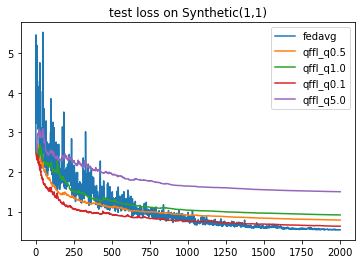

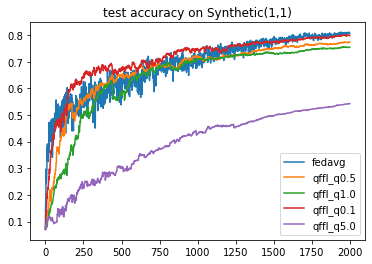

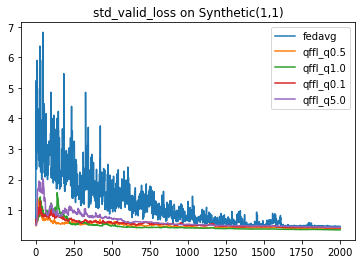

In [15]:
analysis_on_q = {
    'Selector':{
        'task': task,
        'header':['fedavg','qffl' ]
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'test_loss'}, 'fig_option':{'title':'test loss on Synthetic(1,1)'}},
            {'args':{'x': 'communication_round', 'y':'test_accuracy'},  'fig_option':{'title':'test accuracy on Synthetic(1,1)'}},
            {'args':{'x': 'communication_round', 'y':'std_valid_loss'}, 'fig_option':{'title':'std_valid_loss on Synthetic(1,1)'}},
        ]
    }
}
flgo.experiment.analyzer.show(analysis_on_q)

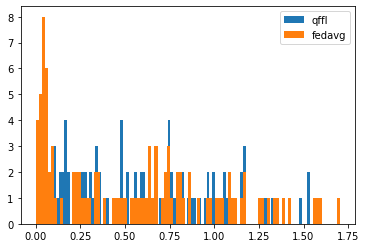

In [16]:
import matplotlib.pyplot as plt
import flgo.experiment.analyzer as al

s = al.Selector({'task':task, 'header':['qffl_q0.1','fedavg']})
records = s.records[task]
for rec in records:
    plt.hist(rec.data['valid_loss_dist'], label=rec.data['option']['algorithm'], bins=len(rec.data['valid_loss_dist']))
plt.legend()
plt.show()